In [1]:
import os
import random
import shutil
import itertools
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Network Definition

In [2]:
input_length = 28*28
hidden_0 = 1024
hidden_1 = 1024
hidden_2 = 1024
output_length = 10

In [3]:
class MLP(nn.Module):
    def __init__(self, dropout=0.5):
        super(MLP, self).__init__()
        
        self.fc0   = nn.Linear(input_length, hidden_0)
        self.bn0   = nn.BatchNorm1d(hidden_0)
        self.sig0 = nn.Sigmoid()
        self.drop0 = nn.Dropout(dropout)
        
        self.fc1   = nn.Linear(hidden_0, hidden_1)
        self.bn1   = nn.BatchNorm1d(hidden_1)
        self.sig1 = nn.Sigmoid()
        self.drop1 = nn.Dropout(dropout)
        
        self.fc2   = nn.Linear(hidden_1, hidden_2)
        self.bn2   = nn.BatchNorm1d(hidden_2)
        self.sig2  = nn.Sigmoid()
        self.drop2 = nn.Dropout(dropout)
        
        self.out   = nn.Linear(hidden_2, output_length)

    def forward(self, x):
        
        out = x.reshape(x.shape[0], -1)
        out = self.drop0(self.sig0(self.bn0(self.fc0(out))))
        out = self.drop1(self.sig1(self.bn1(self.fc1(out))))
        out = self.drop2(self.sig2(self.bn2(self.fc2(out))))
        out = self.out(out)
        
        return out

# Random Seed Utility

In [4]:
def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Define Dataloader

In [5]:
def get_dataloaders(batch_size):
    transform = transforms.ToTensor()
    dataset = datasets.MNIST("data", train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST("data", train=False, download=True, transform=transform)
    val_size = int(0.2 * len(dataset))
    train_size = len(dataset) - val_size
    train_set, val_set = random_split(dataset, [train_size, val_size])
    return (
        DataLoader(train_set, batch_size=batch_size, shuffle=True),
        DataLoader(val_set, batch_size=batch_size),
        DataLoader(test_dataset, batch_size=batch_size),
    )

# Training Pipeline

In [6]:
def train_validate_test(config, save_dir):
    set_random_seed()
    os.makedirs(save_dir, exist_ok=True)
    log_file = os.path.join(save_dir, "training_log.txt")
    resume_path = os.path.join(save_dir, "checkpoint.pth")

    epochs, batch_size, lr1, lr2, lr3, dropout = config
    train_loader, val_loader, test_loader = get_dataloaders(batch_size)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = MLP(dropout=dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr1)

    start_epoch = 0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    if os.path.exists(resume_path):
        ckpt = torch.load(resume_path)
        model.load_state_dict(ckpt["model_state"])
        optimizer.load_state_dict(ckpt["optimizer_state"])
        history = ckpt["history"]
        start_epoch = ckpt["epoch"] + 1
        print(f"🔄 Resuming from epoch {start_epoch}")
    else:
        with open(log_file, "w") as f:
            f.write("Training started\n")

    def evaluate(loader):
        model.eval()
        loss_total, correct, total = 0, 0, 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                loss_total += loss.item() * x.size(0)
                _, pred = out.max(1)
                correct += (pred == y).sum().item()
                total += x.size(0)
        return loss_total / total, correct / total

    for epoch in range(start_epoch, epochs):
        model.train()
        lr = lr1 if epoch < 0.5 * epochs else lr2 if epoch < 0.8 * epochs else lr3
        for g in optimizer.param_groups:
            g["lr"] = lr

        train_loss, correct, total = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x.size(0)
            _, pred = out.max(1)
            correct += (pred == y).sum().item()
            total += x.size(0)

        val_loss, val_acc = evaluate(val_loader)
        train_loss /= total
        train_acc = correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        log_line = (f"Epoch {epoch+1}/{epochs} - LR: {lr:.5f} | "
                    f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
                    f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
        print(log_line)
        with open(log_file, "a") as f:
            f.write(log_line + "\n")

        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "history": history
        }, resume_path)

    # Final Test
    test_loss, test_acc = evaluate(test_loader)
    final_line = f"Final Test Loss: {test_loss:.4f} Accuracy: {test_acc:.4f}"
    print(final_line)
    with open(log_file, "a") as f:
        f.write(final_line + "\n")
        f.write("Training completed\n")

    torch.save(model.state_dict(), os.path.join(save_dir, "final_model.pth"))

    # Plot and show
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.legend()
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Train Acc")
    plt.plot(history["val_acc"], label="Val Acc")
    plt.legend()
    plt.title("Accuracy")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "training_plot.png"))
    plt.show()

    return test_acc

# Exploring Best Hyperparameter

In [7]:
def Hyperparameter_searching(root_path, epochs, batch_sizes, lr_pool, dropout_rates):
    output_root = root_path
    os.makedirs(output_root, exist_ok=True)
    
    epochs = epochs
    batch_sizes = batch_sizes
    lr_pool = lr_pool
    
    # Generate descending LR combinations
    lr_combos = [combo for combo in itertools.product(lr_pool, repeat=3)
                 if (combo[0] > combo[1] > combo[2]) or (combo[0] == combo[1] == combo[2])]
    
    all_runs = [
        f"batch{bs}_lr{lr1}_{lr2}_{lr3}"
        for bs, (lr1, lr2, lr3) in itertools.product(batch_sizes, lr_combos)
    ]
    
    completed_runs = []
    for run in all_runs:
        log_path = os.path.join(output_root, run, "training_log.txt")
        if os.path.exists(log_path):
            with open(log_path, "r") as f:
                if any("Training completed" in line for line in f):
                    completed_runs.append(run)
    
    if len(completed_runs) == len(all_runs):
        print("✅ All combinations completed. Restarting from scratch...")
        for run in all_runs:
            shutil.rmtree(os.path.join(output_root, run), ignore_errors=True)
        if os.path.exists(os.path.join(output_root, "summary.csv")):
            os.remove(os.path.join(output_root, "summary.csv"))
        completed_runs = []
    
    results = []
    for batch_size, (lr1, lr2, lr3), dropout in itertools.product(batch_sizes, lr_combos, dropout_rates):
        run_name = f"batch{batch_size}_lr{lr1}_{lr2}_{lr3}_dp{dropout}"
        save_dir = os.path.join(output_root, run_name)
    
        if run_name in completed_runs:
            print(f"✅ Skipping {run_name}")
            with open(os.path.join(save_dir, "training_log.txt")) as f:
                for line in f:
                    if "Final Test Loss" in line:
                        acc = float(line.strip().split()[-1])
                        results.append((run_name, acc))
            continue
    
        print(f"🚀 Running: {run_name}")
        acc = train_validate_test([epochs, batch_size, lr1, lr2, lr3, dropout], save_dir)
        results.append((run_name, acc))
    
    results.sort(key=lambda x: x[1], reverse=True)
    best_config, best_acc = results[0]
    print(f"🏆 Best Config: {best_config} Accuracy: {best_acc:.4f}")
    
    with open(os.path.join(output_root, "summary.csv"), "w") as f:
        f.write("Config,Accuracy\n")
        for name, acc in results:
            f.write(f"{name},{acc:.4f}\n")

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4558, Acc: 0.8704 | Val Loss: 0.2642, Acc: 0.9277


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2202, Acc: 0.9366 | Val Loss: 0.1772, Acc: 0.9473


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1377, Acc: 0.9590 | Val Loss: 0.1167, Acc: 0.9665


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1042, Acc: 0.9681 | Val Loss: 0.0957, Acc: 0.9731


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0847, Acc: 0.9738 | Val Loss: 0.0994, Acc: 0.9713


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0659, Acc: 0.9783 | Val Loss: 0.1035, Acc: 0.9716


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0584, Acc: 0.9818 | Val Loss: 0.1298, Acc: 0.9659


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0460, Acc: 0.9853 | Val Loss: 0.0933, Acc: 0.9759


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0399, Acc: 0.9868 | Val Loss: 0.1190, Acc: 0.9697


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9879 | Val Loss: 0.0837, Acc: 0.9764


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9900 | Val Loss: 0.1187, Acc: 0.9730


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9914 | Val Loss: 0.1024, Acc: 0.9759


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0235, Acc: 0.9919 | Val Loss: 0.1004, Acc: 0.9748


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0253, Acc: 0.9915 | Val Loss: 0.0980, Acc: 0.9759


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9927 | Val Loss: 0.0905, Acc: 0.9798


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9948 | Val Loss: 0.1097, Acc: 0.9762


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9930 | Val Loss: 0.1097, Acc: 0.9765


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9947 | Val Loss: 0.0925, Acc: 0.9791


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9957 | Val Loss: 0.1043, Acc: 0.9793


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9953 | Val Loss: 0.1083, Acc: 0.9778


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9953 | Val Loss: 0.1075, Acc: 0.9773


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9954 | Val Loss: 0.1017, Acc: 0.9778


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.0950, Acc: 0.9802


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9956 | Val Loss: 0.0968, Acc: 0.9788


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.0888, Acc: 0.9806


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9964 | Val Loss: 0.0902, Acc: 0.9818


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.1037, Acc: 0.9782


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.0974, Acc: 0.9794


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.0952, Acc: 0.9798


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.1137, Acc: 0.9766


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.0981, Acc: 0.9796


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.0964, Acc: 0.9804


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.1018, Acc: 0.9783


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.0971, Acc: 0.9798


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.1027, Acc: 0.9792


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.1022, Acc: 0.9794


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.0992, Acc: 0.9804


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1000, Acc: 0.9805


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0959, Acc: 0.9818


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.0907, Acc: 0.9823


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1051, Acc: 0.9801


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.1048, Acc: 0.9813


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1033, Acc: 0.9817


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0963, Acc: 0.9813


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.1025, Acc: 0.9812


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1174, Acc: 0.9776


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1045, Acc: 0.9810


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1033, Acc: 0.9801


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1008, Acc: 0.9827


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1174, Acc: 0.9781


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9983 | Val Loss: 0.1038, Acc: 0.9823


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1146, Acc: 0.9793


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1089, Acc: 0.9820


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1023, Acc: 0.9798


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9983 | Val Loss: 0.0997, Acc: 0.9815


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1053, Acc: 0.9809


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0977, Acc: 0.9829


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1020, Acc: 0.9816


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9986 | Val Loss: 0.1023, Acc: 0.9828


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1030, Acc: 0.9822


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1228, Acc: 0.9782


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0966, Acc: 0.9824


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1057, Acc: 0.9818


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1255, Acc: 0.9768


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.1284, Acc: 0.9799


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9981 | Val Loss: 0.1147, Acc: 0.9803


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1049, Acc: 0.9821


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1118, Acc: 0.9803


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9986 | Val Loss: 0.1043, Acc: 0.9817


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1079, Acc: 0.9808


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.0967, Acc: 0.9831


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1084, Acc: 0.9821


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1129, Acc: 0.9808


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1052, Acc: 0.9829


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0941, Acc: 0.9828


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1036, Acc: 0.9821


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1132, Acc: 0.9805


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1157, Acc: 0.9820


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1100, Acc: 0.9823


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1144, Acc: 0.9821


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1166, Acc: 0.9808


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1147, Acc: 0.9808


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1053, Acc: 0.9821


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.1065, Acc: 0.9822


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1049, Acc: 0.9812


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9990 | Val Loss: 0.1138, Acc: 0.9796


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1137, Acc: 0.9822


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1147, Acc: 0.9820


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1091, Acc: 0.9812


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1039, Acc: 0.9833


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1104, Acc: 0.9830


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1170, Acc: 0.9806


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1093, Acc: 0.9840


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9993 | Val Loss: 0.1231, Acc: 0.9813


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1179, Acc: 0.9813


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1209, Acc: 0.9815


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1245, Acc: 0.9807


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1184, Acc: 0.9830


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1231, Acc: 0.9810


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1199, Acc: 0.9840


Final Test Loss: 0.1056 Accuracy: 0.9834


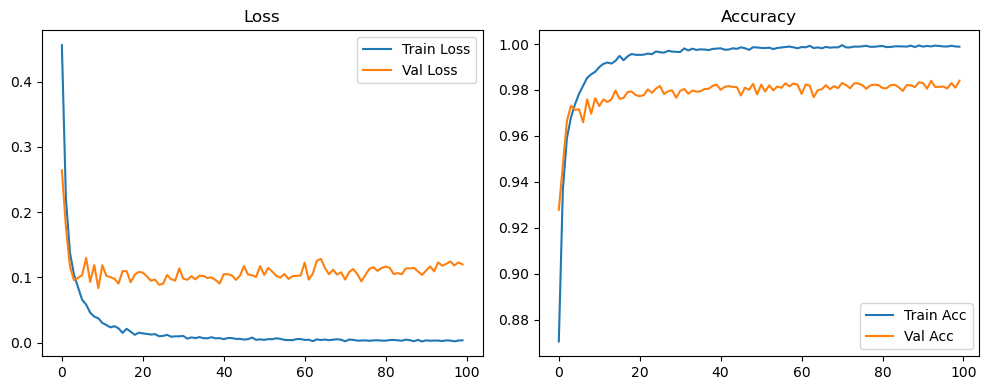

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.5036, Acc: 0.8585 | Val Loss: 0.3244, Acc: 0.9126


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2963, Acc: 0.9166 | Val Loss: 0.2033, Acc: 0.9410


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1908, Acc: 0.9438 | Val Loss: 0.1249, Acc: 0.9626


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1452, Acc: 0.9554 | Val Loss: 0.1110, Acc: 0.9665


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1186, Acc: 0.9636 | Val Loss: 0.1148, Acc: 0.9644


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1010, Acc: 0.9688 | Val Loss: 0.1158, Acc: 0.9653


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0903, Acc: 0.9728 | Val Loss: 0.1206, Acc: 0.9655


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0728, Acc: 0.9772 | Val Loss: 0.0838, Acc: 0.9747


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0635, Acc: 0.9802 | Val Loss: 0.0875, Acc: 0.9755


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0629, Acc: 0.9799 | Val Loss: 0.0809, Acc: 0.9774


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0522, Acc: 0.9830 | Val Loss: 0.0807, Acc: 0.9786


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0515, Acc: 0.9828 | Val Loss: 0.0832, Acc: 0.9789


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0410, Acc: 0.9864 | Val Loss: 0.0855, Acc: 0.9779


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9857 | Val Loss: 0.0792, Acc: 0.9772


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9868 | Val Loss: 0.0690, Acc: 0.9818


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9887 | Val Loss: 0.0861, Acc: 0.9774


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0360, Acc: 0.9878 | Val Loss: 0.0754, Acc: 0.9803


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9902 | Val Loss: 0.0882, Acc: 0.9782


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9910 | Val Loss: 0.0764, Acc: 0.9805


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9915 | Val Loss: 0.0797, Acc: 0.9818


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0291, Acc: 0.9907 | Val Loss: 0.0763, Acc: 0.9829


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9915 | Val Loss: 0.0815, Acc: 0.9808


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9929 | Val Loss: 0.0826, Acc: 0.9831


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9931 | Val Loss: 0.0801, Acc: 0.9811


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0254, Acc: 0.9919 | Val Loss: 0.0736, Acc: 0.9823


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9934 | Val Loss: 0.0741, Acc: 0.9822


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9934 | Val Loss: 0.0718, Acc: 0.9832


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9933 | Val Loss: 0.0838, Acc: 0.9809


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9935 | Val Loss: 0.0761, Acc: 0.9831


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9938 | Val Loss: 0.0699, Acc: 0.9817


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9939 | Val Loss: 0.0814, Acc: 0.9812


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9949 | Val Loss: 0.0791, Acc: 0.9818


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9942 | Val Loss: 0.0770, Acc: 0.9816


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9948 | Val Loss: 0.0891, Acc: 0.9807


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9947 | Val Loss: 0.0807, Acc: 0.9833


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9948 | Val Loss: 0.0828, Acc: 0.9807


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9951 | Val Loss: 0.0760, Acc: 0.9848


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9951 | Val Loss: 0.0871, Acc: 0.9818


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9950 | Val Loss: 0.0863, Acc: 0.9817


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9954 | Val Loss: 0.0804, Acc: 0.9830


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9955 | Val Loss: 0.0869, Acc: 0.9826


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9958 | Val Loss: 0.0829, Acc: 0.9830


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9950 | Val Loss: 0.0863, Acc: 0.9826


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9961 | Val Loss: 0.0828, Acc: 0.9831


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9955 | Val Loss: 0.0919, Acc: 0.9806


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.0971, Acc: 0.9814


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.0795, Acc: 0.9834


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9965 | Val Loss: 0.0876, Acc: 0.9836


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9964 | Val Loss: 0.0826, Acc: 0.9827


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.0827, Acc: 0.9842


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.0850, Acc: 0.9818


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.0928, Acc: 0.9832


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.0882, Acc: 0.9837


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9959 | Val Loss: 0.0858, Acc: 0.9837


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9970 | Val Loss: 0.0833, Acc: 0.9844


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9966 | Val Loss: 0.0954, Acc: 0.9819


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.0850, Acc: 0.9839


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9968 | Val Loss: 0.0848, Acc: 0.9841


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.0861, Acc: 0.9841


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.0982, Acc: 0.9836


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9969 | Val Loss: 0.0961, Acc: 0.9831


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9969 | Val Loss: 0.0955, Acc: 0.9826


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.0838, Acc: 0.9832


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.0902, Acc: 0.9829


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.0818, Acc: 0.9841


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9970 | Val Loss: 0.0922, Acc: 0.9830


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.0865, Acc: 0.9836


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.0962, Acc: 0.9834


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.0957, Acc: 0.9838


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.0992, Acc: 0.9828


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.1010, Acc: 0.9831


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.1027, Acc: 0.9832


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9969 | Val Loss: 0.0839, Acc: 0.9840


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.0925, Acc: 0.9854


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.1011, Acc: 0.9826


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9970 | Val Loss: 0.0952, Acc: 0.9825


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9980 | Val Loss: 0.0932, Acc: 0.9837


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0842, Acc: 0.9842


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.0962, Acc: 0.9835


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0930, Acc: 0.9842


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0971, Acc: 0.9842


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.0982, Acc: 0.9838


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9974 | Val Loss: 0.0895, Acc: 0.9851


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.0854, Acc: 0.9843


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0935, Acc: 0.9842


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0930, Acc: 0.9838


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.0889, Acc: 0.9847


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0967, Acc: 0.9837


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.0974, Acc: 0.9855


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9977 | Val Loss: 0.0945, Acc: 0.9845


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1054, Acc: 0.9843


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.1084, Acc: 0.9845


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9975 | Val Loss: 0.0987, Acc: 0.9838


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.0976, Acc: 0.9841


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9980 | Val Loss: 0.0982, Acc: 0.9844


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.0965, Acc: 0.9852


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.0990, Acc: 0.9854


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9981 | Val Loss: 0.0977, Acc: 0.9850


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.0960, Acc: 0.9854


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9978 | Val Loss: 0.0918, Acc: 0.9848


Final Test Loss: 0.0834 Accuracy: 0.9852


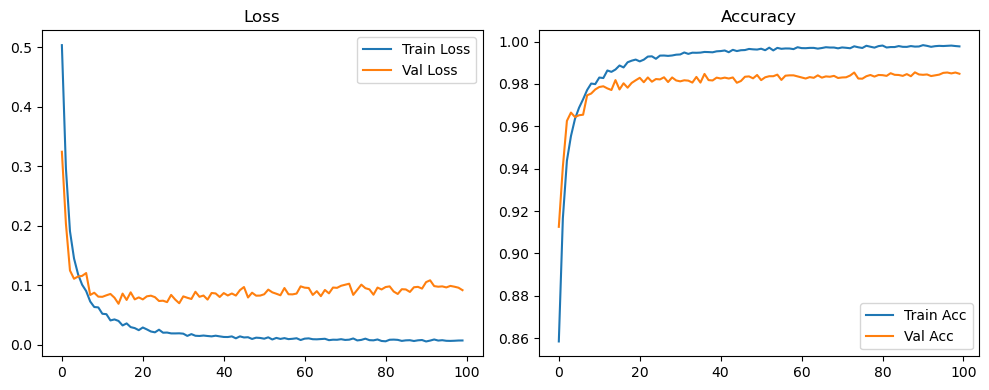

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6651, Acc: 0.8161 | Val Loss: 0.2829, Acc: 0.9237


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3995, Acc: 0.8887 | Val Loss: 0.2549, Acc: 0.9253


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2798, Acc: 0.9183 | Val Loss: 0.1538, Acc: 0.9534


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2131, Acc: 0.9357 | Val Loss: 0.1245, Acc: 0.9622


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1869, Acc: 0.9442 | Val Loss: 0.1222, Acc: 0.9634


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1605, Acc: 0.9511 | Val Loss: 0.1172, Acc: 0.9640


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1429, Acc: 0.9570 | Val Loss: 0.1062, Acc: 0.9683


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1274, Acc: 0.9607 | Val Loss: 0.0923, Acc: 0.9738


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1184, Acc: 0.9641 | Val Loss: 0.0828, Acc: 0.9749


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1108, Acc: 0.9656 | Val Loss: 0.0762, Acc: 0.9771


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0994, Acc: 0.9684 | Val Loss: 0.0804, Acc: 0.9768


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0969, Acc: 0.9695 | Val Loss: 0.0752, Acc: 0.9766


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0855, Acc: 0.9724 | Val Loss: 0.0785, Acc: 0.9775


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0842, Acc: 0.9735 | Val Loss: 0.0680, Acc: 0.9778


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0793, Acc: 0.9736 | Val Loss: 0.0693, Acc: 0.9800


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0752, Acc: 0.9753 | Val Loss: 0.0660, Acc: 0.9815


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0684, Acc: 0.9773 | Val Loss: 0.0664, Acc: 0.9803


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0665, Acc: 0.9794 | Val Loss: 0.0716, Acc: 0.9792


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0665, Acc: 0.9787 | Val Loss: 0.0673, Acc: 0.9801


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0592, Acc: 0.9811 | Val Loss: 0.0627, Acc: 0.9828


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0572, Acc: 0.9811 | Val Loss: 0.0656, Acc: 0.9809


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0561, Acc: 0.9820 | Val Loss: 0.0690, Acc: 0.9808


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0536, Acc: 0.9831 | Val Loss: 0.0650, Acc: 0.9811


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0516, Acc: 0.9837 | Val Loss: 0.0627, Acc: 0.9813


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9844 | Val Loss: 0.0623, Acc: 0.9818


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9846 | Val Loss: 0.0647, Acc: 0.9815


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0453, Acc: 0.9856 | Val Loss: 0.0676, Acc: 0.9820


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0461, Acc: 0.9849 | Val Loss: 0.0679, Acc: 0.9818


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0476, Acc: 0.9848 | Val Loss: 0.0649, Acc: 0.9828


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9859 | Val Loss: 0.0627, Acc: 0.9830


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0452, Acc: 0.9859 | Val Loss: 0.0582, Acc: 0.9829


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9882 | Val Loss: 0.0608, Acc: 0.9832


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0377, Acc: 0.9878 | Val Loss: 0.0642, Acc: 0.9829


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9876 | Val Loss: 0.0676, Acc: 0.9818


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0382, Acc: 0.9871 | Val Loss: 0.0628, Acc: 0.9828


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9884 | Val Loss: 0.0672, Acc: 0.9822


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0395, Acc: 0.9875 | Val Loss: 0.0642, Acc: 0.9821


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0347, Acc: 0.9889 | Val Loss: 0.0640, Acc: 0.9838


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0351, Acc: 0.9886 | Val Loss: 0.0641, Acc: 0.9827


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9897 | Val Loss: 0.0635, Acc: 0.9835


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9898 | Val Loss: 0.0681, Acc: 0.9838


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0344, Acc: 0.9890 | Val Loss: 0.0641, Acc: 0.9839


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9898 | Val Loss: 0.0644, Acc: 0.9838


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9904 | Val Loss: 0.0678, Acc: 0.9835


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0325, Acc: 0.9897 | Val Loss: 0.0641, Acc: 0.9837


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0278, Acc: 0.9913 | Val Loss: 0.0745, Acc: 0.9824


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9905 | Val Loss: 0.0681, Acc: 0.9842


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9905 | Val Loss: 0.0698, Acc: 0.9842


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9910 | Val Loss: 0.0642, Acc: 0.9839


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9915 | Val Loss: 0.0687, Acc: 0.9839


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0269, Acc: 0.9913 | Val Loss: 0.0697, Acc: 0.9840


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0278, Acc: 0.9911 | Val Loss: 0.0687, Acc: 0.9838


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9913 | Val Loss: 0.0731, Acc: 0.9831


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0299, Acc: 0.9910 | Val Loss: 0.0645, Acc: 0.9850


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0262, Acc: 0.9920 | Val Loss: 0.0693, Acc: 0.9833


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9923 | Val Loss: 0.0639, Acc: 0.9842


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9919 | Val Loss: 0.0751, Acc: 0.9832


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9916 | Val Loss: 0.0703, Acc: 0.9840


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9917 | Val Loss: 0.0666, Acc: 0.9841


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9920 | Val Loss: 0.0636, Acc: 0.9848


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9926 | Val Loss: 0.0623, Acc: 0.9848


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9922 | Val Loss: 0.0664, Acc: 0.9840


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9926 | Val Loss: 0.0686, Acc: 0.9837


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9929 | Val Loss: 0.0636, Acc: 0.9860


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9927 | Val Loss: 0.0671, Acc: 0.9846


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9929 | Val Loss: 0.0670, Acc: 0.9840


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9932 | Val Loss: 0.0736, Acc: 0.9835


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9934 | Val Loss: 0.0692, Acc: 0.9840


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9926 | Val Loss: 0.0707, Acc: 0.9846


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9930 | Val Loss: 0.0767, Acc: 0.9833


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9925 | Val Loss: 0.0761, Acc: 0.9834


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9928 | Val Loss: 0.0725, Acc: 0.9839


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9929 | Val Loss: 0.0688, Acc: 0.9846


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9929 | Val Loss: 0.0688, Acc: 0.9852


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9932 | Val Loss: 0.0659, Acc: 0.9858


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9937 | Val Loss: 0.0721, Acc: 0.9849


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9931 | Val Loss: 0.0711, Acc: 0.9856


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9933 | Val Loss: 0.0667, Acc: 0.9854


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9933 | Val Loss: 0.0687, Acc: 0.9852


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9937 | Val Loss: 0.0704, Acc: 0.9852


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9936 | Val Loss: 0.0806, Acc: 0.9832


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9931 | Val Loss: 0.0781, Acc: 0.9842


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9933 | Val Loss: 0.0730, Acc: 0.9846


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9942 | Val Loss: 0.0784, Acc: 0.9843


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9937 | Val Loss: 0.0774, Acc: 0.9842


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9942 | Val Loss: 0.0709, Acc: 0.9857


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9939 | Val Loss: 0.0762, Acc: 0.9851


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9940 | Val Loss: 0.0794, Acc: 0.9852


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9938 | Val Loss: 0.0758, Acc: 0.9852


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9940 | Val Loss: 0.0735, Acc: 0.9848


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9943 | Val Loss: 0.0715, Acc: 0.9856


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9937 | Val Loss: 0.0784, Acc: 0.9849


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9938 | Val Loss: 0.0841, Acc: 0.9838


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9938 | Val Loss: 0.0806, Acc: 0.9842


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9945 | Val Loss: 0.0823, Acc: 0.9844


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9946 | Val Loss: 0.0800, Acc: 0.9848


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9942 | Val Loss: 0.0764, Acc: 0.9841


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9950 | Val Loss: 0.0795, Acc: 0.9847


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9940 | Val Loss: 0.0897, Acc: 0.9848


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9947 | Val Loss: 0.0823, Acc: 0.9848


Final Test Loss: 0.0675 Accuracy: 0.9869


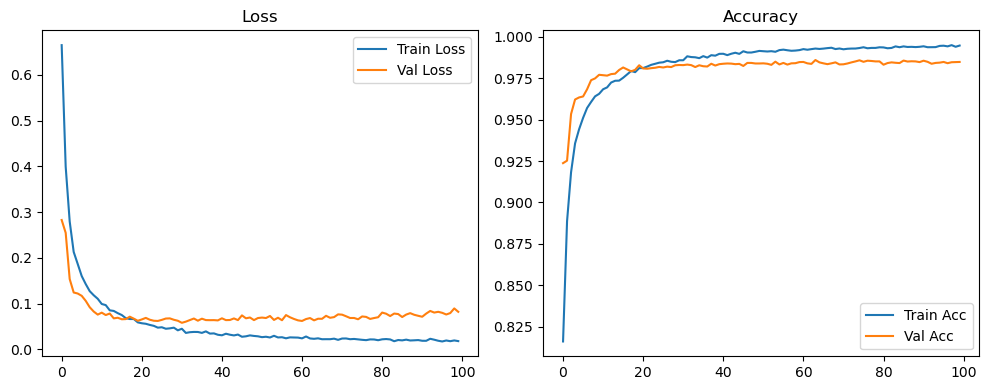

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4558, Acc: 0.8704 | Val Loss: 0.2642, Acc: 0.9277


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2202, Acc: 0.9366 | Val Loss: 0.1772, Acc: 0.9473


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1377, Acc: 0.9590 | Val Loss: 0.1167, Acc: 0.9665


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1042, Acc: 0.9681 | Val Loss: 0.0957, Acc: 0.9731


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0847, Acc: 0.9738 | Val Loss: 0.0994, Acc: 0.9713


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0659, Acc: 0.9783 | Val Loss: 0.1035, Acc: 0.9716


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0584, Acc: 0.9818 | Val Loss: 0.1298, Acc: 0.9659


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0460, Acc: 0.9853 | Val Loss: 0.0933, Acc: 0.9759


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0399, Acc: 0.9868 | Val Loss: 0.1190, Acc: 0.9697


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9879 | Val Loss: 0.0837, Acc: 0.9764


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9900 | Val Loss: 0.1187, Acc: 0.9730


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9914 | Val Loss: 0.1024, Acc: 0.9759


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0235, Acc: 0.9919 | Val Loss: 0.1004, Acc: 0.9748


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0253, Acc: 0.9915 | Val Loss: 0.0980, Acc: 0.9759


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9927 | Val Loss: 0.0905, Acc: 0.9798


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9948 | Val Loss: 0.1097, Acc: 0.9762


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9930 | Val Loss: 0.1097, Acc: 0.9765


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9947 | Val Loss: 0.0925, Acc: 0.9791


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9957 | Val Loss: 0.1043, Acc: 0.9793


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9953 | Val Loss: 0.1083, Acc: 0.9778


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9953 | Val Loss: 0.1075, Acc: 0.9773


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9954 | Val Loss: 0.1017, Acc: 0.9778


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.0950, Acc: 0.9802


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9956 | Val Loss: 0.0968, Acc: 0.9788


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.0888, Acc: 0.9806


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9964 | Val Loss: 0.0902, Acc: 0.9818


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.1037, Acc: 0.9782


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.0974, Acc: 0.9794


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.0952, Acc: 0.9798


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.1137, Acc: 0.9766


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.0981, Acc: 0.9796


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.0964, Acc: 0.9804


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.1018, Acc: 0.9783


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.0971, Acc: 0.9798


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.1027, Acc: 0.9792


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.1022, Acc: 0.9794


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.0992, Acc: 0.9804


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1000, Acc: 0.9805


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0959, Acc: 0.9818


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.0907, Acc: 0.9823


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1051, Acc: 0.9801


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.1048, Acc: 0.9813


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1033, Acc: 0.9817


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0963, Acc: 0.9813


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.1025, Acc: 0.9812


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1174, Acc: 0.9776


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1045, Acc: 0.9810


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1033, Acc: 0.9801


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1008, Acc: 0.9827


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1174, Acc: 0.9781


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0921, Acc: 0.9826


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0889, Acc: 0.9834


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0914, Acc: 0.9840


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0971, Acc: 0.9839


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0890, Acc: 0.9838


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1005, Acc: 0.9827


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1031, Acc: 0.9832


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0959, Acc: 0.9842


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0961, Acc: 0.9845


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1067, Acc: 0.9833


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0980, Acc: 0.9847


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1045, Acc: 0.9837


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1018, Acc: 0.9842


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1063, Acc: 0.9824


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1005, Acc: 0.9844


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1025, Acc: 0.9826


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0981, Acc: 0.9841


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.0969, Acc: 0.9834


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1021, Acc: 0.9829


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1078, Acc: 0.9827


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.1109, Acc: 0.9828


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1043, Acc: 0.9830


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0999, Acc: 0.9826


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1104, Acc: 0.9811


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1130, Acc: 0.9821


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9996 | Val Loss: 0.1094, Acc: 0.9842


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1161, Acc: 0.9828


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1063, Acc: 0.9838


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1070, Acc: 0.9833


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1236, Acc: 0.9825


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1158, Acc: 0.9835


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1158, Acc: 0.9833


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1104, Acc: 0.9838


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1136, Acc: 0.9838


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1121, Acc: 0.9849


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9998 | Val Loss: 0.1154, Acc: 0.9840


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1130, Acc: 0.9850


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1100, Acc: 0.9844


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1146, Acc: 0.9840


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1094, Acc: 0.9842


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1064, Acc: 0.9854


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1131, Acc: 0.9842


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1125, Acc: 0.9832


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1125, Acc: 0.9840


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1231, Acc: 0.9832


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1153, Acc: 0.9847


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1183, Acc: 0.9837


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1163, Acc: 0.9842


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1134, Acc: 0.9844


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1141, Acc: 0.9845


Final Test Loss: 0.0938 Accuracy: 0.9852


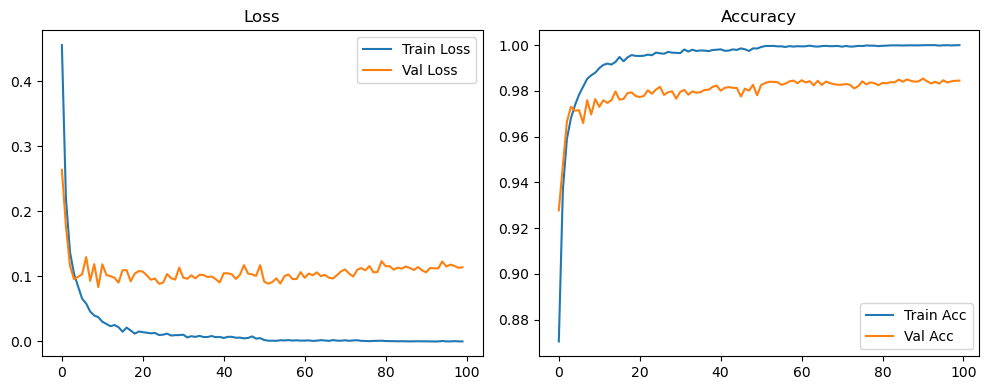

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.5036, Acc: 0.8585 | Val Loss: 0.3244, Acc: 0.9126


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2963, Acc: 0.9166 | Val Loss: 0.2033, Acc: 0.9410


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1908, Acc: 0.9438 | Val Loss: 0.1249, Acc: 0.9626


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1452, Acc: 0.9554 | Val Loss: 0.1110, Acc: 0.9665


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1186, Acc: 0.9636 | Val Loss: 0.1148, Acc: 0.9644


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1010, Acc: 0.9688 | Val Loss: 0.1158, Acc: 0.9653


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0903, Acc: 0.9728 | Val Loss: 0.1206, Acc: 0.9655


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0728, Acc: 0.9772 | Val Loss: 0.0838, Acc: 0.9747


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0635, Acc: 0.9802 | Val Loss: 0.0875, Acc: 0.9755


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0629, Acc: 0.9799 | Val Loss: 0.0809, Acc: 0.9774


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0522, Acc: 0.9830 | Val Loss: 0.0807, Acc: 0.9786


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0515, Acc: 0.9828 | Val Loss: 0.0832, Acc: 0.9789


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0410, Acc: 0.9864 | Val Loss: 0.0855, Acc: 0.9779


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9857 | Val Loss: 0.0792, Acc: 0.9772


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9868 | Val Loss: 0.0690, Acc: 0.9818


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9887 | Val Loss: 0.0861, Acc: 0.9774


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0360, Acc: 0.9878 | Val Loss: 0.0754, Acc: 0.9803


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9902 | Val Loss: 0.0882, Acc: 0.9782


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9910 | Val Loss: 0.0764, Acc: 0.9805


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9915 | Val Loss: 0.0797, Acc: 0.9818


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0291, Acc: 0.9907 | Val Loss: 0.0763, Acc: 0.9829


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9915 | Val Loss: 0.0815, Acc: 0.9808


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9929 | Val Loss: 0.0826, Acc: 0.9831


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9931 | Val Loss: 0.0801, Acc: 0.9811


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0254, Acc: 0.9919 | Val Loss: 0.0736, Acc: 0.9823


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9934 | Val Loss: 0.0741, Acc: 0.9822


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9934 | Val Loss: 0.0718, Acc: 0.9832


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9933 | Val Loss: 0.0838, Acc: 0.9809


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9935 | Val Loss: 0.0761, Acc: 0.9831


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9938 | Val Loss: 0.0699, Acc: 0.9817


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9939 | Val Loss: 0.0814, Acc: 0.9812


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9949 | Val Loss: 0.0791, Acc: 0.9818


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9942 | Val Loss: 0.0770, Acc: 0.9816


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9948 | Val Loss: 0.0891, Acc: 0.9807


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9947 | Val Loss: 0.0807, Acc: 0.9833


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9948 | Val Loss: 0.0828, Acc: 0.9807


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9951 | Val Loss: 0.0760, Acc: 0.9848


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9951 | Val Loss: 0.0871, Acc: 0.9818


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9950 | Val Loss: 0.0863, Acc: 0.9817


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9954 | Val Loss: 0.0804, Acc: 0.9830


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9955 | Val Loss: 0.0869, Acc: 0.9826


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9958 | Val Loss: 0.0829, Acc: 0.9830


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9950 | Val Loss: 0.0863, Acc: 0.9826


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9961 | Val Loss: 0.0828, Acc: 0.9831


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9955 | Val Loss: 0.0919, Acc: 0.9806


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.0971, Acc: 0.9814


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.0795, Acc: 0.9834


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9965 | Val Loss: 0.0876, Acc: 0.9836


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9964 | Val Loss: 0.0826, Acc: 0.9827


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.0827, Acc: 0.9842


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.0757, Acc: 0.9846


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0777, Acc: 0.9852


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0848, Acc: 0.9848


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0837, Acc: 0.9859


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0788, Acc: 0.9862


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0932, Acc: 0.9847


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0944, Acc: 0.9848


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0860, Acc: 0.9860


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0944, Acc: 0.9852


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.0969, Acc: 0.9848


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.0905, Acc: 0.9857


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0931, Acc: 0.9859


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0929, Acc: 0.9852


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0887, Acc: 0.9861


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0943, Acc: 0.9858


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.0929, Acc: 0.9840


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0881, Acc: 0.9854


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0994, Acc: 0.9854


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1009, Acc: 0.9853


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1002, Acc: 0.9852


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0982, Acc: 0.9855


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1030, Acc: 0.9846


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.0924, Acc: 0.9851


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.0902, Acc: 0.9847


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0930, Acc: 0.9849


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0901, Acc: 0.9853


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0927, Acc: 0.9853


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0970, Acc: 0.9850


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1010, Acc: 0.9850


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0964, Acc: 0.9853


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0939, Acc: 0.9858


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0941, Acc: 0.9861


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.0983, Acc: 0.9858


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0989, Acc: 0.9854


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0991, Acc: 0.9862


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0936, Acc: 0.9854


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1025, Acc: 0.9853


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1013, Acc: 0.9856


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9994 | Val Loss: 0.1044, Acc: 0.9857


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1055, Acc: 0.9859


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.0972, Acc: 0.9859


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1026, Acc: 0.9858


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1016, Acc: 0.9862


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1079, Acc: 0.9857


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1079, Acc: 0.9863


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1015, Acc: 0.9862


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1011, Acc: 0.9866


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1051, Acc: 0.9858


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1057, Acc: 0.9858


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1073, Acc: 0.9862


Final Test Loss: 0.1005 Accuracy: 0.9864


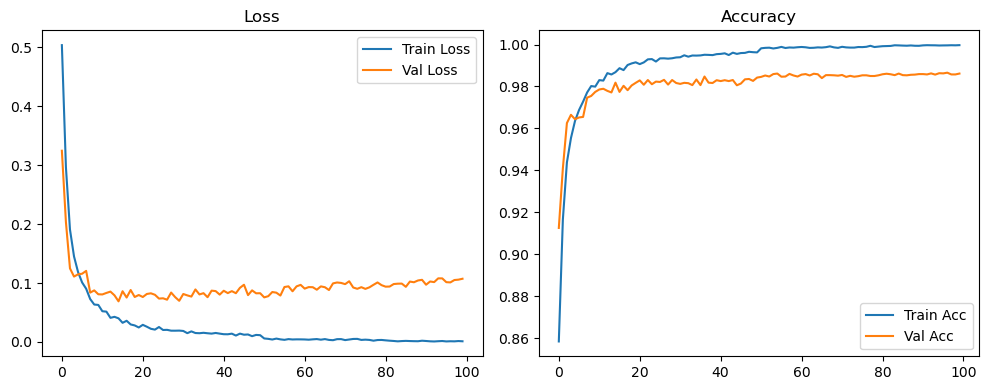

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6651, Acc: 0.8161 | Val Loss: 0.2829, Acc: 0.9237


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3995, Acc: 0.8887 | Val Loss: 0.2549, Acc: 0.9253


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2798, Acc: 0.9183 | Val Loss: 0.1538, Acc: 0.9534


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2131, Acc: 0.9357 | Val Loss: 0.1245, Acc: 0.9622


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1869, Acc: 0.9442 | Val Loss: 0.1222, Acc: 0.9634


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1605, Acc: 0.9511 | Val Loss: 0.1172, Acc: 0.9640


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1429, Acc: 0.9570 | Val Loss: 0.1062, Acc: 0.9683


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1274, Acc: 0.9607 | Val Loss: 0.0923, Acc: 0.9738


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1184, Acc: 0.9641 | Val Loss: 0.0828, Acc: 0.9749


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1108, Acc: 0.9656 | Val Loss: 0.0762, Acc: 0.9771


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0994, Acc: 0.9684 | Val Loss: 0.0804, Acc: 0.9768


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0969, Acc: 0.9695 | Val Loss: 0.0752, Acc: 0.9766


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0855, Acc: 0.9724 | Val Loss: 0.0785, Acc: 0.9775


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0842, Acc: 0.9735 | Val Loss: 0.0680, Acc: 0.9778


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0793, Acc: 0.9736 | Val Loss: 0.0693, Acc: 0.9800


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0752, Acc: 0.9753 | Val Loss: 0.0660, Acc: 0.9815


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0684, Acc: 0.9773 | Val Loss: 0.0664, Acc: 0.9803


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0665, Acc: 0.9794 | Val Loss: 0.0716, Acc: 0.9792


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0665, Acc: 0.9787 | Val Loss: 0.0673, Acc: 0.9801


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0592, Acc: 0.9811 | Val Loss: 0.0627, Acc: 0.9828


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0572, Acc: 0.9811 | Val Loss: 0.0656, Acc: 0.9809


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0561, Acc: 0.9820 | Val Loss: 0.0690, Acc: 0.9808


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0536, Acc: 0.9831 | Val Loss: 0.0650, Acc: 0.9811


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0516, Acc: 0.9837 | Val Loss: 0.0627, Acc: 0.9813


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9844 | Val Loss: 0.0623, Acc: 0.9818


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9846 | Val Loss: 0.0647, Acc: 0.9815


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0453, Acc: 0.9856 | Val Loss: 0.0676, Acc: 0.9820


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0461, Acc: 0.9849 | Val Loss: 0.0679, Acc: 0.9818


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0476, Acc: 0.9848 | Val Loss: 0.0649, Acc: 0.9828


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9859 | Val Loss: 0.0627, Acc: 0.9830


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0452, Acc: 0.9859 | Val Loss: 0.0582, Acc: 0.9829


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9882 | Val Loss: 0.0608, Acc: 0.9832


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0377, Acc: 0.9878 | Val Loss: 0.0642, Acc: 0.9829


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9876 | Val Loss: 0.0676, Acc: 0.9818


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0382, Acc: 0.9871 | Val Loss: 0.0628, Acc: 0.9828


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9884 | Val Loss: 0.0672, Acc: 0.9822


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0395, Acc: 0.9875 | Val Loss: 0.0642, Acc: 0.9821


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0347, Acc: 0.9889 | Val Loss: 0.0640, Acc: 0.9838


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0351, Acc: 0.9886 | Val Loss: 0.0641, Acc: 0.9827


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9897 | Val Loss: 0.0635, Acc: 0.9835


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9898 | Val Loss: 0.0681, Acc: 0.9838


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0344, Acc: 0.9890 | Val Loss: 0.0641, Acc: 0.9839


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9898 | Val Loss: 0.0644, Acc: 0.9838


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9904 | Val Loss: 0.0678, Acc: 0.9835


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0325, Acc: 0.9897 | Val Loss: 0.0641, Acc: 0.9837


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0278, Acc: 0.9913 | Val Loss: 0.0745, Acc: 0.9824


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9905 | Val Loss: 0.0681, Acc: 0.9842


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9905 | Val Loss: 0.0698, Acc: 0.9842


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9910 | Val Loss: 0.0642, Acc: 0.9839


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9915 | Val Loss: 0.0687, Acc: 0.9839


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9934 | Val Loss: 0.0657, Acc: 0.9846


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9937 | Val Loss: 0.0647, Acc: 0.9849


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9943 | Val Loss: 0.0690, Acc: 0.9852


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9944 | Val Loss: 0.0646, Acc: 0.9849


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9948 | Val Loss: 0.0654, Acc: 0.9851


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9948 | Val Loss: 0.0661, Acc: 0.9847


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9952 | Val Loss: 0.0675, Acc: 0.9850


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9952 | Val Loss: 0.0690, Acc: 0.9852


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9951 | Val Loss: 0.0722, Acc: 0.9843


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9951 | Val Loss: 0.0703, Acc: 0.9857


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9956 | Val Loss: 0.0680, Acc: 0.9855


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9951 | Val Loss: 0.0662, Acc: 0.9848


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9953 | Val Loss: 0.0710, Acc: 0.9852


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9957 | Val Loss: 0.0710, Acc: 0.9860


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9955 | Val Loss: 0.0694, Acc: 0.9850


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9958 | Val Loss: 0.0700, Acc: 0.9848


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9960 | Val Loss: 0.0709, Acc: 0.9857


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9963 | Val Loss: 0.0740, Acc: 0.9848


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9959 | Val Loss: 0.0735, Acc: 0.9846


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.0755, Acc: 0.9854


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9956 | Val Loss: 0.0735, Acc: 0.9849


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9952 | Val Loss: 0.0745, Acc: 0.9858


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9960 | Val Loss: 0.0729, Acc: 0.9848


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9955 | Val Loss: 0.0737, Acc: 0.9844


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9961 | Val Loss: 0.0736, Acc: 0.9844


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.0755, Acc: 0.9863


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9961 | Val Loss: 0.0758, Acc: 0.9852


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9966 | Val Loss: 0.0745, Acc: 0.9861


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9959 | Val Loss: 0.0747, Acc: 0.9854


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9963 | Val Loss: 0.0751, Acc: 0.9854


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9969 | Val Loss: 0.0716, Acc: 0.9856


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9966 | Val Loss: 0.0731, Acc: 0.9851


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.0727, Acc: 0.9854


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.0711, Acc: 0.9862


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.0717, Acc: 0.9858


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9978 | Val Loss: 0.0713, Acc: 0.9854


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.0740, Acc: 0.9863


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.0751, Acc: 0.9852


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9973 | Val Loss: 0.0767, Acc: 0.9860


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.0742, Acc: 0.9858


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.0738, Acc: 0.9851


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.0742, Acc: 0.9859


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.0766, Acc: 0.9856


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.0785, Acc: 0.9852


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.0787, Acc: 0.9854


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0784, Acc: 0.9855


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.0780, Acc: 0.9858


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0798, Acc: 0.9855


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.0796, Acc: 0.9862


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9984 | Val Loss: 0.0807, Acc: 0.9859


Final Test Loss: 0.0744 Accuracy: 0.9868


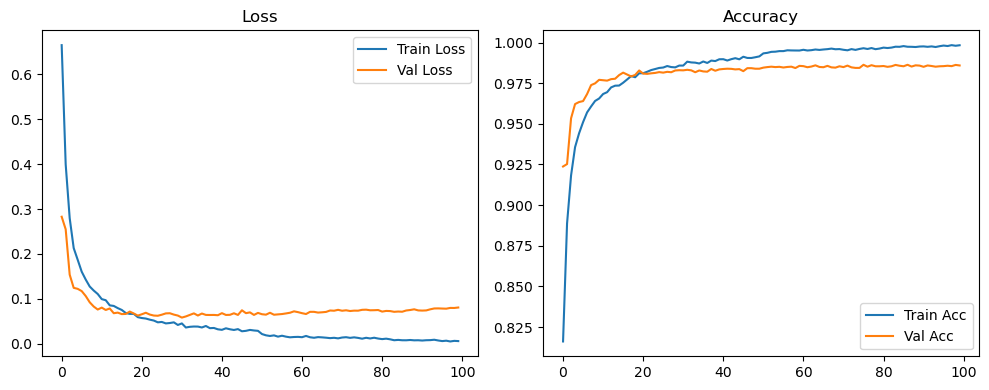

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4558, Acc: 0.8704 | Val Loss: 0.2642, Acc: 0.9277


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2202, Acc: 0.9366 | Val Loss: 0.1772, Acc: 0.9473


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1377, Acc: 0.9590 | Val Loss: 0.1167, Acc: 0.9665


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1042, Acc: 0.9681 | Val Loss: 0.0957, Acc: 0.9731


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0847, Acc: 0.9738 | Val Loss: 0.0994, Acc: 0.9713


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0659, Acc: 0.9783 | Val Loss: 0.1035, Acc: 0.9716


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0584, Acc: 0.9818 | Val Loss: 0.1298, Acc: 0.9659


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0460, Acc: 0.9853 | Val Loss: 0.0933, Acc: 0.9759


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0399, Acc: 0.9868 | Val Loss: 0.1190, Acc: 0.9697


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9879 | Val Loss: 0.0837, Acc: 0.9764


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9900 | Val Loss: 0.1187, Acc: 0.9730


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9914 | Val Loss: 0.1024, Acc: 0.9759


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0235, Acc: 0.9919 | Val Loss: 0.1004, Acc: 0.9748


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0253, Acc: 0.9915 | Val Loss: 0.0980, Acc: 0.9759


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9927 | Val Loss: 0.0905, Acc: 0.9798


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9948 | Val Loss: 0.1097, Acc: 0.9762


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9930 | Val Loss: 0.1097, Acc: 0.9765


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9947 | Val Loss: 0.0925, Acc: 0.9791


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9957 | Val Loss: 0.1043, Acc: 0.9793


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9953 | Val Loss: 0.1083, Acc: 0.9778


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9953 | Val Loss: 0.1075, Acc: 0.9773


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9954 | Val Loss: 0.1017, Acc: 0.9778


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.0950, Acc: 0.9802


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9956 | Val Loss: 0.0968, Acc: 0.9788


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.0888, Acc: 0.9806


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9964 | Val Loss: 0.0902, Acc: 0.9818


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.1037, Acc: 0.9782


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.0974, Acc: 0.9794


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.0952, Acc: 0.9798


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.1137, Acc: 0.9766


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.0981, Acc: 0.9796


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.0964, Acc: 0.9804


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.1018, Acc: 0.9783


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.0971, Acc: 0.9798


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.1027, Acc: 0.9792


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.1022, Acc: 0.9794


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.0992, Acc: 0.9804


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1000, Acc: 0.9805


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0959, Acc: 0.9818


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.0907, Acc: 0.9823


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1051, Acc: 0.9801


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.1048, Acc: 0.9813


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1033, Acc: 0.9817


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0963, Acc: 0.9813


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.1025, Acc: 0.9812


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1174, Acc: 0.9776


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1045, Acc: 0.9810


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1033, Acc: 0.9801


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1008, Acc: 0.9827


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1174, Acc: 0.9781


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0921, Acc: 0.9826


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0889, Acc: 0.9834


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0914, Acc: 0.9840


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0971, Acc: 0.9839


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0890, Acc: 0.9838


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1005, Acc: 0.9827


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1031, Acc: 0.9832


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0959, Acc: 0.9842


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0961, Acc: 0.9845


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1067, Acc: 0.9833


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0980, Acc: 0.9847


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1045, Acc: 0.9837


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1018, Acc: 0.9842


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1063, Acc: 0.9824


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1005, Acc: 0.9844


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1025, Acc: 0.9826


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0981, Acc: 0.9841


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.0969, Acc: 0.9834


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1021, Acc: 0.9829


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1078, Acc: 0.9827


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.1109, Acc: 0.9828


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1043, Acc: 0.9830


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0999, Acc: 0.9826


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1104, Acc: 0.9811


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1130, Acc: 0.9821


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9996 | Val Loss: 0.1094, Acc: 0.9842


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1161, Acc: 0.9828


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1063, Acc: 0.9838


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1070, Acc: 0.9833


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1236, Acc: 0.9825


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1147, Acc: 0.9836


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1142, Acc: 0.9838


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1096, Acc: 0.9841


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1112, Acc: 0.9845


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1111, Acc: 0.9847


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1119, Acc: 0.9846


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1114, Acc: 0.9844


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1117, Acc: 0.9840


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1134, Acc: 0.9841


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1127, Acc: 0.9845


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1104, Acc: 0.9845


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1135, Acc: 0.9838


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1113, Acc: 0.9834


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1111, Acc: 0.9840


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1142, Acc: 0.9840


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1123, Acc: 0.9841


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1132, Acc: 0.9835


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1130, Acc: 0.9842


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1118, Acc: 0.9842


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1123, Acc: 0.9842


Final Test Loss: 0.0938 Accuracy: 0.9863


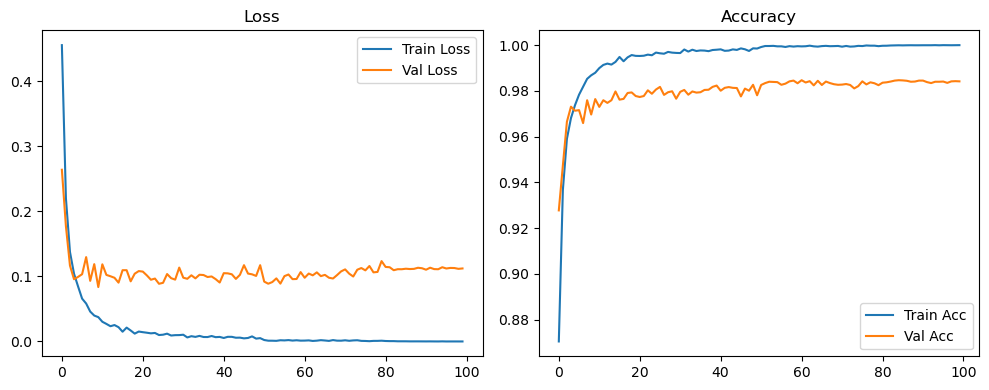

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.5036, Acc: 0.8585 | Val Loss: 0.3244, Acc: 0.9126


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2963, Acc: 0.9166 | Val Loss: 0.2033, Acc: 0.9410


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1908, Acc: 0.9438 | Val Loss: 0.1249, Acc: 0.9626


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1452, Acc: 0.9554 | Val Loss: 0.1110, Acc: 0.9665


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1186, Acc: 0.9636 | Val Loss: 0.1148, Acc: 0.9644


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1010, Acc: 0.9688 | Val Loss: 0.1158, Acc: 0.9653


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0903, Acc: 0.9728 | Val Loss: 0.1206, Acc: 0.9655


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0728, Acc: 0.9772 | Val Loss: 0.0838, Acc: 0.9747


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0635, Acc: 0.9802 | Val Loss: 0.0875, Acc: 0.9755


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0629, Acc: 0.9799 | Val Loss: 0.0809, Acc: 0.9774


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0522, Acc: 0.9830 | Val Loss: 0.0807, Acc: 0.9786


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0515, Acc: 0.9828 | Val Loss: 0.0832, Acc: 0.9789


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0410, Acc: 0.9864 | Val Loss: 0.0855, Acc: 0.9779


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9857 | Val Loss: 0.0792, Acc: 0.9772


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9868 | Val Loss: 0.0690, Acc: 0.9818


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9887 | Val Loss: 0.0861, Acc: 0.9774


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0360, Acc: 0.9878 | Val Loss: 0.0754, Acc: 0.9803


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9902 | Val Loss: 0.0882, Acc: 0.9782


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9910 | Val Loss: 0.0764, Acc: 0.9805


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9915 | Val Loss: 0.0797, Acc: 0.9818


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0291, Acc: 0.9907 | Val Loss: 0.0763, Acc: 0.9829


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9915 | Val Loss: 0.0815, Acc: 0.9808


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9929 | Val Loss: 0.0826, Acc: 0.9831


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9931 | Val Loss: 0.0801, Acc: 0.9811


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0254, Acc: 0.9919 | Val Loss: 0.0736, Acc: 0.9823


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9934 | Val Loss: 0.0741, Acc: 0.9822


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9934 | Val Loss: 0.0718, Acc: 0.9832


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9933 | Val Loss: 0.0838, Acc: 0.9809


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9935 | Val Loss: 0.0761, Acc: 0.9831


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9938 | Val Loss: 0.0699, Acc: 0.9817


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9939 | Val Loss: 0.0814, Acc: 0.9812


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9949 | Val Loss: 0.0791, Acc: 0.9818


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9942 | Val Loss: 0.0770, Acc: 0.9816


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9948 | Val Loss: 0.0891, Acc: 0.9807


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9947 | Val Loss: 0.0807, Acc: 0.9833


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9948 | Val Loss: 0.0828, Acc: 0.9807


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9951 | Val Loss: 0.0760, Acc: 0.9848


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9951 | Val Loss: 0.0871, Acc: 0.9818


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9950 | Val Loss: 0.0863, Acc: 0.9817


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9954 | Val Loss: 0.0804, Acc: 0.9830


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9955 | Val Loss: 0.0869, Acc: 0.9826


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9958 | Val Loss: 0.0829, Acc: 0.9830


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9950 | Val Loss: 0.0863, Acc: 0.9826


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9961 | Val Loss: 0.0828, Acc: 0.9831


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9955 | Val Loss: 0.0919, Acc: 0.9806


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.0971, Acc: 0.9814


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.0795, Acc: 0.9834


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9965 | Val Loss: 0.0876, Acc: 0.9836


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9964 | Val Loss: 0.0826, Acc: 0.9827


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.0827, Acc: 0.9842


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.0757, Acc: 0.9846


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0777, Acc: 0.9852


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0848, Acc: 0.9848


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0837, Acc: 0.9859


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0788, Acc: 0.9862


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0932, Acc: 0.9847


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0944, Acc: 0.9848


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0860, Acc: 0.9860


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0944, Acc: 0.9852


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.0969, Acc: 0.9848


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.0905, Acc: 0.9857


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0931, Acc: 0.9859


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0929, Acc: 0.9852


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0887, Acc: 0.9861


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0943, Acc: 0.9858


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.0929, Acc: 0.9840


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0881, Acc: 0.9854


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0994, Acc: 0.9854


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1009, Acc: 0.9853


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1002, Acc: 0.9852


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0982, Acc: 0.9855


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1030, Acc: 0.9846


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.0924, Acc: 0.9851


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.0902, Acc: 0.9847


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0930, Acc: 0.9849


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0901, Acc: 0.9853


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0927, Acc: 0.9853


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0970, Acc: 0.9850


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1010, Acc: 0.9850


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0964, Acc: 0.9853


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0924, Acc: 0.9859


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0930, Acc: 0.9858


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0951, Acc: 0.9859


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0954, Acc: 0.9861


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0956, Acc: 0.9856


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0919, Acc: 0.9857


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9994 | Val Loss: 0.0959, Acc: 0.9858


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0943, Acc: 0.9856


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0986, Acc: 0.9858


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0984, Acc: 0.9861


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.0930, Acc: 0.9858


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0965, Acc: 0.9857


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0974, Acc: 0.9860


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0968, Acc: 0.9858


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1005, Acc: 0.9858


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0964, Acc: 0.9864


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0942, Acc: 0.9862


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0980, Acc: 0.9858


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0979, Acc: 0.9858


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0983, Acc: 0.9861


Final Test Loss: 0.0946 Accuracy: 0.9868


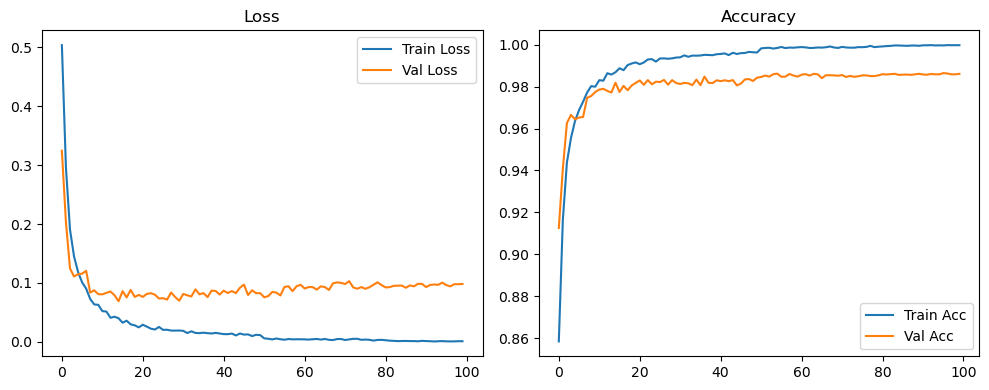

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6651, Acc: 0.8161 | Val Loss: 0.2829, Acc: 0.9237


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3995, Acc: 0.8887 | Val Loss: 0.2549, Acc: 0.9253


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2798, Acc: 0.9183 | Val Loss: 0.1538, Acc: 0.9534


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2131, Acc: 0.9357 | Val Loss: 0.1245, Acc: 0.9622


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1869, Acc: 0.9442 | Val Loss: 0.1222, Acc: 0.9634


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1605, Acc: 0.9511 | Val Loss: 0.1172, Acc: 0.9640


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1429, Acc: 0.9570 | Val Loss: 0.1062, Acc: 0.9683


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1274, Acc: 0.9607 | Val Loss: 0.0923, Acc: 0.9738


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1184, Acc: 0.9641 | Val Loss: 0.0828, Acc: 0.9749


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1108, Acc: 0.9656 | Val Loss: 0.0762, Acc: 0.9771


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0994, Acc: 0.9684 | Val Loss: 0.0804, Acc: 0.9768


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0969, Acc: 0.9695 | Val Loss: 0.0752, Acc: 0.9766


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0855, Acc: 0.9724 | Val Loss: 0.0785, Acc: 0.9775


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0842, Acc: 0.9735 | Val Loss: 0.0680, Acc: 0.9778


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0793, Acc: 0.9736 | Val Loss: 0.0693, Acc: 0.9800


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0752, Acc: 0.9753 | Val Loss: 0.0660, Acc: 0.9815


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0684, Acc: 0.9773 | Val Loss: 0.0664, Acc: 0.9803


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0665, Acc: 0.9794 | Val Loss: 0.0716, Acc: 0.9792


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0665, Acc: 0.9787 | Val Loss: 0.0673, Acc: 0.9801


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0592, Acc: 0.9811 | Val Loss: 0.0627, Acc: 0.9828


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0572, Acc: 0.9811 | Val Loss: 0.0656, Acc: 0.9809


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0561, Acc: 0.9820 | Val Loss: 0.0690, Acc: 0.9808


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0536, Acc: 0.9831 | Val Loss: 0.0650, Acc: 0.9811


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0516, Acc: 0.9837 | Val Loss: 0.0627, Acc: 0.9813


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9844 | Val Loss: 0.0623, Acc: 0.9818


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9846 | Val Loss: 0.0647, Acc: 0.9815


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0453, Acc: 0.9856 | Val Loss: 0.0676, Acc: 0.9820


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0461, Acc: 0.9849 | Val Loss: 0.0679, Acc: 0.9818


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0476, Acc: 0.9848 | Val Loss: 0.0649, Acc: 0.9828


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9859 | Val Loss: 0.0627, Acc: 0.9830


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0452, Acc: 0.9859 | Val Loss: 0.0582, Acc: 0.9829


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9882 | Val Loss: 0.0608, Acc: 0.9832


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0377, Acc: 0.9878 | Val Loss: 0.0642, Acc: 0.9829


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9876 | Val Loss: 0.0676, Acc: 0.9818


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0382, Acc: 0.9871 | Val Loss: 0.0628, Acc: 0.9828


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9884 | Val Loss: 0.0672, Acc: 0.9822


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0395, Acc: 0.9875 | Val Loss: 0.0642, Acc: 0.9821


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0347, Acc: 0.9889 | Val Loss: 0.0640, Acc: 0.9838


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0351, Acc: 0.9886 | Val Loss: 0.0641, Acc: 0.9827


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9897 | Val Loss: 0.0635, Acc: 0.9835


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9898 | Val Loss: 0.0681, Acc: 0.9838


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0344, Acc: 0.9890 | Val Loss: 0.0641, Acc: 0.9839


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9898 | Val Loss: 0.0644, Acc: 0.9838


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9904 | Val Loss: 0.0678, Acc: 0.9835


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0325, Acc: 0.9897 | Val Loss: 0.0641, Acc: 0.9837


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0278, Acc: 0.9913 | Val Loss: 0.0745, Acc: 0.9824


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9905 | Val Loss: 0.0681, Acc: 0.9842


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9905 | Val Loss: 0.0698, Acc: 0.9842


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9910 | Val Loss: 0.0642, Acc: 0.9839


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9915 | Val Loss: 0.0687, Acc: 0.9839


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9934 | Val Loss: 0.0657, Acc: 0.9846


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9937 | Val Loss: 0.0647, Acc: 0.9849


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9943 | Val Loss: 0.0690, Acc: 0.9852


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9944 | Val Loss: 0.0646, Acc: 0.9849


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9948 | Val Loss: 0.0654, Acc: 0.9851


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9948 | Val Loss: 0.0661, Acc: 0.9847


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9952 | Val Loss: 0.0675, Acc: 0.9850


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9952 | Val Loss: 0.0690, Acc: 0.9852


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9951 | Val Loss: 0.0722, Acc: 0.9843


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9951 | Val Loss: 0.0703, Acc: 0.9857


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9956 | Val Loss: 0.0680, Acc: 0.9855


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9951 | Val Loss: 0.0662, Acc: 0.9848


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9953 | Val Loss: 0.0710, Acc: 0.9852


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9957 | Val Loss: 0.0710, Acc: 0.9860


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9955 | Val Loss: 0.0694, Acc: 0.9850


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9958 | Val Loss: 0.0700, Acc: 0.9848


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9960 | Val Loss: 0.0709, Acc: 0.9857


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9963 | Val Loss: 0.0740, Acc: 0.9848


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9959 | Val Loss: 0.0735, Acc: 0.9846


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.0755, Acc: 0.9854


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9956 | Val Loss: 0.0735, Acc: 0.9849


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9952 | Val Loss: 0.0745, Acc: 0.9858


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9960 | Val Loss: 0.0729, Acc: 0.9848


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9955 | Val Loss: 0.0737, Acc: 0.9844


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9961 | Val Loss: 0.0736, Acc: 0.9844


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.0755, Acc: 0.9863


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9961 | Val Loss: 0.0758, Acc: 0.9852


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9966 | Val Loss: 0.0745, Acc: 0.9861


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9959 | Val Loss: 0.0747, Acc: 0.9854


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9963 | Val Loss: 0.0751, Acc: 0.9854


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9970 | Val Loss: 0.0711, Acc: 0.9856


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.0725, Acc: 0.9850


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.0722, Acc: 0.9855


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.0705, Acc: 0.9852


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.0706, Acc: 0.9859


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.0695, Acc: 0.9854


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.0716, Acc: 0.9862


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.0718, Acc: 0.9858


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.0743, Acc: 0.9862


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.0716, Acc: 0.9858


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.0706, Acc: 0.9859


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.0718, Acc: 0.9863


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.0730, Acc: 0.9856


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9976 | Val Loss: 0.0749, Acc: 0.9855


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.0749, Acc: 0.9858


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.0743, Acc: 0.9854


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0732, Acc: 0.9861


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0746, Acc: 0.9860


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0751, Acc: 0.9858


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0754, Acc: 0.9860


Final Test Loss: 0.0718 Accuracy: 0.9868


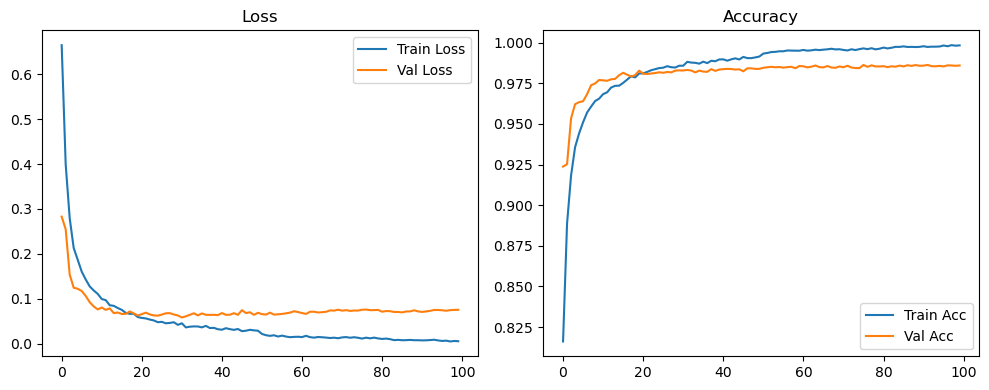

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4558, Acc: 0.8704 | Val Loss: 0.2642, Acc: 0.9277


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2202, Acc: 0.9366 | Val Loss: 0.1772, Acc: 0.9473


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1377, Acc: 0.9590 | Val Loss: 0.1167, Acc: 0.9665


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1042, Acc: 0.9681 | Val Loss: 0.0957, Acc: 0.9731


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0847, Acc: 0.9738 | Val Loss: 0.0994, Acc: 0.9713


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0659, Acc: 0.9783 | Val Loss: 0.1035, Acc: 0.9716


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0584, Acc: 0.9818 | Val Loss: 0.1298, Acc: 0.9659


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0460, Acc: 0.9853 | Val Loss: 0.0933, Acc: 0.9759


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0399, Acc: 0.9868 | Val Loss: 0.1190, Acc: 0.9697


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9879 | Val Loss: 0.0837, Acc: 0.9764


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9900 | Val Loss: 0.1187, Acc: 0.9730


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9914 | Val Loss: 0.1024, Acc: 0.9759


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0235, Acc: 0.9919 | Val Loss: 0.1004, Acc: 0.9748


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0253, Acc: 0.9915 | Val Loss: 0.0980, Acc: 0.9759


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9927 | Val Loss: 0.0905, Acc: 0.9798


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9948 | Val Loss: 0.1097, Acc: 0.9762


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9930 | Val Loss: 0.1097, Acc: 0.9765


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9947 | Val Loss: 0.0925, Acc: 0.9791


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9957 | Val Loss: 0.1043, Acc: 0.9793


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9953 | Val Loss: 0.1083, Acc: 0.9778


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9953 | Val Loss: 0.1075, Acc: 0.9773


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9954 | Val Loss: 0.1017, Acc: 0.9778


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.0950, Acc: 0.9802


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9956 | Val Loss: 0.0968, Acc: 0.9788


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.0888, Acc: 0.9806


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9964 | Val Loss: 0.0902, Acc: 0.9818


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.1037, Acc: 0.9782


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.0974, Acc: 0.9794


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.0952, Acc: 0.9798


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.1137, Acc: 0.9766


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.0981, Acc: 0.9796


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.0964, Acc: 0.9804


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.1018, Acc: 0.9783


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.0971, Acc: 0.9798


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.1027, Acc: 0.9792


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.1022, Acc: 0.9794


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.0992, Acc: 0.9804


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1000, Acc: 0.9805


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0959, Acc: 0.9818


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.0907, Acc: 0.9823


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1051, Acc: 0.9801


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.1048, Acc: 0.9813


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1033, Acc: 0.9817


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0963, Acc: 0.9813


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.1025, Acc: 0.9812


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1174, Acc: 0.9776


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1045, Acc: 0.9810


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1033, Acc: 0.9801


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1008, Acc: 0.9827


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1174, Acc: 0.9781


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0900, Acc: 0.9838


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0873, Acc: 0.9831


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0879, Acc: 0.9842


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0883, Acc: 0.9842


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0864, Acc: 0.9845


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.0888, Acc: 0.9848


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0931, Acc: 0.9832


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0883, Acc: 0.9848


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0976, Acc: 0.9832


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0887, Acc: 0.9847


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0885, Acc: 0.9846


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0938, Acc: 0.9841


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0937, Acc: 0.9841


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0938, Acc: 0.9844


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0987, Acc: 0.9844


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0994, Acc: 0.9836


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0991, Acc: 0.9847


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0934, Acc: 0.9851


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.0947, Acc: 0.9846


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0985, Acc: 0.9841


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0980, Acc: 0.9831


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0966, Acc: 0.9846


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1029, Acc: 0.9828


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1040, Acc: 0.9836


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1004, Acc: 0.9843


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.1038, Acc: 0.9838


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1040, Acc: 0.9832


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1006, Acc: 0.9839


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1002, Acc: 0.9838


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1027, Acc: 0.9842


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0984, Acc: 0.9851


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0995, Acc: 0.9854


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0987, Acc: 0.9846


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1007, Acc: 0.9852


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0998, Acc: 0.9848


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1031, Acc: 0.9845


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1011, Acc: 0.9852


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1036, Acc: 0.9852


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1054, Acc: 0.9844


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1058, Acc: 0.9846


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1035, Acc: 0.9849


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1060, Acc: 0.9844


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1057, Acc: 0.9841


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1048, Acc: 0.9848


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1058, Acc: 0.9842


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1060, Acc: 0.9843


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1074, Acc: 0.9842


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1052, Acc: 0.9851


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1062, Acc: 0.9842


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1045, Acc: 0.9851


Final Test Loss: 0.0884 Accuracy: 0.9856


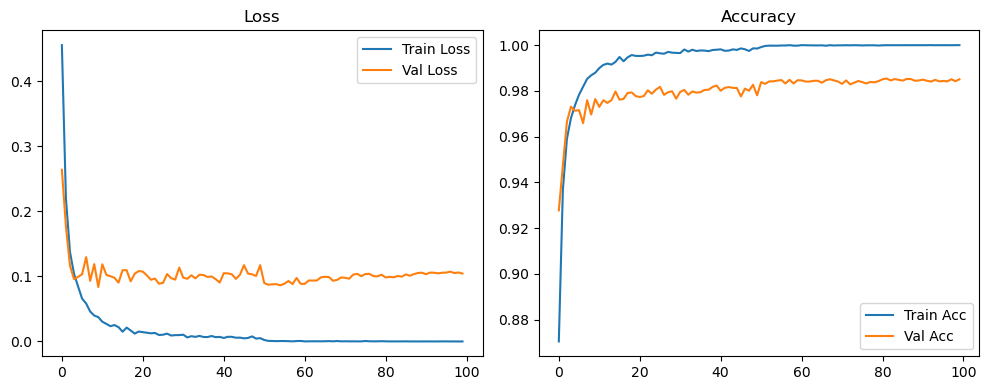

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.5036, Acc: 0.8585 | Val Loss: 0.3244, Acc: 0.9126


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2963, Acc: 0.9166 | Val Loss: 0.2033, Acc: 0.9410


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1908, Acc: 0.9438 | Val Loss: 0.1249, Acc: 0.9626


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1452, Acc: 0.9554 | Val Loss: 0.1110, Acc: 0.9665


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1186, Acc: 0.9636 | Val Loss: 0.1148, Acc: 0.9644


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1010, Acc: 0.9688 | Val Loss: 0.1158, Acc: 0.9653


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0903, Acc: 0.9728 | Val Loss: 0.1206, Acc: 0.9655


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0728, Acc: 0.9772 | Val Loss: 0.0838, Acc: 0.9747


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0635, Acc: 0.9802 | Val Loss: 0.0875, Acc: 0.9755


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0629, Acc: 0.9799 | Val Loss: 0.0809, Acc: 0.9774


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0522, Acc: 0.9830 | Val Loss: 0.0807, Acc: 0.9786


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0515, Acc: 0.9828 | Val Loss: 0.0832, Acc: 0.9789


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0410, Acc: 0.9864 | Val Loss: 0.0855, Acc: 0.9779


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9857 | Val Loss: 0.0792, Acc: 0.9772


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9868 | Val Loss: 0.0690, Acc: 0.9818


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9887 | Val Loss: 0.0861, Acc: 0.9774


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0360, Acc: 0.9878 | Val Loss: 0.0754, Acc: 0.9803


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9902 | Val Loss: 0.0882, Acc: 0.9782


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9910 | Val Loss: 0.0764, Acc: 0.9805


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9915 | Val Loss: 0.0797, Acc: 0.9818


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0291, Acc: 0.9907 | Val Loss: 0.0763, Acc: 0.9829


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9915 | Val Loss: 0.0815, Acc: 0.9808


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9929 | Val Loss: 0.0826, Acc: 0.9831


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9931 | Val Loss: 0.0801, Acc: 0.9811


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0254, Acc: 0.9919 | Val Loss: 0.0736, Acc: 0.9823


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9934 | Val Loss: 0.0741, Acc: 0.9822


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9934 | Val Loss: 0.0718, Acc: 0.9832


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9933 | Val Loss: 0.0838, Acc: 0.9809


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9935 | Val Loss: 0.0761, Acc: 0.9831


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9938 | Val Loss: 0.0699, Acc: 0.9817


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9939 | Val Loss: 0.0814, Acc: 0.9812


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9949 | Val Loss: 0.0791, Acc: 0.9818


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9942 | Val Loss: 0.0770, Acc: 0.9816


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9948 | Val Loss: 0.0891, Acc: 0.9807


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9947 | Val Loss: 0.0807, Acc: 0.9833


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9948 | Val Loss: 0.0828, Acc: 0.9807


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9951 | Val Loss: 0.0760, Acc: 0.9848


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9951 | Val Loss: 0.0871, Acc: 0.9818


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9950 | Val Loss: 0.0863, Acc: 0.9817


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9954 | Val Loss: 0.0804, Acc: 0.9830


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9955 | Val Loss: 0.0869, Acc: 0.9826


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9958 | Val Loss: 0.0829, Acc: 0.9830


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9950 | Val Loss: 0.0863, Acc: 0.9826


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9961 | Val Loss: 0.0828, Acc: 0.9831


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9955 | Val Loss: 0.0919, Acc: 0.9806


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.0971, Acc: 0.9814


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.0795, Acc: 0.9834


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9965 | Val Loss: 0.0876, Acc: 0.9836


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9964 | Val Loss: 0.0826, Acc: 0.9827


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.0827, Acc: 0.9842


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9977 | Val Loss: 0.0763, Acc: 0.9850


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0713, Acc: 0.9856


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.0726, Acc: 0.9857


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0720, Acc: 0.9862


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0708, Acc: 0.9864


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0748, Acc: 0.9861


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0786, Acc: 0.9862


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0783, Acc: 0.9861


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0814, Acc: 0.9861


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0852, Acc: 0.9866


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0859, Acc: 0.9865


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0867, Acc: 0.9859


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0845, Acc: 0.9858


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0814, Acc: 0.9862


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0816, Acc: 0.9861


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0860, Acc: 0.9856


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0843, Acc: 0.9860


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0874, Acc: 0.9866


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0883, Acc: 0.9862


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0933, Acc: 0.9860


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0908, Acc: 0.9869


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0965, Acc: 0.9857


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0925, Acc: 0.9862


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0948, Acc: 0.9859


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0934, Acc: 0.9866


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0949, Acc: 0.9859


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0945, Acc: 0.9870


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0936, Acc: 0.9863


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0971, Acc: 0.9866


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0985, Acc: 0.9864


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0981, Acc: 0.9862


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0962, Acc: 0.9865


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0976, Acc: 0.9864


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0956, Acc: 0.9865


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0954, Acc: 0.9860


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0937, Acc: 0.9861


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0971, Acc: 0.9868


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0943, Acc: 0.9864


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0996, Acc: 0.9867


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0983, Acc: 0.9864


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0927, Acc: 0.9865


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0977, Acc: 0.9853


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0968, Acc: 0.9865


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0968, Acc: 0.9868


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0971, Acc: 0.9869


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9996 | Val Loss: 0.0991, Acc: 0.9872


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0984, Acc: 0.9863


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0979, Acc: 0.9872


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0994, Acc: 0.9870


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0981, Acc: 0.9872


Final Test Loss: 0.1032 Accuracy: 0.9859


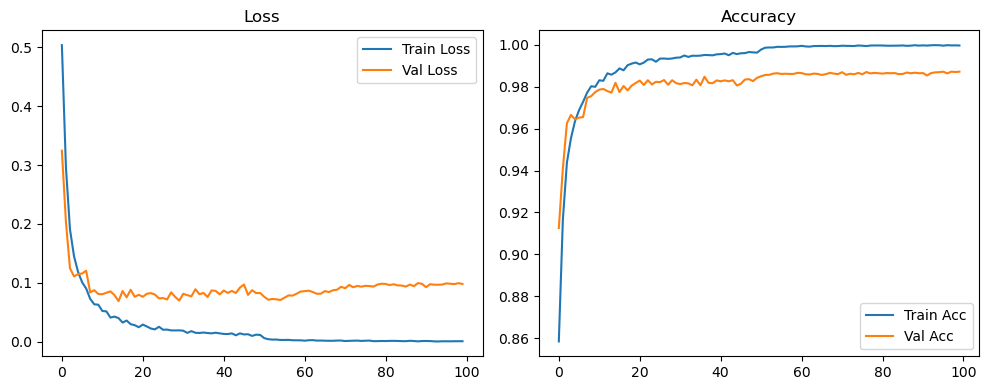

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6651, Acc: 0.8161 | Val Loss: 0.2829, Acc: 0.9237


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3995, Acc: 0.8887 | Val Loss: 0.2549, Acc: 0.9253


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2798, Acc: 0.9183 | Val Loss: 0.1538, Acc: 0.9534


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2131, Acc: 0.9357 | Val Loss: 0.1245, Acc: 0.9622


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1869, Acc: 0.9442 | Val Loss: 0.1222, Acc: 0.9634


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1605, Acc: 0.9511 | Val Loss: 0.1172, Acc: 0.9640


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1429, Acc: 0.9570 | Val Loss: 0.1062, Acc: 0.9683


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1274, Acc: 0.9607 | Val Loss: 0.0923, Acc: 0.9738


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1184, Acc: 0.9641 | Val Loss: 0.0828, Acc: 0.9749


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1108, Acc: 0.9656 | Val Loss: 0.0762, Acc: 0.9771


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0994, Acc: 0.9684 | Val Loss: 0.0804, Acc: 0.9768


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0969, Acc: 0.9695 | Val Loss: 0.0752, Acc: 0.9766


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0855, Acc: 0.9724 | Val Loss: 0.0785, Acc: 0.9775


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0842, Acc: 0.9735 | Val Loss: 0.0680, Acc: 0.9778


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0793, Acc: 0.9736 | Val Loss: 0.0693, Acc: 0.9800


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0752, Acc: 0.9753 | Val Loss: 0.0660, Acc: 0.9815


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0684, Acc: 0.9773 | Val Loss: 0.0664, Acc: 0.9803


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0665, Acc: 0.9794 | Val Loss: 0.0716, Acc: 0.9792


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0665, Acc: 0.9787 | Val Loss: 0.0673, Acc: 0.9801


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0592, Acc: 0.9811 | Val Loss: 0.0627, Acc: 0.9828


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0572, Acc: 0.9811 | Val Loss: 0.0656, Acc: 0.9809


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0561, Acc: 0.9820 | Val Loss: 0.0690, Acc: 0.9808


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0536, Acc: 0.9831 | Val Loss: 0.0650, Acc: 0.9811


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0516, Acc: 0.9837 | Val Loss: 0.0627, Acc: 0.9813


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9844 | Val Loss: 0.0623, Acc: 0.9818


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9846 | Val Loss: 0.0647, Acc: 0.9815


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0453, Acc: 0.9856 | Val Loss: 0.0676, Acc: 0.9820


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0461, Acc: 0.9849 | Val Loss: 0.0679, Acc: 0.9818


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0476, Acc: 0.9848 | Val Loss: 0.0649, Acc: 0.9828


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9859 | Val Loss: 0.0627, Acc: 0.9830


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0452, Acc: 0.9859 | Val Loss: 0.0582, Acc: 0.9829


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9882 | Val Loss: 0.0608, Acc: 0.9832


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0377, Acc: 0.9878 | Val Loss: 0.0642, Acc: 0.9829


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9876 | Val Loss: 0.0676, Acc: 0.9818


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0382, Acc: 0.9871 | Val Loss: 0.0628, Acc: 0.9828


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9884 | Val Loss: 0.0672, Acc: 0.9822


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0395, Acc: 0.9875 | Val Loss: 0.0642, Acc: 0.9821


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0347, Acc: 0.9889 | Val Loss: 0.0640, Acc: 0.9838


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0351, Acc: 0.9886 | Val Loss: 0.0641, Acc: 0.9827


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9897 | Val Loss: 0.0635, Acc: 0.9835


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9898 | Val Loss: 0.0681, Acc: 0.9838


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0344, Acc: 0.9890 | Val Loss: 0.0641, Acc: 0.9839


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9898 | Val Loss: 0.0644, Acc: 0.9838


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9904 | Val Loss: 0.0678, Acc: 0.9835


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0325, Acc: 0.9897 | Val Loss: 0.0641, Acc: 0.9837


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0278, Acc: 0.9913 | Val Loss: 0.0745, Acc: 0.9824


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9905 | Val Loss: 0.0681, Acc: 0.9842


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9905 | Val Loss: 0.0698, Acc: 0.9842


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9910 | Val Loss: 0.0642, Acc: 0.9839


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9915 | Val Loss: 0.0687, Acc: 0.9839


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0209, Acc: 0.9932 | Val Loss: 0.0651, Acc: 0.9849


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0179, Acc: 0.9936 | Val Loss: 0.0616, Acc: 0.9854


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0161, Acc: 0.9949 | Val Loss: 0.0643, Acc: 0.9852


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0169, Acc: 0.9946 | Val Loss: 0.0633, Acc: 0.9853


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9953 | Val Loss: 0.0639, Acc: 0.9854


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0149, Acc: 0.9953 | Val Loss: 0.0642, Acc: 0.9852


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9955 | Val Loss: 0.0651, Acc: 0.9853


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9960 | Val Loss: 0.0654, Acc: 0.9854


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.0655, Acc: 0.9859


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9966 | Val Loss: 0.0663, Acc: 0.9858


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9962 | Val Loss: 0.0659, Acc: 0.9853


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9962 | Val Loss: 0.0652, Acc: 0.9856


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9969 | Val Loss: 0.0676, Acc: 0.9849


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9968 | Val Loss: 0.0663, Acc: 0.9860


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.0683, Acc: 0.9855


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9967 | Val Loss: 0.0679, Acc: 0.9858


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9968 | Val Loss: 0.0672, Acc: 0.9868


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.0694, Acc: 0.9856


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.0703, Acc: 0.9853


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9970 | Val Loss: 0.0722, Acc: 0.9858


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9970 | Val Loss: 0.0697, Acc: 0.9858


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.0723, Acc: 0.9858


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.0699, Acc: 0.9856


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.0745, Acc: 0.9855


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.0725, Acc: 0.9861


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.0736, Acc: 0.9853


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9967 | Val Loss: 0.0757, Acc: 0.9856


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9978 | Val Loss: 0.0737, Acc: 0.9860


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.0744, Acc: 0.9862


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9978 | Val Loss: 0.0751, Acc: 0.9862


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.0736, Acc: 0.9860


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9975 | Val Loss: 0.0742, Acc: 0.9862


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9977 | Val Loss: 0.0753, Acc: 0.9855


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.0734, Acc: 0.9858


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.0747, Acc: 0.9856


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.0730, Acc: 0.9858


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0739, Acc: 0.9862


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0751, Acc: 0.9861


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.0781, Acc: 0.9858


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.0744, Acc: 0.9859


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.0727, Acc: 0.9865


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.0748, Acc: 0.9867


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9977 | Val Loss: 0.0751, Acc: 0.9862


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.0791, Acc: 0.9861


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0770, Acc: 0.9857


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.0760, Acc: 0.9856


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0752, Acc: 0.9855


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.0751, Acc: 0.9860


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0759, Acc: 0.9859


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0769, Acc: 0.9864


Final Test Loss: 0.0711 Accuracy: 0.9867


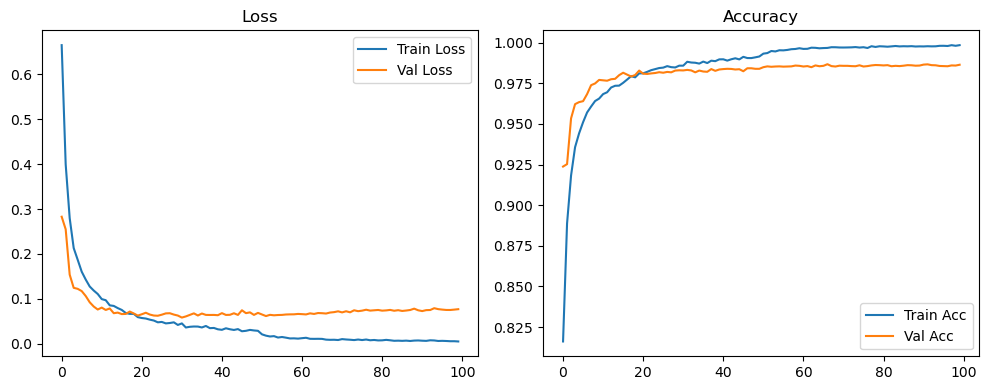

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4167, Acc: 0.8764 | Val Loss: 0.2935, Acc: 0.9188


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2523, Acc: 0.9274 | Val Loss: 0.2216, Acc: 0.9361


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1674, Acc: 0.9502 | Val Loss: 0.1345, Acc: 0.9591


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1226, Acc: 0.9634 | Val Loss: 0.1255, Acc: 0.9629


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1046, Acc: 0.9687 | Val Loss: 0.1295, Acc: 0.9639


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0846, Acc: 0.9736 | Val Loss: 0.1316, Acc: 0.9654


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0702, Acc: 0.9789 | Val Loss: 0.1392, Acc: 0.9637


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0593, Acc: 0.9819 | Val Loss: 0.1200, Acc: 0.9692


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0520, Acc: 0.9839 | Val Loss: 0.1151, Acc: 0.9738


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0463, Acc: 0.9851 | Val Loss: 0.1118, Acc: 0.9736


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0414, Acc: 0.9878 | Val Loss: 0.1204, Acc: 0.9719


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0330, Acc: 0.9890 | Val Loss: 0.1187, Acc: 0.9747


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0316, Acc: 0.9899 | Val Loss: 0.1248, Acc: 0.9722


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9904 | Val Loss: 0.1096, Acc: 0.9762


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9918 | Val Loss: 0.1068, Acc: 0.9764


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0227, Acc: 0.9923 | Val Loss: 0.1401, Acc: 0.9711


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0281, Acc: 0.9911 | Val Loss: 0.1133, Acc: 0.9777


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9938 | Val Loss: 0.1462, Acc: 0.9722


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9937 | Val Loss: 0.1093, Acc: 0.9783


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9948 | Val Loss: 0.1132, Acc: 0.9783


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9944 | Val Loss: 0.0977, Acc: 0.9810


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9954 | Val Loss: 0.1135, Acc: 0.9791


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9952 | Val Loss: 0.0965, Acc: 0.9802


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9954 | Val Loss: 0.0996, Acc: 0.9801


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0170, Acc: 0.9949 | Val Loss: 0.0976, Acc: 0.9800


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.0939, Acc: 0.9798


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9963 | Val Loss: 0.0937, Acc: 0.9814


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.0975, Acc: 0.9812


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.1037, Acc: 0.9794


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 0.1092, Acc: 0.9785


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9961 | Val Loss: 0.0961, Acc: 0.9805


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9965 | Val Loss: 0.1013, Acc: 0.9802


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.0972, Acc: 0.9819


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.1194, Acc: 0.9789


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1042, Acc: 0.9789


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.1105, Acc: 0.9804


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9977 | Val Loss: 0.0955, Acc: 0.9819


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1104, Acc: 0.9808


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9975 | Val Loss: 0.1025, Acc: 0.9808


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.1125, Acc: 0.9792


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.1181, Acc: 0.9793


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.1166, Acc: 0.9790


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.1025, Acc: 0.9820


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1013, Acc: 0.9807


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.1355, Acc: 0.9785


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9975 | Val Loss: 0.1333, Acc: 0.9772


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1008, Acc: 0.9812


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9978 | Val Loss: 0.1005, Acc: 0.9807


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.0980, Acc: 0.9813


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.0958, Acc: 0.9806


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.1032, Acc: 0.9808


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1001, Acc: 0.9819


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1081, Acc: 0.9821


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.1030, Acc: 0.9810


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1281, Acc: 0.9788


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9979 | Val Loss: 0.1040, Acc: 0.9808


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1054, Acc: 0.9808


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1080, Acc: 0.9802


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1052, Acc: 0.9818


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1147, Acc: 0.9803


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1060, Acc: 0.9818


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1004, Acc: 0.9817


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1085, Acc: 0.9811


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.1096, Acc: 0.9812


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.1118, Acc: 0.9812


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1125, Acc: 0.9818


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.1077, Acc: 0.9812


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.0985, Acc: 0.9825


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1099, Acc: 0.9818


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1116, Acc: 0.9817


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1174, Acc: 0.9805


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1054, Acc: 0.9813


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1074, Acc: 0.9822


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1128, Acc: 0.9807


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1054, Acc: 0.9821


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1022, Acc: 0.9808


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1043, Acc: 0.9832


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0909, Acc: 0.9843


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9992 | Val Loss: 0.1001, Acc: 0.9822


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1052, Acc: 0.9813


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0968, Acc: 0.9828


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.1071, Acc: 0.9811


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1056, Acc: 0.9823


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1073, Acc: 0.9818


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1058, Acc: 0.9818


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1256, Acc: 0.9810


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9983 | Val Loss: 0.1108, Acc: 0.9832


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1029, Acc: 0.9832


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1021, Acc: 0.9836


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1136, Acc: 0.9813


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1142, Acc: 0.9815


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9989 | Val Loss: 0.1264, Acc: 0.9809


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1136, Acc: 0.9822


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1159, Acc: 0.9820


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.1218, Acc: 0.9811


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1132, Acc: 0.9826


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1068, Acc: 0.9839


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1081, Acc: 0.9832


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1102, Acc: 0.9823


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0996, Acc: 0.9826


Final Test Loss: 0.0997 Accuracy: 0.9830


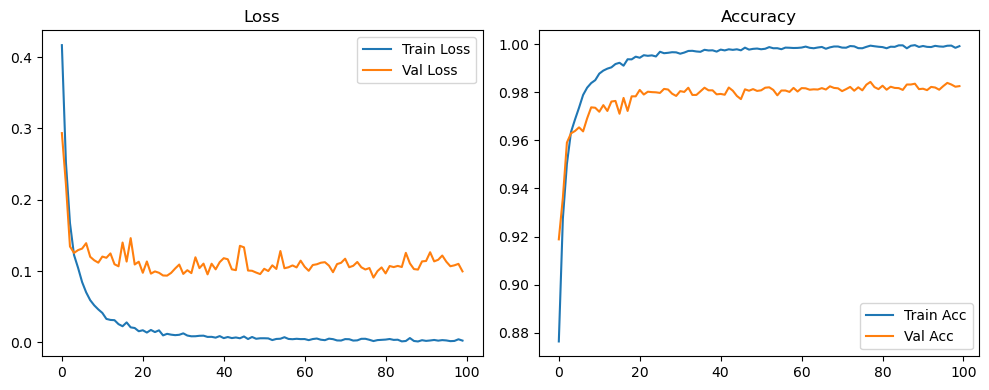

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4570, Acc: 0.8651 | Val Loss: 0.3253, Acc: 0.9111


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.3201, Acc: 0.9081 | Val Loss: 0.2422, Acc: 0.9310


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2278, Acc: 0.9342 | Val Loss: 0.1640, Acc: 0.9529


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1827, Acc: 0.9457 | Val Loss: 0.1336, Acc: 0.9622


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1488, Acc: 0.9559 | Val Loss: 0.1384, Acc: 0.9614


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1287, Acc: 0.9617 | Val Loss: 0.1506, Acc: 0.9596


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1078, Acc: 0.9676 | Val Loss: 0.1359, Acc: 0.9618


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0949, Acc: 0.9706 | Val Loss: 0.1029, Acc: 0.9712


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0821, Acc: 0.9734 | Val Loss: 0.1092, Acc: 0.9699


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0780, Acc: 0.9755 | Val Loss: 0.0844, Acc: 0.9770


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0628, Acc: 0.9797 | Val Loss: 0.1012, Acc: 0.9759


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0589, Acc: 0.9809 | Val Loss: 0.0950, Acc: 0.9757


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0521, Acc: 0.9834 | Val Loss: 0.0932, Acc: 0.9757


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0520, Acc: 0.9832 | Val Loss: 0.1044, Acc: 0.9748


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0451, Acc: 0.9850 | Val Loss: 0.1029, Acc: 0.9768


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0435, Acc: 0.9851 | Val Loss: 0.1169, Acc: 0.9729


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0415, Acc: 0.9872 | Val Loss: 0.1053, Acc: 0.9772


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0353, Acc: 0.9882 | Val Loss: 0.0926, Acc: 0.9777


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0361, Acc: 0.9889 | Val Loss: 0.0846, Acc: 0.9802


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0300, Acc: 0.9905 | Val Loss: 0.0903, Acc: 0.9788


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0335, Acc: 0.9887 | Val Loss: 0.0891, Acc: 0.9814


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0288, Acc: 0.9905 | Val Loss: 0.0979, Acc: 0.9804


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9914 | Val Loss: 0.0935, Acc: 0.9798


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9916 | Val Loss: 0.0922, Acc: 0.9807


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0249, Acc: 0.9917 | Val Loss: 0.0935, Acc: 0.9794


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0234, Acc: 0.9927 | Val Loss: 0.0905, Acc: 0.9818


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9924 | Val Loss: 0.0858, Acc: 0.9812


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9928 | Val Loss: 0.0946, Acc: 0.9806


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0226, Acc: 0.9924 | Val Loss: 0.1000, Acc: 0.9807


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0206, Acc: 0.9936 | Val Loss: 0.0877, Acc: 0.9811


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9936 | Val Loss: 0.0913, Acc: 0.9821


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9934 | Val Loss: 0.0933, Acc: 0.9810


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9950 | Val Loss: 0.0965, Acc: 0.9800


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9946 | Val Loss: 0.1094, Acc: 0.9789


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9941 | Val Loss: 0.0878, Acc: 0.9828


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0200, Acc: 0.9936 | Val Loss: 0.0894, Acc: 0.9816


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9952 | Val Loss: 0.0922, Acc: 0.9810


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9948 | Val Loss: 0.0879, Acc: 0.9813


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9946 | Val Loss: 0.0958, Acc: 0.9813


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9952 | Val Loss: 0.0853, Acc: 0.9822


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9954 | Val Loss: 0.0948, Acc: 0.9807


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9955 | Val Loss: 0.0894, Acc: 0.9832


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9954 | Val Loss: 0.0905, Acc: 0.9827


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.0934, Acc: 0.9823


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9959 | Val Loss: 0.0932, Acc: 0.9814


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.1070, Acc: 0.9810


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.0908, Acc: 0.9832


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9959 | Val Loss: 0.0962, Acc: 0.9819


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9963 | Val Loss: 0.0964, Acc: 0.9824


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.0896, Acc: 0.9840


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9960 | Val Loss: 0.0984, Acc: 0.9817


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9962 | Val Loss: 0.0886, Acc: 0.9834


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9963 | Val Loss: 0.0968, Acc: 0.9831


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9955 | Val Loss: 0.0833, Acc: 0.9840


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.0898, Acc: 0.9832


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.0965, Acc: 0.9830


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.0952, Acc: 0.9834


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.0926, Acc: 0.9842


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.0988, Acc: 0.9827


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.1012, Acc: 0.9834


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9971 | Val Loss: 0.1014, Acc: 0.9827


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9967 | Val Loss: 0.0959, Acc: 0.9838


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.0952, Acc: 0.9836


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.0909, Acc: 0.9835


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.0940, Acc: 0.9843


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.0937, Acc: 0.9828


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.0998, Acc: 0.9832


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9970 | Val Loss: 0.0945, Acc: 0.9830


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.0983, Acc: 0.9833


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9972 | Val Loss: 0.1000, Acc: 0.9816


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.1019, Acc: 0.9822


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0885, Acc: 0.9840


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.0956, Acc: 0.9831


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.0918, Acc: 0.9831


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.0988, Acc: 0.9822


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1035, Acc: 0.9828


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.0926, Acc: 0.9832


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.0986, Acc: 0.9825


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0975, Acc: 0.9838


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.0997, Acc: 0.9830


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.0966, Acc: 0.9829


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1018, Acc: 0.9826


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.1050, Acc: 0.9823


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.0970, Acc: 0.9832


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.0959, Acc: 0.9824


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9979 | Val Loss: 0.0994, Acc: 0.9817


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.0956, Acc: 0.9837


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1068, Acc: 0.9821


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.0996, Acc: 0.9841


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0993, Acc: 0.9838


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9983 | Val Loss: 0.1013, Acc: 0.9839


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1064, Acc: 0.9820


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1121, Acc: 0.9821


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9981 | Val Loss: 0.1027, Acc: 0.9832


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1010, Acc: 0.9842


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.0984, Acc: 0.9831


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1012, Acc: 0.9820


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.0974, Acc: 0.9834


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0987, Acc: 0.9837


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.0948, Acc: 0.9839


Final Test Loss: 0.0889 Accuracy: 0.9858


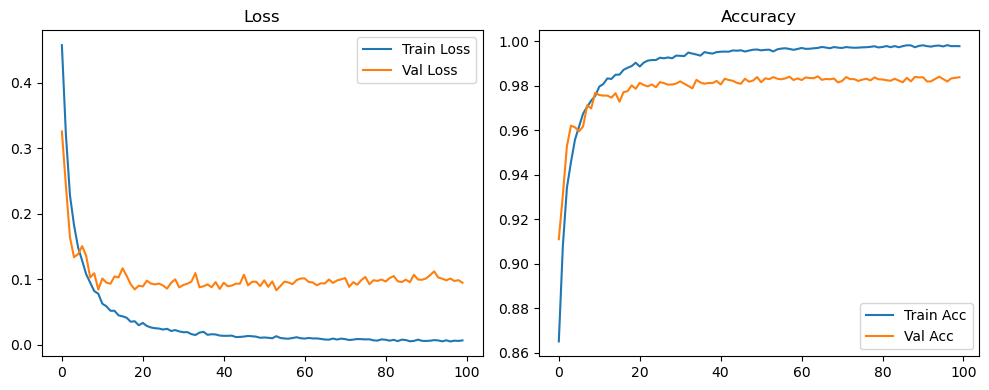

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.5866, Acc: 0.8254 | Val Loss: 0.3023, Acc: 0.9156


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.4330, Acc: 0.8768 | Val Loss: 0.2948, Acc: 0.9170


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.3366, Acc: 0.9031 | Val Loss: 0.1925, Acc: 0.9457


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.2672, Acc: 0.9234 | Val Loss: 0.1728, Acc: 0.9516


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.2272, Acc: 0.9340 | Val Loss: 0.1471, Acc: 0.9586


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1990, Acc: 0.9405 | Val Loss: 0.1402, Acc: 0.9594


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1724, Acc: 0.9499 | Val Loss: 0.1274, Acc: 0.9644


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1572, Acc: 0.9527 | Val Loss: 0.1160, Acc: 0.9680


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1440, Acc: 0.9565 | Val Loss: 0.0977, Acc: 0.9718


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1295, Acc: 0.9598 | Val Loss: 0.0965, Acc: 0.9723


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1203, Acc: 0.9625 | Val Loss: 0.0971, Acc: 0.9737


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1122, Acc: 0.9654 | Val Loss: 0.0865, Acc: 0.9749


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1010, Acc: 0.9674 | Val Loss: 0.0970, Acc: 0.9731


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0948, Acc: 0.9700 | Val Loss: 0.0875, Acc: 0.9747


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0902, Acc: 0.9717 | Val Loss: 0.0814, Acc: 0.9783


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0844, Acc: 0.9736 | Val Loss: 0.0880, Acc: 0.9766


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0842, Acc: 0.9734 | Val Loss: 0.0811, Acc: 0.9784


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0753, Acc: 0.9763 | Val Loss: 0.0852, Acc: 0.9775


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0761, Acc: 0.9760 | Val Loss: 0.0806, Acc: 0.9784


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0690, Acc: 0.9787 | Val Loss: 0.0757, Acc: 0.9784


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0688, Acc: 0.9779 | Val Loss: 0.0794, Acc: 0.9788


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0642, Acc: 0.9789 | Val Loss: 0.0725, Acc: 0.9802


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0594, Acc: 0.9813 | Val Loss: 0.0766, Acc: 0.9792


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0587, Acc: 0.9817 | Val Loss: 0.0727, Acc: 0.9800


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0541, Acc: 0.9824 | Val Loss: 0.0711, Acc: 0.9803


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0558, Acc: 0.9821 | Val Loss: 0.0699, Acc: 0.9812


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0537, Acc: 0.9829 | Val Loss: 0.0721, Acc: 0.9812


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0519, Acc: 0.9835 | Val Loss: 0.0690, Acc: 0.9822


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0494, Acc: 0.9838 | Val Loss: 0.0731, Acc: 0.9801


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0448, Acc: 0.9854 | Val Loss: 0.0714, Acc: 0.9819


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0464, Acc: 0.9849 | Val Loss: 0.0743, Acc: 0.9810


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0428, Acc: 0.9861 | Val Loss: 0.0724, Acc: 0.9817


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0441, Acc: 0.9858 | Val Loss: 0.0698, Acc: 0.9824


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0400, Acc: 0.9864 | Val Loss: 0.0744, Acc: 0.9812


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0420, Acc: 0.9858 | Val Loss: 0.0692, Acc: 0.9831


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0385, Acc: 0.9874 | Val Loss: 0.0709, Acc: 0.9828


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0409, Acc: 0.9870 | Val Loss: 0.0681, Acc: 0.9822


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0390, Acc: 0.9872 | Val Loss: 0.0779, Acc: 0.9812


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0371, Acc: 0.9880 | Val Loss: 0.0725, Acc: 0.9822


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0350, Acc: 0.9886 | Val Loss: 0.0670, Acc: 0.9824


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0350, Acc: 0.9891 | Val Loss: 0.0746, Acc: 0.9827


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0350, Acc: 0.9894 | Val Loss: 0.0692, Acc: 0.9830


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0329, Acc: 0.9896 | Val Loss: 0.0765, Acc: 0.9819


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0344, Acc: 0.9889 | Val Loss: 0.0751, Acc: 0.9817


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0318, Acc: 0.9898 | Val Loss: 0.0729, Acc: 0.9822


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0322, Acc: 0.9896 | Val Loss: 0.0824, Acc: 0.9810


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0322, Acc: 0.9898 | Val Loss: 0.0697, Acc: 0.9825


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0308, Acc: 0.9904 | Val Loss: 0.0716, Acc: 0.9834


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0297, Acc: 0.9897 | Val Loss: 0.0723, Acc: 0.9827


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0301, Acc: 0.9905 | Val Loss: 0.0737, Acc: 0.9828


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0276, Acc: 0.9916 | Val Loss: 0.0732, Acc: 0.9833


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0295, Acc: 0.9905 | Val Loss: 0.0734, Acc: 0.9822


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9909 | Val Loss: 0.0730, Acc: 0.9828


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0282, Acc: 0.9909 | Val Loss: 0.0787, Acc: 0.9826


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0247, Acc: 0.9918 | Val Loss: 0.0756, Acc: 0.9825


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0274, Acc: 0.9909 | Val Loss: 0.0736, Acc: 0.9825


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9917 | Val Loss: 0.0681, Acc: 0.9843


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9914 | Val Loss: 0.0649, Acc: 0.9848


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0244, Acc: 0.9917 | Val Loss: 0.0725, Acc: 0.9828


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0243, Acc: 0.9917 | Val Loss: 0.0745, Acc: 0.9844


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9919 | Val Loss: 0.0742, Acc: 0.9825


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9925 | Val Loss: 0.0720, Acc: 0.9845


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0233, Acc: 0.9926 | Val Loss: 0.0741, Acc: 0.9835


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9926 | Val Loss: 0.0744, Acc: 0.9842


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0232, Acc: 0.9928 | Val Loss: 0.0685, Acc: 0.9845


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0221, Acc: 0.9925 | Val Loss: 0.0739, Acc: 0.9842


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9926 | Val Loss: 0.0711, Acc: 0.9847


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0208, Acc: 0.9934 | Val Loss: 0.0808, Acc: 0.9828


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0238, Acc: 0.9923 | Val Loss: 0.0777, Acc: 0.9838


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0242, Acc: 0.9925 | Val Loss: 0.0713, Acc: 0.9844


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9935 | Val Loss: 0.0774, Acc: 0.9834


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9931 | Val Loss: 0.0871, Acc: 0.9838


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0223, Acc: 0.9933 | Val Loss: 0.0749, Acc: 0.9832


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0233, Acc: 0.9925 | Val Loss: 0.0734, Acc: 0.9841


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9931 | Val Loss: 0.0732, Acc: 0.9849


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9937 | Val Loss: 0.0711, Acc: 0.9848


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0211, Acc: 0.9933 | Val Loss: 0.0776, Acc: 0.9834


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9941 | Val Loss: 0.0711, Acc: 0.9842


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9936 | Val Loss: 0.0690, Acc: 0.9841


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0200, Acc: 0.9937 | Val Loss: 0.0718, Acc: 0.9842


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9934 | Val Loss: 0.0714, Acc: 0.9842


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9944 | Val Loss: 0.0727, Acc: 0.9849


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9940 | Val Loss: 0.0723, Acc: 0.9847


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9939 | Val Loss: 0.0743, Acc: 0.9839


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0188, Acc: 0.9941 | Val Loss: 0.0752, Acc: 0.9833


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9942 | Val Loss: 0.0719, Acc: 0.9843


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9942 | Val Loss: 0.0737, Acc: 0.9840


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9946 | Val Loss: 0.0706, Acc: 0.9845


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9946 | Val Loss: 0.0809, Acc: 0.9837


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0185, Acc: 0.9943 | Val Loss: 0.0697, Acc: 0.9852


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9948 | Val Loss: 0.0800, Acc: 0.9846


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9951 | Val Loss: 0.0782, Acc: 0.9839


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9941 | Val Loss: 0.0802, Acc: 0.9840


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0170, Acc: 0.9946 | Val Loss: 0.0846, Acc: 0.9836


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0203, Acc: 0.9941 | Val Loss: 0.0773, Acc: 0.9841


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9943 | Val Loss: 0.0736, Acc: 0.9841


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9952 | Val Loss: 0.0751, Acc: 0.9837


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9955 | Val Loss: 0.0804, Acc: 0.9837


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9945 | Val Loss: 0.0764, Acc: 0.9848


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9951 | Val Loss: 0.0746, Acc: 0.9842


Final Test Loss: 0.0717 Accuracy: 0.9855


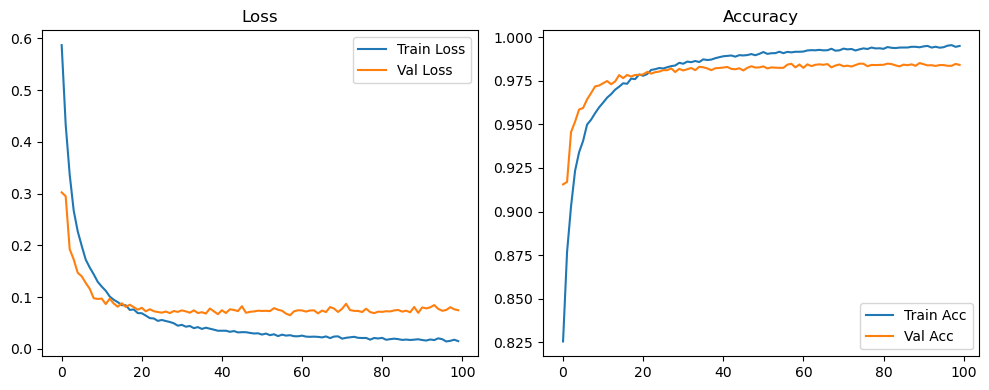

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4167, Acc: 0.8764 | Val Loss: 0.2935, Acc: 0.9188


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2523, Acc: 0.9274 | Val Loss: 0.2216, Acc: 0.9361


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1674, Acc: 0.9502 | Val Loss: 0.1345, Acc: 0.9591


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1226, Acc: 0.9634 | Val Loss: 0.1255, Acc: 0.9629


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1046, Acc: 0.9687 | Val Loss: 0.1295, Acc: 0.9639


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0846, Acc: 0.9736 | Val Loss: 0.1316, Acc: 0.9654


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0702, Acc: 0.9789 | Val Loss: 0.1392, Acc: 0.9637


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0593, Acc: 0.9819 | Val Loss: 0.1200, Acc: 0.9692


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0520, Acc: 0.9839 | Val Loss: 0.1151, Acc: 0.9738


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0463, Acc: 0.9851 | Val Loss: 0.1118, Acc: 0.9736


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0414, Acc: 0.9878 | Val Loss: 0.1204, Acc: 0.9719


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0330, Acc: 0.9890 | Val Loss: 0.1187, Acc: 0.9747


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0316, Acc: 0.9899 | Val Loss: 0.1248, Acc: 0.9722


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9904 | Val Loss: 0.1096, Acc: 0.9762


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9918 | Val Loss: 0.1068, Acc: 0.9764


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0227, Acc: 0.9923 | Val Loss: 0.1401, Acc: 0.9711


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0281, Acc: 0.9911 | Val Loss: 0.1133, Acc: 0.9777


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9938 | Val Loss: 0.1462, Acc: 0.9722


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9937 | Val Loss: 0.1093, Acc: 0.9783


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9948 | Val Loss: 0.1132, Acc: 0.9783


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9944 | Val Loss: 0.0977, Acc: 0.9810


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9954 | Val Loss: 0.1135, Acc: 0.9791


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9952 | Val Loss: 0.0965, Acc: 0.9802


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9954 | Val Loss: 0.0996, Acc: 0.9801


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0170, Acc: 0.9949 | Val Loss: 0.0976, Acc: 0.9800


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.0939, Acc: 0.9798


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9963 | Val Loss: 0.0937, Acc: 0.9814


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.0975, Acc: 0.9812


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.1037, Acc: 0.9794


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 0.1092, Acc: 0.9785


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9961 | Val Loss: 0.0961, Acc: 0.9805


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9965 | Val Loss: 0.1013, Acc: 0.9802


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.0972, Acc: 0.9819


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.1194, Acc: 0.9789


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1042, Acc: 0.9789


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.1105, Acc: 0.9804


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9977 | Val Loss: 0.0955, Acc: 0.9819


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1104, Acc: 0.9808


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9975 | Val Loss: 0.1025, Acc: 0.9808


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.1125, Acc: 0.9792


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.1181, Acc: 0.9793


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.1166, Acc: 0.9790


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.1025, Acc: 0.9820


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1013, Acc: 0.9807


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.1355, Acc: 0.9785


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9975 | Val Loss: 0.1333, Acc: 0.9772


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1008, Acc: 0.9812


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9978 | Val Loss: 0.1005, Acc: 0.9807


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.0980, Acc: 0.9813


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.0958, Acc: 0.9806


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0859, Acc: 0.9833


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0838, Acc: 0.9839


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0855, Acc: 0.9842


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0855, Acc: 0.9849


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0795, Acc: 0.9858


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0959, Acc: 0.9838


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0943, Acc: 0.9849


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0976, Acc: 0.9848


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0938, Acc: 0.9848


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0995, Acc: 0.9842


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1023, Acc: 0.9845


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0981, Acc: 0.9848


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1055, Acc: 0.9838


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1050, Acc: 0.9845


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1025, Acc: 0.9845


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0984, Acc: 0.9847


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1064, Acc: 0.9826


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1075, Acc: 0.9841


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1018, Acc: 0.9840


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1075, Acc: 0.9832


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1137, Acc: 0.9833


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1042, Acc: 0.9852


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1058, Acc: 0.9845


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1124, Acc: 0.9825


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1056, Acc: 0.9841


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1009, Acc: 0.9843


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1014, Acc: 0.9853


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1038, Acc: 0.9843


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1083, Acc: 0.9834


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1024, Acc: 0.9844


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1003, Acc: 0.9842


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1061, Acc: 0.9847


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1032, Acc: 0.9852


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0976, Acc: 0.9859


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1010, Acc: 0.9855


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1023, Acc: 0.9854


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1055, Acc: 0.9849


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1007, Acc: 0.9850


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1001, Acc: 0.9855


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1016, Acc: 0.9838


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0998, Acc: 0.9849


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1041, Acc: 0.9851


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1107, Acc: 0.9840


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1071, Acc: 0.9842


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1091, Acc: 0.9848


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1086, Acc: 0.9850


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1111, Acc: 0.9850


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1127, Acc: 0.9846


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1111, Acc: 0.9842


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1132, Acc: 0.9844


Final Test Loss: 0.1126 Accuracy: 0.9845


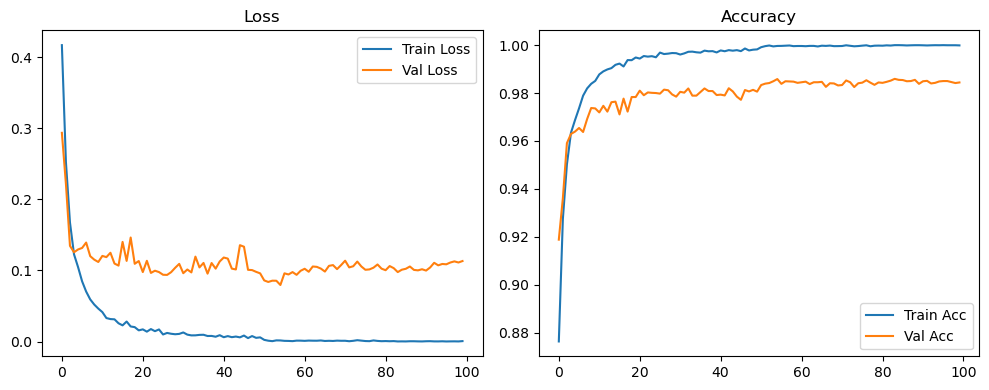

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4570, Acc: 0.8651 | Val Loss: 0.3253, Acc: 0.9111


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.3201, Acc: 0.9081 | Val Loss: 0.2422, Acc: 0.9310


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2278, Acc: 0.9342 | Val Loss: 0.1640, Acc: 0.9529


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1827, Acc: 0.9457 | Val Loss: 0.1336, Acc: 0.9622


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1488, Acc: 0.9559 | Val Loss: 0.1384, Acc: 0.9614


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1287, Acc: 0.9617 | Val Loss: 0.1506, Acc: 0.9596


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1078, Acc: 0.9676 | Val Loss: 0.1359, Acc: 0.9618


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0949, Acc: 0.9706 | Val Loss: 0.1029, Acc: 0.9712


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0821, Acc: 0.9734 | Val Loss: 0.1092, Acc: 0.9699


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0780, Acc: 0.9755 | Val Loss: 0.0844, Acc: 0.9770


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0628, Acc: 0.9797 | Val Loss: 0.1012, Acc: 0.9759


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0589, Acc: 0.9809 | Val Loss: 0.0950, Acc: 0.9757


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0521, Acc: 0.9834 | Val Loss: 0.0932, Acc: 0.9757


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0520, Acc: 0.9832 | Val Loss: 0.1044, Acc: 0.9748


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0451, Acc: 0.9850 | Val Loss: 0.1029, Acc: 0.9768


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0435, Acc: 0.9851 | Val Loss: 0.1169, Acc: 0.9729


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0415, Acc: 0.9872 | Val Loss: 0.1053, Acc: 0.9772


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0353, Acc: 0.9882 | Val Loss: 0.0926, Acc: 0.9777


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0361, Acc: 0.9889 | Val Loss: 0.0846, Acc: 0.9802


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0300, Acc: 0.9905 | Val Loss: 0.0903, Acc: 0.9788


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0335, Acc: 0.9887 | Val Loss: 0.0891, Acc: 0.9814


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0288, Acc: 0.9905 | Val Loss: 0.0979, Acc: 0.9804


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9914 | Val Loss: 0.0935, Acc: 0.9798


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9916 | Val Loss: 0.0922, Acc: 0.9807


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0249, Acc: 0.9917 | Val Loss: 0.0935, Acc: 0.9794


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0234, Acc: 0.9927 | Val Loss: 0.0905, Acc: 0.9818


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9924 | Val Loss: 0.0858, Acc: 0.9812


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9928 | Val Loss: 0.0946, Acc: 0.9806


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0226, Acc: 0.9924 | Val Loss: 0.1000, Acc: 0.9807


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0206, Acc: 0.9936 | Val Loss: 0.0877, Acc: 0.9811


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9936 | Val Loss: 0.0913, Acc: 0.9821


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9934 | Val Loss: 0.0933, Acc: 0.9810


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9950 | Val Loss: 0.0965, Acc: 0.9800


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9946 | Val Loss: 0.1094, Acc: 0.9789


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9941 | Val Loss: 0.0878, Acc: 0.9828


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0200, Acc: 0.9936 | Val Loss: 0.0894, Acc: 0.9816


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9952 | Val Loss: 0.0922, Acc: 0.9810


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9948 | Val Loss: 0.0879, Acc: 0.9813


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9946 | Val Loss: 0.0958, Acc: 0.9813


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9952 | Val Loss: 0.0853, Acc: 0.9822


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9954 | Val Loss: 0.0948, Acc: 0.9807


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9955 | Val Loss: 0.0894, Acc: 0.9832


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9954 | Val Loss: 0.0905, Acc: 0.9827


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.0934, Acc: 0.9823


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9959 | Val Loss: 0.0932, Acc: 0.9814


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.1070, Acc: 0.9810


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.0908, Acc: 0.9832


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9959 | Val Loss: 0.0962, Acc: 0.9819


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9963 | Val Loss: 0.0964, Acc: 0.9824


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.0896, Acc: 0.9840


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.0852, Acc: 0.9843


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0832, Acc: 0.9846


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0835, Acc: 0.9844


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.0853, Acc: 0.9845


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.0869, Acc: 0.9851


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0825, Acc: 0.9858


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0835, Acc: 0.9858


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.0881, Acc: 0.9862


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0887, Acc: 0.9852


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.0896, Acc: 0.9849


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9984 | Val Loss: 0.0879, Acc: 0.9857


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.0947, Acc: 0.9839


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0965, Acc: 0.9848


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0905, Acc: 0.9851


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0898, Acc: 0.9855


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0879, Acc: 0.9857


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0928, Acc: 0.9846


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0981, Acc: 0.9845


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0975, Acc: 0.9845


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0994, Acc: 0.9849


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0964, Acc: 0.9847


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1027, Acc: 0.9847


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0997, Acc: 0.9834


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0887, Acc: 0.9852


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0969, Acc: 0.9855


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0984, Acc: 0.9842


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0933, Acc: 0.9850


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.0941, Acc: 0.9851


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0977, Acc: 0.9851


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0988, Acc: 0.9843


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0965, Acc: 0.9854


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0951, Acc: 0.9857


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0926, Acc: 0.9861


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0948, Acc: 0.9860


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0973, Acc: 0.9852


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0951, Acc: 0.9853


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0971, Acc: 0.9856


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0967, Acc: 0.9844


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1020, Acc: 0.9853


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0984, Acc: 0.9855


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0935, Acc: 0.9858


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0977, Acc: 0.9853


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9994 | Val Loss: 0.1006, Acc: 0.9857


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1024, Acc: 0.9847


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1006, Acc: 0.9855


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1073, Acc: 0.9850


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1039, Acc: 0.9854


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1036, Acc: 0.9853


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1005, Acc: 0.9860


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1058, Acc: 0.9848


Final Test Loss: 0.0916 Accuracy: 0.9854


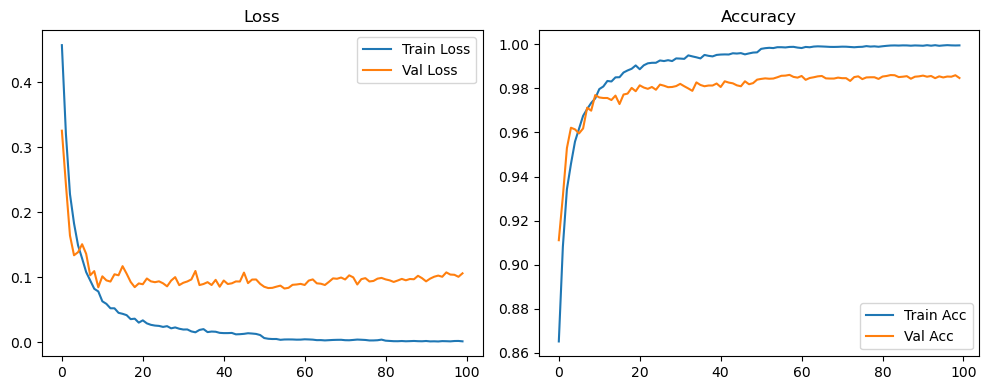

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.5866, Acc: 0.8254 | Val Loss: 0.3023, Acc: 0.9156


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.4330, Acc: 0.8768 | Val Loss: 0.2948, Acc: 0.9170


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.3366, Acc: 0.9031 | Val Loss: 0.1925, Acc: 0.9457


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.2672, Acc: 0.9234 | Val Loss: 0.1728, Acc: 0.9516


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.2272, Acc: 0.9340 | Val Loss: 0.1471, Acc: 0.9586


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1990, Acc: 0.9405 | Val Loss: 0.1402, Acc: 0.9594


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1724, Acc: 0.9499 | Val Loss: 0.1274, Acc: 0.9644


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1572, Acc: 0.9527 | Val Loss: 0.1160, Acc: 0.9680


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1440, Acc: 0.9565 | Val Loss: 0.0977, Acc: 0.9718


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1295, Acc: 0.9598 | Val Loss: 0.0965, Acc: 0.9723


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1203, Acc: 0.9625 | Val Loss: 0.0971, Acc: 0.9737


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1122, Acc: 0.9654 | Val Loss: 0.0865, Acc: 0.9749


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1010, Acc: 0.9674 | Val Loss: 0.0970, Acc: 0.9731


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0948, Acc: 0.9700 | Val Loss: 0.0875, Acc: 0.9747


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0902, Acc: 0.9717 | Val Loss: 0.0814, Acc: 0.9783


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0844, Acc: 0.9736 | Val Loss: 0.0880, Acc: 0.9766


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0842, Acc: 0.9734 | Val Loss: 0.0811, Acc: 0.9784


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0753, Acc: 0.9763 | Val Loss: 0.0852, Acc: 0.9775


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0761, Acc: 0.9760 | Val Loss: 0.0806, Acc: 0.9784


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0690, Acc: 0.9787 | Val Loss: 0.0757, Acc: 0.9784


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0688, Acc: 0.9779 | Val Loss: 0.0794, Acc: 0.9788


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0642, Acc: 0.9789 | Val Loss: 0.0725, Acc: 0.9802


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0594, Acc: 0.9813 | Val Loss: 0.0766, Acc: 0.9792


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0587, Acc: 0.9817 | Val Loss: 0.0727, Acc: 0.9800


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0541, Acc: 0.9824 | Val Loss: 0.0711, Acc: 0.9803


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0558, Acc: 0.9821 | Val Loss: 0.0699, Acc: 0.9812


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0537, Acc: 0.9829 | Val Loss: 0.0721, Acc: 0.9812


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0519, Acc: 0.9835 | Val Loss: 0.0690, Acc: 0.9822


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0494, Acc: 0.9838 | Val Loss: 0.0731, Acc: 0.9801


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0448, Acc: 0.9854 | Val Loss: 0.0714, Acc: 0.9819


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0464, Acc: 0.9849 | Val Loss: 0.0743, Acc: 0.9810


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0428, Acc: 0.9861 | Val Loss: 0.0724, Acc: 0.9817


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0441, Acc: 0.9858 | Val Loss: 0.0698, Acc: 0.9824


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0400, Acc: 0.9864 | Val Loss: 0.0744, Acc: 0.9812


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0420, Acc: 0.9858 | Val Loss: 0.0692, Acc: 0.9831


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0385, Acc: 0.9874 | Val Loss: 0.0709, Acc: 0.9828


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0409, Acc: 0.9870 | Val Loss: 0.0681, Acc: 0.9822


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0390, Acc: 0.9872 | Val Loss: 0.0779, Acc: 0.9812


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0371, Acc: 0.9880 | Val Loss: 0.0725, Acc: 0.9822


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0350, Acc: 0.9886 | Val Loss: 0.0670, Acc: 0.9824


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0350, Acc: 0.9891 | Val Loss: 0.0746, Acc: 0.9827


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0350, Acc: 0.9894 | Val Loss: 0.0692, Acc: 0.9830


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0329, Acc: 0.9896 | Val Loss: 0.0765, Acc: 0.9819


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0344, Acc: 0.9889 | Val Loss: 0.0751, Acc: 0.9817


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0318, Acc: 0.9898 | Val Loss: 0.0729, Acc: 0.9822


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0322, Acc: 0.9896 | Val Loss: 0.0824, Acc: 0.9810


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0322, Acc: 0.9898 | Val Loss: 0.0697, Acc: 0.9825


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0308, Acc: 0.9904 | Val Loss: 0.0716, Acc: 0.9834


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0297, Acc: 0.9897 | Val Loss: 0.0723, Acc: 0.9827


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0301, Acc: 0.9905 | Val Loss: 0.0737, Acc: 0.9828


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0223, Acc: 0.9928 | Val Loss: 0.0698, Acc: 0.9837


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0201, Acc: 0.9931 | Val Loss: 0.0685, Acc: 0.9842


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0180, Acc: 0.9939 | Val Loss: 0.0697, Acc: 0.9847


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0178, Acc: 0.9945 | Val Loss: 0.0726, Acc: 0.9842


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0148, Acc: 0.9951 | Val Loss: 0.0708, Acc: 0.9847


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9944 | Val Loss: 0.0693, Acc: 0.9846


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0156, Acc: 0.9950 | Val Loss: 0.0693, Acc: 0.9847


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0156, Acc: 0.9946 | Val Loss: 0.0667, Acc: 0.9852


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9953 | Val Loss: 0.0704, Acc: 0.9844


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9957 | Val Loss: 0.0724, Acc: 0.9840


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0136, Acc: 0.9955 | Val Loss: 0.0742, Acc: 0.9839


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0131, Acc: 0.9959 | Val Loss: 0.0732, Acc: 0.9847


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.0759, Acc: 0.9847


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9959 | Val Loss: 0.0747, Acc: 0.9852


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0128, Acc: 0.9955 | Val Loss: 0.0738, Acc: 0.9850


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9959 | Val Loss: 0.0771, Acc: 0.9847


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.0749, Acc: 0.9851


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9962 | Val Loss: 0.0784, Acc: 0.9854


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9961 | Val Loss: 0.0767, Acc: 0.9849


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.0752, Acc: 0.9852


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9966 | Val Loss: 0.0746, Acc: 0.9852


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9968 | Val Loss: 0.0813, Acc: 0.9858


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9962 | Val Loss: 0.0752, Acc: 0.9844


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.0739, Acc: 0.9846


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9964 | Val Loss: 0.0721, Acc: 0.9851


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9962 | Val Loss: 0.0737, Acc: 0.9856


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9964 | Val Loss: 0.0752, Acc: 0.9854


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.0749, Acc: 0.9851


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.0715, Acc: 0.9853


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.0736, Acc: 0.9852


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9967 | Val Loss: 0.0710, Acc: 0.9858


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9968 | Val Loss: 0.0726, Acc: 0.9853


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.0743, Acc: 0.9857


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9974 | Val Loss: 0.0725, Acc: 0.9855


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.0733, Acc: 0.9850


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.0715, Acc: 0.9853


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.0751, Acc: 0.9853


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.0713, Acc: 0.9857


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.0779, Acc: 0.9851


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.0755, Acc: 0.9858


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.0741, Acc: 0.9857


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0746, Acc: 0.9858


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9975 | Val Loss: 0.0762, Acc: 0.9862


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.0796, Acc: 0.9852


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9975 | Val Loss: 0.0781, Acc: 0.9858


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0744, Acc: 0.9859


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.0744, Acc: 0.9848


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.0749, Acc: 0.9859


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.0769, Acc: 0.9851


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.0767, Acc: 0.9849


Final Test Loss: 0.0741 Accuracy: 0.9859


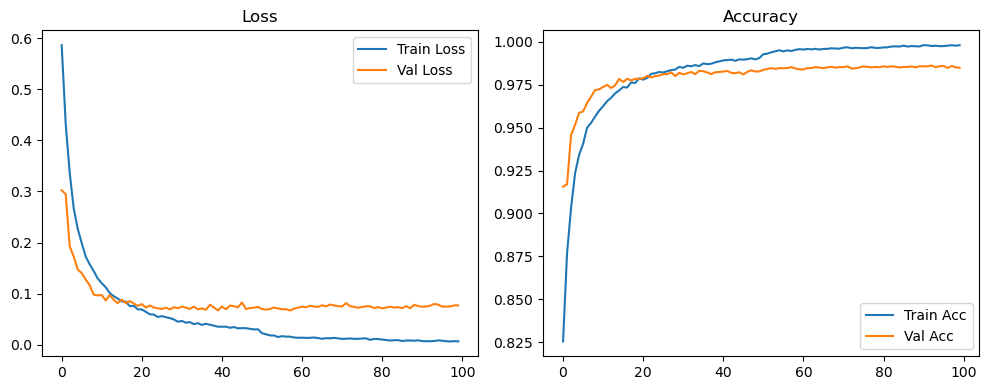

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.3736, Acc: 0.8885 | Val Loss: 0.2850, Acc: 0.9163


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.2524, Acc: 0.9242 | Val Loss: 0.2404, Acc: 0.9268


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1845, Acc: 0.9441 | Val Loss: 0.1562, Acc: 0.9546


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1390, Acc: 0.9573 | Val Loss: 0.1376, Acc: 0.9591


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1183, Acc: 0.9640 | Val Loss: 0.1315, Acc: 0.9625


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0969, Acc: 0.9690 | Val Loss: 0.1544, Acc: 0.9558


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0808, Acc: 0.9748 | Val Loss: 0.1619, Acc: 0.9555


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0683, Acc: 0.9784 | Val Loss: 0.1287, Acc: 0.9661


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0658, Acc: 0.9788 | Val Loss: 0.1152, Acc: 0.9704


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0524, Acc: 0.9821 | Val Loss: 0.1034, Acc: 0.9754


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0492, Acc: 0.9843 | Val Loss: 0.1199, Acc: 0.9713


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0427, Acc: 0.9857 | Val Loss: 0.1192, Acc: 0.9729


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0367, Acc: 0.9878 | Val Loss: 0.1516, Acc: 0.9667


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0361, Acc: 0.9885 | Val Loss: 0.1222, Acc: 0.9723


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0384, Acc: 0.9884 | Val Loss: 0.1215, Acc: 0.9744


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0317, Acc: 0.9898 | Val Loss: 0.1197, Acc: 0.9757


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0280, Acc: 0.9911 | Val Loss: 0.1367, Acc: 0.9721


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0254, Acc: 0.9914 | Val Loss: 0.1280, Acc: 0.9742


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0282, Acc: 0.9908 | Val Loss: 0.1074, Acc: 0.9791


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0261, Acc: 0.9920 | Val Loss: 0.1444, Acc: 0.9739


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0239, Acc: 0.9926 | Val Loss: 0.1506, Acc: 0.9723


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0223, Acc: 0.9932 | Val Loss: 0.1443, Acc: 0.9731


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0206, Acc: 0.9937 | Val Loss: 0.1349, Acc: 0.9780


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0164, Acc: 0.9946 | Val Loss: 0.1535, Acc: 0.9767


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0224, Acc: 0.9937 | Val Loss: 0.1274, Acc: 0.9758


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0163, Acc: 0.9951 | Val Loss: 0.1318, Acc: 0.9778


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0208, Acc: 0.9938 | Val Loss: 0.1398, Acc: 0.9769


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9945 | Val Loss: 0.1656, Acc: 0.9752


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0158, Acc: 0.9948 | Val Loss: 0.1489, Acc: 0.9775


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0162, Acc: 0.9951 | Val Loss: 0.1570, Acc: 0.9768


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0189, Acc: 0.9946 | Val Loss: 0.1372, Acc: 0.9789


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9964 | Val Loss: 0.1427, Acc: 0.9787


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0146, Acc: 0.9952 | Val Loss: 0.1564, Acc: 0.9771


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9964 | Val Loss: 0.1384, Acc: 0.9792


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0131, Acc: 0.9959 | Val Loss: 0.1412, Acc: 0.9796


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9958 | Val Loss: 0.1432, Acc: 0.9787


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0152, Acc: 0.9954 | Val Loss: 0.1305, Acc: 0.9789


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9959 | Val Loss: 0.1446, Acc: 0.9783


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.1501, Acc: 0.9768


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9966 | Val Loss: 0.1246, Acc: 0.9806


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9964 | Val Loss: 0.1518, Acc: 0.9784


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9964 | Val Loss: 0.1377, Acc: 0.9787


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.1543, Acc: 0.9786


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9966 | Val Loss: 0.1545, Acc: 0.9780


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9970 | Val Loss: 0.1669, Acc: 0.9767


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9979 | Val Loss: 0.1580, Acc: 0.9792


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9970 | Val Loss: 0.1597, Acc: 0.9789


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9968 | Val Loss: 0.1517, Acc: 0.9787


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9978 | Val Loss: 0.1364, Acc: 0.9806


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.1376, Acc: 0.9809


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.1564, Acc: 0.9783


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9973 | Val Loss: 0.1648, Acc: 0.9799


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9970 | Val Loss: 0.1713, Acc: 0.9779


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.1609, Acc: 0.9793


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9981 | Val Loss: 0.1466, Acc: 0.9811


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.1576, Acc: 0.9798


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9971 | Val Loss: 0.1476, Acc: 0.9811


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.1330, Acc: 0.9814


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9976 | Val Loss: 0.1445, Acc: 0.9809


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9976 | Val Loss: 0.1493, Acc: 0.9798


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.1564, Acc: 0.9800


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9978 | Val Loss: 0.1470, Acc: 0.9802


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.1366, Acc: 0.9814


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9983 | Val Loss: 0.1432, Acc: 0.9820


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1543, Acc: 0.9792


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9975 | Val Loss: 0.1360, Acc: 0.9808


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.1373, Acc: 0.9820


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1460, Acc: 0.9822


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9977 | Val Loss: 0.1786, Acc: 0.9785


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.1625, Acc: 0.9791


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.1437, Acc: 0.9807


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1598, Acc: 0.9808


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1479, Acc: 0.9798


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1554, Acc: 0.9792


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9984 | Val Loss: 0.1586, Acc: 0.9812


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1720, Acc: 0.9788


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9977 | Val Loss: 0.1488, Acc: 0.9824


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.1538, Acc: 0.9816


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.1562, Acc: 0.9804


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1772, Acc: 0.9778


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.1552, Acc: 0.9818


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1616, Acc: 0.9804


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1742, Acc: 0.9795


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.1514, Acc: 0.9811


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1537, Acc: 0.9818


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.1625, Acc: 0.9800


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9987 | Val Loss: 0.1473, Acc: 0.9816


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1688, Acc: 0.9793


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.1561, Acc: 0.9812


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.1526, Acc: 0.9808


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9989 | Val Loss: 0.1398, Acc: 0.9822


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1498, Acc: 0.9808


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1590, Acc: 0.9799


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1607, Acc: 0.9792


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1675, Acc: 0.9791


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9982 | Val Loss: 0.1359, Acc: 0.9806


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9990 | Val Loss: 0.1527, Acc: 0.9798


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1455, Acc: 0.9815


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1689, Acc: 0.9786


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1494, Acc: 0.9820


Final Test Loss: 0.1526 Accuracy: 0.9812


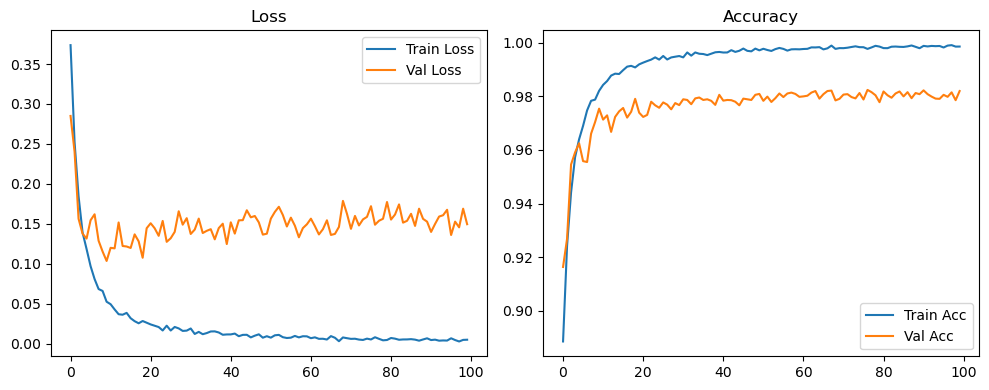

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.4165, Acc: 0.8748 | Val Loss: 0.3036, Acc: 0.9137


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.3158, Acc: 0.9037 | Val Loss: 0.2435, Acc: 0.9283


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.2528, Acc: 0.9247 | Val Loss: 0.1893, Acc: 0.9441


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.2047, Acc: 0.9383 | Val Loss: 0.1604, Acc: 0.9547


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1764, Acc: 0.9464 | Val Loss: 0.1734, Acc: 0.9517


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.1525, Acc: 0.9530 | Val Loss: 0.1437, Acc: 0.9594


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.1291, Acc: 0.9604 | Val Loss: 0.1469, Acc: 0.9583


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.1159, Acc: 0.9637 | Val Loss: 0.1217, Acc: 0.9674


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.1025, Acc: 0.9675 | Val Loss: 0.1162, Acc: 0.9696


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0912, Acc: 0.9709 | Val Loss: 0.0969, Acc: 0.9729


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0847, Acc: 0.9736 | Val Loss: 0.1052, Acc: 0.9722


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0793, Acc: 0.9741 | Val Loss: 0.1224, Acc: 0.9701


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0674, Acc: 0.9786 | Val Loss: 0.1055, Acc: 0.9739


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0643, Acc: 0.9797 | Val Loss: 0.0992, Acc: 0.9753


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0595, Acc: 0.9811 | Val Loss: 0.1064, Acc: 0.9762


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0559, Acc: 0.9821 | Val Loss: 0.1209, Acc: 0.9712


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0508, Acc: 0.9830 | Val Loss: 0.1119, Acc: 0.9742


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0485, Acc: 0.9846 | Val Loss: 0.1099, Acc: 0.9746


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0461, Acc: 0.9847 | Val Loss: 0.1026, Acc: 0.9762


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0431, Acc: 0.9861 | Val Loss: 0.1098, Acc: 0.9758


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0447, Acc: 0.9858 | Val Loss: 0.1107, Acc: 0.9758


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0381, Acc: 0.9875 | Val Loss: 0.1155, Acc: 0.9761


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0354, Acc: 0.9887 | Val Loss: 0.1095, Acc: 0.9780


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0354, Acc: 0.9890 | Val Loss: 0.1107, Acc: 0.9782


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0337, Acc: 0.9891 | Val Loss: 0.0969, Acc: 0.9796


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0308, Acc: 0.9905 | Val Loss: 0.1050, Acc: 0.9780


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0348, Acc: 0.9892 | Val Loss: 0.1094, Acc: 0.9789


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0290, Acc: 0.9904 | Val Loss: 0.1150, Acc: 0.9777


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0298, Acc: 0.9905 | Val Loss: 0.1065, Acc: 0.9797


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0247, Acc: 0.9918 | Val Loss: 0.1181, Acc: 0.9790


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0301, Acc: 0.9908 | Val Loss: 0.1177, Acc: 0.9785


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0231, Acc: 0.9927 | Val Loss: 0.1205, Acc: 0.9788


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0250, Acc: 0.9918 | Val Loss: 0.1236, Acc: 0.9777


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0235, Acc: 0.9926 | Val Loss: 0.1152, Acc: 0.9798


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0240, Acc: 0.9926 | Val Loss: 0.1196, Acc: 0.9783


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0219, Acc: 0.9926 | Val Loss: 0.1225, Acc: 0.9784


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0243, Acc: 0.9924 | Val Loss: 0.1093, Acc: 0.9812


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0211, Acc: 0.9936 | Val Loss: 0.1118, Acc: 0.9797


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0228, Acc: 0.9928 | Val Loss: 0.1259, Acc: 0.9782


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0193, Acc: 0.9935 | Val Loss: 0.1088, Acc: 0.9802


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0192, Acc: 0.9942 | Val Loss: 0.1083, Acc: 0.9812


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0183, Acc: 0.9946 | Val Loss: 0.1180, Acc: 0.9800


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0204, Acc: 0.9935 | Val Loss: 0.1082, Acc: 0.9808


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9946 | Val Loss: 0.1181, Acc: 0.9804


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0188, Acc: 0.9941 | Val Loss: 0.1114, Acc: 0.9822


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0189, Acc: 0.9944 | Val Loss: 0.1127, Acc: 0.9808


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0186, Acc: 0.9940 | Val Loss: 0.1138, Acc: 0.9801


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0157, Acc: 0.9950 | Val Loss: 0.1227, Acc: 0.9798


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9954 | Val Loss: 0.1120, Acc: 0.9806


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0162, Acc: 0.9949 | Val Loss: 0.1219, Acc: 0.9798


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0143, Acc: 0.9953 | Val Loss: 0.1136, Acc: 0.9808


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9949 | Val Loss: 0.1198, Acc: 0.9825


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0147, Acc: 0.9955 | Val Loss: 0.1148, Acc: 0.9814


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0147, Acc: 0.9955 | Val Loss: 0.1297, Acc: 0.9805


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9956 | Val Loss: 0.1223, Acc: 0.9807


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0164, Acc: 0.9952 | Val Loss: 0.1192, Acc: 0.9798


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9958 | Val Loss: 0.1356, Acc: 0.9798


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9960 | Val Loss: 0.1221, Acc: 0.9813


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0174, Acc: 0.9949 | Val Loss: 0.1261, Acc: 0.9817


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0128, Acc: 0.9962 | Val Loss: 0.1287, Acc: 0.9808


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.1257, Acc: 0.9808


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9959 | Val Loss: 0.1122, Acc: 0.9828


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9959 | Val Loss: 0.1183, Acc: 0.9814


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9963 | Val Loss: 0.1144, Acc: 0.9822


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.1206, Acc: 0.9815


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9961 | Val Loss: 0.1168, Acc: 0.9814


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.1194, Acc: 0.9815


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9966 | Val Loss: 0.1100, Acc: 0.9831


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9967 | Val Loss: 0.1225, Acc: 0.9829


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9965 | Val Loss: 0.1280, Acc: 0.9809


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9969 | Val Loss: 0.1259, Acc: 0.9819


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9969 | Val Loss: 0.1243, Acc: 0.9825


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9968 | Val Loss: 0.1379, Acc: 0.9805


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9971 | Val Loss: 0.1330, Acc: 0.9819


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.1227, Acc: 0.9816


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9968 | Val Loss: 0.1266, Acc: 0.9816


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9967 | Val Loss: 0.1183, Acc: 0.9824


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9972 | Val Loss: 0.1155, Acc: 0.9827


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9969 | Val Loss: 0.1329, Acc: 0.9811


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.1269, Acc: 0.9817


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9964 | Val Loss: 0.1200, Acc: 0.9822


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.1138, Acc: 0.9828


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1172, Acc: 0.9823


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9973 | Val Loss: 0.1155, Acc: 0.9827


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.1107, Acc: 0.9832


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.1197, Acc: 0.9830


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9973 | Val Loss: 0.1288, Acc: 0.9818


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9979 | Val Loss: 0.1213, Acc: 0.9830


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9969 | Val Loss: 0.1364, Acc: 0.9807


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.1138, Acc: 0.9826


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.1249, Acc: 0.9812


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9977 | Val Loss: 0.1129, Acc: 0.9829


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1247, Acc: 0.9822


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1167, Acc: 0.9825


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.1292, Acc: 0.9827


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9975 | Val Loss: 0.1169, Acc: 0.9827


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.1185, Acc: 0.9835


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.1175, Acc: 0.9832


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9973 | Val Loss: 0.1220, Acc: 0.9826


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9983 | Val Loss: 0.1176, Acc: 0.9823


Final Test Loss: 0.0968 Accuracy: 0.9850


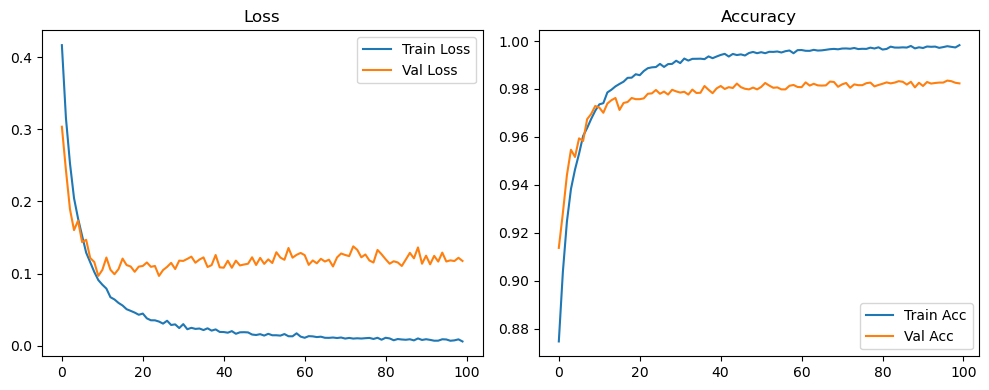

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.5468, Acc: 0.8334 | Val Loss: 0.3190, Acc: 0.9105


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.4101, Acc: 0.8751 | Val Loss: 0.2807, Acc: 0.9164


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.3557, Acc: 0.8934 | Val Loss: 0.2271, Acc: 0.9337


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.3040, Acc: 0.9090 | Val Loss: 0.2090, Acc: 0.9392


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.2714, Acc: 0.9205 | Val Loss: 0.1856, Acc: 0.9471


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.2421, Acc: 0.9265 | Val Loss: 0.1801, Acc: 0.9469


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.2078, Acc: 0.9376 | Val Loss: 0.1671, Acc: 0.9520


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.1888, Acc: 0.9434 | Val Loss: 0.1349, Acc: 0.9624


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.1820, Acc: 0.9458 | Val Loss: 0.1262, Acc: 0.9645


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.1629, Acc: 0.9495 | Val Loss: 0.1409, Acc: 0.9621


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.1505, Acc: 0.9546 | Val Loss: 0.1191, Acc: 0.9680


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.1443, Acc: 0.9572 | Val Loss: 0.1149, Acc: 0.9681


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.1309, Acc: 0.9600 | Val Loss: 0.1040, Acc: 0.9738


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.1204, Acc: 0.9627 | Val Loss: 0.1087, Acc: 0.9706


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.1200, Acc: 0.9630 | Val Loss: 0.0981, Acc: 0.9761


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.1110, Acc: 0.9652 | Val Loss: 0.0974, Acc: 0.9732


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.1082, Acc: 0.9661 | Val Loss: 0.1028, Acc: 0.9724


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0995, Acc: 0.9689 | Val Loss: 0.0946, Acc: 0.9751


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0952, Acc: 0.9704 | Val Loss: 0.0916, Acc: 0.9759


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0905, Acc: 0.9727 | Val Loss: 0.0941, Acc: 0.9758


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0877, Acc: 0.9727 | Val Loss: 0.0921, Acc: 0.9765


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0888, Acc: 0.9722 | Val Loss: 0.0941, Acc: 0.9768


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0834, Acc: 0.9734 | Val Loss: 0.0894, Acc: 0.9760


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0777, Acc: 0.9753 | Val Loss: 0.0850, Acc: 0.9791


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0717, Acc: 0.9775 | Val Loss: 0.0885, Acc: 0.9779


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0728, Acc: 0.9769 | Val Loss: 0.0950, Acc: 0.9770


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0724, Acc: 0.9775 | Val Loss: 0.0950, Acc: 0.9764


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0709, Acc: 0.9776 | Val Loss: 0.0876, Acc: 0.9771


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0647, Acc: 0.9795 | Val Loss: 0.0819, Acc: 0.9798


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0605, Acc: 0.9807 | Val Loss: 0.0899, Acc: 0.9781


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0658, Acc: 0.9795 | Val Loss: 0.0831, Acc: 0.9802


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0549, Acc: 0.9815 | Val Loss: 0.0883, Acc: 0.9786


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0577, Acc: 0.9822 | Val Loss: 0.0910, Acc: 0.9778


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0562, Acc: 0.9821 | Val Loss: 0.0886, Acc: 0.9801


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0543, Acc: 0.9821 | Val Loss: 0.0849, Acc: 0.9808


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0511, Acc: 0.9832 | Val Loss: 0.0878, Acc: 0.9798


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0532, Acc: 0.9832 | Val Loss: 0.0800, Acc: 0.9800


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0484, Acc: 0.9844 | Val Loss: 0.0876, Acc: 0.9815


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0499, Acc: 0.9839 | Val Loss: 0.0915, Acc: 0.9781


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0485, Acc: 0.9846 | Val Loss: 0.0879, Acc: 0.9793


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0486, Acc: 0.9850 | Val Loss: 0.0957, Acc: 0.9808


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0470, Acc: 0.9855 | Val Loss: 0.0800, Acc: 0.9816


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0469, Acc: 0.9852 | Val Loss: 0.0814, Acc: 0.9811


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0444, Acc: 0.9860 | Val Loss: 0.0874, Acc: 0.9811


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0426, Acc: 0.9862 | Val Loss: 0.0819, Acc: 0.9808


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0434, Acc: 0.9867 | Val Loss: 0.0897, Acc: 0.9802


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0439, Acc: 0.9861 | Val Loss: 0.0815, Acc: 0.9815


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0419, Acc: 0.9868 | Val Loss: 0.0840, Acc: 0.9814


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0394, Acc: 0.9869 | Val Loss: 0.0826, Acc: 0.9815


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0400, Acc: 0.9876 | Val Loss: 0.0813, Acc: 0.9828


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0350, Acc: 0.9888 | Val Loss: 0.0822, Acc: 0.9811


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0368, Acc: 0.9878 | Val Loss: 0.0892, Acc: 0.9812


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0365, Acc: 0.9880 | Val Loss: 0.0824, Acc: 0.9822


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0340, Acc: 0.9889 | Val Loss: 0.0844, Acc: 0.9817


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0344, Acc: 0.9898 | Val Loss: 0.0812, Acc: 0.9838


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0330, Acc: 0.9885 | Val Loss: 0.0909, Acc: 0.9807


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0336, Acc: 0.9894 | Val Loss: 0.0903, Acc: 0.9808


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0323, Acc: 0.9895 | Val Loss: 0.0855, Acc: 0.9817


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0335, Acc: 0.9894 | Val Loss: 0.0857, Acc: 0.9828


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0339, Acc: 0.9890 | Val Loss: 0.0852, Acc: 0.9823


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0322, Acc: 0.9899 | Val Loss: 0.0834, Acc: 0.9824


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0312, Acc: 0.9901 | Val Loss: 0.0839, Acc: 0.9833


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0274, Acc: 0.9910 | Val Loss: 0.0933, Acc: 0.9825


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0318, Acc: 0.9902 | Val Loss: 0.0871, Acc: 0.9821


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0317, Acc: 0.9902 | Val Loss: 0.0845, Acc: 0.9821


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0297, Acc: 0.9903 | Val Loss: 0.0840, Acc: 0.9822


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0306, Acc: 0.9897 | Val Loss: 0.0831, Acc: 0.9824


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9909 | Val Loss: 0.0877, Acc: 0.9820


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0283, Acc: 0.9905 | Val Loss: 0.0846, Acc: 0.9826


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0261, Acc: 0.9916 | Val Loss: 0.0862, Acc: 0.9821


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0264, Acc: 0.9916 | Val Loss: 0.0891, Acc: 0.9822


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0279, Acc: 0.9910 | Val Loss: 0.0836, Acc: 0.9838


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0290, Acc: 0.9911 | Val Loss: 0.0870, Acc: 0.9835


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0284, Acc: 0.9916 | Val Loss: 0.0874, Acc: 0.9827


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0279, Acc: 0.9915 | Val Loss: 0.0829, Acc: 0.9838


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0262, Acc: 0.9911 | Val Loss: 0.0815, Acc: 0.9829


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0237, Acc: 0.9926 | Val Loss: 0.0853, Acc: 0.9834


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0257, Acc: 0.9919 | Val Loss: 0.0873, Acc: 0.9821


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0265, Acc: 0.9916 | Val Loss: 0.0849, Acc: 0.9838


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0252, Acc: 0.9922 | Val Loss: 0.0839, Acc: 0.9828


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0269, Acc: 0.9913 | Val Loss: 0.0854, Acc: 0.9825


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0251, Acc: 0.9923 | Val Loss: 0.0856, Acc: 0.9837


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0238, Acc: 0.9922 | Val Loss: 0.0843, Acc: 0.9842


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0236, Acc: 0.9920 | Val Loss: 0.0818, Acc: 0.9842


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9928 | Val Loss: 0.0821, Acc: 0.9834


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0229, Acc: 0.9926 | Val Loss: 0.0818, Acc: 0.9838


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0231, Acc: 0.9928 | Val Loss: 0.0826, Acc: 0.9841


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0227, Acc: 0.9929 | Val Loss: 0.0845, Acc: 0.9831


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0216, Acc: 0.9932 | Val Loss: 0.0908, Acc: 0.9841


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0227, Acc: 0.9929 | Val Loss: 0.0837, Acc: 0.9835


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0242, Acc: 0.9930 | Val Loss: 0.0834, Acc: 0.9834


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0220, Acc: 0.9923 | Val Loss: 0.0820, Acc: 0.9838


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0220, Acc: 0.9932 | Val Loss: 0.0874, Acc: 0.9822


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0189, Acc: 0.9940 | Val Loss: 0.0848, Acc: 0.9835


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0195, Acc: 0.9938 | Val Loss: 0.0873, Acc: 0.9833


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0220, Acc: 0.9935 | Val Loss: 0.0870, Acc: 0.9829


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0202, Acc: 0.9938 | Val Loss: 0.0849, Acc: 0.9838


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0182, Acc: 0.9944 | Val Loss: 0.0825, Acc: 0.9839


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9935 | Val Loss: 0.0893, Acc: 0.9842


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0184, Acc: 0.9941 | Val Loss: 0.0822, Acc: 0.9840


Final Test Loss: 0.0784 Accuracy: 0.9847


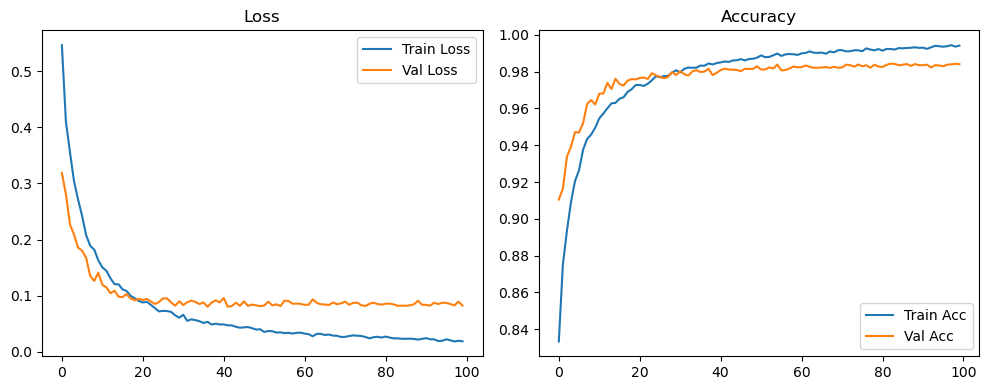

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.3656, Acc: 0.8929 | Val Loss: 0.3005, Acc: 0.9113


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.2513, Acc: 0.9236 | Val Loss: 0.2323, Acc: 0.9285


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1917, Acc: 0.9420 | Val Loss: 0.1788, Acc: 0.9476


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1484, Acc: 0.9547 | Val Loss: 0.1439, Acc: 0.9553


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.1252, Acc: 0.9606 | Val Loss: 0.1453, Acc: 0.9563


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.1036, Acc: 0.9669 | Val Loss: 0.1633, Acc: 0.9498


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0854, Acc: 0.9732 | Val Loss: 0.1543, Acc: 0.9553


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0734, Acc: 0.9769 | Val Loss: 0.1266, Acc: 0.9653


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0670, Acc: 0.9775 | Val Loss: 0.1125, Acc: 0.9686


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0571, Acc: 0.9801 | Val Loss: 0.1031, Acc: 0.9722


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0508, Acc: 0.9835 | Val Loss: 0.1212, Acc: 0.9682


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0476, Acc: 0.9836 | Val Loss: 0.1193, Acc: 0.9707


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0417, Acc: 0.9859 | Val Loss: 0.1176, Acc: 0.9714


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0386, Acc: 0.9874 | Val Loss: 0.1161, Acc: 0.9700


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0356, Acc: 0.9875 | Val Loss: 0.1109, Acc: 0.9729


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0320, Acc: 0.9889 | Val Loss: 0.1291, Acc: 0.9676


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0310, Acc: 0.9898 | Val Loss: 0.1182, Acc: 0.9732


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0265, Acc: 0.9909 | Val Loss: 0.1201, Acc: 0.9728


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0282, Acc: 0.9902 | Val Loss: 0.1013, Acc: 0.9756


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0245, Acc: 0.9918 | Val Loss: 0.1178, Acc: 0.9725


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0253, Acc: 0.9912 | Val Loss: 0.1456, Acc: 0.9690


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0209, Acc: 0.9927 | Val Loss: 0.1085, Acc: 0.9749


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0164, Acc: 0.9944 | Val Loss: 0.1225, Acc: 0.9762


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0218, Acc: 0.9929 | Val Loss: 0.1293, Acc: 0.9735


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0200, Acc: 0.9933 | Val Loss: 0.1176, Acc: 0.9758


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0138, Acc: 0.9955 | Val Loss: 0.1281, Acc: 0.9753


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0238, Acc: 0.9925 | Val Loss: 0.1201, Acc: 0.9763


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0153, Acc: 0.9945 | Val Loss: 0.1216, Acc: 0.9762


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0148, Acc: 0.9950 | Val Loss: 0.1253, Acc: 0.9758


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0158, Acc: 0.9952 | Val Loss: 0.1278, Acc: 0.9752


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0172, Acc: 0.9944 | Val Loss: 0.1276, Acc: 0.9751


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9962 | Val Loss: 0.1081, Acc: 0.9792


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0143, Acc: 0.9955 | Val Loss: 0.1132, Acc: 0.9778


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0121, Acc: 0.9960 | Val Loss: 0.1187, Acc: 0.9788


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9959 | Val Loss: 0.1241, Acc: 0.9770


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0148, Acc: 0.9952 | Val Loss: 0.1258, Acc: 0.9788


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0124, Acc: 0.9962 | Val Loss: 0.1222, Acc: 0.9792


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.1147, Acc: 0.9797


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0139, Acc: 0.9956 | Val Loss: 0.1331, Acc: 0.9768


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9963 | Val Loss: 0.1322, Acc: 0.9784


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9966 | Val Loss: 0.1161, Acc: 0.9797


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.1220, Acc: 0.9783


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9967 | Val Loss: 0.1249, Acc: 0.9786


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0116, Acc: 0.9964 | Val Loss: 0.1318, Acc: 0.9782


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.1251, Acc: 0.9794


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9970 | Val Loss: 0.1388, Acc: 0.9782


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.1208, Acc: 0.9796


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9970 | Val Loss: 0.1436, Acc: 0.9781


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.1503, Acc: 0.9750


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9969 | Val Loss: 0.1450, Acc: 0.9773


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.1447, Acc: 0.9782


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1308, Acc: 0.9794


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.1458, Acc: 0.9778


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.1370, Acc: 0.9794


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1469, Acc: 0.9784


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9978 | Val Loss: 0.1490, Acc: 0.9780


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.1544, Acc: 0.9766


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1380, Acc: 0.9794


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.1516, Acc: 0.9791


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1501, Acc: 0.9778


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.1415, Acc: 0.9803


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1528, Acc: 0.9792


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9972 | Val Loss: 0.1574, Acc: 0.9782


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1474, Acc: 0.9793


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1393, Acc: 0.9817


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.1509, Acc: 0.9798


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.1588, Acc: 0.9783


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9978 | Val Loss: 0.1441, Acc: 0.9804


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9982 | Val Loss: 0.1315, Acc: 0.9826


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1496, Acc: 0.9803


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9980 | Val Loss: 0.1446, Acc: 0.9806


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9973 | Val Loss: 0.1948, Acc: 0.9749


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.1655, Acc: 0.9773


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1683, Acc: 0.9779


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1634, Acc: 0.9794


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9978 | Val Loss: 0.1545, Acc: 0.9792


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9985 | Val Loss: 0.1495, Acc: 0.9810


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9989 | Val Loss: 0.1840, Acc: 0.9758


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.1682, Acc: 0.9788


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1708, Acc: 0.9794


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9979 | Val Loss: 0.1496, Acc: 0.9812


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.1570, Acc: 0.9806


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1612, Acc: 0.9795


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.1835, Acc: 0.9766


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9978 | Val Loss: 0.1400, Acc: 0.9809


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1593, Acc: 0.9802


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9981 | Val Loss: 0.1850, Acc: 0.9776


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.1519, Acc: 0.9808


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1708, Acc: 0.9785


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.1682, Acc: 0.9781


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1482, Acc: 0.9804


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1619, Acc: 0.9802


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1759, Acc: 0.9790


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1593, Acc: 0.9803


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1784, Acc: 0.9778


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9984 | Val Loss: 0.1653, Acc: 0.9775


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1695, Acc: 0.9772


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1799, Acc: 0.9783


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.1588, Acc: 0.9820


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9985 | Val Loss: 0.1509, Acc: 0.9822


Final Test Loss: 0.1381 Accuracy: 0.9834


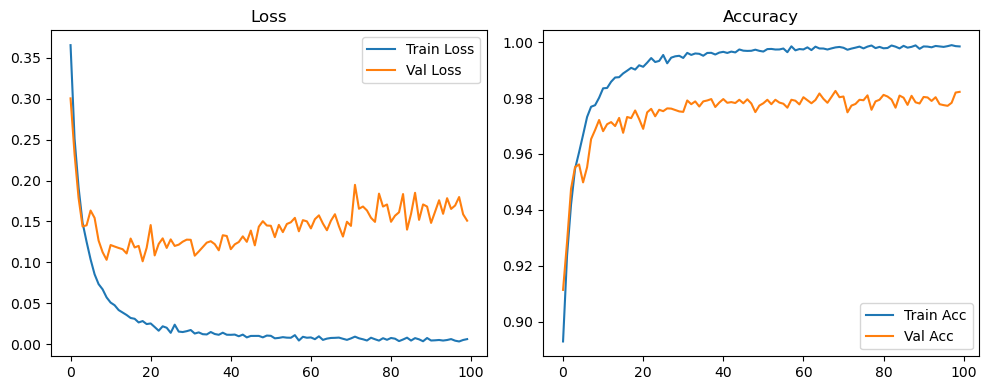

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.4139, Acc: 0.8789 | Val Loss: 0.2998, Acc: 0.9143


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.3125, Acc: 0.9049 | Val Loss: 0.2551, Acc: 0.9235


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.2644, Acc: 0.9206 | Val Loss: 0.2188, Acc: 0.9329


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.2258, Acc: 0.9308 | Val Loss: 0.1849, Acc: 0.9453


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.1982, Acc: 0.9395 | Val Loss: 0.1886, Acc: 0.9470


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.1739, Acc: 0.9468 | Val Loss: 0.1630, Acc: 0.9537


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.1500, Acc: 0.9533 | Val Loss: 0.1613, Acc: 0.9527


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.1341, Acc: 0.9591 | Val Loss: 0.1319, Acc: 0.9623


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.1212, Acc: 0.9616 | Val Loss: 0.1141, Acc: 0.9671


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.1096, Acc: 0.9653 | Val Loss: 0.1116, Acc: 0.9665


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0982, Acc: 0.9693 | Val Loss: 0.1087, Acc: 0.9701


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0920, Acc: 0.9703 | Val Loss: 0.1147, Acc: 0.9697


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0798, Acc: 0.9745 | Val Loss: 0.0999, Acc: 0.9719


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0769, Acc: 0.9760 | Val Loss: 0.1009, Acc: 0.9732


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0703, Acc: 0.9771 | Val Loss: 0.1034, Acc: 0.9742


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0639, Acc: 0.9786 | Val Loss: 0.1019, Acc: 0.9728


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0582, Acc: 0.9802 | Val Loss: 0.0985, Acc: 0.9752


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0549, Acc: 0.9815 | Val Loss: 0.0982, Acc: 0.9742


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0518, Acc: 0.9825 | Val Loss: 0.0986, Acc: 0.9757


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0477, Acc: 0.9840 | Val Loss: 0.1039, Acc: 0.9762


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0501, Acc: 0.9831 | Val Loss: 0.0957, Acc: 0.9767


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0427, Acc: 0.9857 | Val Loss: 0.1061, Acc: 0.9745


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0396, Acc: 0.9872 | Val Loss: 0.1019, Acc: 0.9756


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0415, Acc: 0.9862 | Val Loss: 0.1048, Acc: 0.9771


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0366, Acc: 0.9875 | Val Loss: 0.0969, Acc: 0.9769


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0334, Acc: 0.9892 | Val Loss: 0.0963, Acc: 0.9773


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0379, Acc: 0.9873 | Val Loss: 0.0946, Acc: 0.9788


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0342, Acc: 0.9881 | Val Loss: 0.0956, Acc: 0.9783


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0310, Acc: 0.9895 | Val Loss: 0.1052, Acc: 0.9771


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0298, Acc: 0.9896 | Val Loss: 0.1064, Acc: 0.9762


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0312, Acc: 0.9901 | Val Loss: 0.0990, Acc: 0.9788


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0249, Acc: 0.9916 | Val Loss: 0.0967, Acc: 0.9785


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0263, Acc: 0.9909 | Val Loss: 0.1068, Acc: 0.9777


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0285, Acc: 0.9905 | Val Loss: 0.1081, Acc: 0.9779


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0248, Acc: 0.9920 | Val Loss: 0.1057, Acc: 0.9780


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0229, Acc: 0.9922 | Val Loss: 0.1051, Acc: 0.9785


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0261, Acc: 0.9914 | Val Loss: 0.1084, Acc: 0.9772


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0230, Acc: 0.9923 | Val Loss: 0.1003, Acc: 0.9804


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0221, Acc: 0.9929 | Val Loss: 0.1016, Acc: 0.9795


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0214, Acc: 0.9931 | Val Loss: 0.1058, Acc: 0.9783


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0213, Acc: 0.9927 | Val Loss: 0.1157, Acc: 0.9780


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0187, Acc: 0.9941 | Val Loss: 0.1104, Acc: 0.9794


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0222, Acc: 0.9926 | Val Loss: 0.1107, Acc: 0.9795


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0192, Acc: 0.9935 | Val Loss: 0.1139, Acc: 0.9795


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0173, Acc: 0.9944 | Val Loss: 0.1085, Acc: 0.9798


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0179, Acc: 0.9939 | Val Loss: 0.1217, Acc: 0.9780


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0199, Acc: 0.9934 | Val Loss: 0.1145, Acc: 0.9787


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0178, Acc: 0.9940 | Val Loss: 0.1103, Acc: 0.9801


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0175, Acc: 0.9946 | Val Loss: 0.1065, Acc: 0.9799


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0151, Acc: 0.9951 | Val Loss: 0.1100, Acc: 0.9808


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0160, Acc: 0.9946 | Val Loss: 0.1056, Acc: 0.9808


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0179, Acc: 0.9941 | Val Loss: 0.1101, Acc: 0.9800


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0154, Acc: 0.9949 | Val Loss: 0.1140, Acc: 0.9815


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0145, Acc: 0.9951 | Val Loss: 0.1208, Acc: 0.9801


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0164, Acc: 0.9949 | Val Loss: 0.1258, Acc: 0.9782


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0177, Acc: 0.9944 | Val Loss: 0.1184, Acc: 0.9798


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0149, Acc: 0.9953 | Val Loss: 0.1137, Acc: 0.9804


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9954 | Val Loss: 0.1078, Acc: 0.9802


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0149, Acc: 0.9950 | Val Loss: 0.1184, Acc: 0.9808


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9958 | Val Loss: 0.1368, Acc: 0.9780


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9955 | Val Loss: 0.1232, Acc: 0.9791


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9957 | Val Loss: 0.1071, Acc: 0.9811


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0134, Acc: 0.9956 | Val Loss: 0.1159, Acc: 0.9812


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.1182, Acc: 0.9808


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9956 | Val Loss: 0.1118, Acc: 0.9810


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9956 | Val Loss: 0.1268, Acc: 0.9805


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0152, Acc: 0.9953 | Val Loss: 0.1148, Acc: 0.9799


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9961 | Val Loss: 0.1220, Acc: 0.9812


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9963 | Val Loss: 0.1120, Acc: 0.9818


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0131, Acc: 0.9961 | Val Loss: 0.1175, Acc: 0.9805


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9963 | Val Loss: 0.1166, Acc: 0.9818


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9965 | Val Loss: 0.1124, Acc: 0.9815


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0142, Acc: 0.9959 | Val Loss: 0.1204, Acc: 0.9808


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9965 | Val Loss: 0.1135, Acc: 0.9801


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9968 | Val Loss: 0.1139, Acc: 0.9807


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0124, Acc: 0.9963 | Val Loss: 0.1209, Acc: 0.9803


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9964 | Val Loss: 0.1241, Acc: 0.9821


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9970 | Val Loss: 0.1178, Acc: 0.9802


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9971 | Val Loss: 0.1320, Acc: 0.9812


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.1409, Acc: 0.9814


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9963 | Val Loss: 0.1209, Acc: 0.9818


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9970 | Val Loss: 0.1294, Acc: 0.9814


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1182, Acc: 0.9817


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.1170, Acc: 0.9819


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9971 | Val Loss: 0.1144, Acc: 0.9816


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.1208, Acc: 0.9827


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9971 | Val Loss: 0.1165, Acc: 0.9823


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.1220, Acc: 0.9822


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.1293, Acc: 0.9820


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.1264, Acc: 0.9822


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.1238, Acc: 0.9827


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.1242, Acc: 0.9812


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.1344, Acc: 0.9810


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9976 | Val Loss: 0.1241, Acc: 0.9825


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.1283, Acc: 0.9812


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9966 | Val Loss: 0.1277, Acc: 0.9817


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1255, Acc: 0.9817


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9975 | Val Loss: 0.1317, Acc: 0.9804


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.1314, Acc: 0.9812


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9973 | Val Loss: 0.1315, Acc: 0.9812


Final Test Loss: 0.1112 Accuracy: 0.9832


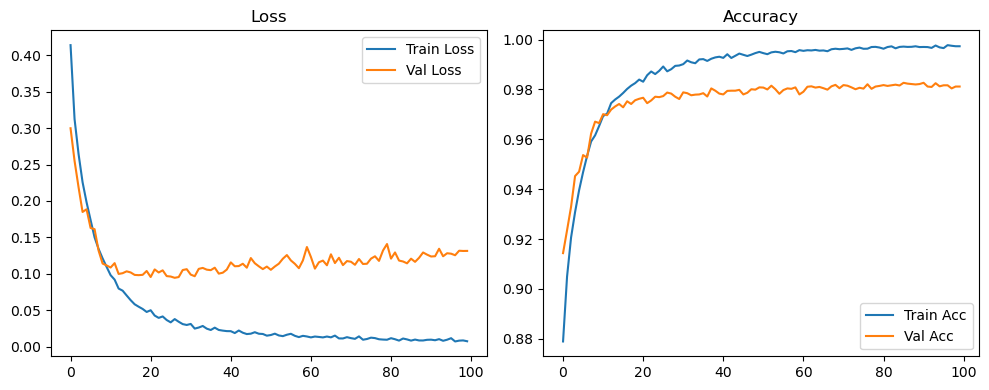

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.5605, Acc: 0.8324 | Val Loss: 0.3146, Acc: 0.9076


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.4063, Acc: 0.8755 | Val Loss: 0.2810, Acc: 0.9164


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.3630, Acc: 0.8898 | Val Loss: 0.2567, Acc: 0.9242


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.3280, Acc: 0.9003 | Val Loss: 0.2334, Acc: 0.9313


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.3002, Acc: 0.9095 | Val Loss: 0.2148, Acc: 0.9367


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.2730, Acc: 0.9160 | Val Loss: 0.1979, Acc: 0.9421


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.2427, Acc: 0.9267 | Val Loss: 0.1849, Acc: 0.9442


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.2228, Acc: 0.9339 | Val Loss: 0.1611, Acc: 0.9532


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.2107, Acc: 0.9361 | Val Loss: 0.1495, Acc: 0.9582


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.1927, Acc: 0.9406 | Val Loss: 0.1375, Acc: 0.9598


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.1759, Acc: 0.9476 | Val Loss: 0.1352, Acc: 0.9627


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.1663, Acc: 0.9495 | Val Loss: 0.1272, Acc: 0.9631


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.1562, Acc: 0.9519 | Val Loss: 0.1176, Acc: 0.9677


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.1411, Acc: 0.9563 | Val Loss: 0.1172, Acc: 0.9673


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.1384, Acc: 0.9577 | Val Loss: 0.1127, Acc: 0.9688


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.1292, Acc: 0.9594 | Val Loss: 0.1101, Acc: 0.9688


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.1254, Acc: 0.9611 | Val Loss: 0.1044, Acc: 0.9715


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.1151, Acc: 0.9639 | Val Loss: 0.1061, Acc: 0.9706


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.1117, Acc: 0.9653 | Val Loss: 0.1012, Acc: 0.9733


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.1058, Acc: 0.9667 | Val Loss: 0.1008, Acc: 0.9722


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.1038, Acc: 0.9674 | Val Loss: 0.0966, Acc: 0.9745


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0966, Acc: 0.9690 | Val Loss: 0.1007, Acc: 0.9744


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0966, Acc: 0.9693 | Val Loss: 0.0912, Acc: 0.9755


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0939, Acc: 0.9705 | Val Loss: 0.0915, Acc: 0.9752


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0834, Acc: 0.9728 | Val Loss: 0.0933, Acc: 0.9754


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0839, Acc: 0.9736 | Val Loss: 0.0909, Acc: 0.9766


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0816, Acc: 0.9740 | Val Loss: 0.0924, Acc: 0.9761


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0837, Acc: 0.9735 | Val Loss: 0.0880, Acc: 0.9769


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0751, Acc: 0.9756 | Val Loss: 0.0860, Acc: 0.9775


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0736, Acc: 0.9763 | Val Loss: 0.0895, Acc: 0.9763


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0736, Acc: 0.9766 | Val Loss: 0.0866, Acc: 0.9782


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0670, Acc: 0.9780 | Val Loss: 0.0943, Acc: 0.9756


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0687, Acc: 0.9784 | Val Loss: 0.0878, Acc: 0.9788


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0651, Acc: 0.9787 | Val Loss: 0.0882, Acc: 0.9783


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0618, Acc: 0.9803 | Val Loss: 0.0876, Acc: 0.9788


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0611, Acc: 0.9801 | Val Loss: 0.0883, Acc: 0.9782


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0612, Acc: 0.9800 | Val Loss: 0.0891, Acc: 0.9781


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0566, Acc: 0.9815 | Val Loss: 0.0878, Acc: 0.9793


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0567, Acc: 0.9819 | Val Loss: 0.0881, Acc: 0.9774


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0588, Acc: 0.9816 | Val Loss: 0.0888, Acc: 0.9795


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0502, Acc: 0.9831 | Val Loss: 0.0923, Acc: 0.9795


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0536, Acc: 0.9828 | Val Loss: 0.0881, Acc: 0.9790


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0534, Acc: 0.9829 | Val Loss: 0.0856, Acc: 0.9800


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0511, Acc: 0.9837 | Val Loss: 0.0943, Acc: 0.9785


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0470, Acc: 0.9845 | Val Loss: 0.0837, Acc: 0.9800


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0464, Acc: 0.9859 | Val Loss: 0.0964, Acc: 0.9786


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0497, Acc: 0.9843 | Val Loss: 0.0896, Acc: 0.9788


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0471, Acc: 0.9841 | Val Loss: 0.0887, Acc: 0.9801


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0480, Acc: 0.9842 | Val Loss: 0.0872, Acc: 0.9801


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0435, Acc: 0.9859 | Val Loss: 0.0837, Acc: 0.9813


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0440, Acc: 0.9860 | Val Loss: 0.0824, Acc: 0.9812


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0458, Acc: 0.9858 | Val Loss: 0.0896, Acc: 0.9801


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0410, Acc: 0.9866 | Val Loss: 0.0866, Acc: 0.9802


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0397, Acc: 0.9874 | Val Loss: 0.0887, Acc: 0.9809


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0390, Acc: 0.9874 | Val Loss: 0.0892, Acc: 0.9811


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0409, Acc: 0.9867 | Val Loss: 0.0960, Acc: 0.9802


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0402, Acc: 0.9864 | Val Loss: 0.0935, Acc: 0.9802


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0387, Acc: 0.9873 | Val Loss: 0.0882, Acc: 0.9818


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0371, Acc: 0.9873 | Val Loss: 0.0913, Acc: 0.9799


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0380, Acc: 0.9875 | Val Loss: 0.0913, Acc: 0.9808


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0372, Acc: 0.9878 | Val Loss: 0.0889, Acc: 0.9821


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0367, Acc: 0.9881 | Val Loss: 0.0910, Acc: 0.9813


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0373, Acc: 0.9886 | Val Loss: 0.0932, Acc: 0.9811


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0345, Acc: 0.9885 | Val Loss: 0.0869, Acc: 0.9812


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0354, Acc: 0.9884 | Val Loss: 0.0894, Acc: 0.9811


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0374, Acc: 0.9883 | Val Loss: 0.0910, Acc: 0.9808


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0337, Acc: 0.9889 | Val Loss: 0.0868, Acc: 0.9810


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0337, Acc: 0.9891 | Val Loss: 0.0971, Acc: 0.9802


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0344, Acc: 0.9892 | Val Loss: 0.0961, Acc: 0.9824


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0321, Acc: 0.9896 | Val Loss: 0.0948, Acc: 0.9819


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0316, Acc: 0.9896 | Val Loss: 0.0922, Acc: 0.9812


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0321, Acc: 0.9895 | Val Loss: 0.0964, Acc: 0.9808


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0322, Acc: 0.9900 | Val Loss: 0.0888, Acc: 0.9827


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0329, Acc: 0.9899 | Val Loss: 0.0923, Acc: 0.9822


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0316, Acc: 0.9899 | Val Loss: 0.0931, Acc: 0.9823


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0284, Acc: 0.9912 | Val Loss: 0.0900, Acc: 0.9820


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0294, Acc: 0.9903 | Val Loss: 0.0921, Acc: 0.9818


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0291, Acc: 0.9908 | Val Loss: 0.0942, Acc: 0.9809


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0302, Acc: 0.9901 | Val Loss: 0.0916, Acc: 0.9825


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0296, Acc: 0.9909 | Val Loss: 0.0908, Acc: 0.9825


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0273, Acc: 0.9910 | Val Loss: 0.0893, Acc: 0.9823


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0335, Acc: 0.9891 | Val Loss: 0.0910, Acc: 0.9827


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0282, Acc: 0.9910 | Val Loss: 0.0932, Acc: 0.9818


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0273, Acc: 0.9911 | Val Loss: 0.0873, Acc: 0.9824


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0271, Acc: 0.9919 | Val Loss: 0.0928, Acc: 0.9815


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0263, Acc: 0.9918 | Val Loss: 0.0891, Acc: 0.9820


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0274, Acc: 0.9912 | Val Loss: 0.0957, Acc: 0.9812


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0254, Acc: 0.9922 | Val Loss: 0.0978, Acc: 0.9805


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0251, Acc: 0.9916 | Val Loss: 0.0981, Acc: 0.9816


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0268, Acc: 0.9915 | Val Loss: 0.0943, Acc: 0.9821


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0256, Acc: 0.9918 | Val Loss: 0.1020, Acc: 0.9810


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0253, Acc: 0.9920 | Val Loss: 0.1000, Acc: 0.9820


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0268, Acc: 0.9915 | Val Loss: 0.0975, Acc: 0.9820


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0244, Acc: 0.9919 | Val Loss: 0.0983, Acc: 0.9818


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0236, Acc: 0.9927 | Val Loss: 0.0971, Acc: 0.9828


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0219, Acc: 0.9929 | Val Loss: 0.0951, Acc: 0.9834


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0217, Acc: 0.9934 | Val Loss: 0.1028, Acc: 0.9820


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0234, Acc: 0.9924 | Val Loss: 0.0918, Acc: 0.9825


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0251, Acc: 0.9919 | Val Loss: 0.0963, Acc: 0.9831


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0256, Acc: 0.9918 | Val Loss: 0.0945, Acc: 0.9822


Final Test Loss: 0.0885 Accuracy: 0.9840


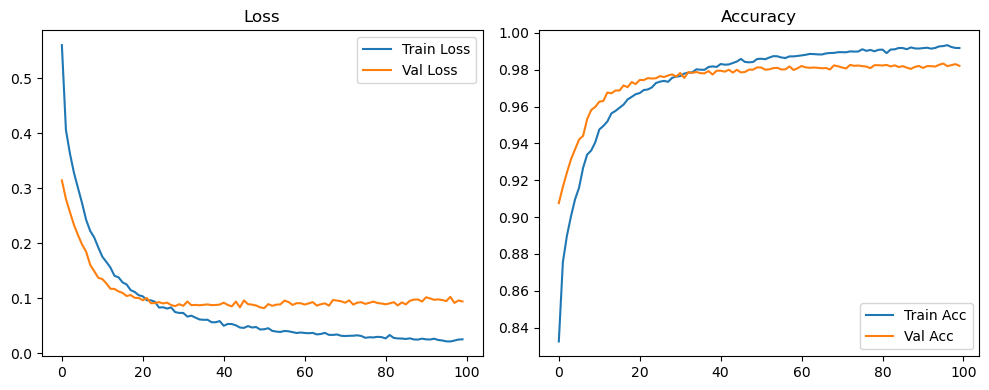

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4306, Acc: 0.8719 | Val Loss: 0.3640, Acc: 0.8985


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2203, Acc: 0.9351 | Val Loss: 0.1744, Acc: 0.9499


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1314, Acc: 0.9595 | Val Loss: 0.1391, Acc: 0.9582


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1028, Acc: 0.9689 | Val Loss: 0.1244, Acc: 0.9639


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0789, Acc: 0.9754 | Val Loss: 0.1496, Acc: 0.9581


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0695, Acc: 0.9778 | Val Loss: 0.1083, Acc: 0.9719


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0578, Acc: 0.9823 | Val Loss: 0.1319, Acc: 0.9676


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0451, Acc: 0.9860 | Val Loss: 0.1450, Acc: 0.9693


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0394, Acc: 0.9875 | Val Loss: 0.1179, Acc: 0.9712


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0334, Acc: 0.9891 | Val Loss: 0.1463, Acc: 0.9672


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0275, Acc: 0.9914 | Val Loss: 0.1245, Acc: 0.9726


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0276, Acc: 0.9912 | Val Loss: 0.1209, Acc: 0.9739


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9921 | Val Loss: 0.1167, Acc: 0.9760


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9923 | Val Loss: 0.1201, Acc: 0.9750


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9932 | Val Loss: 0.1308, Acc: 0.9745


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9940 | Val Loss: 0.1613, Acc: 0.9692


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9935 | Val Loss: 0.1174, Acc: 0.9773


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9940 | Val Loss: 0.1337, Acc: 0.9742


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9949 | Val Loss: 0.1118, Acc: 0.9779


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9962 | Val Loss: 0.1609, Acc: 0.9727


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9945 | Val Loss: 0.1422, Acc: 0.9731


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9951 | Val Loss: 0.1255, Acc: 0.9778


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9961 | Val Loss: 0.1238, Acc: 0.9772


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9964 | Val Loss: 0.1318, Acc: 0.9758


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.1204, Acc: 0.9796


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.1624, Acc: 0.9706


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9960 | Val Loss: 0.1044, Acc: 0.9804


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1058, Acc: 0.9813


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.1199, Acc: 0.9782


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9971 | Val Loss: 0.1052, Acc: 0.9808


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1028, Acc: 0.9812


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1047, Acc: 0.9807


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9967 | Val Loss: 0.1262, Acc: 0.9762


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.1161, Acc: 0.9795


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1250, Acc: 0.9782


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1041, Acc: 0.9811


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9970 | Val Loss: 0.1203, Acc: 0.9792


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1226, Acc: 0.9772


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1033, Acc: 0.9815


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1313, Acc: 0.9765


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1093, Acc: 0.9798


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1167, Acc: 0.9771


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1094, Acc: 0.9798


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1091, Acc: 0.9811


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.1181, Acc: 0.9802


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1384, Acc: 0.9763


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1123, Acc: 0.9807


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1246, Acc: 0.9807


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9987 | Val Loss: 0.1131, Acc: 0.9812


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1148, Acc: 0.9817


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 0.1136, Acc: 0.9803


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0924, Acc: 0.9828


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1525, Acc: 0.9749


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.1239, Acc: 0.9791


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.1233, Acc: 0.9804


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1148, Acc: 0.9812


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1217, Acc: 0.9788


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1239, Acc: 0.9787


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.1266, Acc: 0.9784


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0982, Acc: 0.9834


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1267, Acc: 0.9799


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.1122, Acc: 0.9797


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.1038, Acc: 0.9813


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9992 | Val Loss: 0.1172, Acc: 0.9813


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1162, Acc: 0.9802


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1202, Acc: 0.9798


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1224, Acc: 0.9808


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1119, Acc: 0.9809


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1155, Acc: 0.9808


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1270, Acc: 0.9798


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1050, Acc: 0.9818


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1056, Acc: 0.9815


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1067, Acc: 0.9812


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1085, Acc: 0.9824


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1084, Acc: 0.9818


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.1132, Acc: 0.9809


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.1067, Acc: 0.9813


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1119, Acc: 0.9819


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1143, Acc: 0.9815


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1124, Acc: 0.9818


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1085, Acc: 0.9813


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1176, Acc: 0.9812


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9989 | Val Loss: 0.1068, Acc: 0.9828


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1103, Acc: 0.9824


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1195, Acc: 0.9797


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1228, Acc: 0.9811


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1061, Acc: 0.9836


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1208, Acc: 0.9818


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1318, Acc: 0.9785


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1185, Acc: 0.9793


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1077, Acc: 0.9827


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1088, Acc: 0.9820


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1041, Acc: 0.9812


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1115, Acc: 0.9822


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1362, Acc: 0.9781


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1140, Acc: 0.9812


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1058, Acc: 0.9829


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1102, Acc: 0.9815


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1118, Acc: 0.9810


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1198, Acc: 0.9807


Final Test Loss: 0.1172 Accuracy: 0.9821


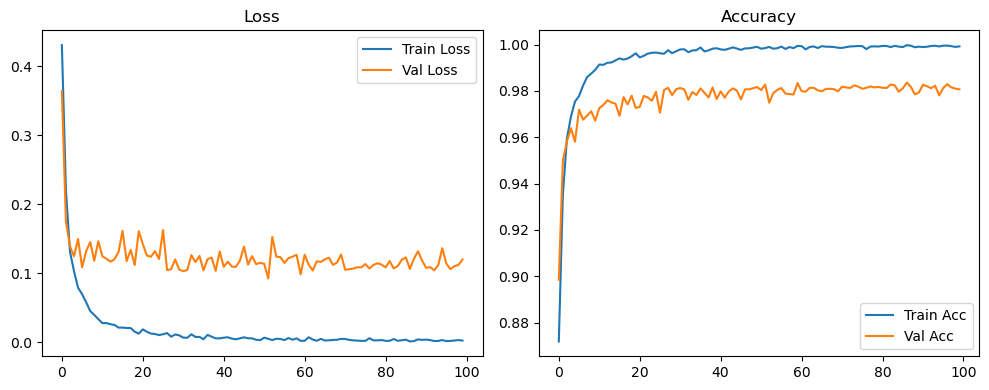

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4774, Acc: 0.8599 | Val Loss: 0.3577, Acc: 0.9038


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2853, Acc: 0.9177 | Val Loss: 0.2124, Acc: 0.9393


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1934, Acc: 0.9434 | Val Loss: 0.1581, Acc: 0.9549


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1493, Acc: 0.9559 | Val Loss: 0.1287, Acc: 0.9633


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1174, Acc: 0.9640 | Val Loss: 0.1283, Acc: 0.9637


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1007, Acc: 0.9678 | Val Loss: 0.1159, Acc: 0.9675


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0862, Acc: 0.9735 | Val Loss: 0.1219, Acc: 0.9686


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0729, Acc: 0.9779 | Val Loss: 0.1117, Acc: 0.9720


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0653, Acc: 0.9792 | Val Loss: 0.1199, Acc: 0.9683


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0570, Acc: 0.9815 | Val Loss: 0.0891, Acc: 0.9764


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0489, Acc: 0.9839 | Val Loss: 0.0952, Acc: 0.9752


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0482, Acc: 0.9835 | Val Loss: 0.0983, Acc: 0.9747


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0462, Acc: 0.9855 | Val Loss: 0.0987, Acc: 0.9755


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0368, Acc: 0.9882 | Val Loss: 0.1010, Acc: 0.9778


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0364, Acc: 0.9879 | Val Loss: 0.0896, Acc: 0.9794


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0346, Acc: 0.9891 | Val Loss: 0.0827, Acc: 0.9792


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9890 | Val Loss: 0.1167, Acc: 0.9757


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9904 | Val Loss: 0.1113, Acc: 0.9749


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9915 | Val Loss: 0.0853, Acc: 0.9809


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9913 | Val Loss: 0.1094, Acc: 0.9776


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9919 | Val Loss: 0.1085, Acc: 0.9778


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0265, Acc: 0.9916 | Val Loss: 0.0996, Acc: 0.9780


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9933 | Val Loss: 0.0961, Acc: 0.9794


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9930 | Val Loss: 0.0994, Acc: 0.9788


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9935 | Val Loss: 0.0952, Acc: 0.9775


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9941 | Val Loss: 0.1058, Acc: 0.9777


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9936 | Val Loss: 0.0965, Acc: 0.9808


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9935 | Val Loss: 0.0881, Acc: 0.9816


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9944 | Val Loss: 0.0864, Acc: 0.9805


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9944 | Val Loss: 0.0896, Acc: 0.9812


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9945 | Val Loss: 0.1133, Acc: 0.9789


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9950 | Val Loss: 0.1024, Acc: 0.9820


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9949 | Val Loss: 0.0942, Acc: 0.9817


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9947 | Val Loss: 0.0926, Acc: 0.9814


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9963 | Val Loss: 0.0905, Acc: 0.9822


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9955 | Val Loss: 0.0909, Acc: 0.9815


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9955 | Val Loss: 0.1017, Acc: 0.9793


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.1004, Acc: 0.9812


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9960 | Val Loss: 0.0955, Acc: 0.9809


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.1010, Acc: 0.9812


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9960 | Val Loss: 0.1091, Acc: 0.9811


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9958 | Val Loss: 0.1031, Acc: 0.9813


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.0977, Acc: 0.9810


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.1016, Acc: 0.9823


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.0933, Acc: 0.9828


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9963 | Val Loss: 0.1002, Acc: 0.9820


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9966 | Val Loss: 0.1011, Acc: 0.9803


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.1036, Acc: 0.9808


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.1075, Acc: 0.9802


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.0989, Acc: 0.9829


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.1033, Acc: 0.9814


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9967 | Val Loss: 0.1084, Acc: 0.9807


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.0911, Acc: 0.9834


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.1024, Acc: 0.9818


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.0999, Acc: 0.9820


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.1003, Acc: 0.9825


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.0962, Acc: 0.9835


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0915, Acc: 0.9835


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.1047, Acc: 0.9822


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.0978, Acc: 0.9828


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.0951, Acc: 0.9826


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1013, Acc: 0.9837


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9977 | Val Loss: 0.0955, Acc: 0.9832


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.1123, Acc: 0.9809


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9978 | Val Loss: 0.1028, Acc: 0.9818


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.1107, Acc: 0.9807


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.1094, Acc: 0.9817


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1046, Acc: 0.9818


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1030, Acc: 0.9814


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.1036, Acc: 0.9836


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0989, Acc: 0.9845


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9976 | Val Loss: 0.0953, Acc: 0.9837


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0928, Acc: 0.9841


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9976 | Val Loss: 0.0967, Acc: 0.9841


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.0955, Acc: 0.9836


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.0985, Acc: 0.9838


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.1054, Acc: 0.9834


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9976 | Val Loss: 0.1004, Acc: 0.9827


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.0933, Acc: 0.9829


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.0953, Acc: 0.9835


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.0910, Acc: 0.9824


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0927, Acc: 0.9846


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1017, Acc: 0.9826


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9986 | Val Loss: 0.1025, Acc: 0.9822


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9980 | Val Loss: 0.0892, Acc: 0.9839


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.0843, Acc: 0.9850


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0895, Acc: 0.9842


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0923, Acc: 0.9842


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.0907, Acc: 0.9840


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0938, Acc: 0.9836


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9982 | Val Loss: 0.0991, Acc: 0.9839


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.1063, Acc: 0.9822


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.0977, Acc: 0.9846


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9984 | Val Loss: 0.1049, Acc: 0.9839


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.1066, Acc: 0.9825


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1047, Acc: 0.9832


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1119, Acc: 0.9834


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0963, Acc: 0.9832


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1022, Acc: 0.9830


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.1073, Acc: 0.9832


Final Test Loss: 0.0930 Accuracy: 0.9845


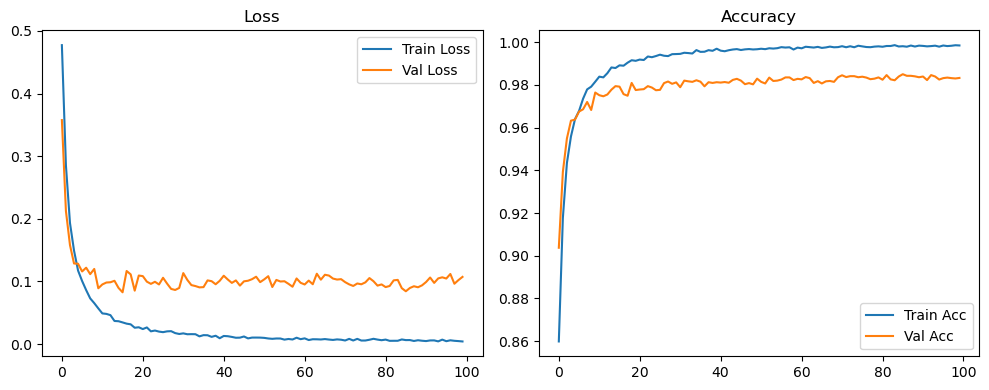

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6032, Acc: 0.8211 | Val Loss: 0.3493, Acc: 0.9083


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3916, Acc: 0.8904 | Val Loss: 0.2559, Acc: 0.9304


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2939, Acc: 0.9165 | Val Loss: 0.1882, Acc: 0.9453


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2255, Acc: 0.9336 | Val Loss: 0.1396, Acc: 0.9597


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1831, Acc: 0.9451 | Val Loss: 0.1570, Acc: 0.9557


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1580, Acc: 0.9516 | Val Loss: 0.1198, Acc: 0.9647


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1364, Acc: 0.9593 | Val Loss: 0.1190, Acc: 0.9667


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1232, Acc: 0.9624 | Val Loss: 0.1052, Acc: 0.9712


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1143, Acc: 0.9638 | Val Loss: 0.0928, Acc: 0.9738


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1051, Acc: 0.9677 | Val Loss: 0.0941, Acc: 0.9732


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0918, Acc: 0.9703 | Val Loss: 0.0915, Acc: 0.9748


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0882, Acc: 0.9719 | Val Loss: 0.0870, Acc: 0.9760


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0814, Acc: 0.9736 | Val Loss: 0.0914, Acc: 0.9746


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0752, Acc: 0.9756 | Val Loss: 0.0782, Acc: 0.9777


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0762, Acc: 0.9757 | Val Loss: 0.0751, Acc: 0.9786


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0682, Acc: 0.9785 | Val Loss: 0.0891, Acc: 0.9758


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0669, Acc: 0.9782 | Val Loss: 0.0763, Acc: 0.9789


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0615, Acc: 0.9799 | Val Loss: 0.0848, Acc: 0.9781


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0627, Acc: 0.9802 | Val Loss: 0.0787, Acc: 0.9787


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0556, Acc: 0.9825 | Val Loss: 0.0762, Acc: 0.9792


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0533, Acc: 0.9828 | Val Loss: 0.0737, Acc: 0.9797


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0537, Acc: 0.9824 | Val Loss: 0.0727, Acc: 0.9811


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9848 | Val Loss: 0.0764, Acc: 0.9782


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9849 | Val Loss: 0.0763, Acc: 0.9791


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0452, Acc: 0.9849 | Val Loss: 0.0704, Acc: 0.9818


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9852 | Val Loss: 0.0666, Acc: 0.9813


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9865 | Val Loss: 0.0752, Acc: 0.9807


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0415, Acc: 0.9869 | Val Loss: 0.0727, Acc: 0.9818


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9866 | Val Loss: 0.0675, Acc: 0.9813


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0367, Acc: 0.9881 | Val Loss: 0.0697, Acc: 0.9828


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9877 | Val Loss: 0.0702, Acc: 0.9808


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0364, Acc: 0.9880 | Val Loss: 0.0736, Acc: 0.9808


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9891 | Val Loss: 0.0757, Acc: 0.9813


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0325, Acc: 0.9888 | Val Loss: 0.0746, Acc: 0.9824


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9897 | Val Loss: 0.0782, Acc: 0.9808


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0323, Acc: 0.9895 | Val Loss: 0.0736, Acc: 0.9823


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0335, Acc: 0.9889 | Val Loss: 0.0682, Acc: 0.9837


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9902 | Val Loss: 0.0757, Acc: 0.9827


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9901 | Val Loss: 0.0731, Acc: 0.9834


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0272, Acc: 0.9908 | Val Loss: 0.0736, Acc: 0.9820


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0280, Acc: 0.9907 | Val Loss: 0.0743, Acc: 0.9821


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9909 | Val Loss: 0.0719, Acc: 0.9824


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9914 | Val Loss: 0.0741, Acc: 0.9833


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9921 | Val Loss: 0.0774, Acc: 0.9823


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9912 | Val Loss: 0.0757, Acc: 0.9820


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9924 | Val Loss: 0.0846, Acc: 0.9827


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9915 | Val Loss: 0.0712, Acc: 0.9823


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9926 | Val Loss: 0.0738, Acc: 0.9832


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9921 | Val Loss: 0.0764, Acc: 0.9829


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0231, Acc: 0.9928 | Val Loss: 0.0806, Acc: 0.9822


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9925 | Val Loss: 0.0818, Acc: 0.9815


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9921 | Val Loss: 0.0784, Acc: 0.9819


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9931 | Val Loss: 0.0854, Acc: 0.9815


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9936 | Val Loss: 0.0813, Acc: 0.9827


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9933 | Val Loss: 0.0800, Acc: 0.9824


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9929 | Val Loss: 0.0762, Acc: 0.9825


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9930 | Val Loss: 0.0753, Acc: 0.9827


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9945 | Val Loss: 0.0693, Acc: 0.9844


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9927 | Val Loss: 0.0784, Acc: 0.9840


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9934 | Val Loss: 0.0754, Acc: 0.9831


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9934 | Val Loss: 0.0691, Acc: 0.9843


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9938 | Val Loss: 0.0721, Acc: 0.9846


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9942 | Val Loss: 0.0705, Acc: 0.9850


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9937 | Val Loss: 0.0698, Acc: 0.9849


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9936 | Val Loss: 0.0646, Acc: 0.9849


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9945 | Val Loss: 0.0694, Acc: 0.9842


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9932 | Val Loss: 0.0682, Acc: 0.9848


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9941 | Val Loss: 0.0702, Acc: 0.9842


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9943 | Val Loss: 0.0727, Acc: 0.9848


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9947 | Val Loss: 0.0753, Acc: 0.9845


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9947 | Val Loss: 0.0756, Acc: 0.9838


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9945 | Val Loss: 0.0716, Acc: 0.9853


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9942 | Val Loss: 0.0712, Acc: 0.9848


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9944 | Val Loss: 0.0780, Acc: 0.9835


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9950 | Val Loss: 0.0770, Acc: 0.9839


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9952 | Val Loss: 0.0743, Acc: 0.9843


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9945 | Val Loss: 0.0736, Acc: 0.9850


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9946 | Val Loss: 0.0719, Acc: 0.9842


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9944 | Val Loss: 0.0679, Acc: 0.9852


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9960 | Val Loss: 0.0720, Acc: 0.9838


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9946 | Val Loss: 0.0724, Acc: 0.9848


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9945 | Val Loss: 0.0694, Acc: 0.9846


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9956 | Val Loss: 0.0732, Acc: 0.9848


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9949 | Val Loss: 0.0717, Acc: 0.9840


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9956 | Val Loss: 0.0725, Acc: 0.9851


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9958 | Val Loss: 0.0727, Acc: 0.9842


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9958 | Val Loss: 0.0760, Acc: 0.9853


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9952 | Val Loss: 0.0784, Acc: 0.9837


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9952 | Val Loss: 0.0796, Acc: 0.9848


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9955 | Val Loss: 0.0739, Acc: 0.9844


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9956 | Val Loss: 0.0821, Acc: 0.9851


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9958 | Val Loss: 0.0774, Acc: 0.9835


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9956 | Val Loss: 0.0793, Acc: 0.9847


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9950 | Val Loss: 0.0792, Acc: 0.9845


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9957 | Val Loss: 0.0791, Acc: 0.9845


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.0859, Acc: 0.9843


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9953 | Val Loss: 0.0765, Acc: 0.9841


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.0778, Acc: 0.9846


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9963 | Val Loss: 0.0855, Acc: 0.9840


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9963 | Val Loss: 0.0807, Acc: 0.9848


Final Test Loss: 0.0755 Accuracy: 0.9864


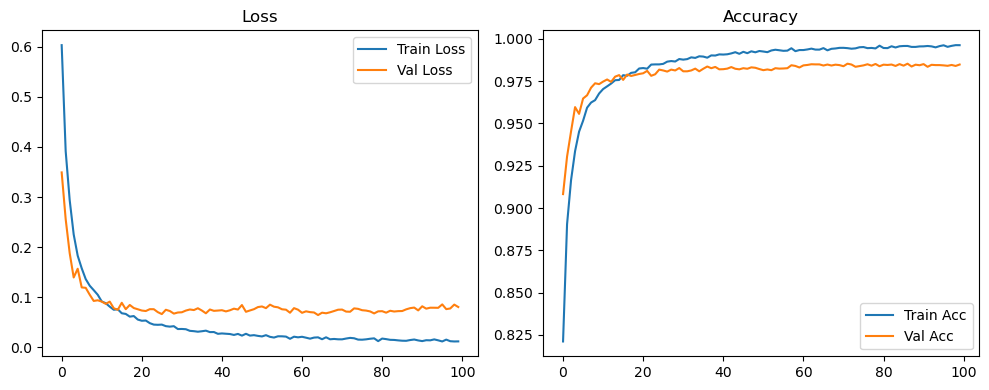

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4306, Acc: 0.8719 | Val Loss: 0.3640, Acc: 0.8985


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2203, Acc: 0.9351 | Val Loss: 0.1744, Acc: 0.9499


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1314, Acc: 0.9595 | Val Loss: 0.1391, Acc: 0.9582


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1028, Acc: 0.9689 | Val Loss: 0.1244, Acc: 0.9639


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0789, Acc: 0.9754 | Val Loss: 0.1496, Acc: 0.9581


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0695, Acc: 0.9778 | Val Loss: 0.1083, Acc: 0.9719


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0578, Acc: 0.9823 | Val Loss: 0.1319, Acc: 0.9676


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0451, Acc: 0.9860 | Val Loss: 0.1450, Acc: 0.9693


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0394, Acc: 0.9875 | Val Loss: 0.1179, Acc: 0.9712


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0334, Acc: 0.9891 | Val Loss: 0.1463, Acc: 0.9672


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0275, Acc: 0.9914 | Val Loss: 0.1245, Acc: 0.9726


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0276, Acc: 0.9912 | Val Loss: 0.1209, Acc: 0.9739


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9921 | Val Loss: 0.1167, Acc: 0.9760


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9923 | Val Loss: 0.1201, Acc: 0.9750


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9932 | Val Loss: 0.1308, Acc: 0.9745


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9940 | Val Loss: 0.1613, Acc: 0.9692


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9935 | Val Loss: 0.1174, Acc: 0.9773


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9940 | Val Loss: 0.1337, Acc: 0.9742


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9949 | Val Loss: 0.1118, Acc: 0.9779


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9962 | Val Loss: 0.1609, Acc: 0.9727


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9945 | Val Loss: 0.1422, Acc: 0.9731


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9951 | Val Loss: 0.1255, Acc: 0.9778


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9961 | Val Loss: 0.1238, Acc: 0.9772


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9964 | Val Loss: 0.1318, Acc: 0.9758


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.1204, Acc: 0.9796


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.1624, Acc: 0.9706


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9960 | Val Loss: 0.1044, Acc: 0.9804


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1058, Acc: 0.9813


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.1199, Acc: 0.9782


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9971 | Val Loss: 0.1052, Acc: 0.9808


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1028, Acc: 0.9812


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1047, Acc: 0.9807


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9967 | Val Loss: 0.1262, Acc: 0.9762


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.1161, Acc: 0.9795


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1250, Acc: 0.9782


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1041, Acc: 0.9811


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9970 | Val Loss: 0.1203, Acc: 0.9792


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1226, Acc: 0.9772


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1033, Acc: 0.9815


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1313, Acc: 0.9765


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1093, Acc: 0.9798


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1167, Acc: 0.9771


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1094, Acc: 0.9798


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1091, Acc: 0.9811


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.1181, Acc: 0.9802


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1384, Acc: 0.9763


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1123, Acc: 0.9807


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1246, Acc: 0.9807


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9987 | Val Loss: 0.1131, Acc: 0.9812


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1148, Acc: 0.9817


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1053, Acc: 0.9831


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0990, Acc: 0.9837


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1068, Acc: 0.9838


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0966, Acc: 0.9845


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1080, Acc: 0.9832


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1026, Acc: 0.9838


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1067, Acc: 0.9844


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1094, Acc: 0.9836


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1141, Acc: 0.9812


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1061, Acc: 0.9829


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1163, Acc: 0.9825


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1270, Acc: 0.9814


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.1171, Acc: 0.9823


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1411, Acc: 0.9794


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1363, Acc: 0.9807


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1150, Acc: 0.9828


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1256, Acc: 0.9813


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1356, Acc: 0.9804


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1220, Acc: 0.9825


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1181, Acc: 0.9822


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1143, Acc: 0.9825


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1129, Acc: 0.9822


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1221, Acc: 0.9810


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1179, Acc: 0.9814


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1146, Acc: 0.9822


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1228, Acc: 0.9820


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1285, Acc: 0.9812


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1159, Acc: 0.9828


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1242, Acc: 0.9818


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1187, Acc: 0.9823


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1141, Acc: 0.9832


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1122, Acc: 0.9833


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1142, Acc: 0.9832


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1138, Acc: 0.9831


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1144, Acc: 0.9837


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1137, Acc: 0.9839


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1115, Acc: 0.9840


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1095, Acc: 0.9838


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1136, Acc: 0.9838


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1149, Acc: 0.9844


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1151, Acc: 0.9847


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1198, Acc: 0.9842


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1198, Acc: 0.9835


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1216, Acc: 0.9836


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1216, Acc: 0.9838


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1186, Acc: 0.9838


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1183, Acc: 0.9838


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1192, Acc: 0.9840


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1240, Acc: 0.9833


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1206, Acc: 0.9837


Final Test Loss: 0.1164 Accuracy: 0.9847


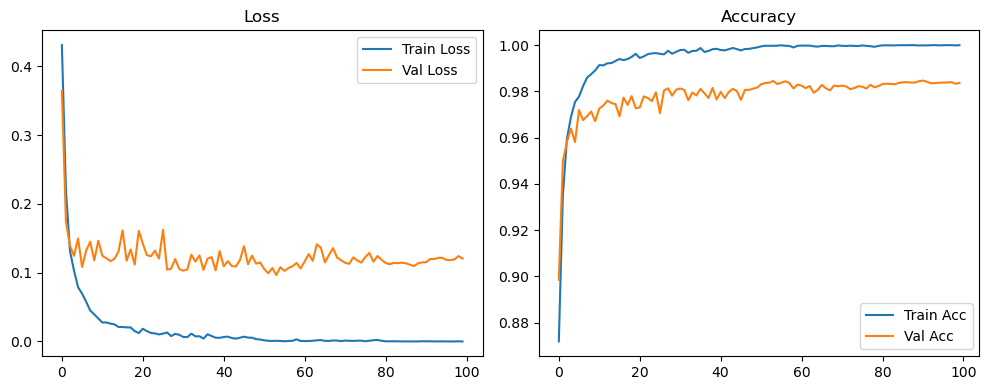

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4774, Acc: 0.8599 | Val Loss: 0.3577, Acc: 0.9038


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2853, Acc: 0.9177 | Val Loss: 0.2124, Acc: 0.9393


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1934, Acc: 0.9434 | Val Loss: 0.1581, Acc: 0.9549


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1493, Acc: 0.9559 | Val Loss: 0.1287, Acc: 0.9633


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1174, Acc: 0.9640 | Val Loss: 0.1283, Acc: 0.9637


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1007, Acc: 0.9678 | Val Loss: 0.1159, Acc: 0.9675


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0862, Acc: 0.9735 | Val Loss: 0.1219, Acc: 0.9686


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0729, Acc: 0.9779 | Val Loss: 0.1117, Acc: 0.9720


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0653, Acc: 0.9792 | Val Loss: 0.1199, Acc: 0.9683


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0570, Acc: 0.9815 | Val Loss: 0.0891, Acc: 0.9764


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0489, Acc: 0.9839 | Val Loss: 0.0952, Acc: 0.9752


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0482, Acc: 0.9835 | Val Loss: 0.0983, Acc: 0.9747


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0462, Acc: 0.9855 | Val Loss: 0.0987, Acc: 0.9755


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0368, Acc: 0.9882 | Val Loss: 0.1010, Acc: 0.9778


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0364, Acc: 0.9879 | Val Loss: 0.0896, Acc: 0.9794


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0346, Acc: 0.9891 | Val Loss: 0.0827, Acc: 0.9792


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9890 | Val Loss: 0.1167, Acc: 0.9757


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9904 | Val Loss: 0.1113, Acc: 0.9749


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9915 | Val Loss: 0.0853, Acc: 0.9809


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9913 | Val Loss: 0.1094, Acc: 0.9776


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9919 | Val Loss: 0.1085, Acc: 0.9778


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0265, Acc: 0.9916 | Val Loss: 0.0996, Acc: 0.9780


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9933 | Val Loss: 0.0961, Acc: 0.9794


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9930 | Val Loss: 0.0994, Acc: 0.9788


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9935 | Val Loss: 0.0952, Acc: 0.9775


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9941 | Val Loss: 0.1058, Acc: 0.9777


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9936 | Val Loss: 0.0965, Acc: 0.9808


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9935 | Val Loss: 0.0881, Acc: 0.9816


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9944 | Val Loss: 0.0864, Acc: 0.9805


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9944 | Val Loss: 0.0896, Acc: 0.9812


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9945 | Val Loss: 0.1133, Acc: 0.9789


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9950 | Val Loss: 0.1024, Acc: 0.9820


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9949 | Val Loss: 0.0942, Acc: 0.9817


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9947 | Val Loss: 0.0926, Acc: 0.9814


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9963 | Val Loss: 0.0905, Acc: 0.9822


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9955 | Val Loss: 0.0909, Acc: 0.9815


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9955 | Val Loss: 0.1017, Acc: 0.9793


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.1004, Acc: 0.9812


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9960 | Val Loss: 0.0955, Acc: 0.9809


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.1010, Acc: 0.9812


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9960 | Val Loss: 0.1091, Acc: 0.9811


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9958 | Val Loss: 0.1031, Acc: 0.9813


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.0977, Acc: 0.9810


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.1016, Acc: 0.9823


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.0933, Acc: 0.9828


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9963 | Val Loss: 0.1002, Acc: 0.9820


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9966 | Val Loss: 0.1011, Acc: 0.9803


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.1036, Acc: 0.9808


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.1075, Acc: 0.9802


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.0989, Acc: 0.9829


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0948, Acc: 0.9828


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.0897, Acc: 0.9829


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0921, Acc: 0.9830


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0959, Acc: 0.9832


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.0965, Acc: 0.9832


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0954, Acc: 0.9841


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0923, Acc: 0.9842


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.0939, Acc: 0.9844


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0926, Acc: 0.9848


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1011, Acc: 0.9831


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1020, Acc: 0.9838


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1038, Acc: 0.9836


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.0984, Acc: 0.9846


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.1092, Acc: 0.9842


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1142, Acc: 0.9831


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1123, Acc: 0.9837


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1144, Acc: 0.9833


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1027, Acc: 0.9839


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0999, Acc: 0.9850


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1101, Acc: 0.9838


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1090, Acc: 0.9832


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1056, Acc: 0.9850


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1032, Acc: 0.9837


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1046, Acc: 0.9845


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1061, Acc: 0.9838


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.1015, Acc: 0.9841


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0991, Acc: 0.9845


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1108, Acc: 0.9850


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.1023, Acc: 0.9843


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0990, Acc: 0.9852


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0952, Acc: 0.9852


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0949, Acc: 0.9864


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0960, Acc: 0.9860


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0954, Acc: 0.9857


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0956, Acc: 0.9861


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0995, Acc: 0.9858


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0953, Acc: 0.9862


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0974, Acc: 0.9865


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0982, Acc: 0.9858


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0980, Acc: 0.9857


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1008, Acc: 0.9854


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1018, Acc: 0.9862


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1026, Acc: 0.9863


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1011, Acc: 0.9862


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1031, Acc: 0.9857


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0991, Acc: 0.9860


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1004, Acc: 0.9850


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1007, Acc: 0.9849


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0967, Acc: 0.9852


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1031, Acc: 0.9857


Final Test Loss: 0.1008 Accuracy: 0.9863


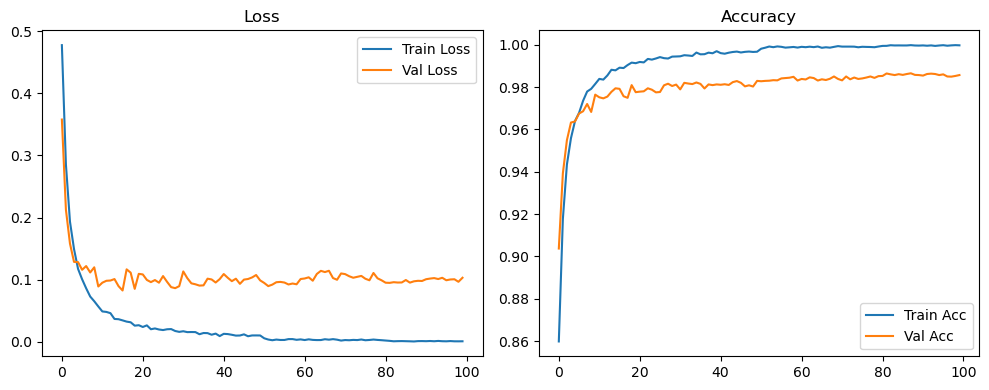

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6032, Acc: 0.8211 | Val Loss: 0.3493, Acc: 0.9083


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3916, Acc: 0.8904 | Val Loss: 0.2559, Acc: 0.9304


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2939, Acc: 0.9165 | Val Loss: 0.1882, Acc: 0.9453


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2255, Acc: 0.9336 | Val Loss: 0.1396, Acc: 0.9597


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1831, Acc: 0.9451 | Val Loss: 0.1570, Acc: 0.9557


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1580, Acc: 0.9516 | Val Loss: 0.1198, Acc: 0.9647


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1364, Acc: 0.9593 | Val Loss: 0.1190, Acc: 0.9667


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1232, Acc: 0.9624 | Val Loss: 0.1052, Acc: 0.9712


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1143, Acc: 0.9638 | Val Loss: 0.0928, Acc: 0.9738


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1051, Acc: 0.9677 | Val Loss: 0.0941, Acc: 0.9732


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0918, Acc: 0.9703 | Val Loss: 0.0915, Acc: 0.9748


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0882, Acc: 0.9719 | Val Loss: 0.0870, Acc: 0.9760


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0814, Acc: 0.9736 | Val Loss: 0.0914, Acc: 0.9746


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0752, Acc: 0.9756 | Val Loss: 0.0782, Acc: 0.9777


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0762, Acc: 0.9757 | Val Loss: 0.0751, Acc: 0.9786


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0682, Acc: 0.9785 | Val Loss: 0.0891, Acc: 0.9758


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0669, Acc: 0.9782 | Val Loss: 0.0763, Acc: 0.9789


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0615, Acc: 0.9799 | Val Loss: 0.0848, Acc: 0.9781


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0627, Acc: 0.9802 | Val Loss: 0.0787, Acc: 0.9787


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0556, Acc: 0.9825 | Val Loss: 0.0762, Acc: 0.9792


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0533, Acc: 0.9828 | Val Loss: 0.0737, Acc: 0.9797


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0537, Acc: 0.9824 | Val Loss: 0.0727, Acc: 0.9811


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9848 | Val Loss: 0.0764, Acc: 0.9782


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9849 | Val Loss: 0.0763, Acc: 0.9791


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0452, Acc: 0.9849 | Val Loss: 0.0704, Acc: 0.9818


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9852 | Val Loss: 0.0666, Acc: 0.9813


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9865 | Val Loss: 0.0752, Acc: 0.9807


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0415, Acc: 0.9869 | Val Loss: 0.0727, Acc: 0.9818


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9866 | Val Loss: 0.0675, Acc: 0.9813


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0367, Acc: 0.9881 | Val Loss: 0.0697, Acc: 0.9828


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9877 | Val Loss: 0.0702, Acc: 0.9808


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0364, Acc: 0.9880 | Val Loss: 0.0736, Acc: 0.9808


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9891 | Val Loss: 0.0757, Acc: 0.9813


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0325, Acc: 0.9888 | Val Loss: 0.0746, Acc: 0.9824


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9897 | Val Loss: 0.0782, Acc: 0.9808


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0323, Acc: 0.9895 | Val Loss: 0.0736, Acc: 0.9823


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0335, Acc: 0.9889 | Val Loss: 0.0682, Acc: 0.9837


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9902 | Val Loss: 0.0757, Acc: 0.9827


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9901 | Val Loss: 0.0731, Acc: 0.9834


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0272, Acc: 0.9908 | Val Loss: 0.0736, Acc: 0.9820


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0280, Acc: 0.9907 | Val Loss: 0.0743, Acc: 0.9821


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9909 | Val Loss: 0.0719, Acc: 0.9824


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9914 | Val Loss: 0.0741, Acc: 0.9833


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9921 | Val Loss: 0.0774, Acc: 0.9823


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9912 | Val Loss: 0.0757, Acc: 0.9820


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9924 | Val Loss: 0.0846, Acc: 0.9827


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9915 | Val Loss: 0.0712, Acc: 0.9823


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9926 | Val Loss: 0.0738, Acc: 0.9832


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9921 | Val Loss: 0.0764, Acc: 0.9829


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0231, Acc: 0.9928 | Val Loss: 0.0806, Acc: 0.9822


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9944 | Val Loss: 0.0766, Acc: 0.9837


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9947 | Val Loss: 0.0717, Acc: 0.9839


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9958 | Val Loss: 0.0768, Acc: 0.9832


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9961 | Val Loss: 0.0744, Acc: 0.9846


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9960 | Val Loss: 0.0778, Acc: 0.9840


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9958 | Val Loss: 0.0791, Acc: 0.9836


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9955 | Val Loss: 0.0750, Acc: 0.9846


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9965 | Val Loss: 0.0737, Acc: 0.9849


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.0726, Acc: 0.9853


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9962 | Val Loss: 0.0756, Acc: 0.9852


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9964 | Val Loss: 0.0732, Acc: 0.9851


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9960 | Val Loss: 0.0789, Acc: 0.9845


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9963 | Val Loss: 0.0756, Acc: 0.9852


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9961 | Val Loss: 0.0765, Acc: 0.9848


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.0755, Acc: 0.9852


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.0817, Acc: 0.9847


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9966 | Val Loss: 0.0799, Acc: 0.9848


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.0800, Acc: 0.9837


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.0788, Acc: 0.9853


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9967 | Val Loss: 0.0819, Acc: 0.9840


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.0870, Acc: 0.9831


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.0807, Acc: 0.9846


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.0779, Acc: 0.9848


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.0858, Acc: 0.9842


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9968 | Val Loss: 0.0846, Acc: 0.9842


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9966 | Val Loss: 0.0799, Acc: 0.9836


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9970 | Val Loss: 0.0769, Acc: 0.9848


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9973 | Val Loss: 0.0795, Acc: 0.9846


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9969 | Val Loss: 0.0746, Acc: 0.9854


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.0749, Acc: 0.9856


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.0751, Acc: 0.9849


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0736, Acc: 0.9850


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0732, Acc: 0.9858


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0709, Acc: 0.9858


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.0726, Acc: 0.9859


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0749, Acc: 0.9858


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.0755, Acc: 0.9855


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9980 | Val Loss: 0.0778, Acc: 0.9859


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0758, Acc: 0.9858


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0768, Acc: 0.9860


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0758, Acc: 0.9865


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.0754, Acc: 0.9862


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0762, Acc: 0.9862


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0798, Acc: 0.9860


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0793, Acc: 0.9859


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0783, Acc: 0.9852


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0782, Acc: 0.9854


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0786, Acc: 0.9859


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.0821, Acc: 0.9856


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0802, Acc: 0.9857


Final Test Loss: 0.0795 Accuracy: 0.9865


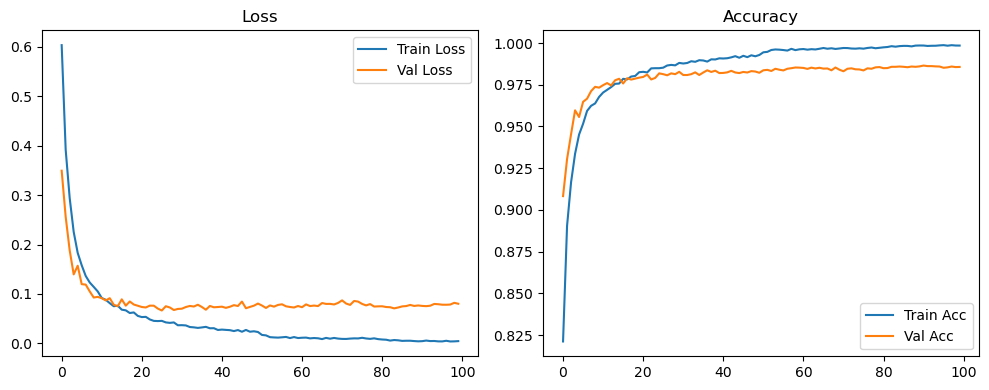

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4306, Acc: 0.8719 | Val Loss: 0.3640, Acc: 0.8985


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2203, Acc: 0.9351 | Val Loss: 0.1744, Acc: 0.9499


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1314, Acc: 0.9595 | Val Loss: 0.1391, Acc: 0.9582


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1028, Acc: 0.9689 | Val Loss: 0.1244, Acc: 0.9639


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0789, Acc: 0.9754 | Val Loss: 0.1496, Acc: 0.9581


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0695, Acc: 0.9778 | Val Loss: 0.1083, Acc: 0.9719


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0578, Acc: 0.9823 | Val Loss: 0.1319, Acc: 0.9676


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0451, Acc: 0.9860 | Val Loss: 0.1450, Acc: 0.9693


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0394, Acc: 0.9875 | Val Loss: 0.1179, Acc: 0.9712


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0334, Acc: 0.9891 | Val Loss: 0.1463, Acc: 0.9672


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0275, Acc: 0.9914 | Val Loss: 0.1245, Acc: 0.9726


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0276, Acc: 0.9912 | Val Loss: 0.1209, Acc: 0.9739


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9921 | Val Loss: 0.1167, Acc: 0.9760


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9923 | Val Loss: 0.1201, Acc: 0.9750


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9932 | Val Loss: 0.1308, Acc: 0.9745


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9940 | Val Loss: 0.1613, Acc: 0.9692


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9935 | Val Loss: 0.1174, Acc: 0.9773


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9940 | Val Loss: 0.1337, Acc: 0.9742


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9949 | Val Loss: 0.1118, Acc: 0.9779


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9962 | Val Loss: 0.1609, Acc: 0.9727


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9945 | Val Loss: 0.1422, Acc: 0.9731


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9951 | Val Loss: 0.1255, Acc: 0.9778


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9961 | Val Loss: 0.1238, Acc: 0.9772


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9964 | Val Loss: 0.1318, Acc: 0.9758


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.1204, Acc: 0.9796


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.1624, Acc: 0.9706


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9960 | Val Loss: 0.1044, Acc: 0.9804


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1058, Acc: 0.9813


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.1199, Acc: 0.9782


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9971 | Val Loss: 0.1052, Acc: 0.9808


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1028, Acc: 0.9812


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1047, Acc: 0.9807


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9967 | Val Loss: 0.1262, Acc: 0.9762


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.1161, Acc: 0.9795


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1250, Acc: 0.9782


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1041, Acc: 0.9811


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9970 | Val Loss: 0.1203, Acc: 0.9792


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1226, Acc: 0.9772


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1033, Acc: 0.9815


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1313, Acc: 0.9765


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1093, Acc: 0.9798


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1167, Acc: 0.9771


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1094, Acc: 0.9798


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1091, Acc: 0.9811


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.1181, Acc: 0.9802


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1384, Acc: 0.9763


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1123, Acc: 0.9807


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1246, Acc: 0.9807


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9987 | Val Loss: 0.1131, Acc: 0.9812


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1148, Acc: 0.9817


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1053, Acc: 0.9831


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0990, Acc: 0.9837


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1068, Acc: 0.9838


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0966, Acc: 0.9845


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1080, Acc: 0.9832


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1026, Acc: 0.9838


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1067, Acc: 0.9844


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1094, Acc: 0.9836


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1141, Acc: 0.9812


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1061, Acc: 0.9829


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1163, Acc: 0.9825


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1270, Acc: 0.9814


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.1171, Acc: 0.9823


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1411, Acc: 0.9794


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1363, Acc: 0.9807


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1150, Acc: 0.9828


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1256, Acc: 0.9813


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1356, Acc: 0.9804


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1220, Acc: 0.9825


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1181, Acc: 0.9822


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1143, Acc: 0.9825


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1129, Acc: 0.9822


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1221, Acc: 0.9810


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1179, Acc: 0.9814


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1146, Acc: 0.9822


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1228, Acc: 0.9820


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1285, Acc: 0.9812


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1159, Acc: 0.9828


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1242, Acc: 0.9818


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1187, Acc: 0.9823


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1148, Acc: 0.9832


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1144, Acc: 0.9832


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1131, Acc: 0.9834


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1129, Acc: 0.9833


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1139, Acc: 0.9842


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1143, Acc: 0.9832


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1119, Acc: 0.9836


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1111, Acc: 0.9832


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1135, Acc: 0.9838


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1129, Acc: 0.9830


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1126, Acc: 0.9837


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1131, Acc: 0.9836


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1126, Acc: 0.9842


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1138, Acc: 0.9839


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1171, Acc: 0.9838


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1121, Acc: 0.9841


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1137, Acc: 0.9839


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1128, Acc: 0.9838


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1171, Acc: 0.9832


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1137, Acc: 0.9839


Final Test Loss: 0.1108 Accuracy: 0.9852


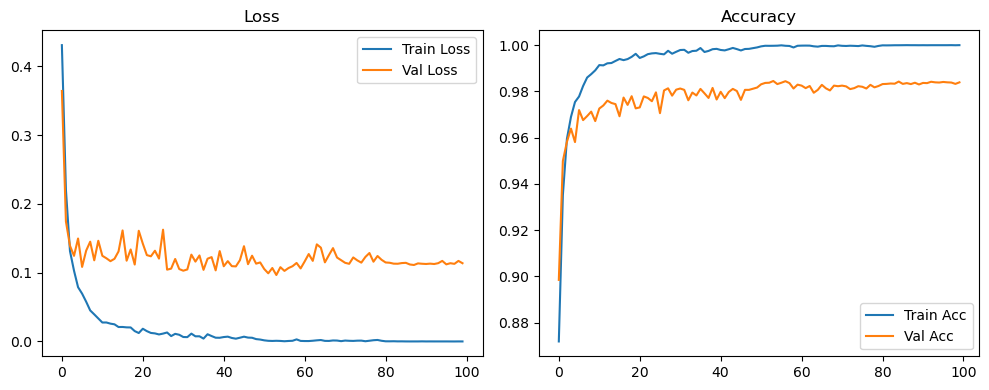

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4774, Acc: 0.8599 | Val Loss: 0.3577, Acc: 0.9038


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2853, Acc: 0.9177 | Val Loss: 0.2124, Acc: 0.9393


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1934, Acc: 0.9434 | Val Loss: 0.1581, Acc: 0.9549


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1493, Acc: 0.9559 | Val Loss: 0.1287, Acc: 0.9633


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1174, Acc: 0.9640 | Val Loss: 0.1283, Acc: 0.9637


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1007, Acc: 0.9678 | Val Loss: 0.1159, Acc: 0.9675


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0862, Acc: 0.9735 | Val Loss: 0.1219, Acc: 0.9686


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0729, Acc: 0.9779 | Val Loss: 0.1117, Acc: 0.9720


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0653, Acc: 0.9792 | Val Loss: 0.1199, Acc: 0.9683


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0570, Acc: 0.9815 | Val Loss: 0.0891, Acc: 0.9764


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0489, Acc: 0.9839 | Val Loss: 0.0952, Acc: 0.9752


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0482, Acc: 0.9835 | Val Loss: 0.0983, Acc: 0.9747


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0462, Acc: 0.9855 | Val Loss: 0.0987, Acc: 0.9755


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0368, Acc: 0.9882 | Val Loss: 0.1010, Acc: 0.9778


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0364, Acc: 0.9879 | Val Loss: 0.0896, Acc: 0.9794


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0346, Acc: 0.9891 | Val Loss: 0.0827, Acc: 0.9792


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9890 | Val Loss: 0.1167, Acc: 0.9757


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9904 | Val Loss: 0.1113, Acc: 0.9749


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9915 | Val Loss: 0.0853, Acc: 0.9809


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9913 | Val Loss: 0.1094, Acc: 0.9776


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9919 | Val Loss: 0.1085, Acc: 0.9778


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0265, Acc: 0.9916 | Val Loss: 0.0996, Acc: 0.9780


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9933 | Val Loss: 0.0961, Acc: 0.9794


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9930 | Val Loss: 0.0994, Acc: 0.9788


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9935 | Val Loss: 0.0952, Acc: 0.9775


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9941 | Val Loss: 0.1058, Acc: 0.9777


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9936 | Val Loss: 0.0965, Acc: 0.9808


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9935 | Val Loss: 0.0881, Acc: 0.9816


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9944 | Val Loss: 0.0864, Acc: 0.9805


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9944 | Val Loss: 0.0896, Acc: 0.9812


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9945 | Val Loss: 0.1133, Acc: 0.9789


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9950 | Val Loss: 0.1024, Acc: 0.9820


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9949 | Val Loss: 0.0942, Acc: 0.9817


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9947 | Val Loss: 0.0926, Acc: 0.9814


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9963 | Val Loss: 0.0905, Acc: 0.9822


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9955 | Val Loss: 0.0909, Acc: 0.9815


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9955 | Val Loss: 0.1017, Acc: 0.9793


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.1004, Acc: 0.9812


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9960 | Val Loss: 0.0955, Acc: 0.9809


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.1010, Acc: 0.9812


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9960 | Val Loss: 0.1091, Acc: 0.9811


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9958 | Val Loss: 0.1031, Acc: 0.9813


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.0977, Acc: 0.9810


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.1016, Acc: 0.9823


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.0933, Acc: 0.9828


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9963 | Val Loss: 0.1002, Acc: 0.9820


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9966 | Val Loss: 0.1011, Acc: 0.9803


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.1036, Acc: 0.9808


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.1075, Acc: 0.9802


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.0989, Acc: 0.9829


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0948, Acc: 0.9828


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.0897, Acc: 0.9829


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0921, Acc: 0.9830


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0959, Acc: 0.9832


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.0965, Acc: 0.9832


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0954, Acc: 0.9841


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0923, Acc: 0.9842


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.0939, Acc: 0.9844


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0926, Acc: 0.9848


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1011, Acc: 0.9831


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1020, Acc: 0.9838


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1038, Acc: 0.9836


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.0984, Acc: 0.9846


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.1092, Acc: 0.9842


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1142, Acc: 0.9831


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1123, Acc: 0.9837


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1144, Acc: 0.9833


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1027, Acc: 0.9839


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0999, Acc: 0.9850


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1101, Acc: 0.9838


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1090, Acc: 0.9832


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1056, Acc: 0.9850


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1032, Acc: 0.9837


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1046, Acc: 0.9845


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1061, Acc: 0.9838


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.1015, Acc: 0.9841


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0991, Acc: 0.9845


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1108, Acc: 0.9850


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.1023, Acc: 0.9843


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0990, Acc: 0.9852


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0944, Acc: 0.9855


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0940, Acc: 0.9864


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0945, Acc: 0.9860


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0934, Acc: 0.9857


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0943, Acc: 0.9862


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0952, Acc: 0.9862


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0927, Acc: 0.9867


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0934, Acc: 0.9868


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0963, Acc: 0.9858


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0937, Acc: 0.9862


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0929, Acc: 0.9860


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0964, Acc: 0.9864


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0964, Acc: 0.9865


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0996, Acc: 0.9860


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0973, Acc: 0.9865


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0980, Acc: 0.9859


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0979, Acc: 0.9854


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0966, Acc: 0.9865


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0952, Acc: 0.9862


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0975, Acc: 0.9860


Final Test Loss: 0.0941 Accuracy: 0.9870


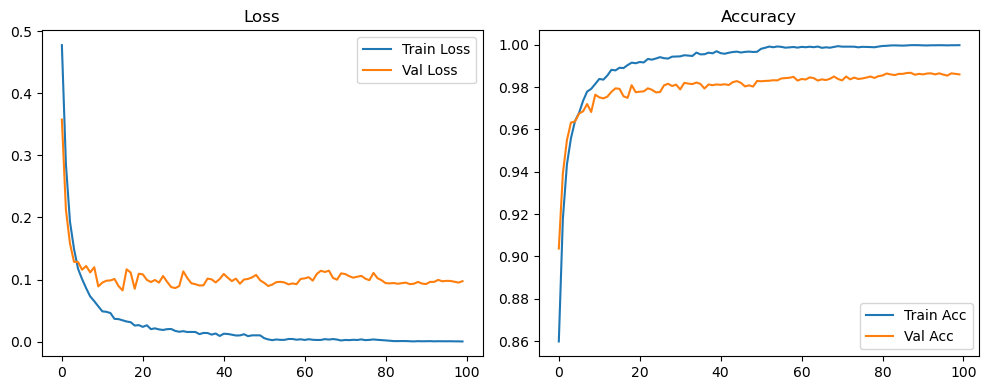

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6032, Acc: 0.8211 | Val Loss: 0.3493, Acc: 0.9083


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3916, Acc: 0.8904 | Val Loss: 0.2559, Acc: 0.9304


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2939, Acc: 0.9165 | Val Loss: 0.1882, Acc: 0.9453


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2255, Acc: 0.9336 | Val Loss: 0.1396, Acc: 0.9597


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1831, Acc: 0.9451 | Val Loss: 0.1570, Acc: 0.9557


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1580, Acc: 0.9516 | Val Loss: 0.1198, Acc: 0.9647


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1364, Acc: 0.9593 | Val Loss: 0.1190, Acc: 0.9667


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1232, Acc: 0.9624 | Val Loss: 0.1052, Acc: 0.9712


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1143, Acc: 0.9638 | Val Loss: 0.0928, Acc: 0.9738


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1051, Acc: 0.9677 | Val Loss: 0.0941, Acc: 0.9732


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0918, Acc: 0.9703 | Val Loss: 0.0915, Acc: 0.9748


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0882, Acc: 0.9719 | Val Loss: 0.0870, Acc: 0.9760


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0814, Acc: 0.9736 | Val Loss: 0.0914, Acc: 0.9746


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0752, Acc: 0.9756 | Val Loss: 0.0782, Acc: 0.9777


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0762, Acc: 0.9757 | Val Loss: 0.0751, Acc: 0.9786


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0682, Acc: 0.9785 | Val Loss: 0.0891, Acc: 0.9758


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0669, Acc: 0.9782 | Val Loss: 0.0763, Acc: 0.9789


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0615, Acc: 0.9799 | Val Loss: 0.0848, Acc: 0.9781


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0627, Acc: 0.9802 | Val Loss: 0.0787, Acc: 0.9787


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0556, Acc: 0.9825 | Val Loss: 0.0762, Acc: 0.9792


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0533, Acc: 0.9828 | Val Loss: 0.0737, Acc: 0.9797


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0537, Acc: 0.9824 | Val Loss: 0.0727, Acc: 0.9811


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9848 | Val Loss: 0.0764, Acc: 0.9782


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9849 | Val Loss: 0.0763, Acc: 0.9791


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0452, Acc: 0.9849 | Val Loss: 0.0704, Acc: 0.9818


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9852 | Val Loss: 0.0666, Acc: 0.9813


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9865 | Val Loss: 0.0752, Acc: 0.9807


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0415, Acc: 0.9869 | Val Loss: 0.0727, Acc: 0.9818


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9866 | Val Loss: 0.0675, Acc: 0.9813


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0367, Acc: 0.9881 | Val Loss: 0.0697, Acc: 0.9828


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9877 | Val Loss: 0.0702, Acc: 0.9808


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0364, Acc: 0.9880 | Val Loss: 0.0736, Acc: 0.9808


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9891 | Val Loss: 0.0757, Acc: 0.9813


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0325, Acc: 0.9888 | Val Loss: 0.0746, Acc: 0.9824


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9897 | Val Loss: 0.0782, Acc: 0.9808


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0323, Acc: 0.9895 | Val Loss: 0.0736, Acc: 0.9823


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0335, Acc: 0.9889 | Val Loss: 0.0682, Acc: 0.9837


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9902 | Val Loss: 0.0757, Acc: 0.9827


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9901 | Val Loss: 0.0731, Acc: 0.9834


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0272, Acc: 0.9908 | Val Loss: 0.0736, Acc: 0.9820


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0280, Acc: 0.9907 | Val Loss: 0.0743, Acc: 0.9821


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9909 | Val Loss: 0.0719, Acc: 0.9824


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9914 | Val Loss: 0.0741, Acc: 0.9833


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9921 | Val Loss: 0.0774, Acc: 0.9823


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9912 | Val Loss: 0.0757, Acc: 0.9820


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9924 | Val Loss: 0.0846, Acc: 0.9827


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9915 | Val Loss: 0.0712, Acc: 0.9823


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9926 | Val Loss: 0.0738, Acc: 0.9832


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9921 | Val Loss: 0.0764, Acc: 0.9829


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0231, Acc: 0.9928 | Val Loss: 0.0806, Acc: 0.9822


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9944 | Val Loss: 0.0766, Acc: 0.9837


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9947 | Val Loss: 0.0717, Acc: 0.9839


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9958 | Val Loss: 0.0768, Acc: 0.9832


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9961 | Val Loss: 0.0744, Acc: 0.9846


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9960 | Val Loss: 0.0778, Acc: 0.9840


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9958 | Val Loss: 0.0791, Acc: 0.9836


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9955 | Val Loss: 0.0750, Acc: 0.9846


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9965 | Val Loss: 0.0737, Acc: 0.9849


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.0726, Acc: 0.9853


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9962 | Val Loss: 0.0756, Acc: 0.9852


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9964 | Val Loss: 0.0732, Acc: 0.9851


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9960 | Val Loss: 0.0789, Acc: 0.9845


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9963 | Val Loss: 0.0756, Acc: 0.9852


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9961 | Val Loss: 0.0765, Acc: 0.9848


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.0755, Acc: 0.9852


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.0817, Acc: 0.9847


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9966 | Val Loss: 0.0799, Acc: 0.9848


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.0800, Acc: 0.9837


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.0788, Acc: 0.9853


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9967 | Val Loss: 0.0819, Acc: 0.9840


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.0870, Acc: 0.9831


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.0807, Acc: 0.9846


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.0779, Acc: 0.9848


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.0858, Acc: 0.9842


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9968 | Val Loss: 0.0846, Acc: 0.9842


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9966 | Val Loss: 0.0799, Acc: 0.9836


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9970 | Val Loss: 0.0769, Acc: 0.9848


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9973 | Val Loss: 0.0795, Acc: 0.9846


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9969 | Val Loss: 0.0746, Acc: 0.9854


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.0749, Acc: 0.9856


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.0740, Acc: 0.9850


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.0730, Acc: 0.9854


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0730, Acc: 0.9859


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.0710, Acc: 0.9855


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.0717, Acc: 0.9858


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.0729, Acc: 0.9852


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0725, Acc: 0.9861


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.0750, Acc: 0.9859


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0743, Acc: 0.9860


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.0742, Acc: 0.9865


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.0737, Acc: 0.9862


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.0728, Acc: 0.9862


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0736, Acc: 0.9860


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0758, Acc: 0.9860


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0750, Acc: 0.9864


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0747, Acc: 0.9861


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9987 | Val Loss: 0.0732, Acc: 0.9860


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0743, Acc: 0.9860


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0760, Acc: 0.9861


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0752, Acc: 0.9858


Final Test Loss: 0.0753 Accuracy: 0.9870


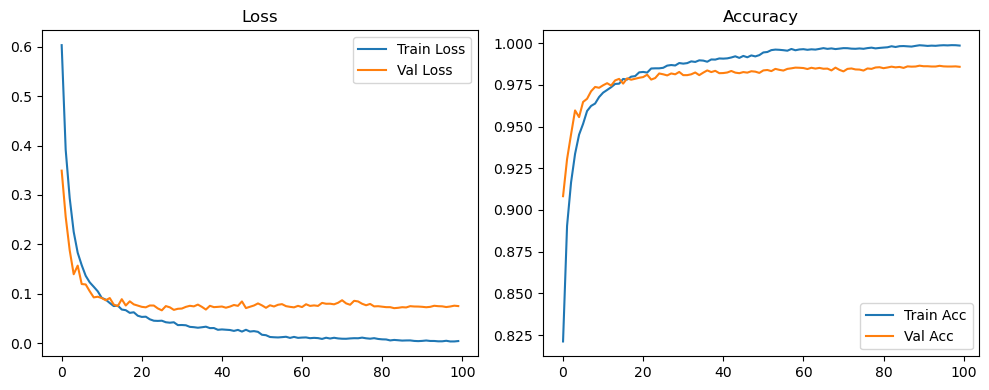

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4306, Acc: 0.8719 | Val Loss: 0.3640, Acc: 0.8985


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2203, Acc: 0.9351 | Val Loss: 0.1744, Acc: 0.9499


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1314, Acc: 0.9595 | Val Loss: 0.1391, Acc: 0.9582


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1028, Acc: 0.9689 | Val Loss: 0.1244, Acc: 0.9639


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0789, Acc: 0.9754 | Val Loss: 0.1496, Acc: 0.9581


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0695, Acc: 0.9778 | Val Loss: 0.1083, Acc: 0.9719


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0578, Acc: 0.9823 | Val Loss: 0.1319, Acc: 0.9676


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0451, Acc: 0.9860 | Val Loss: 0.1450, Acc: 0.9693


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0394, Acc: 0.9875 | Val Loss: 0.1179, Acc: 0.9712


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0334, Acc: 0.9891 | Val Loss: 0.1463, Acc: 0.9672


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0275, Acc: 0.9914 | Val Loss: 0.1245, Acc: 0.9726


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0276, Acc: 0.9912 | Val Loss: 0.1209, Acc: 0.9739


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9921 | Val Loss: 0.1167, Acc: 0.9760


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9923 | Val Loss: 0.1201, Acc: 0.9750


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9932 | Val Loss: 0.1308, Acc: 0.9745


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9940 | Val Loss: 0.1613, Acc: 0.9692


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9935 | Val Loss: 0.1174, Acc: 0.9773


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9940 | Val Loss: 0.1337, Acc: 0.9742


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9949 | Val Loss: 0.1118, Acc: 0.9779


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9962 | Val Loss: 0.1609, Acc: 0.9727


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9945 | Val Loss: 0.1422, Acc: 0.9731


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9951 | Val Loss: 0.1255, Acc: 0.9778


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9961 | Val Loss: 0.1238, Acc: 0.9772


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9964 | Val Loss: 0.1318, Acc: 0.9758


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.1204, Acc: 0.9796


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.1624, Acc: 0.9706


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9960 | Val Loss: 0.1044, Acc: 0.9804


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1058, Acc: 0.9813


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.1199, Acc: 0.9782


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9971 | Val Loss: 0.1052, Acc: 0.9808


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1028, Acc: 0.9812


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1047, Acc: 0.9807


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9967 | Val Loss: 0.1262, Acc: 0.9762


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.1161, Acc: 0.9795


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1250, Acc: 0.9782


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1041, Acc: 0.9811


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9970 | Val Loss: 0.1203, Acc: 0.9792


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1226, Acc: 0.9772


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1033, Acc: 0.9815


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1313, Acc: 0.9765


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1093, Acc: 0.9798


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1167, Acc: 0.9771


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1094, Acc: 0.9798


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1091, Acc: 0.9811


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.1181, Acc: 0.9802


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1384, Acc: 0.9763


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1123, Acc: 0.9807


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1246, Acc: 0.9807


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9987 | Val Loss: 0.1131, Acc: 0.9812


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1148, Acc: 0.9817


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1038, Acc: 0.9823


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1024, Acc: 0.9831


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1044, Acc: 0.9836


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1016, Acc: 0.9831


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1032, Acc: 0.9835


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1035, Acc: 0.9832


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1046, Acc: 0.9838


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1037, Acc: 0.9845


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1098, Acc: 0.9829


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1072, Acc: 0.9830


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1075, Acc: 0.9828


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1072, Acc: 0.9828


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1152, Acc: 0.9828


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1180, Acc: 0.9826


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1098, Acc: 0.9832


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1129, Acc: 0.9834


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1143, Acc: 0.9835


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1108, Acc: 0.9842


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1207, Acc: 0.9823


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1250, Acc: 0.9822


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1245, Acc: 0.9818


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1192, Acc: 0.9828


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1145, Acc: 0.9838


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1154, Acc: 0.9834


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1182, Acc: 0.9823


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1131, Acc: 0.9837


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1119, Acc: 0.9831


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1105, Acc: 0.9842


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1178, Acc: 0.9834


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1210, Acc: 0.9835


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1182, Acc: 0.9832


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1189, Acc: 0.9832


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1162, Acc: 0.9835


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1182, Acc: 0.9840


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1211, Acc: 0.9838


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1186, Acc: 0.9839


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1168, Acc: 0.9843


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1184, Acc: 0.9836


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1172, Acc: 0.9835


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1206, Acc: 0.9824


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1177, Acc: 0.9836


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1238, Acc: 0.9827


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1221, Acc: 0.9834


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1218, Acc: 0.9838


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1223, Acc: 0.9842


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1222, Acc: 0.9842


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1222, Acc: 0.9832


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1219, Acc: 0.9837


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1231, Acc: 0.9835


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1228, Acc: 0.9840


Final Test Loss: 0.1086 Accuracy: 0.9854


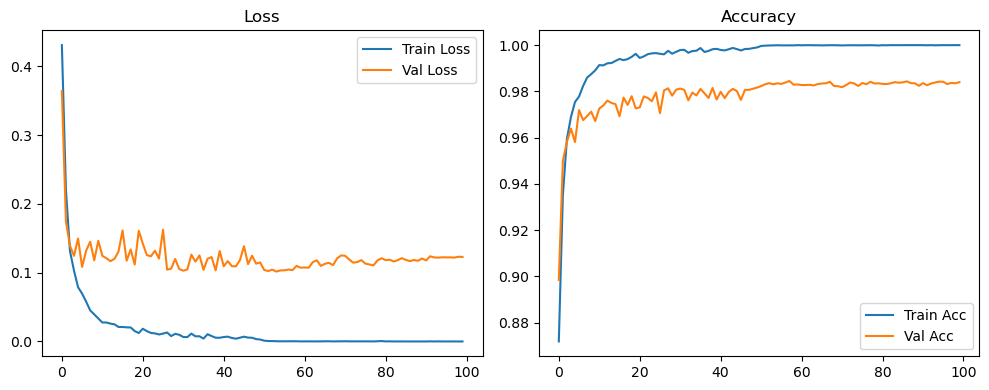

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4774, Acc: 0.8599 | Val Loss: 0.3577, Acc: 0.9038


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2853, Acc: 0.9177 | Val Loss: 0.2124, Acc: 0.9393


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1934, Acc: 0.9434 | Val Loss: 0.1581, Acc: 0.9549


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1493, Acc: 0.9559 | Val Loss: 0.1287, Acc: 0.9633


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1174, Acc: 0.9640 | Val Loss: 0.1283, Acc: 0.9637


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1007, Acc: 0.9678 | Val Loss: 0.1159, Acc: 0.9675


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0862, Acc: 0.9735 | Val Loss: 0.1219, Acc: 0.9686


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0729, Acc: 0.9779 | Val Loss: 0.1117, Acc: 0.9720


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0653, Acc: 0.9792 | Val Loss: 0.1199, Acc: 0.9683


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0570, Acc: 0.9815 | Val Loss: 0.0891, Acc: 0.9764


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0489, Acc: 0.9839 | Val Loss: 0.0952, Acc: 0.9752


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0482, Acc: 0.9835 | Val Loss: 0.0983, Acc: 0.9747


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0462, Acc: 0.9855 | Val Loss: 0.0987, Acc: 0.9755


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0368, Acc: 0.9882 | Val Loss: 0.1010, Acc: 0.9778


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0364, Acc: 0.9879 | Val Loss: 0.0896, Acc: 0.9794


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0346, Acc: 0.9891 | Val Loss: 0.0827, Acc: 0.9792


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9890 | Val Loss: 0.1167, Acc: 0.9757


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9904 | Val Loss: 0.1113, Acc: 0.9749


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9915 | Val Loss: 0.0853, Acc: 0.9809


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9913 | Val Loss: 0.1094, Acc: 0.9776


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9919 | Val Loss: 0.1085, Acc: 0.9778


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0265, Acc: 0.9916 | Val Loss: 0.0996, Acc: 0.9780


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9933 | Val Loss: 0.0961, Acc: 0.9794


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9930 | Val Loss: 0.0994, Acc: 0.9788


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9935 | Val Loss: 0.0952, Acc: 0.9775


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9941 | Val Loss: 0.1058, Acc: 0.9777


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9936 | Val Loss: 0.0965, Acc: 0.9808


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9935 | Val Loss: 0.0881, Acc: 0.9816


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9944 | Val Loss: 0.0864, Acc: 0.9805


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9944 | Val Loss: 0.0896, Acc: 0.9812


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9945 | Val Loss: 0.1133, Acc: 0.9789


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9950 | Val Loss: 0.1024, Acc: 0.9820


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9949 | Val Loss: 0.0942, Acc: 0.9817


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9947 | Val Loss: 0.0926, Acc: 0.9814


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9963 | Val Loss: 0.0905, Acc: 0.9822


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9955 | Val Loss: 0.0909, Acc: 0.9815


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9955 | Val Loss: 0.1017, Acc: 0.9793


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.1004, Acc: 0.9812


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9960 | Val Loss: 0.0955, Acc: 0.9809


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.1010, Acc: 0.9812


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9960 | Val Loss: 0.1091, Acc: 0.9811


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9958 | Val Loss: 0.1031, Acc: 0.9813


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.0977, Acc: 0.9810


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.1016, Acc: 0.9823


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.0933, Acc: 0.9828


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9963 | Val Loss: 0.1002, Acc: 0.9820


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9966 | Val Loss: 0.1011, Acc: 0.9803


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.1036, Acc: 0.9808


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.1075, Acc: 0.9802


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.0989, Acc: 0.9829


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.0921, Acc: 0.9830


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0872, Acc: 0.9844


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.0854, Acc: 0.9838


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0888, Acc: 0.9844


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0909, Acc: 0.9840


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0901, Acc: 0.9846


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0889, Acc: 0.9842


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0888, Acc: 0.9849


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0898, Acc: 0.9849


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0929, Acc: 0.9847


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0946, Acc: 0.9842


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0974, Acc: 0.9849


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0995, Acc: 0.9850


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0961, Acc: 0.9842


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0969, Acc: 0.9840


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0964, Acc: 0.9847


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0983, Acc: 0.9848


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0988, Acc: 0.9846


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1008, Acc: 0.9848


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1014, Acc: 0.9851


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1004, Acc: 0.9848


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0988, Acc: 0.9851


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1000, Acc: 0.9848


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0987, Acc: 0.9848


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1066, Acc: 0.9844


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1059, Acc: 0.9844


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0990, Acc: 0.9848


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0999, Acc: 0.9852


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0990, Acc: 0.9845


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1019, Acc: 0.9843


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0995, Acc: 0.9844


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0996, Acc: 0.9850


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0961, Acc: 0.9852


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0972, Acc: 0.9852


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1002, Acc: 0.9848


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0990, Acc: 0.9847


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0986, Acc: 0.9846


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0997, Acc: 0.9848


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1032, Acc: 0.9853


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1005, Acc: 0.9855


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0991, Acc: 0.9860


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1024, Acc: 0.9851


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1011, Acc: 0.9857


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1022, Acc: 0.9860


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0979, Acc: 0.9865


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1036, Acc: 0.9858


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1043, Acc: 0.9854


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1042, Acc: 0.9862


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1033, Acc: 0.9852


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1003, Acc: 0.9855


Final Test Loss: 0.0923 Accuracy: 0.9867


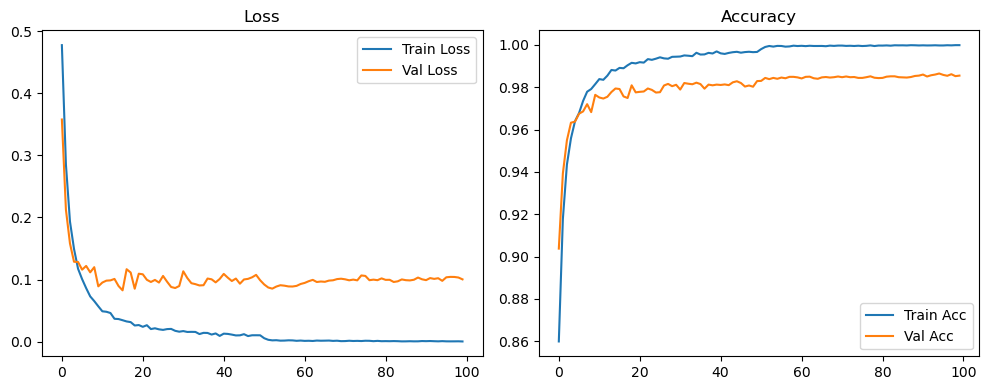

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6032, Acc: 0.8211 | Val Loss: 0.3493, Acc: 0.9083


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3916, Acc: 0.8904 | Val Loss: 0.2559, Acc: 0.9304


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2939, Acc: 0.9165 | Val Loss: 0.1882, Acc: 0.9453


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2255, Acc: 0.9336 | Val Loss: 0.1396, Acc: 0.9597


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1831, Acc: 0.9451 | Val Loss: 0.1570, Acc: 0.9557


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1580, Acc: 0.9516 | Val Loss: 0.1198, Acc: 0.9647


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1364, Acc: 0.9593 | Val Loss: 0.1190, Acc: 0.9667


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1232, Acc: 0.9624 | Val Loss: 0.1052, Acc: 0.9712


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1143, Acc: 0.9638 | Val Loss: 0.0928, Acc: 0.9738


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1051, Acc: 0.9677 | Val Loss: 0.0941, Acc: 0.9732


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0918, Acc: 0.9703 | Val Loss: 0.0915, Acc: 0.9748


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0882, Acc: 0.9719 | Val Loss: 0.0870, Acc: 0.9760


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0814, Acc: 0.9736 | Val Loss: 0.0914, Acc: 0.9746


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0752, Acc: 0.9756 | Val Loss: 0.0782, Acc: 0.9777


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0762, Acc: 0.9757 | Val Loss: 0.0751, Acc: 0.9786


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0682, Acc: 0.9785 | Val Loss: 0.0891, Acc: 0.9758


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0669, Acc: 0.9782 | Val Loss: 0.0763, Acc: 0.9789


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0615, Acc: 0.9799 | Val Loss: 0.0848, Acc: 0.9781


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0627, Acc: 0.9802 | Val Loss: 0.0787, Acc: 0.9787


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0556, Acc: 0.9825 | Val Loss: 0.0762, Acc: 0.9792


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0533, Acc: 0.9828 | Val Loss: 0.0737, Acc: 0.9797


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0537, Acc: 0.9824 | Val Loss: 0.0727, Acc: 0.9811


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9848 | Val Loss: 0.0764, Acc: 0.9782


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9849 | Val Loss: 0.0763, Acc: 0.9791


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0452, Acc: 0.9849 | Val Loss: 0.0704, Acc: 0.9818


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9852 | Val Loss: 0.0666, Acc: 0.9813


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9865 | Val Loss: 0.0752, Acc: 0.9807


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0415, Acc: 0.9869 | Val Loss: 0.0727, Acc: 0.9818


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9866 | Val Loss: 0.0675, Acc: 0.9813


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0367, Acc: 0.9881 | Val Loss: 0.0697, Acc: 0.9828


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9877 | Val Loss: 0.0702, Acc: 0.9808


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0364, Acc: 0.9880 | Val Loss: 0.0736, Acc: 0.9808


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9891 | Val Loss: 0.0757, Acc: 0.9813


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0325, Acc: 0.9888 | Val Loss: 0.0746, Acc: 0.9824


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9897 | Val Loss: 0.0782, Acc: 0.9808


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0323, Acc: 0.9895 | Val Loss: 0.0736, Acc: 0.9823


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0335, Acc: 0.9889 | Val Loss: 0.0682, Acc: 0.9837


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9902 | Val Loss: 0.0757, Acc: 0.9827


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9901 | Val Loss: 0.0731, Acc: 0.9834


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0272, Acc: 0.9908 | Val Loss: 0.0736, Acc: 0.9820


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0280, Acc: 0.9907 | Val Loss: 0.0743, Acc: 0.9821


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9909 | Val Loss: 0.0719, Acc: 0.9824


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9914 | Val Loss: 0.0741, Acc: 0.9833


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9921 | Val Loss: 0.0774, Acc: 0.9823


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9912 | Val Loss: 0.0757, Acc: 0.9820


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9924 | Val Loss: 0.0846, Acc: 0.9827


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9915 | Val Loss: 0.0712, Acc: 0.9823


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9926 | Val Loss: 0.0738, Acc: 0.9832


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9921 | Val Loss: 0.0764, Acc: 0.9829


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0231, Acc: 0.9928 | Val Loss: 0.0806, Acc: 0.9822


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0168, Acc: 0.9947 | Val Loss: 0.0760, Acc: 0.9838


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9952 | Val Loss: 0.0714, Acc: 0.9842


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.0732, Acc: 0.9842


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9966 | Val Loss: 0.0724, Acc: 0.9845


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.0731, Acc: 0.9842


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.0745, Acc: 0.9838


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.0710, Acc: 0.9844


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.0697, Acc: 0.9846


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.0710, Acc: 0.9848


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9971 | Val Loss: 0.0719, Acc: 0.9843


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.0689, Acc: 0.9848


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.0726, Acc: 0.9854


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.0744, Acc: 0.9851


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9974 | Val Loss: 0.0734, Acc: 0.9853


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0731, Acc: 0.9853


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9976 | Val Loss: 0.0756, Acc: 0.9852


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.0778, Acc: 0.9854


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9975 | Val Loss: 0.0774, Acc: 0.9850


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.0750, Acc: 0.9854


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.0768, Acc: 0.9849


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.0785, Acc: 0.9851


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0782, Acc: 0.9856


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.0771, Acc: 0.9856


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.0807, Acc: 0.9850


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.0809, Acc: 0.9851


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9982 | Val Loss: 0.0800, Acc: 0.9845


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0802, Acc: 0.9851


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.0786, Acc: 0.9855


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.0774, Acc: 0.9858


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0772, Acc: 0.9854


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0777, Acc: 0.9850


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.0765, Acc: 0.9858


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0778, Acc: 0.9860


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0755, Acc: 0.9862


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.0758, Acc: 0.9858


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0779, Acc: 0.9852


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.0764, Acc: 0.9856


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.0788, Acc: 0.9861


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0773, Acc: 0.9860


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0775, Acc: 0.9858


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0765, Acc: 0.9863


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0762, Acc: 0.9858


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0768, Acc: 0.9868


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0793, Acc: 0.9852


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0777, Acc: 0.9863


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0788, Acc: 0.9860


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0776, Acc: 0.9858


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.0781, Acc: 0.9858


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0802, Acc: 0.9859


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0783, Acc: 0.9858


Final Test Loss: 0.0764 Accuracy: 0.9867


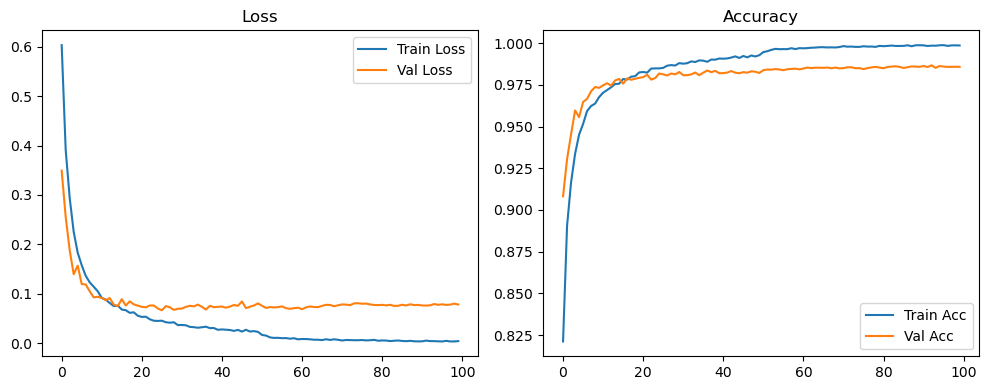

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3785, Acc: 0.8846 | Val Loss: 0.3015, Acc: 0.9162


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2331, Acc: 0.9301 | Val Loss: 0.1868, Acc: 0.9438


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1479, Acc: 0.9551 | Val Loss: 0.1722, Acc: 0.9480


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1196, Acc: 0.9638 | Val Loss: 0.1349, Acc: 0.9588


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0861, Acc: 0.9732 | Val Loss: 0.1490, Acc: 0.9572


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0757, Acc: 0.9758 | Val Loss: 0.1265, Acc: 0.9674


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0693, Acc: 0.9786 | Val Loss: 0.1401, Acc: 0.9638


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0530, Acc: 0.9832 | Val Loss: 0.1219, Acc: 0.9701


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0488, Acc: 0.9839 | Val Loss: 0.1460, Acc: 0.9676


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0432, Acc: 0.9864 | Val Loss: 0.1141, Acc: 0.9740


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9889 | Val Loss: 0.1234, Acc: 0.9746


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0352, Acc: 0.9891 | Val Loss: 0.1518, Acc: 0.9671


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0307, Acc: 0.9904 | Val Loss: 0.1130, Acc: 0.9762


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0337, Acc: 0.9899 | Val Loss: 0.1389, Acc: 0.9718


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9927 | Val Loss: 0.1306, Acc: 0.9748


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0261, Acc: 0.9921 | Val Loss: 0.1468, Acc: 0.9737


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0242, Acc: 0.9928 | Val Loss: 0.1476, Acc: 0.9742


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0216, Acc: 0.9929 | Val Loss: 0.1471, Acc: 0.9734


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9942 | Val Loss: 0.1612, Acc: 0.9744


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9933 | Val Loss: 0.1690, Acc: 0.9730


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9938 | Val Loss: 0.1394, Acc: 0.9784


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9962 | Val Loss: 0.1752, Acc: 0.9743


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0198, Acc: 0.9944 | Val Loss: 0.1690, Acc: 0.9750


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0211, Acc: 0.9941 | Val Loss: 0.1579, Acc: 0.9752


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9959 | Val Loss: 0.1565, Acc: 0.9753


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9966 | Val Loss: 0.1400, Acc: 0.9782


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9961 | Val Loss: 0.1542, Acc: 0.9772


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9954 | Val Loss: 0.1648, Acc: 0.9743


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9961 | Val Loss: 0.1691, Acc: 0.9749


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9959 | Val Loss: 0.1587, Acc: 0.9769


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9967 | Val Loss: 0.1600, Acc: 0.9762


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9967 | Val Loss: 0.1338, Acc: 0.9796


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9963 | Val Loss: 0.1381, Acc: 0.9788


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.1407, Acc: 0.9781


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1599, Acc: 0.9785


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9952 | Val Loss: 0.1808, Acc: 0.9727


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9964 | Val Loss: 0.1473, Acc: 0.9782


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1214, Acc: 0.9804


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1324, Acc: 0.9801


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.1494, Acc: 0.9770


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9972 | Val Loss: 0.1580, Acc: 0.9772


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.1360, Acc: 0.9782


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.1558, Acc: 0.9757


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1475, Acc: 0.9779


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.1494, Acc: 0.9771


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1705, Acc: 0.9769


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1453, Acc: 0.9790


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1462, Acc: 0.9796


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9981 | Val Loss: 0.1496, Acc: 0.9785


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1431, Acc: 0.9807


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.1393, Acc: 0.9819


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1541, Acc: 0.9795


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9981 | Val Loss: 0.1455, Acc: 0.9811


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9984 | Val Loss: 0.1555, Acc: 0.9782


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9975 | Val Loss: 0.1691, Acc: 0.9767


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.1401, Acc: 0.9792


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1416, Acc: 0.9797


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1436, Acc: 0.9798


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9976 | Val Loss: 0.1336, Acc: 0.9793


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1502, Acc: 0.9804


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.1458, Acc: 0.9802


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.1384, Acc: 0.9802


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.1448, Acc: 0.9798


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.1344, Acc: 0.9808


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9979 | Val Loss: 0.1365, Acc: 0.9805


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1290, Acc: 0.9811


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1283, Acc: 0.9802


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.1312, Acc: 0.9800


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1359, Acc: 0.9793


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9991 | Val Loss: 0.1439, Acc: 0.9808


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1229, Acc: 0.9814


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1496, Acc: 0.9800


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1204, Acc: 0.9822


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9992 | Val Loss: 0.1534, Acc: 0.9795


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1443, Acc: 0.9802


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1337, Acc: 0.9805


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1366, Acc: 0.9800


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1468, Acc: 0.9813


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1651, Acc: 0.9788


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1414, Acc: 0.9797


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1452, Acc: 0.9795


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9983 | Val Loss: 0.1352, Acc: 0.9808


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1219, Acc: 0.9828


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1393, Acc: 0.9813


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.1407, Acc: 0.9797


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9979 | Val Loss: 0.1325, Acc: 0.9795


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1260, Acc: 0.9818


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1266, Acc: 0.9817


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9994 | Val Loss: 0.1254, Acc: 0.9821


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1516, Acc: 0.9786


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1240, Acc: 0.9827


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1320, Acc: 0.9813


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1556, Acc: 0.9778


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1267, Acc: 0.9808


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1636, Acc: 0.9782


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1425, Acc: 0.9810


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9991 | Val Loss: 0.1379, Acc: 0.9805


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1298, Acc: 0.9811


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1595, Acc: 0.9780


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1677, Acc: 0.9782


Final Test Loss: 0.1321 Accuracy: 0.9804


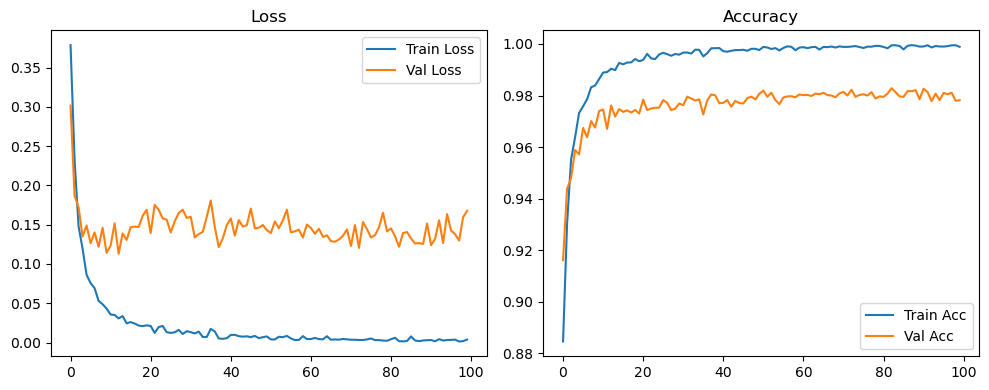

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4235, Acc: 0.8701 | Val Loss: 0.3153, Acc: 0.9139


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.3016, Acc: 0.9106 | Val Loss: 0.2400, Acc: 0.9291


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2212, Acc: 0.9350 | Val Loss: 0.1810, Acc: 0.9468


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1740, Acc: 0.9480 | Val Loss: 0.1463, Acc: 0.9578


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1441, Acc: 0.9568 | Val Loss: 0.1590, Acc: 0.9554


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1212, Acc: 0.9620 | Val Loss: 0.1243, Acc: 0.9647


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1042, Acc: 0.9680 | Val Loss: 0.1234, Acc: 0.9657


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0866, Acc: 0.9732 | Val Loss: 0.1062, Acc: 0.9708


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0816, Acc: 0.9745 | Val Loss: 0.1187, Acc: 0.9686


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0735, Acc: 0.9768 | Val Loss: 0.1046, Acc: 0.9722


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0640, Acc: 0.9801 | Val Loss: 0.1172, Acc: 0.9708


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0571, Acc: 0.9819 | Val Loss: 0.1141, Acc: 0.9738


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0523, Acc: 0.9831 | Val Loss: 0.1049, Acc: 0.9744


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0461, Acc: 0.9851 | Val Loss: 0.1116, Acc: 0.9743


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0456, Acc: 0.9861 | Val Loss: 0.1084, Acc: 0.9748


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0451, Acc: 0.9865 | Val Loss: 0.1251, Acc: 0.9720


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0450, Acc: 0.9853 | Val Loss: 0.1265, Acc: 0.9738


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0353, Acc: 0.9888 | Val Loss: 0.1110, Acc: 0.9759


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0355, Acc: 0.9886 | Val Loss: 0.1081, Acc: 0.9778


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0347, Acc: 0.9895 | Val Loss: 0.1286, Acc: 0.9737


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0332, Acc: 0.9893 | Val Loss: 0.1180, Acc: 0.9767


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0310, Acc: 0.9906 | Val Loss: 0.1125, Acc: 0.9768


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0295, Acc: 0.9906 | Val Loss: 0.1157, Acc: 0.9767


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9923 | Val Loss: 0.1116, Acc: 0.9779


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0278, Acc: 0.9918 | Val Loss: 0.1112, Acc: 0.9777


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9918 | Val Loss: 0.1125, Acc: 0.9786


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0225, Acc: 0.9926 | Val Loss: 0.1070, Acc: 0.9788


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0261, Acc: 0.9920 | Val Loss: 0.1110, Acc: 0.9782


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9933 | Val Loss: 0.1082, Acc: 0.9798


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0185, Acc: 0.9941 | Val Loss: 0.1184, Acc: 0.9790


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9939 | Val Loss: 0.1077, Acc: 0.9793


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9932 | Val Loss: 0.1063, Acc: 0.9802


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0220, Acc: 0.9934 | Val Loss: 0.1330, Acc: 0.9758


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9953 | Val Loss: 0.1181, Acc: 0.9780


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9942 | Val Loss: 0.1110, Acc: 0.9801


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9951 | Val Loss: 0.1085, Acc: 0.9810


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9951 | Val Loss: 0.1226, Acc: 0.9789


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9947 | Val Loss: 0.1133, Acc: 0.9809


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9948 | Val Loss: 0.1061, Acc: 0.9816


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9951 | Val Loss: 0.1178, Acc: 0.9806


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.1129, Acc: 0.9802


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9960 | Val Loss: 0.1094, Acc: 0.9808


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9956 | Val Loss: 0.1151, Acc: 0.9808


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9952 | Val Loss: 0.1138, Acc: 0.9809


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.1187, Acc: 0.9801


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9960 | Val Loss: 0.1136, Acc: 0.9807


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9958 | Val Loss: 0.1183, Acc: 0.9801


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9962 | Val Loss: 0.1220, Acc: 0.9795


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9956 | Val Loss: 0.1228, Acc: 0.9791


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9958 | Val Loss: 0.1172, Acc: 0.9796


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.1077, Acc: 0.9810


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.1141, Acc: 0.9805


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9964 | Val Loss: 0.1100, Acc: 0.9812


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.1263, Acc: 0.9815


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9966 | Val Loss: 0.1064, Acc: 0.9818


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.1253, Acc: 0.9802


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9970 | Val Loss: 0.1137, Acc: 0.9808


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.1055, Acc: 0.9829


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9968 | Val Loss: 0.1226, Acc: 0.9820


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9966 | Val Loss: 0.1040, Acc: 0.9822


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9974 | Val Loss: 0.0971, Acc: 0.9825


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.1086, Acc: 0.9819


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1077, Acc: 0.9805


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1119, Acc: 0.9818


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.1028, Acc: 0.9829


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.1084, Acc: 0.9821


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.1157, Acc: 0.9822


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.1325, Acc: 0.9804


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1096, Acc: 0.9828


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1094, Acc: 0.9824


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1276, Acc: 0.9813


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.1142, Acc: 0.9817


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9983 | Val Loss: 0.1134, Acc: 0.9821


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.1287, Acc: 0.9825


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9980 | Val Loss: 0.1229, Acc: 0.9824


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.1179, Acc: 0.9825


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.1201, Acc: 0.9827


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.1176, Acc: 0.9826


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9976 | Val Loss: 0.1091, Acc: 0.9831


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1079, Acc: 0.9831


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.1192, Acc: 0.9813


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.1225, Acc: 0.9822


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.1273, Acc: 0.9819


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1185, Acc: 0.9815


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1159, Acc: 0.9818


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1055, Acc: 0.9838


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1182, Acc: 0.9811


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9977 | Val Loss: 0.1087, Acc: 0.9832


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1097, Acc: 0.9839


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1241, Acc: 0.9811


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1199, Acc: 0.9817


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1062, Acc: 0.9837


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.1077, Acc: 0.9833


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.1221, Acc: 0.9826


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1127, Acc: 0.9834


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.1059, Acc: 0.9841


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1117, Acc: 0.9833


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.1270, Acc: 0.9832


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1318, Acc: 0.9821


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.1172, Acc: 0.9827


Final Test Loss: 0.1083 Accuracy: 0.9834


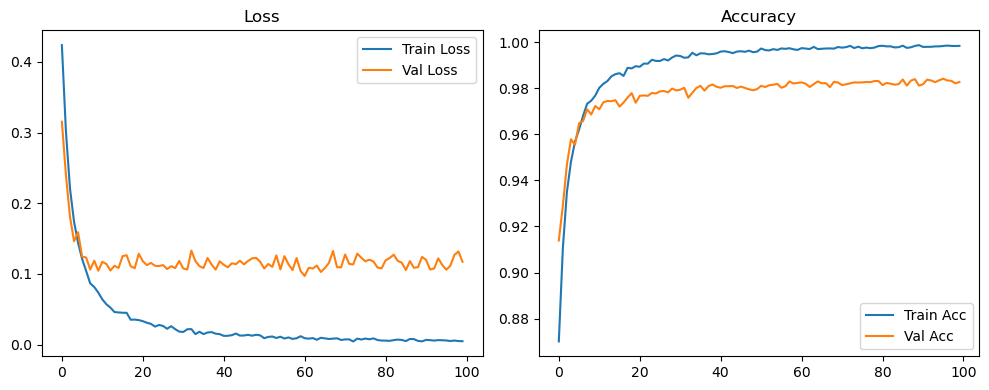

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.5444, Acc: 0.8322 | Val Loss: 0.3289, Acc: 0.9098


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.3965, Acc: 0.8849 | Val Loss: 0.2781, Acc: 0.9230


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.3293, Acc: 0.9042 | Val Loss: 0.2082, Acc: 0.9393


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.2707, Acc: 0.9190 | Val Loss: 0.1706, Acc: 0.9515


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.2244, Acc: 0.9341 | Val Loss: 0.1836, Acc: 0.9479


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1990, Acc: 0.9415 | Val Loss: 0.1423, Acc: 0.9598


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1759, Acc: 0.9478 | Val Loss: 0.1403, Acc: 0.9617


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1549, Acc: 0.9538 | Val Loss: 0.1207, Acc: 0.9688


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1419, Acc: 0.9571 | Val Loss: 0.1140, Acc: 0.9694


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1292, Acc: 0.9611 | Val Loss: 0.1092, Acc: 0.9709


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1169, Acc: 0.9647 | Val Loss: 0.1089, Acc: 0.9722


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1114, Acc: 0.9659 | Val Loss: 0.0993, Acc: 0.9723


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1010, Acc: 0.9688 | Val Loss: 0.0966, Acc: 0.9742


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0947, Acc: 0.9705 | Val Loss: 0.0943, Acc: 0.9757


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0937, Acc: 0.9719 | Val Loss: 0.0929, Acc: 0.9768


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0867, Acc: 0.9735 | Val Loss: 0.0968, Acc: 0.9748


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0808, Acc: 0.9742 | Val Loss: 0.0961, Acc: 0.9758


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0804, Acc: 0.9745 | Val Loss: 0.1039, Acc: 0.9741


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0736, Acc: 0.9769 | Val Loss: 0.0891, Acc: 0.9775


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0651, Acc: 0.9794 | Val Loss: 0.0902, Acc: 0.9788


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0662, Acc: 0.9789 | Val Loss: 0.0855, Acc: 0.9787


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0657, Acc: 0.9796 | Val Loss: 0.0835, Acc: 0.9797


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0583, Acc: 0.9809 | Val Loss: 0.0851, Acc: 0.9796


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0572, Acc: 0.9813 | Val Loss: 0.0879, Acc: 0.9789


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0571, Acc: 0.9815 | Val Loss: 0.0870, Acc: 0.9788


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0491, Acc: 0.9834 | Val Loss: 0.0894, Acc: 0.9798


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0526, Acc: 0.9833 | Val Loss: 0.0960, Acc: 0.9786


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0510, Acc: 0.9839 | Val Loss: 0.0882, Acc: 0.9810


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0491, Acc: 0.9834 | Val Loss: 0.0871, Acc: 0.9792


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0418, Acc: 0.9863 | Val Loss: 0.0863, Acc: 0.9804


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0488, Acc: 0.9847 | Val Loss: 0.0861, Acc: 0.9799


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0421, Acc: 0.9868 | Val Loss: 0.0844, Acc: 0.9793


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0436, Acc: 0.9863 | Val Loss: 0.0853, Acc: 0.9796


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0378, Acc: 0.9877 | Val Loss: 0.0883, Acc: 0.9806


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0392, Acc: 0.9880 | Val Loss: 0.0861, Acc: 0.9803


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0392, Acc: 0.9871 | Val Loss: 0.0939, Acc: 0.9795


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0366, Acc: 0.9882 | Val Loss: 0.0851, Acc: 0.9812


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0354, Acc: 0.9883 | Val Loss: 0.0897, Acc: 0.9805


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0392, Acc: 0.9870 | Val Loss: 0.0860, Acc: 0.9807


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9890 | Val Loss: 0.0851, Acc: 0.9806


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0327, Acc: 0.9887 | Val Loss: 0.0854, Acc: 0.9810


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0335, Acc: 0.9889 | Val Loss: 0.0885, Acc: 0.9813


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0305, Acc: 0.9898 | Val Loss: 0.0874, Acc: 0.9813


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9903 | Val Loss: 0.0859, Acc: 0.9825


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0326, Acc: 0.9892 | Val Loss: 0.0900, Acc: 0.9808


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9892 | Val Loss: 0.0853, Acc: 0.9808


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0317, Acc: 0.9899 | Val Loss: 0.0826, Acc: 0.9816


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0286, Acc: 0.9909 | Val Loss: 0.0851, Acc: 0.9821


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0275, Acc: 0.9910 | Val Loss: 0.0803, Acc: 0.9830


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0282, Acc: 0.9907 | Val Loss: 0.0984, Acc: 0.9803


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0302, Acc: 0.9906 | Val Loss: 0.0848, Acc: 0.9814


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9914 | Val Loss: 0.0876, Acc: 0.9818


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9914 | Val Loss: 0.0865, Acc: 0.9822


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9923 | Val Loss: 0.0854, Acc: 0.9828


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9922 | Val Loss: 0.0900, Acc: 0.9818


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9925 | Val Loss: 0.0917, Acc: 0.9821


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9926 | Val Loss: 0.0866, Acc: 0.9826


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9929 | Val Loss: 0.0823, Acc: 0.9828


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0233, Acc: 0.9923 | Val Loss: 0.0875, Acc: 0.9822


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0254, Acc: 0.9925 | Val Loss: 0.0832, Acc: 0.9831


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9929 | Val Loss: 0.0814, Acc: 0.9834


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9930 | Val Loss: 0.0879, Acc: 0.9819


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0237, Acc: 0.9922 | Val Loss: 0.0868, Acc: 0.9835


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9934 | Val Loss: 0.0878, Acc: 0.9828


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0225, Acc: 0.9929 | Val Loss: 0.0826, Acc: 0.9833


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0203, Acc: 0.9933 | Val Loss: 0.0839, Acc: 0.9835


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9934 | Val Loss: 0.0824, Acc: 0.9825


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0206, Acc: 0.9931 | Val Loss: 0.0827, Acc: 0.9823


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9931 | Val Loss: 0.0805, Acc: 0.9838


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0203, Acc: 0.9938 | Val Loss: 0.0819, Acc: 0.9832


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9942 | Val Loss: 0.0827, Acc: 0.9838


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9942 | Val Loss: 0.0824, Acc: 0.9839


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9953 | Val Loss: 0.0834, Acc: 0.9843


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9933 | Val Loss: 0.0842, Acc: 0.9828


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9940 | Val Loss: 0.0831, Acc: 0.9832


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9944 | Val Loss: 0.0769, Acc: 0.9842


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9939 | Val Loss: 0.0836, Acc: 0.9836


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9941 | Val Loss: 0.0843, Acc: 0.9834


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9948 | Val Loss: 0.0861, Acc: 0.9824


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9950 | Val Loss: 0.0877, Acc: 0.9834


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9938 | Val Loss: 0.0838, Acc: 0.9834


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9948 | Val Loss: 0.0826, Acc: 0.9841


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9950 | Val Loss: 0.0801, Acc: 0.9838


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9949 | Val Loss: 0.0777, Acc: 0.9841


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9949 | Val Loss: 0.0833, Acc: 0.9836


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9950 | Val Loss: 0.0803, Acc: 0.9837


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9948 | Val Loss: 0.0799, Acc: 0.9832


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9951 | Val Loss: 0.0796, Acc: 0.9829


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9954 | Val Loss: 0.0865, Acc: 0.9829


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9951 | Val Loss: 0.0824, Acc: 0.9828


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.0904, Acc: 0.9831


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9953 | Val Loss: 0.0891, Acc: 0.9828


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9948 | Val Loss: 0.0915, Acc: 0.9828


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9951 | Val Loss: 0.0853, Acc: 0.9833


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9950 | Val Loss: 0.0902, Acc: 0.9828


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9959 | Val Loss: 0.0902, Acc: 0.9833


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9954 | Val Loss: 0.0921, Acc: 0.9832


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9951 | Val Loss: 0.0854, Acc: 0.9838


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9960 | Val Loss: 0.0966, Acc: 0.9828


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9956 | Val Loss: 0.0901, Acc: 0.9838


Final Test Loss: 0.0753 Accuracy: 0.9845


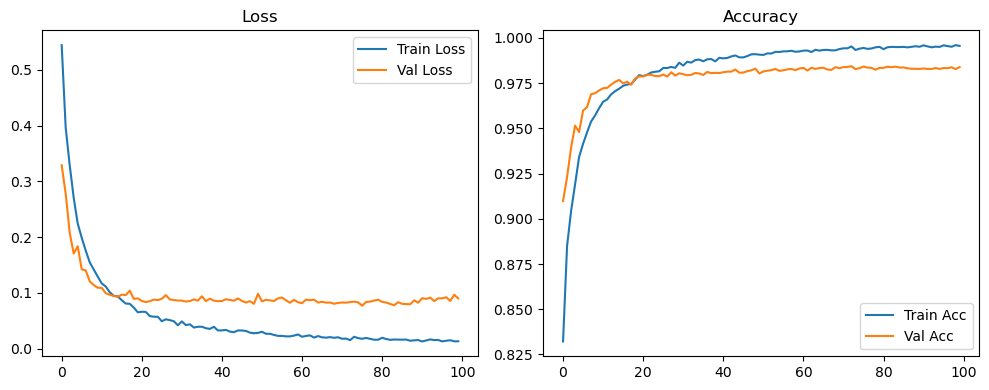

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3785, Acc: 0.8846 | Val Loss: 0.3015, Acc: 0.9162


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2331, Acc: 0.9301 | Val Loss: 0.1868, Acc: 0.9438


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1479, Acc: 0.9551 | Val Loss: 0.1722, Acc: 0.9480


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1196, Acc: 0.9638 | Val Loss: 0.1349, Acc: 0.9588


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0861, Acc: 0.9732 | Val Loss: 0.1490, Acc: 0.9572


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0757, Acc: 0.9758 | Val Loss: 0.1265, Acc: 0.9674


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0693, Acc: 0.9786 | Val Loss: 0.1401, Acc: 0.9638


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0530, Acc: 0.9832 | Val Loss: 0.1219, Acc: 0.9701


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0488, Acc: 0.9839 | Val Loss: 0.1460, Acc: 0.9676


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0432, Acc: 0.9864 | Val Loss: 0.1141, Acc: 0.9740


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9889 | Val Loss: 0.1234, Acc: 0.9746


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0352, Acc: 0.9891 | Val Loss: 0.1518, Acc: 0.9671


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0307, Acc: 0.9904 | Val Loss: 0.1130, Acc: 0.9762


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0337, Acc: 0.9899 | Val Loss: 0.1389, Acc: 0.9718


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9927 | Val Loss: 0.1306, Acc: 0.9748


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0261, Acc: 0.9921 | Val Loss: 0.1468, Acc: 0.9737


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0242, Acc: 0.9928 | Val Loss: 0.1476, Acc: 0.9742


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0216, Acc: 0.9929 | Val Loss: 0.1471, Acc: 0.9734


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9942 | Val Loss: 0.1612, Acc: 0.9744


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9933 | Val Loss: 0.1690, Acc: 0.9730


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9938 | Val Loss: 0.1394, Acc: 0.9784


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9962 | Val Loss: 0.1752, Acc: 0.9743


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0198, Acc: 0.9944 | Val Loss: 0.1690, Acc: 0.9750


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0211, Acc: 0.9941 | Val Loss: 0.1579, Acc: 0.9752


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9959 | Val Loss: 0.1565, Acc: 0.9753


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9966 | Val Loss: 0.1400, Acc: 0.9782


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9961 | Val Loss: 0.1542, Acc: 0.9772


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9954 | Val Loss: 0.1648, Acc: 0.9743


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9961 | Val Loss: 0.1691, Acc: 0.9749


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9959 | Val Loss: 0.1587, Acc: 0.9769


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9967 | Val Loss: 0.1600, Acc: 0.9762


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9967 | Val Loss: 0.1338, Acc: 0.9796


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9963 | Val Loss: 0.1381, Acc: 0.9788


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.1407, Acc: 0.9781


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1599, Acc: 0.9785


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9952 | Val Loss: 0.1808, Acc: 0.9727


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9964 | Val Loss: 0.1473, Acc: 0.9782


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1214, Acc: 0.9804


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1324, Acc: 0.9801


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.1494, Acc: 0.9770


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9972 | Val Loss: 0.1580, Acc: 0.9772


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.1360, Acc: 0.9782


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.1558, Acc: 0.9757


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1475, Acc: 0.9779


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.1494, Acc: 0.9771


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1705, Acc: 0.9769


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1453, Acc: 0.9790


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1462, Acc: 0.9796


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9981 | Val Loss: 0.1496, Acc: 0.9785


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1431, Acc: 0.9807


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1284, Acc: 0.9828


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1307, Acc: 0.9832


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1269, Acc: 0.9837


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1238, Acc: 0.9841


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1225, Acc: 0.9831


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1318, Acc: 0.9823


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1290, Acc: 0.9831


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1342, Acc: 0.9822


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1299, Acc: 0.9832


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1244, Acc: 0.9834


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1318, Acc: 0.9822


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1282, Acc: 0.9832


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1333, Acc: 0.9823


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1441, Acc: 0.9822


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1443, Acc: 0.9821


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1584, Acc: 0.9802


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.1408, Acc: 0.9812


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1501, Acc: 0.9804


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1456, Acc: 0.9820


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1503, Acc: 0.9812


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1478, Acc: 0.9807


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1584, Acc: 0.9818


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.1409, Acc: 0.9821


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1353, Acc: 0.9829


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1480, Acc: 0.9831


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9997 | Val Loss: 0.1577, Acc: 0.9817


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1503, Acc: 0.9815


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1461, Acc: 0.9824


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1543, Acc: 0.9800


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1459, Acc: 0.9821


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1424, Acc: 0.9827


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1390, Acc: 0.9829


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1387, Acc: 0.9835


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1335, Acc: 0.9842


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1351, Acc: 0.9838


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1299, Acc: 0.9848


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1306, Acc: 0.9846


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1376, Acc: 0.9832


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1333, Acc: 0.9837


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1373, Acc: 0.9838


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1354, Acc: 0.9838


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1468, Acc: 0.9824


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1452, Acc: 0.9836


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1395, Acc: 0.9832


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1427, Acc: 0.9835


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1404, Acc: 0.9834


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1422, Acc: 0.9837


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.1396, Acc: 0.9844


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1480, Acc: 0.9819


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1436, Acc: 0.9825


Final Test Loss: 0.1342 Accuracy: 0.9847


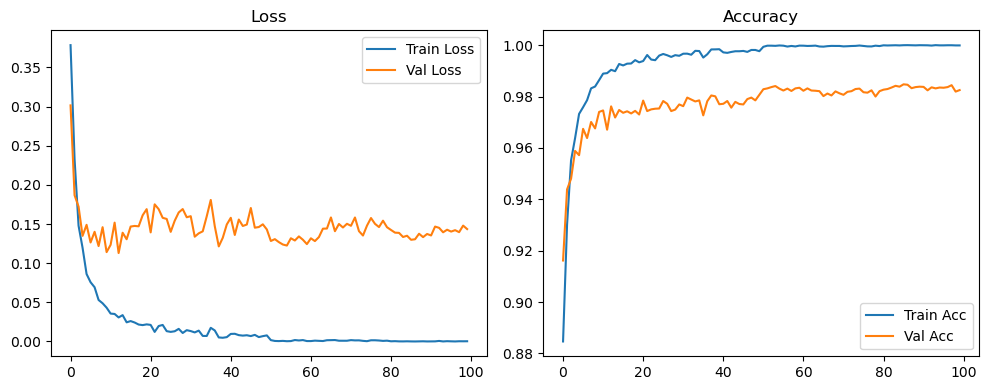

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4235, Acc: 0.8701 | Val Loss: 0.3153, Acc: 0.9139


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.3016, Acc: 0.9106 | Val Loss: 0.2400, Acc: 0.9291


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2212, Acc: 0.9350 | Val Loss: 0.1810, Acc: 0.9468


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1740, Acc: 0.9480 | Val Loss: 0.1463, Acc: 0.9578


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1441, Acc: 0.9568 | Val Loss: 0.1590, Acc: 0.9554


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1212, Acc: 0.9620 | Val Loss: 0.1243, Acc: 0.9647


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1042, Acc: 0.9680 | Val Loss: 0.1234, Acc: 0.9657


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0866, Acc: 0.9732 | Val Loss: 0.1062, Acc: 0.9708


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0816, Acc: 0.9745 | Val Loss: 0.1187, Acc: 0.9686


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0735, Acc: 0.9768 | Val Loss: 0.1046, Acc: 0.9722


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0640, Acc: 0.9801 | Val Loss: 0.1172, Acc: 0.9708


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0571, Acc: 0.9819 | Val Loss: 0.1141, Acc: 0.9738


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0523, Acc: 0.9831 | Val Loss: 0.1049, Acc: 0.9744


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0461, Acc: 0.9851 | Val Loss: 0.1116, Acc: 0.9743


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0456, Acc: 0.9861 | Val Loss: 0.1084, Acc: 0.9748


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0451, Acc: 0.9865 | Val Loss: 0.1251, Acc: 0.9720


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0450, Acc: 0.9853 | Val Loss: 0.1265, Acc: 0.9738


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0353, Acc: 0.9888 | Val Loss: 0.1110, Acc: 0.9759


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0355, Acc: 0.9886 | Val Loss: 0.1081, Acc: 0.9778


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0347, Acc: 0.9895 | Val Loss: 0.1286, Acc: 0.9737


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0332, Acc: 0.9893 | Val Loss: 0.1180, Acc: 0.9767


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0310, Acc: 0.9906 | Val Loss: 0.1125, Acc: 0.9768


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0295, Acc: 0.9906 | Val Loss: 0.1157, Acc: 0.9767


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9923 | Val Loss: 0.1116, Acc: 0.9779


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0278, Acc: 0.9918 | Val Loss: 0.1112, Acc: 0.9777


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9918 | Val Loss: 0.1125, Acc: 0.9786


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0225, Acc: 0.9926 | Val Loss: 0.1070, Acc: 0.9788


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0261, Acc: 0.9920 | Val Loss: 0.1110, Acc: 0.9782


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9933 | Val Loss: 0.1082, Acc: 0.9798


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0185, Acc: 0.9941 | Val Loss: 0.1184, Acc: 0.9790


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9939 | Val Loss: 0.1077, Acc: 0.9793


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9932 | Val Loss: 0.1063, Acc: 0.9802


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0220, Acc: 0.9934 | Val Loss: 0.1330, Acc: 0.9758


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9953 | Val Loss: 0.1181, Acc: 0.9780


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9942 | Val Loss: 0.1110, Acc: 0.9801


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9951 | Val Loss: 0.1085, Acc: 0.9810


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9951 | Val Loss: 0.1226, Acc: 0.9789


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9947 | Val Loss: 0.1133, Acc: 0.9809


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9948 | Val Loss: 0.1061, Acc: 0.9816


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9951 | Val Loss: 0.1178, Acc: 0.9806


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.1129, Acc: 0.9802


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9960 | Val Loss: 0.1094, Acc: 0.9808


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9956 | Val Loss: 0.1151, Acc: 0.9808


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9952 | Val Loss: 0.1138, Acc: 0.9809


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.1187, Acc: 0.9801


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9960 | Val Loss: 0.1136, Acc: 0.9807


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9958 | Val Loss: 0.1183, Acc: 0.9801


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9962 | Val Loss: 0.1220, Acc: 0.9795


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9956 | Val Loss: 0.1228, Acc: 0.9791


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9958 | Val Loss: 0.1172, Acc: 0.9796


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.0932, Acc: 0.9824


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0914, Acc: 0.9832


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9987 | Val Loss: 0.0926, Acc: 0.9838


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1001, Acc: 0.9825


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0939, Acc: 0.9832


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0950, Acc: 0.9832


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0935, Acc: 0.9848


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0982, Acc: 0.9837


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1013, Acc: 0.9841


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1041, Acc: 0.9839


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1000, Acc: 0.9836


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1094, Acc: 0.9839


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1044, Acc: 0.9837


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1029, Acc: 0.9839


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1054, Acc: 0.9837


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1116, Acc: 0.9834


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1042, Acc: 0.9847


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1093, Acc: 0.9834


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.1098, Acc: 0.9842


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.1052, Acc: 0.9840


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1130, Acc: 0.9836


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1077, Acc: 0.9838


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1147, Acc: 0.9831


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1046, Acc: 0.9834


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1311, Acc: 0.9818


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1089, Acc: 0.9842


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1245, Acc: 0.9837


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.1264, Acc: 0.9826


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1161, Acc: 0.9842


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1139, Acc: 0.9848


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1146, Acc: 0.9845


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1135, Acc: 0.9847


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1135, Acc: 0.9840


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1128, Acc: 0.9838


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1157, Acc: 0.9838


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1087, Acc: 0.9845


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1140, Acc: 0.9849


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1166, Acc: 0.9835


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1096, Acc: 0.9844


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1079, Acc: 0.9845


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1113, Acc: 0.9842


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1097, Acc: 0.9846


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1093, Acc: 0.9845


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1155, Acc: 0.9849


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1158, Acc: 0.9842


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1157, Acc: 0.9848


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1204, Acc: 0.9840


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1121, Acc: 0.9855


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1148, Acc: 0.9845


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1219, Acc: 0.9837


Final Test Loss: 0.1123 Accuracy: 0.9855


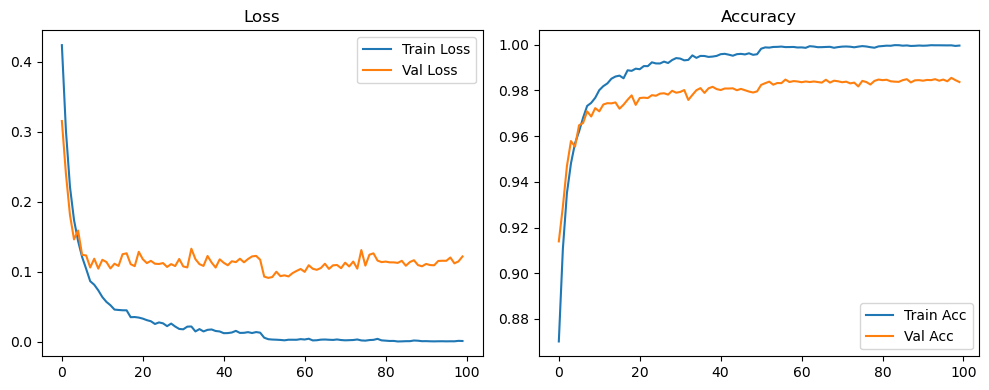

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.5444, Acc: 0.8322 | Val Loss: 0.3289, Acc: 0.9098


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.3965, Acc: 0.8849 | Val Loss: 0.2781, Acc: 0.9230


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.3293, Acc: 0.9042 | Val Loss: 0.2082, Acc: 0.9393


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.2707, Acc: 0.9190 | Val Loss: 0.1706, Acc: 0.9515


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.2244, Acc: 0.9341 | Val Loss: 0.1836, Acc: 0.9479


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1990, Acc: 0.9415 | Val Loss: 0.1423, Acc: 0.9598


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1759, Acc: 0.9478 | Val Loss: 0.1403, Acc: 0.9617


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1549, Acc: 0.9538 | Val Loss: 0.1207, Acc: 0.9688


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1419, Acc: 0.9571 | Val Loss: 0.1140, Acc: 0.9694


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1292, Acc: 0.9611 | Val Loss: 0.1092, Acc: 0.9709


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1169, Acc: 0.9647 | Val Loss: 0.1089, Acc: 0.9722


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1114, Acc: 0.9659 | Val Loss: 0.0993, Acc: 0.9723


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1010, Acc: 0.9688 | Val Loss: 0.0966, Acc: 0.9742


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0947, Acc: 0.9705 | Val Loss: 0.0943, Acc: 0.9757


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0937, Acc: 0.9719 | Val Loss: 0.0929, Acc: 0.9768


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0867, Acc: 0.9735 | Val Loss: 0.0968, Acc: 0.9748


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0808, Acc: 0.9742 | Val Loss: 0.0961, Acc: 0.9758


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0804, Acc: 0.9745 | Val Loss: 0.1039, Acc: 0.9741


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0736, Acc: 0.9769 | Val Loss: 0.0891, Acc: 0.9775


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0651, Acc: 0.9794 | Val Loss: 0.0902, Acc: 0.9788


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0662, Acc: 0.9789 | Val Loss: 0.0855, Acc: 0.9787


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0657, Acc: 0.9796 | Val Loss: 0.0835, Acc: 0.9797


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0583, Acc: 0.9809 | Val Loss: 0.0851, Acc: 0.9796


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0572, Acc: 0.9813 | Val Loss: 0.0879, Acc: 0.9789


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0571, Acc: 0.9815 | Val Loss: 0.0870, Acc: 0.9788


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0491, Acc: 0.9834 | Val Loss: 0.0894, Acc: 0.9798


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0526, Acc: 0.9833 | Val Loss: 0.0960, Acc: 0.9786


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0510, Acc: 0.9839 | Val Loss: 0.0882, Acc: 0.9810


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0491, Acc: 0.9834 | Val Loss: 0.0871, Acc: 0.9792


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0418, Acc: 0.9863 | Val Loss: 0.0863, Acc: 0.9804


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0488, Acc: 0.9847 | Val Loss: 0.0861, Acc: 0.9799


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0421, Acc: 0.9868 | Val Loss: 0.0844, Acc: 0.9793


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0436, Acc: 0.9863 | Val Loss: 0.0853, Acc: 0.9796


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0378, Acc: 0.9877 | Val Loss: 0.0883, Acc: 0.9806


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0392, Acc: 0.9880 | Val Loss: 0.0861, Acc: 0.9803


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0392, Acc: 0.9871 | Val Loss: 0.0939, Acc: 0.9795


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0366, Acc: 0.9882 | Val Loss: 0.0851, Acc: 0.9812


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0354, Acc: 0.9883 | Val Loss: 0.0897, Acc: 0.9805


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0392, Acc: 0.9870 | Val Loss: 0.0860, Acc: 0.9807


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9890 | Val Loss: 0.0851, Acc: 0.9806


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0327, Acc: 0.9887 | Val Loss: 0.0854, Acc: 0.9810


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0335, Acc: 0.9889 | Val Loss: 0.0885, Acc: 0.9813


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0305, Acc: 0.9898 | Val Loss: 0.0874, Acc: 0.9813


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9903 | Val Loss: 0.0859, Acc: 0.9825


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0326, Acc: 0.9892 | Val Loss: 0.0900, Acc: 0.9808


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9892 | Val Loss: 0.0853, Acc: 0.9808


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0317, Acc: 0.9899 | Val Loss: 0.0826, Acc: 0.9816


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0286, Acc: 0.9909 | Val Loss: 0.0851, Acc: 0.9821


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0275, Acc: 0.9910 | Val Loss: 0.0803, Acc: 0.9830


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0282, Acc: 0.9907 | Val Loss: 0.0984, Acc: 0.9803


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0233, Acc: 0.9927 | Val Loss: 0.0827, Acc: 0.9832


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0180, Acc: 0.9935 | Val Loss: 0.0789, Acc: 0.9838


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9945 | Val Loss: 0.0844, Acc: 0.9831


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0152, Acc: 0.9951 | Val Loss: 0.0855, Acc: 0.9833


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9954 | Val Loss: 0.0799, Acc: 0.9845


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9956 | Val Loss: 0.0857, Acc: 0.9838


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9957 | Val Loss: 0.0854, Acc: 0.9837


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9957 | Val Loss: 0.0843, Acc: 0.9842


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0131, Acc: 0.9958 | Val Loss: 0.0845, Acc: 0.9838


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9957 | Val Loss: 0.0853, Acc: 0.9834


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9961 | Val Loss: 0.0840, Acc: 0.9849


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.0877, Acc: 0.9836


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9963 | Val Loss: 0.0890, Acc: 0.9842


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.0874, Acc: 0.9837


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9958 | Val Loss: 0.0812, Acc: 0.9838


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.0819, Acc: 0.9832


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9962 | Val Loss: 0.0902, Acc: 0.9826


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.0880, Acc: 0.9829


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.0854, Acc: 0.9836


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.0880, Acc: 0.9837


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.0871, Acc: 0.9838


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.0897, Acc: 0.9846


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9971 | Val Loss: 0.0859, Acc: 0.9840


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.0885, Acc: 0.9836


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.0913, Acc: 0.9838


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9967 | Val Loss: 0.0920, Acc: 0.9838


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9967 | Val Loss: 0.0899, Acc: 0.9842


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.0897, Acc: 0.9839


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.0890, Acc: 0.9837


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9970 | Val Loss: 0.0925, Acc: 0.9830


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.0895, Acc: 0.9838


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.0881, Acc: 0.9837


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.0884, Acc: 0.9842


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0880, Acc: 0.9842


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.0889, Acc: 0.9846


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.0879, Acc: 0.9851


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0880, Acc: 0.9838


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.0881, Acc: 0.9847


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9981 | Val Loss: 0.0883, Acc: 0.9844


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.0853, Acc: 0.9848


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.0854, Acc: 0.9852


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.0895, Acc: 0.9847


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0919, Acc: 0.9842


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9977 | Val Loss: 0.0914, Acc: 0.9847


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0938, Acc: 0.9842


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.0892, Acc: 0.9846


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9983 | Val Loss: 0.0887, Acc: 0.9844


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.0882, Acc: 0.9849


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0894, Acc: 0.9848


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0887, Acc: 0.9849


Final Test Loss: 0.0790 Accuracy: 0.9869


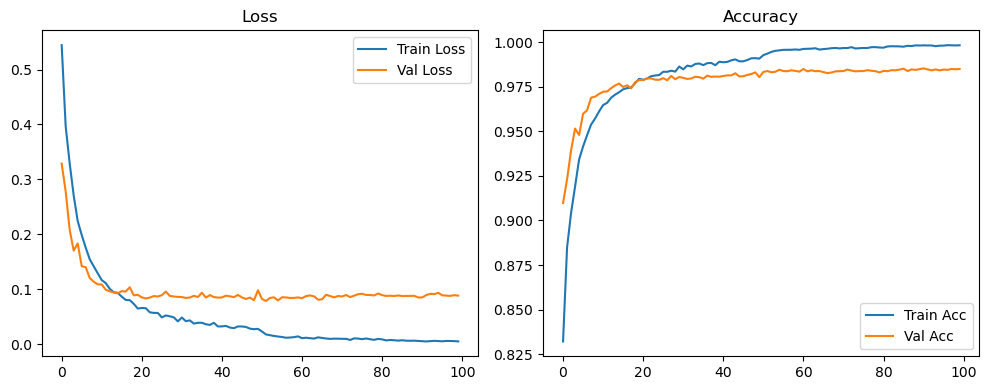

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.3588, Acc: 0.8937 | Val Loss: 0.2725, Acc: 0.9220


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.2421, Acc: 0.9272 | Val Loss: 0.2394, Acc: 0.9277


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1713, Acc: 0.9480 | Val Loss: 0.1854, Acc: 0.9428


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1339, Acc: 0.9584 | Val Loss: 0.1372, Acc: 0.9577


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1036, Acc: 0.9681 | Val Loss: 0.1625, Acc: 0.9503


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0877, Acc: 0.9719 | Val Loss: 0.1247, Acc: 0.9632


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0717, Acc: 0.9774 | Val Loss: 0.1483, Acc: 0.9574


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0641, Acc: 0.9786 | Val Loss: 0.1245, Acc: 0.9661


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0498, Acc: 0.9833 | Val Loss: 0.1261, Acc: 0.9647


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0439, Acc: 0.9853 | Val Loss: 0.1113, Acc: 0.9705


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0434, Acc: 0.9851 | Val Loss: 0.1211, Acc: 0.9703


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0348, Acc: 0.9887 | Val Loss: 0.1246, Acc: 0.9708


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0312, Acc: 0.9891 | Val Loss: 0.1114, Acc: 0.9724


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0301, Acc: 0.9896 | Val Loss: 0.1380, Acc: 0.9669


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0292, Acc: 0.9902 | Val Loss: 0.1218, Acc: 0.9716


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0261, Acc: 0.9910 | Val Loss: 0.1379, Acc: 0.9673


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0197, Acc: 0.9935 | Val Loss: 0.1191, Acc: 0.9748


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0224, Acc: 0.9928 | Val Loss: 0.1258, Acc: 0.9738


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0219, Acc: 0.9924 | Val Loss: 0.1223, Acc: 0.9754


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0186, Acc: 0.9941 | Val Loss: 0.1170, Acc: 0.9771


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0178, Acc: 0.9941 | Val Loss: 0.1580, Acc: 0.9713


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0210, Acc: 0.9931 | Val Loss: 0.1545, Acc: 0.9711


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9943 | Val Loss: 0.1315, Acc: 0.9738


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0189, Acc: 0.9936 | Val Loss: 0.1593, Acc: 0.9705


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0170, Acc: 0.9942 | Val Loss: 0.1402, Acc: 0.9746


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0131, Acc: 0.9961 | Val Loss: 0.1637, Acc: 0.9731


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9940 | Val Loss: 0.1519, Acc: 0.9727


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.1375, Acc: 0.9772


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9957 | Val Loss: 0.1557, Acc: 0.9744


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0144, Acc: 0.9955 | Val Loss: 0.1651, Acc: 0.9717


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0146, Acc: 0.9956 | Val Loss: 0.1564, Acc: 0.9777


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0141, Acc: 0.9956 | Val Loss: 0.1456, Acc: 0.9768


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9968 | Val Loss: 0.1505, Acc: 0.9784


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.1577, Acc: 0.9770


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.1473, Acc: 0.9778


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9962 | Val Loss: 0.1728, Acc: 0.9748


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0162, Acc: 0.9952 | Val Loss: 0.1658, Acc: 0.9761


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.1778, Acc: 0.9745


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9969 | Val Loss: 0.1527, Acc: 0.9771


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1601, Acc: 0.9767


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.1796, Acc: 0.9769


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0148, Acc: 0.9955 | Val Loss: 0.1661, Acc: 0.9748


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1661, Acc: 0.9782


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9971 | Val Loss: 0.1732, Acc: 0.9767


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9966 | Val Loss: 0.1827, Acc: 0.9756


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1680, Acc: 0.9766


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9976 | Val Loss: 0.1821, Acc: 0.9762


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1736, Acc: 0.9783


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9974 | Val Loss: 0.1832, Acc: 0.9776


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9973 | Val Loss: 0.1861, Acc: 0.9761


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9973 | Val Loss: 0.1751, Acc: 0.9764


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1852, Acc: 0.9757


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9976 | Val Loss: 0.1703, Acc: 0.9799


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1650, Acc: 0.9812


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1799, Acc: 0.9778


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9972 | Val Loss: 0.2141, Acc: 0.9727


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.1754, Acc: 0.9786


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1819, Acc: 0.9790


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1582, Acc: 0.9810


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.2224, Acc: 0.9736


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9977 | Val Loss: 0.1866, Acc: 0.9772


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9979 | Val Loss: 0.2286, Acc: 0.9742


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9972 | Val Loss: 0.1909, Acc: 0.9779


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9978 | Val Loss: 0.1959, Acc: 0.9787


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 0.1705, Acc: 0.9802


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1883, Acc: 0.9784


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.2174, Acc: 0.9764


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9982 | Val Loss: 0.1937, Acc: 0.9790


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9983 | Val Loss: 0.1902, Acc: 0.9795


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9982 | Val Loss: 0.2011, Acc: 0.9792


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1896, Acc: 0.9799


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9984 | Val Loss: 0.2100, Acc: 0.9792


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9982 | Val Loss: 0.1801, Acc: 0.9805


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1835, Acc: 0.9788


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.2091, Acc: 0.9782


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9973 | Val Loss: 0.2560, Acc: 0.9747


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9982 | Val Loss: 0.2088, Acc: 0.9786


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1861, Acc: 0.9807


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9984 | Val Loss: 0.2035, Acc: 0.9784


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9984 | Val Loss: 0.1893, Acc: 0.9791


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.2016, Acc: 0.9794


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9984 | Val Loss: 0.2014, Acc: 0.9781


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9982 | Val Loss: 0.2098, Acc: 0.9782


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.2072, Acc: 0.9785


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.1849, Acc: 0.9804


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9988 | Val Loss: 0.1922, Acc: 0.9782


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9985 | Val Loss: 0.2119, Acc: 0.9790


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9981 | Val Loss: 0.2087, Acc: 0.9791


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1968, Acc: 0.9798


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9987 | Val Loss: 0.1959, Acc: 0.9790


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.1961, Acc: 0.9802


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.2024, Acc: 0.9808


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.2211, Acc: 0.9785


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9986 | Val Loss: 0.2210, Acc: 0.9791


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.2484, Acc: 0.9757


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9985 | Val Loss: 0.2124, Acc: 0.9788


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9986 | Val Loss: 0.2325, Acc: 0.9765


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9988 | Val Loss: 0.2168, Acc: 0.9773


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9992 | Val Loss: 0.2020, Acc: 0.9793


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.2067, Acc: 0.9782


Final Test Loss: 0.1814 Accuracy: 0.9809


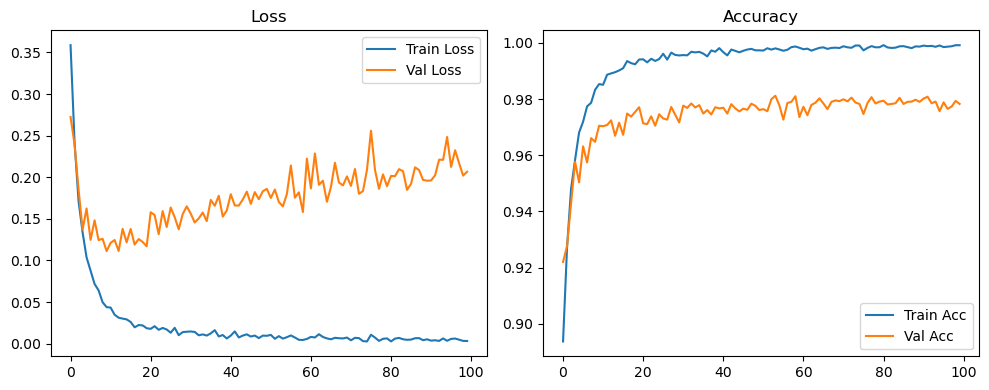

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.4059, Acc: 0.8789 | Val Loss: 0.2945, Acc: 0.9166


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.3014, Acc: 0.9089 | Val Loss: 0.2778, Acc: 0.9157


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.2452, Acc: 0.9271 | Val Loss: 0.2071, Acc: 0.9368


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.2033, Acc: 0.9378 | Val Loss: 0.1773, Acc: 0.9461


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1734, Acc: 0.9461 | Val Loss: 0.1823, Acc: 0.9481


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.1479, Acc: 0.9539 | Val Loss: 0.1478, Acc: 0.9583


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.1293, Acc: 0.9595 | Val Loss: 0.1388, Acc: 0.9605


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.1095, Acc: 0.9658 | Val Loss: 0.1287, Acc: 0.9633


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0990, Acc: 0.9682 | Val Loss: 0.1158, Acc: 0.9670


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0881, Acc: 0.9717 | Val Loss: 0.1131, Acc: 0.9692


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0763, Acc: 0.9755 | Val Loss: 0.1069, Acc: 0.9718


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0731, Acc: 0.9765 | Val Loss: 0.1130, Acc: 0.9701


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0627, Acc: 0.9793 | Val Loss: 0.1112, Acc: 0.9708


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0603, Acc: 0.9806 | Val Loss: 0.1088, Acc: 0.9712


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0590, Acc: 0.9802 | Val Loss: 0.0946, Acc: 0.9756


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0543, Acc: 0.9821 | Val Loss: 0.1383, Acc: 0.9639


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0508, Acc: 0.9832 | Val Loss: 0.1165, Acc: 0.9715


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0471, Acc: 0.9847 | Val Loss: 0.1127, Acc: 0.9740


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0405, Acc: 0.9859 | Val Loss: 0.1105, Acc: 0.9742


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0357, Acc: 0.9882 | Val Loss: 0.1085, Acc: 0.9752


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0400, Acc: 0.9862 | Val Loss: 0.1208, Acc: 0.9734


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0377, Acc: 0.9878 | Val Loss: 0.1141, Acc: 0.9751


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0305, Acc: 0.9903 | Val Loss: 0.1048, Acc: 0.9789


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9903 | Val Loss: 0.1116, Acc: 0.9769


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0285, Acc: 0.9904 | Val Loss: 0.1227, Acc: 0.9752


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0279, Acc: 0.9908 | Val Loss: 0.1146, Acc: 0.9758


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0281, Acc: 0.9905 | Val Loss: 0.1246, Acc: 0.9761


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0291, Acc: 0.9899 | Val Loss: 0.1108, Acc: 0.9765


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0305, Acc: 0.9906 | Val Loss: 0.1143, Acc: 0.9755


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0243, Acc: 0.9922 | Val Loss: 0.1188, Acc: 0.9763


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0222, Acc: 0.9927 | Val Loss: 0.1149, Acc: 0.9765


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0234, Acc: 0.9922 | Val Loss: 0.1311, Acc: 0.9758


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0258, Acc: 0.9916 | Val Loss: 0.1224, Acc: 0.9776


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0196, Acc: 0.9934 | Val Loss: 0.1180, Acc: 0.9773


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0191, Acc: 0.9941 | Val Loss: 0.1248, Acc: 0.9777


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0191, Acc: 0.9937 | Val Loss: 0.1210, Acc: 0.9780


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0210, Acc: 0.9930 | Val Loss: 0.1248, Acc: 0.9778


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0182, Acc: 0.9945 | Val Loss: 0.1117, Acc: 0.9789


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0252, Acc: 0.9924 | Val Loss: 0.1422, Acc: 0.9758


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0197, Acc: 0.9938 | Val Loss: 0.1265, Acc: 0.9780


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9954 | Val Loss: 0.1274, Acc: 0.9785


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0201, Acc: 0.9940 | Val Loss: 0.1254, Acc: 0.9783


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9948 | Val Loss: 0.1360, Acc: 0.9784


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0131, Acc: 0.9955 | Val Loss: 0.1174, Acc: 0.9812


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9951 | Val Loss: 0.1302, Acc: 0.9782


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9945 | Val Loss: 0.1257, Acc: 0.9796


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0181, Acc: 0.9945 | Val Loss: 0.1354, Acc: 0.9792


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0183, Acc: 0.9947 | Val Loss: 0.1420, Acc: 0.9783


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9956 | Val Loss: 0.1295, Acc: 0.9805


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9957 | Val Loss: 0.1290, Acc: 0.9805


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0169, Acc: 0.9950 | Val Loss: 0.1418, Acc: 0.9798


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9959 | Val Loss: 0.1267, Acc: 0.9808


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9956 | Val Loss: 0.1343, Acc: 0.9792


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9962 | Val Loss: 0.1394, Acc: 0.9792


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9972 | Val Loss: 0.1270, Acc: 0.9801


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9961 | Val Loss: 0.1386, Acc: 0.9776


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9958 | Val Loss: 0.1300, Acc: 0.9808


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9961 | Val Loss: 0.1430, Acc: 0.9795


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0128, Acc: 0.9962 | Val Loss: 0.1321, Acc: 0.9806


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.1330, Acc: 0.9799


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0143, Acc: 0.9957 | Val Loss: 0.1485, Acc: 0.9801


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9965 | Val Loss: 0.1396, Acc: 0.9799


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9965 | Val Loss: 0.1402, Acc: 0.9789


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9962 | Val Loss: 0.1422, Acc: 0.9794


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.1371, Acc: 0.9798


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9969 | Val Loss: 0.1302, Acc: 0.9808


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.1433, Acc: 0.9792


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9966 | Val Loss: 0.1732, Acc: 0.9761


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9967 | Val Loss: 0.1380, Acc: 0.9807


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.1431, Acc: 0.9798


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9972 | Val Loss: 0.1578, Acc: 0.9791


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9973 | Val Loss: 0.1375, Acc: 0.9814


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.1593, Acc: 0.9798


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9959 | Val Loss: 0.1424, Acc: 0.9817


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9970 | Val Loss: 0.1396, Acc: 0.9805


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9974 | Val Loss: 0.1364, Acc: 0.9816


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9969 | Val Loss: 0.1304, Acc: 0.9825


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.1298, Acc: 0.9827


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1369, Acc: 0.9826


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.1424, Acc: 0.9817


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9978 | Val Loss: 0.1397, Acc: 0.9818


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9971 | Val Loss: 0.1439, Acc: 0.9818


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9968 | Val Loss: 0.1352, Acc: 0.9828


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9979 | Val Loss: 0.1421, Acc: 0.9824


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.1422, Acc: 0.9812


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9977 | Val Loss: 0.1350, Acc: 0.9818


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9970 | Val Loss: 0.1514, Acc: 0.9807


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9978 | Val Loss: 0.1439, Acc: 0.9812


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.1472, Acc: 0.9814


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9981 | Val Loss: 0.1342, Acc: 0.9822


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9980 | Val Loss: 0.1448, Acc: 0.9818


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9979 | Val Loss: 0.1370, Acc: 0.9820


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9977 | Val Loss: 0.1272, Acc: 0.9836


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9971 | Val Loss: 0.1477, Acc: 0.9829


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.1507, Acc: 0.9814


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.1499, Acc: 0.9829


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1329, Acc: 0.9836


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1389, Acc: 0.9813


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9975 | Val Loss: 0.1611, Acc: 0.9813


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1531, Acc: 0.9813


Final Test Loss: 0.1155 Accuracy: 0.9828


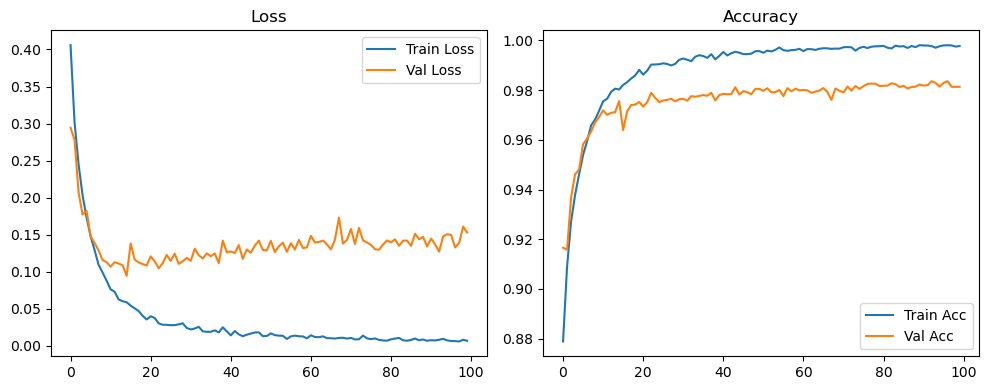

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.5377, Acc: 0.8344 | Val Loss: 0.3283, Acc: 0.9037


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.3932, Acc: 0.8828 | Val Loss: 0.2825, Acc: 0.9185


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.3434, Acc: 0.8966 | Val Loss: 0.2361, Acc: 0.9310


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.3048, Acc: 0.9091 | Val Loss: 0.2161, Acc: 0.9358


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.2689, Acc: 0.9191 | Val Loss: 0.2108, Acc: 0.9397


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.2404, Acc: 0.9265 | Val Loss: 0.1794, Acc: 0.9486


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.2166, Acc: 0.9342 | Val Loss: 0.1713, Acc: 0.9507


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.1955, Acc: 0.9406 | Val Loss: 0.1492, Acc: 0.9584


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.1799, Acc: 0.9463 | Val Loss: 0.1374, Acc: 0.9612


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.1649, Acc: 0.9490 | Val Loss: 0.1281, Acc: 0.9634


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.1482, Acc: 0.9544 | Val Loss: 0.1291, Acc: 0.9650


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.1395, Acc: 0.9575 | Val Loss: 0.1156, Acc: 0.9679


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.1291, Acc: 0.9601 | Val Loss: 0.1140, Acc: 0.9686


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.1236, Acc: 0.9623 | Val Loss: 0.1115, Acc: 0.9688


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.1173, Acc: 0.9628 | Val Loss: 0.1007, Acc: 0.9721


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.1084, Acc: 0.9669 | Val Loss: 0.1092, Acc: 0.9708


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.1018, Acc: 0.9679 | Val Loss: 0.1039, Acc: 0.9729


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0974, Acc: 0.9692 | Val Loss: 0.1081, Acc: 0.9712


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0923, Acc: 0.9703 | Val Loss: 0.0991, Acc: 0.9735


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0881, Acc: 0.9728 | Val Loss: 0.1032, Acc: 0.9735


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0830, Acc: 0.9729 | Val Loss: 0.1010, Acc: 0.9746


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0818, Acc: 0.9738 | Val Loss: 0.1006, Acc: 0.9758


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0763, Acc: 0.9764 | Val Loss: 0.1043, Acc: 0.9733


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0773, Acc: 0.9749 | Val Loss: 0.1036, Acc: 0.9751


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0692, Acc: 0.9778 | Val Loss: 0.0927, Acc: 0.9764


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0683, Acc: 0.9780 | Val Loss: 0.0973, Acc: 0.9761


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0671, Acc: 0.9792 | Val Loss: 0.0973, Acc: 0.9767


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0681, Acc: 0.9782 | Val Loss: 0.1011, Acc: 0.9761


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0638, Acc: 0.9794 | Val Loss: 0.1024, Acc: 0.9752


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0586, Acc: 0.9807 | Val Loss: 0.0960, Acc: 0.9781


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0590, Acc: 0.9810 | Val Loss: 0.0938, Acc: 0.9770


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0577, Acc: 0.9816 | Val Loss: 0.0914, Acc: 0.9791


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0556, Acc: 0.9825 | Val Loss: 0.0926, Acc: 0.9776


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0517, Acc: 0.9833 | Val Loss: 0.0980, Acc: 0.9787


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0509, Acc: 0.9835 | Val Loss: 0.0959, Acc: 0.9787


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0468, Acc: 0.9849 | Val Loss: 0.0947, Acc: 0.9789


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0499, Acc: 0.9848 | Val Loss: 0.0944, Acc: 0.9787


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0477, Acc: 0.9851 | Val Loss: 0.1083, Acc: 0.9767


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0494, Acc: 0.9841 | Val Loss: 0.0973, Acc: 0.9785


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0426, Acc: 0.9856 | Val Loss: 0.0950, Acc: 0.9782


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0428, Acc: 0.9856 | Val Loss: 0.0988, Acc: 0.9791


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0477, Acc: 0.9852 | Val Loss: 0.0960, Acc: 0.9791


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0382, Acc: 0.9880 | Val Loss: 0.0908, Acc: 0.9808


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0410, Acc: 0.9863 | Val Loss: 0.0960, Acc: 0.9801


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0410, Acc: 0.9866 | Val Loss: 0.1029, Acc: 0.9778


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0395, Acc: 0.9871 | Val Loss: 0.1000, Acc: 0.9793


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0367, Acc: 0.9878 | Val Loss: 0.1060, Acc: 0.9797


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0399, Acc: 0.9872 | Val Loss: 0.0984, Acc: 0.9800


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0386, Acc: 0.9883 | Val Loss: 0.0988, Acc: 0.9789


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0344, Acc: 0.9890 | Val Loss: 0.1003, Acc: 0.9792


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0345, Acc: 0.9891 | Val Loss: 0.0993, Acc: 0.9798


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0377, Acc: 0.9880 | Val Loss: 0.1022, Acc: 0.9798


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0313, Acc: 0.9899 | Val Loss: 0.1002, Acc: 0.9798


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0332, Acc: 0.9892 | Val Loss: 0.1033, Acc: 0.9796


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0311, Acc: 0.9900 | Val Loss: 0.1040, Acc: 0.9811


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0326, Acc: 0.9900 | Val Loss: 0.1039, Acc: 0.9798


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0325, Acc: 0.9895 | Val Loss: 0.0984, Acc: 0.9810


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0323, Acc: 0.9898 | Val Loss: 0.0921, Acc: 0.9820


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0327, Acc: 0.9892 | Val Loss: 0.1022, Acc: 0.9821


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0303, Acc: 0.9903 | Val Loss: 0.1049, Acc: 0.9798


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0293, Acc: 0.9913 | Val Loss: 0.1000, Acc: 0.9815


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0298, Acc: 0.9907 | Val Loss: 0.0909, Acc: 0.9810


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0277, Acc: 0.9911 | Val Loss: 0.0987, Acc: 0.9800


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0262, Acc: 0.9911 | Val Loss: 0.1018, Acc: 0.9820


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0285, Acc: 0.9912 | Val Loss: 0.0945, Acc: 0.9803


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9912 | Val Loss: 0.1005, Acc: 0.9811


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0265, Acc: 0.9914 | Val Loss: 0.1006, Acc: 0.9815


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0265, Acc: 0.9917 | Val Loss: 0.1053, Acc: 0.9818


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0282, Acc: 0.9912 | Val Loss: 0.0973, Acc: 0.9823


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0262, Acc: 0.9915 | Val Loss: 0.0955, Acc: 0.9819


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0253, Acc: 0.9923 | Val Loss: 0.0980, Acc: 0.9812


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0260, Acc: 0.9917 | Val Loss: 0.1004, Acc: 0.9817


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0276, Acc: 0.9913 | Val Loss: 0.1095, Acc: 0.9797


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0273, Acc: 0.9912 | Val Loss: 0.0949, Acc: 0.9832


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0237, Acc: 0.9928 | Val Loss: 0.0976, Acc: 0.9816


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0241, Acc: 0.9923 | Val Loss: 0.0984, Acc: 0.9820


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0254, Acc: 0.9923 | Val Loss: 0.1058, Acc: 0.9813


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0238, Acc: 0.9923 | Val Loss: 0.0954, Acc: 0.9825


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0203, Acc: 0.9934 | Val Loss: 0.1014, Acc: 0.9825


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0218, Acc: 0.9927 | Val Loss: 0.1076, Acc: 0.9812


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0244, Acc: 0.9928 | Val Loss: 0.0957, Acc: 0.9822


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0236, Acc: 0.9928 | Val Loss: 0.1090, Acc: 0.9820


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9929 | Val Loss: 0.0984, Acc: 0.9822


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0223, Acc: 0.9930 | Val Loss: 0.0990, Acc: 0.9826


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0198, Acc: 0.9933 | Val Loss: 0.1047, Acc: 0.9806


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0242, Acc: 0.9928 | Val Loss: 0.0943, Acc: 0.9826


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0220, Acc: 0.9932 | Val Loss: 0.0982, Acc: 0.9829


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0188, Acc: 0.9939 | Val Loss: 0.1056, Acc: 0.9803


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0222, Acc: 0.9930 | Val Loss: 0.1100, Acc: 0.9818


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0210, Acc: 0.9938 | Val Loss: 0.0942, Acc: 0.9822


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9940 | Val Loss: 0.0996, Acc: 0.9817


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0197, Acc: 0.9939 | Val Loss: 0.0976, Acc: 0.9817


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0204, Acc: 0.9941 | Val Loss: 0.1078, Acc: 0.9822


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0204, Acc: 0.9934 | Val Loss: 0.1091, Acc: 0.9820


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0193, Acc: 0.9938 | Val Loss: 0.1037, Acc: 0.9812


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0193, Acc: 0.9940 | Val Loss: 0.0975, Acc: 0.9833


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9942 | Val Loss: 0.1014, Acc: 0.9816


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0183, Acc: 0.9941 | Val Loss: 0.1016, Acc: 0.9822


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0177, Acc: 0.9944 | Val Loss: 0.1045, Acc: 0.9820


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0185, Acc: 0.9941 | Val Loss: 0.1028, Acc: 0.9822


Final Test Loss: 0.0867 Accuracy: 0.9845


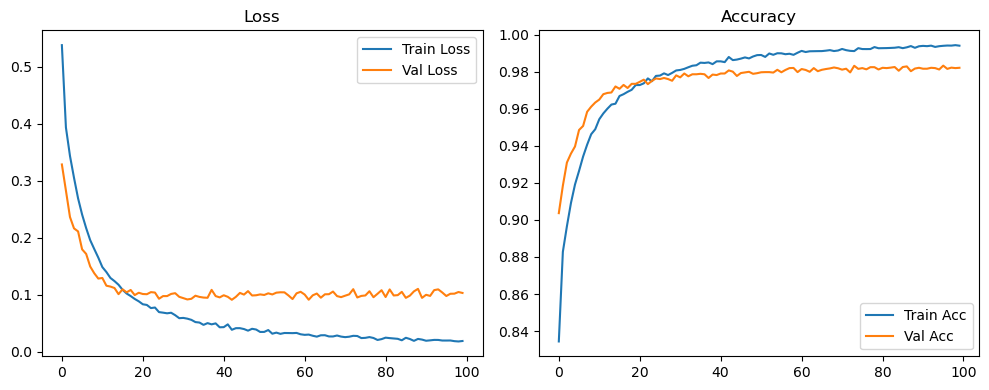

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.3609, Acc: 0.8971 | Val Loss: 0.3028, Acc: 0.9118


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.2402, Acc: 0.9283 | Val Loss: 0.2423, Acc: 0.9247


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1825, Acc: 0.9453 | Val Loss: 0.1897, Acc: 0.9410


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1458, Acc: 0.9556 | Val Loss: 0.1497, Acc: 0.9536


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.1174, Acc: 0.9637 | Val Loss: 0.1687, Acc: 0.9495


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0984, Acc: 0.9683 | Val Loss: 0.1380, Acc: 0.9599


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0816, Acc: 0.9746 | Val Loss: 0.1392, Acc: 0.9583


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0706, Acc: 0.9773 | Val Loss: 0.1300, Acc: 0.9611


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0609, Acc: 0.9795 | Val Loss: 0.1211, Acc: 0.9639


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0490, Acc: 0.9834 | Val Loss: 0.1156, Acc: 0.9681


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0473, Acc: 0.9840 | Val Loss: 0.1178, Acc: 0.9677


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0416, Acc: 0.9857 | Val Loss: 0.1138, Acc: 0.9691


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0353, Acc: 0.9878 | Val Loss: 0.1025, Acc: 0.9718


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0342, Acc: 0.9881 | Val Loss: 0.1150, Acc: 0.9704


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0295, Acc: 0.9896 | Val Loss: 0.1187, Acc: 0.9701


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0284, Acc: 0.9904 | Val Loss: 0.1337, Acc: 0.9654


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0287, Acc: 0.9902 | Val Loss: 0.1242, Acc: 0.9704


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0224, Acc: 0.9926 | Val Loss: 0.1221, Acc: 0.9722


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0236, Acc: 0.9917 | Val Loss: 0.1095, Acc: 0.9738


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0173, Acc: 0.9943 | Val Loss: 0.1206, Acc: 0.9714


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0202, Acc: 0.9931 | Val Loss: 0.1139, Acc: 0.9731


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0212, Acc: 0.9921 | Val Loss: 0.1192, Acc: 0.9722


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0155, Acc: 0.9945 | Val Loss: 0.1317, Acc: 0.9716


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0212, Acc: 0.9931 | Val Loss: 0.1166, Acc: 0.9749


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0164, Acc: 0.9945 | Val Loss: 0.1186, Acc: 0.9730


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9964 | Val Loss: 0.1237, Acc: 0.9726


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0119, Acc: 0.9955 | Val Loss: 0.1146, Acc: 0.9762


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0142, Acc: 0.9951 | Val Loss: 0.1098, Acc: 0.9765


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0174, Acc: 0.9941 | Val Loss: 0.1244, Acc: 0.9727


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9962 | Val Loss: 0.1264, Acc: 0.9733


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0176, Acc: 0.9940 | Val Loss: 0.1434, Acc: 0.9731


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9968 | Val Loss: 0.1247, Acc: 0.9746


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9966 | Val Loss: 0.1251, Acc: 0.9745


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9963 | Val Loss: 0.1241, Acc: 0.9751


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9969 | Val Loss: 0.1245, Acc: 0.9773


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.1310, Acc: 0.9753


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0123, Acc: 0.9965 | Val Loss: 0.1145, Acc: 0.9772


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1178, Acc: 0.9765


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.1429, Acc: 0.9742


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.1116, Acc: 0.9792


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1192, Acc: 0.9789


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.1577, Acc: 0.9719


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0194, Acc: 0.9938 | Val Loss: 0.1390, Acc: 0.9770


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1320, Acc: 0.9773


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.1416, Acc: 0.9757


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1245, Acc: 0.9795


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.1382, Acc: 0.9765


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.1373, Acc: 0.9759


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1469, Acc: 0.9740


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9978 | Val Loss: 0.1323, Acc: 0.9771


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9970 | Val Loss: 0.1392, Acc: 0.9770


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.1267, Acc: 0.9790


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.1321, Acc: 0.9786


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.1414, Acc: 0.9780


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9979 | Val Loss: 0.1394, Acc: 0.9778


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1405, Acc: 0.9782


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.1341, Acc: 0.9798


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1372, Acc: 0.9783


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9976 | Val Loss: 0.1551, Acc: 0.9761


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.1625, Acc: 0.9748


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1342, Acc: 0.9790


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1396, Acc: 0.9793


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.1600, Acc: 0.9762


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.1347, Acc: 0.9788


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.1407, Acc: 0.9789


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1491, Acc: 0.9776


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1437, Acc: 0.9782


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1545, Acc: 0.9784


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1606, Acc: 0.9780


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1618, Acc: 0.9767


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1718, Acc: 0.9762


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1518, Acc: 0.9779


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.1482, Acc: 0.9782


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.1555, Acc: 0.9778


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1465, Acc: 0.9778


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1356, Acc: 0.9796


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1398, Acc: 0.9792


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1432, Acc: 0.9788


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.1405, Acc: 0.9799


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1850, Acc: 0.9754


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.1614, Acc: 0.9781


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.1788, Acc: 0.9768


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1520, Acc: 0.9780


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.1653, Acc: 0.9776


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1381, Acc: 0.9812


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1446, Acc: 0.9794


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1575, Acc: 0.9772


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1583, Acc: 0.9781


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1388, Acc: 0.9802


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1474, Acc: 0.9792


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.1625, Acc: 0.9789


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1521, Acc: 0.9798


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9978 | Val Loss: 0.1493, Acc: 0.9785


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1633, Acc: 0.9791


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1519, Acc: 0.9788


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1456, Acc: 0.9808


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1446, Acc: 0.9797


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1473, Acc: 0.9811


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0099, Acc: 0.9972 | Val Loss: 0.1787, Acc: 0.9772


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1635, Acc: 0.9774


Final Test Loss: 0.1665 Accuracy: 0.9783


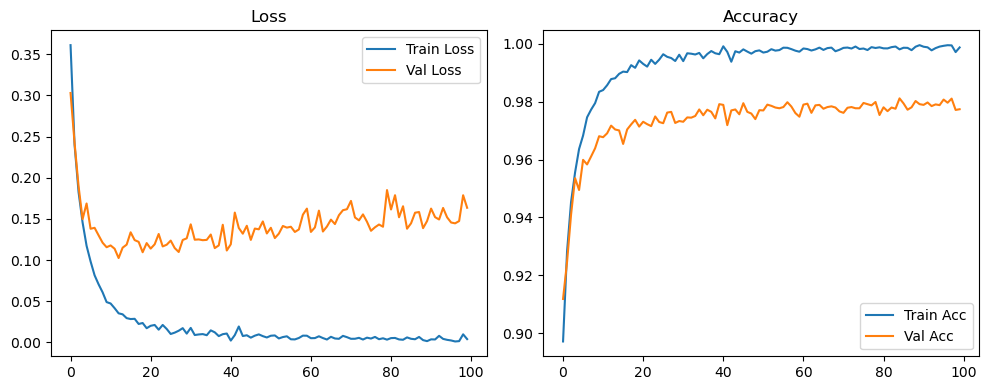

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.4193, Acc: 0.8789 | Val Loss: 0.3260, Acc: 0.9037


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.3003, Acc: 0.9094 | Val Loss: 0.2609, Acc: 0.9213


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.2569, Acc: 0.9231 | Val Loss: 0.2302, Acc: 0.9314


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.2247, Acc: 0.9316 | Val Loss: 0.2020, Acc: 0.9398


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.1979, Acc: 0.9396 | Val Loss: 0.2129, Acc: 0.9385


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.1734, Acc: 0.9454 | Val Loss: 0.1692, Acc: 0.9507


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.1564, Acc: 0.9511 | Val Loss: 0.1559, Acc: 0.9547


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.1353, Acc: 0.9595 | Val Loss: 0.1374, Acc: 0.9597


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.1233, Acc: 0.9613 | Val Loss: 0.1323, Acc: 0.9617


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.1091, Acc: 0.9652 | Val Loss: 0.1322, Acc: 0.9613


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0969, Acc: 0.9692 | Val Loss: 0.1247, Acc: 0.9646


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0920, Acc: 0.9710 | Val Loss: 0.1187, Acc: 0.9670


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0805, Acc: 0.9739 | Val Loss: 0.1108, Acc: 0.9688


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0727, Acc: 0.9764 | Val Loss: 0.1109, Acc: 0.9690


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0729, Acc: 0.9771 | Val Loss: 0.1041, Acc: 0.9709


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0668, Acc: 0.9786 | Val Loss: 0.1203, Acc: 0.9657


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0630, Acc: 0.9789 | Val Loss: 0.1066, Acc: 0.9702


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0552, Acc: 0.9811 | Val Loss: 0.1033, Acc: 0.9722


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0512, Acc: 0.9824 | Val Loss: 0.0961, Acc: 0.9740


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0471, Acc: 0.9839 | Val Loss: 0.1048, Acc: 0.9722


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0479, Acc: 0.9838 | Val Loss: 0.1006, Acc: 0.9736


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0435, Acc: 0.9850 | Val Loss: 0.0997, Acc: 0.9742


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0402, Acc: 0.9857 | Val Loss: 0.1044, Acc: 0.9739


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0370, Acc: 0.9873 | Val Loss: 0.1083, Acc: 0.9742


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0336, Acc: 0.9889 | Val Loss: 0.1027, Acc: 0.9748


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0348, Acc: 0.9886 | Val Loss: 0.1053, Acc: 0.9745


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0339, Acc: 0.9884 | Val Loss: 0.1055, Acc: 0.9745


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0312, Acc: 0.9887 | Val Loss: 0.1070, Acc: 0.9752


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0341, Acc: 0.9883 | Val Loss: 0.1007, Acc: 0.9766


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0277, Acc: 0.9904 | Val Loss: 0.1040, Acc: 0.9763


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0264, Acc: 0.9910 | Val Loss: 0.1058, Acc: 0.9762


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0266, Acc: 0.9909 | Val Loss: 0.1037, Acc: 0.9763


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0251, Acc: 0.9915 | Val Loss: 0.1036, Acc: 0.9774


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0245, Acc: 0.9914 | Val Loss: 0.1116, Acc: 0.9767


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0221, Acc: 0.9919 | Val Loss: 0.1034, Acc: 0.9770


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0215, Acc: 0.9927 | Val Loss: 0.1034, Acc: 0.9769


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0231, Acc: 0.9918 | Val Loss: 0.1075, Acc: 0.9771


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0210, Acc: 0.9929 | Val Loss: 0.1075, Acc: 0.9777


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0218, Acc: 0.9927 | Val Loss: 0.1162, Acc: 0.9772


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0194, Acc: 0.9934 | Val Loss: 0.1106, Acc: 0.9769


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0214, Acc: 0.9932 | Val Loss: 0.1117, Acc: 0.9780


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0144, Acc: 0.9950 | Val Loss: 0.1076, Acc: 0.9780


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0160, Acc: 0.9946 | Val Loss: 0.1265, Acc: 0.9742


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0177, Acc: 0.9939 | Val Loss: 0.1164, Acc: 0.9781


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0161, Acc: 0.9944 | Val Loss: 0.1143, Acc: 0.9798


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0184, Acc: 0.9936 | Val Loss: 0.1146, Acc: 0.9782


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0204, Acc: 0.9934 | Val Loss: 0.1122, Acc: 0.9790


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0149, Acc: 0.9950 | Val Loss: 0.1145, Acc: 0.9793


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0163, Acc: 0.9945 | Val Loss: 0.1188, Acc: 0.9779


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0173, Acc: 0.9936 | Val Loss: 0.1194, Acc: 0.9785


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0156, Acc: 0.9949 | Val Loss: 0.1295, Acc: 0.9758


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9955 | Val Loss: 0.1180, Acc: 0.9788


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0121, Acc: 0.9958 | Val Loss: 0.1106, Acc: 0.9791


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0139, Acc: 0.9955 | Val Loss: 0.1170, Acc: 0.9792


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9957 | Val Loss: 0.1145, Acc: 0.9791


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0121, Acc: 0.9961 | Val Loss: 0.1210, Acc: 0.9796


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0138, Acc: 0.9956 | Val Loss: 0.1089, Acc: 0.9805


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0135, Acc: 0.9956 | Val Loss: 0.1129, Acc: 0.9798


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0125, Acc: 0.9956 | Val Loss: 0.1231, Acc: 0.9797


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9961 | Val Loss: 0.1210, Acc: 0.9793


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9961 | Val Loss: 0.1288, Acc: 0.9791


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9964 | Val Loss: 0.1180, Acc: 0.9799


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0134, Acc: 0.9958 | Val Loss: 0.1254, Acc: 0.9780


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0120, Acc: 0.9958 | Val Loss: 0.1220, Acc: 0.9782


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9965 | Val Loss: 0.1136, Acc: 0.9796


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.1164, Acc: 0.9796


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0131, Acc: 0.9957 | Val Loss: 0.1230, Acc: 0.9784


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9963 | Val Loss: 0.1179, Acc: 0.9797


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9974 | Val Loss: 0.1351, Acc: 0.9773


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.1271, Acc: 0.9807


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9969 | Val Loss: 0.1257, Acc: 0.9806


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0116, Acc: 0.9963 | Val Loss: 0.1255, Acc: 0.9793


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 0.1348, Acc: 0.9788


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9962 | Val Loss: 0.1226, Acc: 0.9789


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9969 | Val Loss: 0.1256, Acc: 0.9791


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.1205, Acc: 0.9803


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9965 | Val Loss: 0.1256, Acc: 0.9797


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.1221, Acc: 0.9808


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9977 | Val Loss: 0.1264, Acc: 0.9804


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.1365, Acc: 0.9784


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.1353, Acc: 0.9799


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1269, Acc: 0.9799


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.1349, Acc: 0.9802


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9978 | Val Loss: 0.1384, Acc: 0.9785


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.1307, Acc: 0.9796


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.1186, Acc: 0.9823


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.1369, Acc: 0.9778


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1339, Acc: 0.9793


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9969 | Val Loss: 0.1340, Acc: 0.9794


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9967 | Val Loss: 0.1398, Acc: 0.9792


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.1335, Acc: 0.9793


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1332, Acc: 0.9808


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.1318, Acc: 0.9795


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.1267, Acc: 0.9817


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.1216, Acc: 0.9812


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9979 | Val Loss: 0.1367, Acc: 0.9804


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.1361, Acc: 0.9802


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1380, Acc: 0.9806


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.1353, Acc: 0.9802


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1400, Acc: 0.9814


Final Test Loss: 0.1222 Accuracy: 0.9819


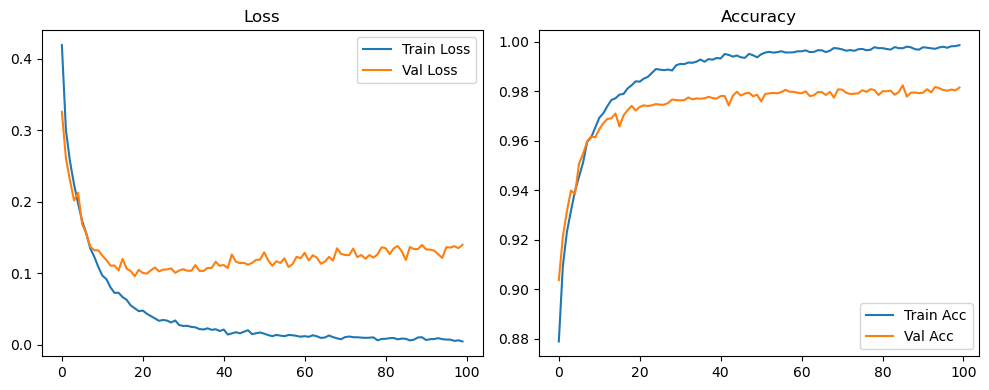

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.5769, Acc: 0.8286 | Val Loss: 0.3310, Acc: 0.9024


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.3966, Acc: 0.8795 | Val Loss: 0.2807, Acc: 0.9161


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.3572, Acc: 0.8914 | Val Loss: 0.2594, Acc: 0.9236


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.3322, Acc: 0.9006 | Val Loss: 0.2401, Acc: 0.9291


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.2996, Acc: 0.9094 | Val Loss: 0.2470, Acc: 0.9257


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.2777, Acc: 0.9150 | Val Loss: 0.2126, Acc: 0.9383


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.2565, Acc: 0.9226 | Val Loss: 0.2029, Acc: 0.9405


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.2350, Acc: 0.9289 | Val Loss: 0.1851, Acc: 0.9476


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.2197, Acc: 0.9345 | Val Loss: 0.1716, Acc: 0.9500


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.2036, Acc: 0.9371 | Val Loss: 0.1638, Acc: 0.9524


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.1853, Acc: 0.9437 | Val Loss: 0.1546, Acc: 0.9554


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.1743, Acc: 0.9460 | Val Loss: 0.1424, Acc: 0.9593


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.1634, Acc: 0.9487 | Val Loss: 0.1325, Acc: 0.9609


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.1553, Acc: 0.9535 | Val Loss: 0.1308, Acc: 0.9631


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.1472, Acc: 0.9547 | Val Loss: 0.1237, Acc: 0.9661


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.1379, Acc: 0.9575 | Val Loss: 0.1198, Acc: 0.9645


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.1292, Acc: 0.9597 | Val Loss: 0.1136, Acc: 0.9677


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.1224, Acc: 0.9611 | Val Loss: 0.1171, Acc: 0.9691


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.1147, Acc: 0.9644 | Val Loss: 0.1105, Acc: 0.9690


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.1090, Acc: 0.9659 | Val Loss: 0.1106, Acc: 0.9695


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.1070, Acc: 0.9661 | Val Loss: 0.1033, Acc: 0.9724


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0979, Acc: 0.9682 | Val Loss: 0.1056, Acc: 0.9715


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0937, Acc: 0.9714 | Val Loss: 0.1042, Acc: 0.9716


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0943, Acc: 0.9700 | Val Loss: 0.1013, Acc: 0.9723


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0871, Acc: 0.9719 | Val Loss: 0.0946, Acc: 0.9738


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0834, Acc: 0.9735 | Val Loss: 0.1004, Acc: 0.9729


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0829, Acc: 0.9736 | Val Loss: 0.0997, Acc: 0.9736


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0786, Acc: 0.9749 | Val Loss: 0.1001, Acc: 0.9734


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0767, Acc: 0.9753 | Val Loss: 0.0957, Acc: 0.9749


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0719, Acc: 0.9768 | Val Loss: 0.0969, Acc: 0.9748


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0733, Acc: 0.9760 | Val Loss: 0.0912, Acc: 0.9772


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0653, Acc: 0.9790 | Val Loss: 0.0967, Acc: 0.9748


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0670, Acc: 0.9789 | Val Loss: 0.0940, Acc: 0.9748


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0637, Acc: 0.9793 | Val Loss: 0.0925, Acc: 0.9769


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0616, Acc: 0.9792 | Val Loss: 0.0928, Acc: 0.9766


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0587, Acc: 0.9817 | Val Loss: 0.0959, Acc: 0.9760


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0597, Acc: 0.9804 | Val Loss: 0.0876, Acc: 0.9772


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0595, Acc: 0.9806 | Val Loss: 0.0935, Acc: 0.9775


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0566, Acc: 0.9814 | Val Loss: 0.0924, Acc: 0.9768


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0511, Acc: 0.9833 | Val Loss: 0.0950, Acc: 0.9764


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0518, Acc: 0.9828 | Val Loss: 0.0943, Acc: 0.9784


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0513, Acc: 0.9833 | Val Loss: 0.0891, Acc: 0.9782


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0465, Acc: 0.9849 | Val Loss: 0.0942, Acc: 0.9784


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0465, Acc: 0.9835 | Val Loss: 0.0916, Acc: 0.9782


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0452, Acc: 0.9845 | Val Loss: 0.0957, Acc: 0.9775


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0456, Acc: 0.9849 | Val Loss: 0.1001, Acc: 0.9778


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0436, Acc: 0.9857 | Val Loss: 0.0959, Acc: 0.9780


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0460, Acc: 0.9849 | Val Loss: 0.0945, Acc: 0.9780


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0435, Acc: 0.9855 | Val Loss: 0.0947, Acc: 0.9782


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0399, Acc: 0.9864 | Val Loss: 0.0960, Acc: 0.9779


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0407, Acc: 0.9864 | Val Loss: 0.0930, Acc: 0.9787


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0420, Acc: 0.9865 | Val Loss: 0.0985, Acc: 0.9792


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0376, Acc: 0.9876 | Val Loss: 0.0905, Acc: 0.9807


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0394, Acc: 0.9870 | Val Loss: 0.0974, Acc: 0.9798


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0354, Acc: 0.9876 | Val Loss: 0.1027, Acc: 0.9782


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0365, Acc: 0.9877 | Val Loss: 0.0949, Acc: 0.9796


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0347, Acc: 0.9883 | Val Loss: 0.0930, Acc: 0.9802


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0343, Acc: 0.9888 | Val Loss: 0.0878, Acc: 0.9812


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0359, Acc: 0.9884 | Val Loss: 0.0996, Acc: 0.9788


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0336, Acc: 0.9889 | Val Loss: 0.1007, Acc: 0.9795


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0330, Acc: 0.9891 | Val Loss: 0.0950, Acc: 0.9797


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0312, Acc: 0.9891 | Val Loss: 0.0969, Acc: 0.9792


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0315, Acc: 0.9889 | Val Loss: 0.0995, Acc: 0.9797


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0323, Acc: 0.9898 | Val Loss: 0.0970, Acc: 0.9806


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0320, Acc: 0.9899 | Val Loss: 0.0989, Acc: 0.9806


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0336, Acc: 0.9889 | Val Loss: 0.1025, Acc: 0.9791


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0309, Acc: 0.9895 | Val Loss: 0.1055, Acc: 0.9770


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0296, Acc: 0.9902 | Val Loss: 0.0941, Acc: 0.9810


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0309, Acc: 0.9895 | Val Loss: 0.0944, Acc: 0.9811


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0280, Acc: 0.9905 | Val Loss: 0.0985, Acc: 0.9797


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0291, Acc: 0.9904 | Val Loss: 0.1012, Acc: 0.9799


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0283, Acc: 0.9907 | Val Loss: 0.1018, Acc: 0.9804


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0282, Acc: 0.9905 | Val Loss: 0.1004, Acc: 0.9802


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0261, Acc: 0.9911 | Val Loss: 0.0985, Acc: 0.9805


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0275, Acc: 0.9908 | Val Loss: 0.0986, Acc: 0.9810


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0272, Acc: 0.9911 | Val Loss: 0.1028, Acc: 0.9798


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0266, Acc: 0.9913 | Val Loss: 0.1016, Acc: 0.9808


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0267, Acc: 0.9911 | Val Loss: 0.1010, Acc: 0.9798


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0244, Acc: 0.9915 | Val Loss: 0.0995, Acc: 0.9815


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0269, Acc: 0.9915 | Val Loss: 0.1004, Acc: 0.9817


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0246, Acc: 0.9917 | Val Loss: 0.1007, Acc: 0.9804


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0233, Acc: 0.9921 | Val Loss: 0.1055, Acc: 0.9801


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0258, Acc: 0.9916 | Val Loss: 0.1018, Acc: 0.9815


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0250, Acc: 0.9917 | Val Loss: 0.0967, Acc: 0.9818


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0245, Acc: 0.9917 | Val Loss: 0.0967, Acc: 0.9817


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0251, Acc: 0.9921 | Val Loss: 0.0933, Acc: 0.9818


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0227, Acc: 0.9917 | Val Loss: 0.0966, Acc: 0.9819


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0230, Acc: 0.9922 | Val Loss: 0.1045, Acc: 0.9806


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0237, Acc: 0.9926 | Val Loss: 0.1002, Acc: 0.9818


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0218, Acc: 0.9931 | Val Loss: 0.0949, Acc: 0.9816


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0224, Acc: 0.9926 | Val Loss: 0.0995, Acc: 0.9811


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0207, Acc: 0.9934 | Val Loss: 0.1006, Acc: 0.9815


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0219, Acc: 0.9928 | Val Loss: 0.0997, Acc: 0.9822


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0223, Acc: 0.9922 | Val Loss: 0.1020, Acc: 0.9817


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0222, Acc: 0.9924 | Val Loss: 0.1014, Acc: 0.9812


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0200, Acc: 0.9931 | Val Loss: 0.1070, Acc: 0.9814


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0217, Acc: 0.9930 | Val Loss: 0.1068, Acc: 0.9815


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0212, Acc: 0.9930 | Val Loss: 0.1057, Acc: 0.9818


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0192, Acc: 0.9933 | Val Loss: 0.1058, Acc: 0.9824


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0201, Acc: 0.9933 | Val Loss: 0.1071, Acc: 0.9798


Final Test Loss: 0.0923 Accuracy: 0.9835


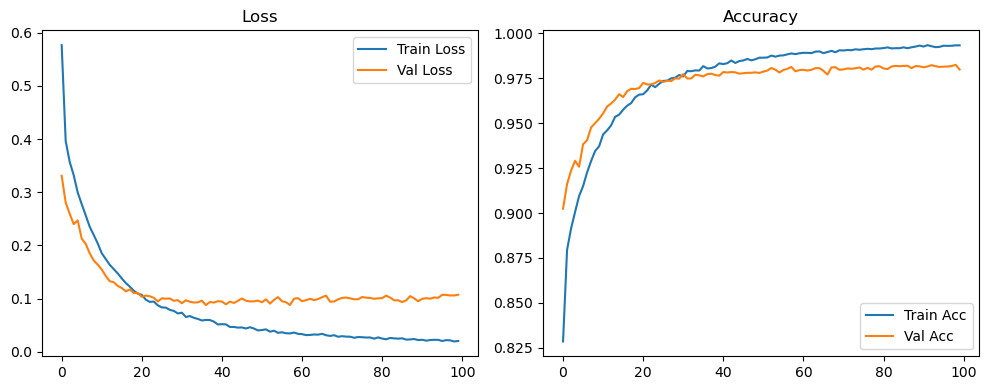

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4743, Acc: 0.8623 | Val Loss: 0.2715, Acc: 0.9208


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2142, Acc: 0.9359 | Val Loss: 0.2348, Acc: 0.9285


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1387, Acc: 0.9572 | Val Loss: 0.1545, Acc: 0.9523


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1102, Acc: 0.9665 | Val Loss: 0.1931, Acc: 0.9431


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0865, Acc: 0.9731 | Val Loss: 0.1692, Acc: 0.9541


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0647, Acc: 0.9784 | Val Loss: 0.1184, Acc: 0.9687


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0517, Acc: 0.9834 | Val Loss: 0.2093, Acc: 0.9478


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0505, Acc: 0.9837 | Val Loss: 0.1683, Acc: 0.9621


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0370, Acc: 0.9883 | Val Loss: 0.1333, Acc: 0.9696


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9899 | Val Loss: 0.1151, Acc: 0.9745


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9918 | Val Loss: 0.1310, Acc: 0.9717


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9912 | Val Loss: 0.1529, Acc: 0.9660


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9916 | Val Loss: 0.1663, Acc: 0.9681


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9915 | Val Loss: 0.1463, Acc: 0.9718


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9944 | Val Loss: 0.1269, Acc: 0.9760


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9944 | Val Loss: 0.1365, Acc: 0.9747


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9928 | Val Loss: 0.1546, Acc: 0.9734


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9936 | Val Loss: 0.1561, Acc: 0.9718


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9947 | Val Loss: 0.1480, Acc: 0.9738


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9953 | Val Loss: 0.1483, Acc: 0.9755


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9944 | Val Loss: 0.1685, Acc: 0.9707


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9954 | Val Loss: 0.1695, Acc: 0.9722


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9956 | Val Loss: 0.1866, Acc: 0.9724


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9951 | Val Loss: 0.1479, Acc: 0.9763


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9965 | Val Loss: 0.1560, Acc: 0.9751


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9966 | Val Loss: 0.1779, Acc: 0.9740


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9962 | Val Loss: 0.1721, Acc: 0.9747


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9954 | Val Loss: 0.1549, Acc: 0.9744


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.2017, Acc: 0.9698


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9964 | Val Loss: 0.2112, Acc: 0.9706


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9964 | Val Loss: 0.1744, Acc: 0.9741


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1429, Acc: 0.9788


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1431, Acc: 0.9788


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9965 | Val Loss: 0.1701, Acc: 0.9766


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9971 | Val Loss: 0.1608, Acc: 0.9752


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 0.1675, Acc: 0.9764


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9962 | Val Loss: 0.1692, Acc: 0.9746


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9970 | Val Loss: 0.1791, Acc: 0.9744


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9960 | Val Loss: 0.1414, Acc: 0.9785


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.1512, Acc: 0.9784


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.1666, Acc: 0.9775


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9975 | Val Loss: 0.1873, Acc: 0.9769


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9972 | Val Loss: 0.1572, Acc: 0.9775


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9976 | Val Loss: 0.1617, Acc: 0.9760


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1635, Acc: 0.9754


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1442, Acc: 0.9806


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1427, Acc: 0.9799


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1613, Acc: 0.9789


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9974 | Val Loss: 0.2011, Acc: 0.9720


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9972 | Val Loss: 0.1515, Acc: 0.9785


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9979 | Val Loss: 0.1468, Acc: 0.9776


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1413, Acc: 0.9795


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1306, Acc: 0.9804


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.1408, Acc: 0.9810


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1501, Acc: 0.9801


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1609, Acc: 0.9776


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9983 | Val Loss: 0.1713, Acc: 0.9762


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9974 | Val Loss: 0.1530, Acc: 0.9788


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9977 | Val Loss: 0.1492, Acc: 0.9806


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1380, Acc: 0.9809


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9981 | Val Loss: 0.1417, Acc: 0.9790


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1346, Acc: 0.9802


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.1464, Acc: 0.9782


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1459, Acc: 0.9806


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1371, Acc: 0.9804


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9980 | Val Loss: 0.1526, Acc: 0.9773


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9984 | Val Loss: 0.1537, Acc: 0.9768


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.1473, Acc: 0.9778


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1518, Acc: 0.9779


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9986 | Val Loss: 0.1231, Acc: 0.9818


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1358, Acc: 0.9817


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9992 | Val Loss: 0.1379, Acc: 0.9797


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1244, Acc: 0.9802


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1462, Acc: 0.9791


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1600, Acc: 0.9772


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1294, Acc: 0.9808


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1451, Acc: 0.9792


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9980 | Val Loss: 0.1314, Acc: 0.9798


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1276, Acc: 0.9802


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9995 | Val Loss: 0.1268, Acc: 0.9818


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1241, Acc: 0.9826


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1177, Acc: 0.9818


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1270, Acc: 0.9813


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.1788, Acc: 0.9743


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.1420, Acc: 0.9788


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1253, Acc: 0.9821


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1315, Acc: 0.9815


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1307, Acc: 0.9808


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1521, Acc: 0.9798


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1368, Acc: 0.9808


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1293, Acc: 0.9803


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1258, Acc: 0.9825


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1326, Acc: 0.9814


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1456, Acc: 0.9783


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9977 | Val Loss: 0.1632, Acc: 0.9741


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1348, Acc: 0.9782


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1328, Acc: 0.9785


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.1357, Acc: 0.9801


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1369, Acc: 0.9795


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1254, Acc: 0.9809


Final Test Loss: 0.1017 Accuracy: 0.9840


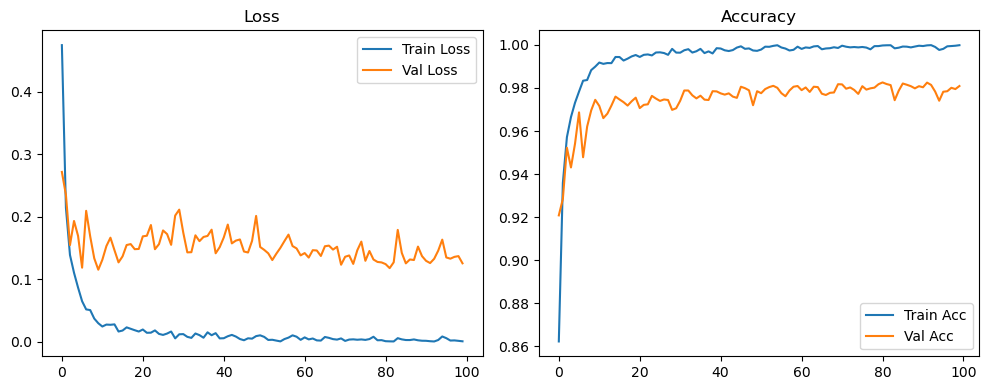

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4968, Acc: 0.8551 | Val Loss: 0.3012, Acc: 0.9141


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2693, Acc: 0.9201 | Val Loss: 0.2473, Acc: 0.9262


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2010, Acc: 0.9393 | Val Loss: 0.1563, Acc: 0.9537


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1566, Acc: 0.9531 | Val Loss: 0.1546, Acc: 0.9556


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1256, Acc: 0.9608 | Val Loss: 0.1440, Acc: 0.9583


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1000, Acc: 0.9690 | Val Loss: 0.1289, Acc: 0.9661


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0904, Acc: 0.9714 | Val Loss: 0.1157, Acc: 0.9688


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0708, Acc: 0.9778 | Val Loss: 0.1460, Acc: 0.9643


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0711, Acc: 0.9777 | Val Loss: 0.1130, Acc: 0.9685


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0546, Acc: 0.9828 | Val Loss: 0.1071, Acc: 0.9736


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0558, Acc: 0.9817 | Val Loss: 0.1162, Acc: 0.9739


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0471, Acc: 0.9850 | Val Loss: 0.1101, Acc: 0.9732


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0395, Acc: 0.9875 | Val Loss: 0.1030, Acc: 0.9768


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9879 | Val Loss: 0.1225, Acc: 0.9730


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9870 | Val Loss: 0.0959, Acc: 0.9789


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0318, Acc: 0.9895 | Val Loss: 0.1029, Acc: 0.9772


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0378, Acc: 0.9879 | Val Loss: 0.1143, Acc: 0.9748


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9897 | Val Loss: 0.1116, Acc: 0.9778


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9902 | Val Loss: 0.1134, Acc: 0.9772


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9904 | Val Loss: 0.1159, Acc: 0.9747


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9923 | Val Loss: 0.1136, Acc: 0.9779


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0272, Acc: 0.9915 | Val Loss: 0.1228, Acc: 0.9761


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9936 | Val Loss: 0.1146, Acc: 0.9778


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9930 | Val Loss: 0.1152, Acc: 0.9790


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9923 | Val Loss: 0.1257, Acc: 0.9778


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9933 | Val Loss: 0.1271, Acc: 0.9766


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9927 | Val Loss: 0.1080, Acc: 0.9797


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9949 | Val Loss: 0.1093, Acc: 0.9811


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9947 | Val Loss: 0.1516, Acc: 0.9730


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9937 | Val Loss: 0.1110, Acc: 0.9793


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9962 | Val Loss: 0.1096, Acc: 0.9794


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9957 | Val Loss: 0.1194, Acc: 0.9788


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9936 | Val Loss: 0.1280, Acc: 0.9774


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9949 | Val Loss: 0.1289, Acc: 0.9789


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.1252, Acc: 0.9790


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9956 | Val Loss: 0.1187, Acc: 0.9776


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9955 | Val Loss: 0.1306, Acc: 0.9781


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9953 | Val Loss: 0.1170, Acc: 0.9792


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9950 | Val Loss: 0.1354, Acc: 0.9769


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9962 | Val Loss: 0.1139, Acc: 0.9800


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9959 | Val Loss: 0.1345, Acc: 0.9773


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9962 | Val Loss: 0.1242, Acc: 0.9801


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9967 | Val Loss: 0.1205, Acc: 0.9810


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9960 | Val Loss: 0.1340, Acc: 0.9793


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9961 | Val Loss: 0.1296, Acc: 0.9796


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.1210, Acc: 0.9808


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9959 | Val Loss: 0.1333, Acc: 0.9786


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9960 | Val Loss: 0.1128, Acc: 0.9817


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9968 | Val Loss: 0.1121, Acc: 0.9817


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9972 | Val Loss: 0.1118, Acc: 0.9814


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.1183, Acc: 0.9792


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.1094, Acc: 0.9819


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.1195, Acc: 0.9805


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9971 | Val Loss: 0.1183, Acc: 0.9821


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.1305, Acc: 0.9807


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.1308, Acc: 0.9797


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9968 | Val Loss: 0.1228, Acc: 0.9799


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9978 | Val Loss: 0.1057, Acc: 0.9821


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9971 | Val Loss: 0.1328, Acc: 0.9802


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9975 | Val Loss: 0.1109, Acc: 0.9813


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.1113, Acc: 0.9812


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1110, Acc: 0.9813


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9980 | Val Loss: 0.1161, Acc: 0.9804


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.1215, Acc: 0.9815


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.1325, Acc: 0.9802


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9976 | Val Loss: 0.1104, Acc: 0.9828


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1219, Acc: 0.9803


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9978 | Val Loss: 0.1153, Acc: 0.9818


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.1126, Acc: 0.9825


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.1251, Acc: 0.9812


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1292, Acc: 0.9811


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1144, Acc: 0.9828


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1225, Acc: 0.9832


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.1357, Acc: 0.9803


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9971 | Val Loss: 0.1142, Acc: 0.9822


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1058, Acc: 0.9832


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.1128, Acc: 0.9825


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1190, Acc: 0.9825


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.1140, Acc: 0.9823


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.1163, Acc: 0.9809


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.1057, Acc: 0.9830


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9980 | Val Loss: 0.1130, Acc: 0.9828


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.1196, Acc: 0.9818


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9980 | Val Loss: 0.1173, Acc: 0.9833


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.1032, Acc: 0.9842


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1184, Acc: 0.9820


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.1156, Acc: 0.9821


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1094, Acc: 0.9828


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1217, Acc: 0.9830


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9976 | Val Loss: 0.1188, Acc: 0.9815


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1117, Acc: 0.9837


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9986 | Val Loss: 0.1129, Acc: 0.9823


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1200, Acc: 0.9818


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1091, Acc: 0.9819


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1125, Acc: 0.9839


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1081, Acc: 0.9832


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1042, Acc: 0.9835


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.1180, Acc: 0.9825


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1204, Acc: 0.9819


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.1115, Acc: 0.9832


Final Test Loss: 0.1116 Accuracy: 0.9828


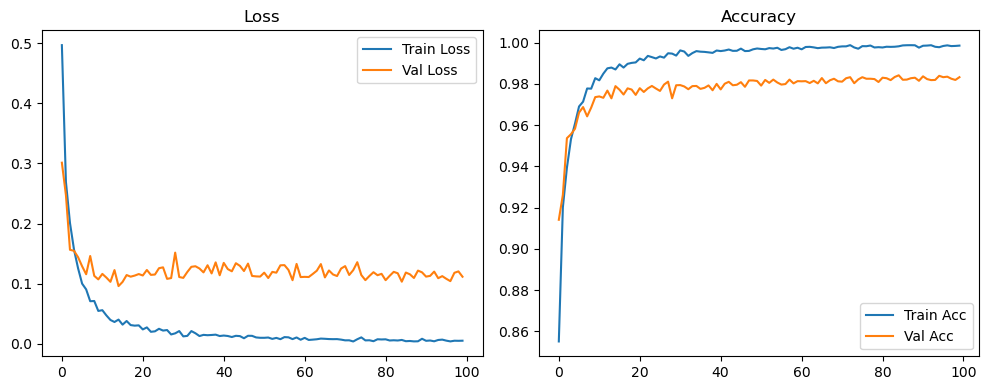

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6507, Acc: 0.8165 | Val Loss: 0.3219, Acc: 0.9059


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3608, Acc: 0.8931 | Val Loss: 0.2862, Acc: 0.9161


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2847, Acc: 0.9152 | Val Loss: 0.1967, Acc: 0.9447


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2358, Acc: 0.9307 | Val Loss: 0.1552, Acc: 0.9551


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2000, Acc: 0.9405 | Val Loss: 0.1646, Acc: 0.9538


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1703, Acc: 0.9490 | Val Loss: 0.1280, Acc: 0.9647


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1466, Acc: 0.9563 | Val Loss: 0.1150, Acc: 0.9693


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1321, Acc: 0.9599 | Val Loss: 0.1179, Acc: 0.9685


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1224, Acc: 0.9631 | Val Loss: 0.1068, Acc: 0.9691


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1090, Acc: 0.9664 | Val Loss: 0.1024, Acc: 0.9719


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0987, Acc: 0.9700 | Val Loss: 0.0996, Acc: 0.9730


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0957, Acc: 0.9714 | Val Loss: 0.0999, Acc: 0.9743


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0828, Acc: 0.9732 | Val Loss: 0.0951, Acc: 0.9753


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0801, Acc: 0.9746 | Val Loss: 0.0851, Acc: 0.9768


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0775, Acc: 0.9758 | Val Loss: 0.0913, Acc: 0.9771


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0707, Acc: 0.9774 | Val Loss: 0.0900, Acc: 0.9761


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0637, Acc: 0.9801 | Val Loss: 0.1011, Acc: 0.9765


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0622, Acc: 0.9801 | Val Loss: 0.0882, Acc: 0.9774


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0592, Acc: 0.9813 | Val Loss: 0.0894, Acc: 0.9779


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0600, Acc: 0.9810 | Val Loss: 0.0862, Acc: 0.9786


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0521, Acc: 0.9832 | Val Loss: 0.0754, Acc: 0.9803


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0523, Acc: 0.9837 | Val Loss: 0.0846, Acc: 0.9799


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0479, Acc: 0.9843 | Val Loss: 0.0784, Acc: 0.9806


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0436, Acc: 0.9862 | Val Loss: 0.0913, Acc: 0.9798


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9853 | Val Loss: 0.0848, Acc: 0.9798


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0461, Acc: 0.9853 | Val Loss: 0.0900, Acc: 0.9778


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0469, Acc: 0.9848 | Val Loss: 0.0855, Acc: 0.9791


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0405, Acc: 0.9867 | Val Loss: 0.0811, Acc: 0.9804


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0400, Acc: 0.9866 | Val Loss: 0.0900, Acc: 0.9797


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9870 | Val Loss: 0.0831, Acc: 0.9806


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0364, Acc: 0.9886 | Val Loss: 0.0778, Acc: 0.9817


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0343, Acc: 0.9890 | Val Loss: 0.0869, Acc: 0.9805


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0340, Acc: 0.9885 | Val Loss: 0.0864, Acc: 0.9806


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0338, Acc: 0.9885 | Val Loss: 0.0908, Acc: 0.9789


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9900 | Val Loss: 0.0812, Acc: 0.9812


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9897 | Val Loss: 0.0831, Acc: 0.9813


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0336, Acc: 0.9890 | Val Loss: 0.0888, Acc: 0.9800


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9896 | Val Loss: 0.0865, Acc: 0.9806


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9905 | Val Loss: 0.0851, Acc: 0.9809


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0284, Acc: 0.9907 | Val Loss: 0.0757, Acc: 0.9832


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9919 | Val Loss: 0.0861, Acc: 0.9821


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0297, Acc: 0.9904 | Val Loss: 0.0815, Acc: 0.9818


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9913 | Val Loss: 0.0886, Acc: 0.9810


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0297, Acc: 0.9905 | Val Loss: 0.0866, Acc: 0.9810


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9920 | Val Loss: 0.0814, Acc: 0.9818


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0247, Acc: 0.9922 | Val Loss: 0.0901, Acc: 0.9802


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9920 | Val Loss: 0.0847, Acc: 0.9838


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9921 | Val Loss: 0.0826, Acc: 0.9832


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9925 | Val Loss: 0.0780, Acc: 0.9841


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9925 | Val Loss: 0.0887, Acc: 0.9823


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9924 | Val Loss: 0.0781, Acc: 0.9825


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9943 | Val Loss: 0.0806, Acc: 0.9839


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9918 | Val Loss: 0.0840, Acc: 0.9820


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9928 | Val Loss: 0.0793, Acc: 0.9832


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9927 | Val Loss: 0.0809, Acc: 0.9832


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9934 | Val Loss: 0.0813, Acc: 0.9833


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9933 | Val Loss: 0.0782, Acc: 0.9837


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9933 | Val Loss: 0.0821, Acc: 0.9828


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9938 | Val Loss: 0.0772, Acc: 0.9842


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9943 | Val Loss: 0.0792, Acc: 0.9832


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9932 | Val Loss: 0.0795, Acc: 0.9832


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9941 | Val Loss: 0.0779, Acc: 0.9834


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9944 | Val Loss: 0.0824, Acc: 0.9833


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9938 | Val Loss: 0.0800, Acc: 0.9829


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9936 | Val Loss: 0.0771, Acc: 0.9837


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9941 | Val Loss: 0.0727, Acc: 0.9831


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9940 | Val Loss: 0.0873, Acc: 0.9828


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9945 | Val Loss: 0.0864, Acc: 0.9823


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9942 | Val Loss: 0.0789, Acc: 0.9841


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9946 | Val Loss: 0.0798, Acc: 0.9831


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9953 | Val Loss: 0.0777, Acc: 0.9832


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9951 | Val Loss: 0.0813, Acc: 0.9832


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9950 | Val Loss: 0.0798, Acc: 0.9835


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.0860, Acc: 0.9842


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9950 | Val Loss: 0.0832, Acc: 0.9841


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9951 | Val Loss: 0.0810, Acc: 0.9840


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9939 | Val Loss: 0.0759, Acc: 0.9838


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9955 | Val Loss: 0.0761, Acc: 0.9838


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9946 | Val Loss: 0.0811, Acc: 0.9831


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9956 | Val Loss: 0.0857, Acc: 0.9838


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 0.0834, Acc: 0.9838


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9956 | Val Loss: 0.0751, Acc: 0.9846


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9956 | Val Loss: 0.0780, Acc: 0.9844


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9962 | Val Loss: 0.0783, Acc: 0.9840


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.0828, Acc: 0.9835


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9949 | Val Loss: 0.0829, Acc: 0.9832


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9958 | Val Loss: 0.0757, Acc: 0.9840


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.0806, Acc: 0.9839


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9958 | Val Loss: 0.0780, Acc: 0.9839


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9957 | Val Loss: 0.0832, Acc: 0.9840


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9958 | Val Loss: 0.0845, Acc: 0.9834


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9959 | Val Loss: 0.0852, Acc: 0.9837


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.0827, Acc: 0.9845


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.0848, Acc: 0.9841


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9961 | Val Loss: 0.0865, Acc: 0.9841


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9954 | Val Loss: 0.0858, Acc: 0.9837


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9964 | Val Loss: 0.0818, Acc: 0.9837


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.0839, Acc: 0.9838


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9964 | Val Loss: 0.0856, Acc: 0.9839


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9967 | Val Loss: 0.0793, Acc: 0.9839


Final Test Loss: 0.0733 Accuracy: 0.9850


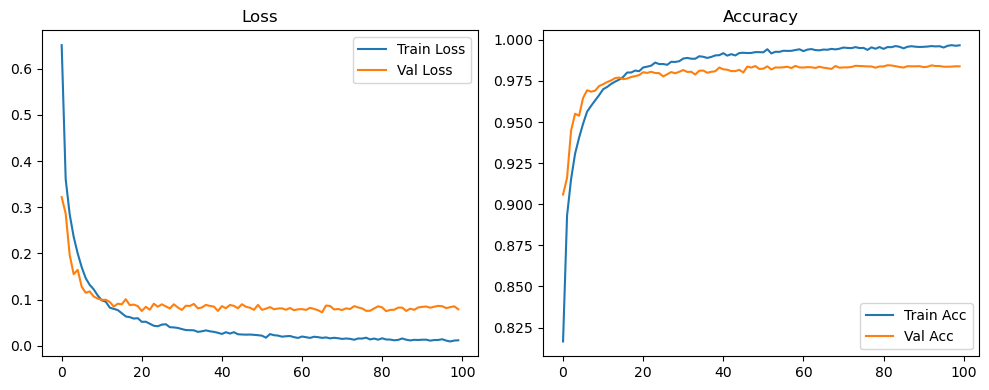

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4743, Acc: 0.8623 | Val Loss: 0.2715, Acc: 0.9208


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2142, Acc: 0.9359 | Val Loss: 0.2348, Acc: 0.9285


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1387, Acc: 0.9572 | Val Loss: 0.1545, Acc: 0.9523


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1102, Acc: 0.9665 | Val Loss: 0.1931, Acc: 0.9431


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0865, Acc: 0.9731 | Val Loss: 0.1692, Acc: 0.9541


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0647, Acc: 0.9784 | Val Loss: 0.1184, Acc: 0.9687


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0517, Acc: 0.9834 | Val Loss: 0.2093, Acc: 0.9478


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0505, Acc: 0.9837 | Val Loss: 0.1683, Acc: 0.9621


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0370, Acc: 0.9883 | Val Loss: 0.1333, Acc: 0.9696


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9899 | Val Loss: 0.1151, Acc: 0.9745


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9918 | Val Loss: 0.1310, Acc: 0.9717


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9912 | Val Loss: 0.1529, Acc: 0.9660


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9916 | Val Loss: 0.1663, Acc: 0.9681


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9915 | Val Loss: 0.1463, Acc: 0.9718


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9944 | Val Loss: 0.1269, Acc: 0.9760


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9944 | Val Loss: 0.1365, Acc: 0.9747


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9928 | Val Loss: 0.1546, Acc: 0.9734


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9936 | Val Loss: 0.1561, Acc: 0.9718


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9947 | Val Loss: 0.1480, Acc: 0.9738


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9953 | Val Loss: 0.1483, Acc: 0.9755


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9944 | Val Loss: 0.1685, Acc: 0.9707


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9954 | Val Loss: 0.1695, Acc: 0.9722


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9956 | Val Loss: 0.1866, Acc: 0.9724


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9951 | Val Loss: 0.1479, Acc: 0.9763


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9965 | Val Loss: 0.1560, Acc: 0.9751


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9966 | Val Loss: 0.1779, Acc: 0.9740


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9962 | Val Loss: 0.1721, Acc: 0.9747


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9954 | Val Loss: 0.1549, Acc: 0.9744


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.2017, Acc: 0.9698


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9964 | Val Loss: 0.2112, Acc: 0.9706


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9964 | Val Loss: 0.1744, Acc: 0.9741


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1429, Acc: 0.9788


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1431, Acc: 0.9788


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9965 | Val Loss: 0.1701, Acc: 0.9766


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9971 | Val Loss: 0.1608, Acc: 0.9752


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 0.1675, Acc: 0.9764


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9962 | Val Loss: 0.1692, Acc: 0.9746


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9970 | Val Loss: 0.1791, Acc: 0.9744


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9960 | Val Loss: 0.1414, Acc: 0.9785


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.1512, Acc: 0.9784


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.1666, Acc: 0.9775


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9975 | Val Loss: 0.1873, Acc: 0.9769


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9972 | Val Loss: 0.1572, Acc: 0.9775


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9976 | Val Loss: 0.1617, Acc: 0.9760


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1635, Acc: 0.9754


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1442, Acc: 0.9806


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1427, Acc: 0.9799


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1613, Acc: 0.9789


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9974 | Val Loss: 0.2011, Acc: 0.9720


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9972 | Val Loss: 0.1515, Acc: 0.9785


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1250, Acc: 0.9807


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1290, Acc: 0.9802


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1212, Acc: 0.9810


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1219, Acc: 0.9819


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1242, Acc: 0.9814


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1248, Acc: 0.9807


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1351, Acc: 0.9811


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1250, Acc: 0.9816


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9996 | Val Loss: 0.1333, Acc: 0.9802


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1325, Acc: 0.9806


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1351, Acc: 0.9808


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9999 | Val Loss: 0.1365, Acc: 0.9816


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.1413, Acc: 0.9809


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1537, Acc: 0.9801


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9992 | Val Loss: 0.1593, Acc: 0.9792


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1440, Acc: 0.9802


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1478, Acc: 0.9803


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1556, Acc: 0.9799


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1564, Acc: 0.9798


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1442, Acc: 0.9815


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1513, Acc: 0.9808


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1471, Acc: 0.9808


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1415, Acc: 0.9815


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1527, Acc: 0.9807


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1446, Acc: 0.9823


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.1671, Acc: 0.9801


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.1535, Acc: 0.9803


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.1394, Acc: 0.9822


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.1462, Acc: 0.9813


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1499, Acc: 0.9813


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1359, Acc: 0.9833


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1333, Acc: 0.9828


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1354, Acc: 0.9822


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1313, Acc: 0.9826


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1319, Acc: 0.9828


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1322, Acc: 0.9821


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1327, Acc: 0.9827


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1337, Acc: 0.9825


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1356, Acc: 0.9824


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1371, Acc: 0.9825


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1325, Acc: 0.9824


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1311, Acc: 0.9823


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1322, Acc: 0.9826


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1318, Acc: 0.9827


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1343, Acc: 0.9826


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1420, Acc: 0.9827


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1421, Acc: 0.9819


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1424, Acc: 0.9820


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1485, Acc: 0.9816


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1445, Acc: 0.9824


Final Test Loss: 0.1263 Accuracy: 0.9834


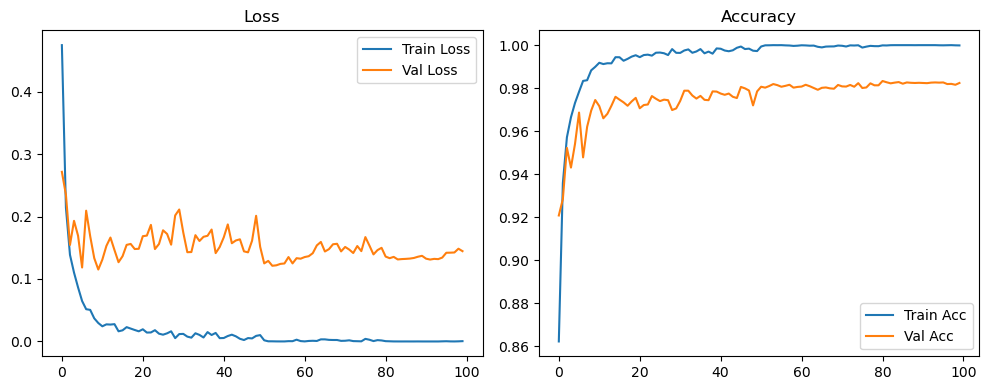

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4968, Acc: 0.8551 | Val Loss: 0.3012, Acc: 0.9141


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2693, Acc: 0.9201 | Val Loss: 0.2473, Acc: 0.9262


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2010, Acc: 0.9393 | Val Loss: 0.1563, Acc: 0.9537


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1566, Acc: 0.9531 | Val Loss: 0.1546, Acc: 0.9556


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1256, Acc: 0.9608 | Val Loss: 0.1440, Acc: 0.9583


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1000, Acc: 0.9690 | Val Loss: 0.1289, Acc: 0.9661


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0904, Acc: 0.9714 | Val Loss: 0.1157, Acc: 0.9688


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0708, Acc: 0.9778 | Val Loss: 0.1460, Acc: 0.9643


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0711, Acc: 0.9777 | Val Loss: 0.1130, Acc: 0.9685


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0546, Acc: 0.9828 | Val Loss: 0.1071, Acc: 0.9736


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0558, Acc: 0.9817 | Val Loss: 0.1162, Acc: 0.9739


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0471, Acc: 0.9850 | Val Loss: 0.1101, Acc: 0.9732


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0395, Acc: 0.9875 | Val Loss: 0.1030, Acc: 0.9768


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9879 | Val Loss: 0.1225, Acc: 0.9730


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9870 | Val Loss: 0.0959, Acc: 0.9789


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0318, Acc: 0.9895 | Val Loss: 0.1029, Acc: 0.9772


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0378, Acc: 0.9879 | Val Loss: 0.1143, Acc: 0.9748


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9897 | Val Loss: 0.1116, Acc: 0.9778


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9902 | Val Loss: 0.1134, Acc: 0.9772


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9904 | Val Loss: 0.1159, Acc: 0.9747


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9923 | Val Loss: 0.1136, Acc: 0.9779


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0272, Acc: 0.9915 | Val Loss: 0.1228, Acc: 0.9761


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9936 | Val Loss: 0.1146, Acc: 0.9778


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9930 | Val Loss: 0.1152, Acc: 0.9790


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9923 | Val Loss: 0.1257, Acc: 0.9778


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9933 | Val Loss: 0.1271, Acc: 0.9766


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9927 | Val Loss: 0.1080, Acc: 0.9797


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9949 | Val Loss: 0.1093, Acc: 0.9811


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9947 | Val Loss: 0.1516, Acc: 0.9730


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9937 | Val Loss: 0.1110, Acc: 0.9793


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9962 | Val Loss: 0.1096, Acc: 0.9794


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9957 | Val Loss: 0.1194, Acc: 0.9788


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9936 | Val Loss: 0.1280, Acc: 0.9774


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9949 | Val Loss: 0.1289, Acc: 0.9789


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.1252, Acc: 0.9790


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9956 | Val Loss: 0.1187, Acc: 0.9776


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9955 | Val Loss: 0.1306, Acc: 0.9781


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9953 | Val Loss: 0.1170, Acc: 0.9792


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9950 | Val Loss: 0.1354, Acc: 0.9769


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9962 | Val Loss: 0.1139, Acc: 0.9800


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9959 | Val Loss: 0.1345, Acc: 0.9773


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9962 | Val Loss: 0.1242, Acc: 0.9801


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9967 | Val Loss: 0.1205, Acc: 0.9810


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9960 | Val Loss: 0.1340, Acc: 0.9793


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9961 | Val Loss: 0.1296, Acc: 0.9796


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.1210, Acc: 0.9808


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9959 | Val Loss: 0.1333, Acc: 0.9786


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9960 | Val Loss: 0.1128, Acc: 0.9817


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9968 | Val Loss: 0.1121, Acc: 0.9817


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9972 | Val Loss: 0.1118, Acc: 0.9814


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1005, Acc: 0.9828


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1026, Acc: 0.9827


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1024, Acc: 0.9832


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1018, Acc: 0.9836


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1040, Acc: 0.9841


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1042, Acc: 0.9837


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0975, Acc: 0.9839


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.1018, Acc: 0.9837


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1117, Acc: 0.9822


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1096, Acc: 0.9830


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.1126, Acc: 0.9828


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1164, Acc: 0.9823


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1154, Acc: 0.9822


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1202, Acc: 0.9812


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1283, Acc: 0.9817


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9990 | Val Loss: 0.1149, Acc: 0.9825


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1338, Acc: 0.9824


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1339, Acc: 0.9814


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1325, Acc: 0.9816


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1197, Acc: 0.9838


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1298, Acc: 0.9818


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1218, Acc: 0.9832


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1263, Acc: 0.9833


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.1266, Acc: 0.9842


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1378, Acc: 0.9824


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1307, Acc: 0.9831


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1377, Acc: 0.9819


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1376, Acc: 0.9818


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1206, Acc: 0.9835


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.1315, Acc: 0.9818


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1227, Acc: 0.9836


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1188, Acc: 0.9840


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1203, Acc: 0.9839


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1179, Acc: 0.9828


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1167, Acc: 0.9838


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1180, Acc: 0.9832


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1209, Acc: 0.9837


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1179, Acc: 0.9839


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1199, Acc: 0.9842


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1188, Acc: 0.9839


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1146, Acc: 0.9832


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1148, Acc: 0.9838


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.1149, Acc: 0.9836


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1171, Acc: 0.9837


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1114, Acc: 0.9848


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1174, Acc: 0.9845


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1255, Acc: 0.9835


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1238, Acc: 0.9835


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1340, Acc: 0.9834


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1242, Acc: 0.9832


Final Test Loss: 0.1121 Accuracy: 0.9839


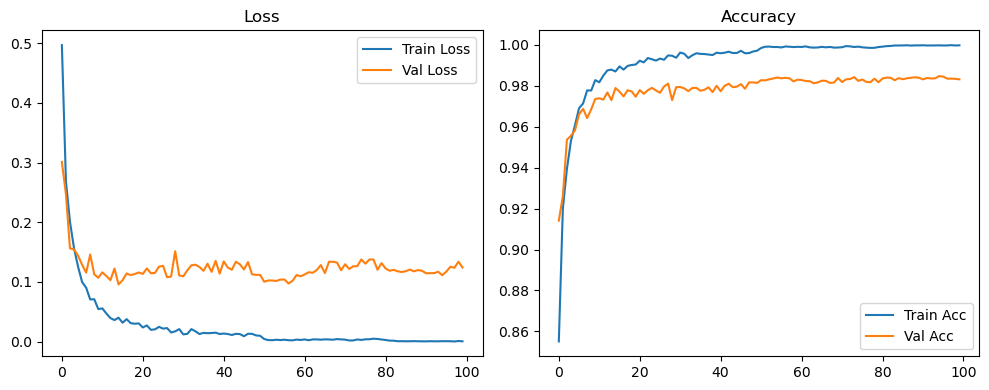

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6507, Acc: 0.8165 | Val Loss: 0.3219, Acc: 0.9059


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3608, Acc: 0.8931 | Val Loss: 0.2862, Acc: 0.9161


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2847, Acc: 0.9152 | Val Loss: 0.1967, Acc: 0.9447


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2358, Acc: 0.9307 | Val Loss: 0.1552, Acc: 0.9551


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2000, Acc: 0.9405 | Val Loss: 0.1646, Acc: 0.9538


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1703, Acc: 0.9490 | Val Loss: 0.1280, Acc: 0.9647


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1466, Acc: 0.9563 | Val Loss: 0.1150, Acc: 0.9693


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1321, Acc: 0.9599 | Val Loss: 0.1179, Acc: 0.9685


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1224, Acc: 0.9631 | Val Loss: 0.1068, Acc: 0.9691


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1090, Acc: 0.9664 | Val Loss: 0.1024, Acc: 0.9719


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0987, Acc: 0.9700 | Val Loss: 0.0996, Acc: 0.9730


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0957, Acc: 0.9714 | Val Loss: 0.0999, Acc: 0.9743


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0828, Acc: 0.9732 | Val Loss: 0.0951, Acc: 0.9753


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0801, Acc: 0.9746 | Val Loss: 0.0851, Acc: 0.9768


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0775, Acc: 0.9758 | Val Loss: 0.0913, Acc: 0.9771


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0707, Acc: 0.9774 | Val Loss: 0.0900, Acc: 0.9761


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0637, Acc: 0.9801 | Val Loss: 0.1011, Acc: 0.9765


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0622, Acc: 0.9801 | Val Loss: 0.0882, Acc: 0.9774


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0592, Acc: 0.9813 | Val Loss: 0.0894, Acc: 0.9779


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0600, Acc: 0.9810 | Val Loss: 0.0862, Acc: 0.9786


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0521, Acc: 0.9832 | Val Loss: 0.0754, Acc: 0.9803


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0523, Acc: 0.9837 | Val Loss: 0.0846, Acc: 0.9799


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0479, Acc: 0.9843 | Val Loss: 0.0784, Acc: 0.9806


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0436, Acc: 0.9862 | Val Loss: 0.0913, Acc: 0.9798


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9853 | Val Loss: 0.0848, Acc: 0.9798


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0461, Acc: 0.9853 | Val Loss: 0.0900, Acc: 0.9778


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0469, Acc: 0.9848 | Val Loss: 0.0855, Acc: 0.9791


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0405, Acc: 0.9867 | Val Loss: 0.0811, Acc: 0.9804


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0400, Acc: 0.9866 | Val Loss: 0.0900, Acc: 0.9797


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9870 | Val Loss: 0.0831, Acc: 0.9806


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0364, Acc: 0.9886 | Val Loss: 0.0778, Acc: 0.9817


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0343, Acc: 0.9890 | Val Loss: 0.0869, Acc: 0.9805


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0340, Acc: 0.9885 | Val Loss: 0.0864, Acc: 0.9806


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0338, Acc: 0.9885 | Val Loss: 0.0908, Acc: 0.9789


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9900 | Val Loss: 0.0812, Acc: 0.9812


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9897 | Val Loss: 0.0831, Acc: 0.9813


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0336, Acc: 0.9890 | Val Loss: 0.0888, Acc: 0.9800


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9896 | Val Loss: 0.0865, Acc: 0.9806


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9905 | Val Loss: 0.0851, Acc: 0.9809


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0284, Acc: 0.9907 | Val Loss: 0.0757, Acc: 0.9832


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9919 | Val Loss: 0.0861, Acc: 0.9821


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0297, Acc: 0.9904 | Val Loss: 0.0815, Acc: 0.9818


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9913 | Val Loss: 0.0886, Acc: 0.9810


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0297, Acc: 0.9905 | Val Loss: 0.0866, Acc: 0.9810


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9920 | Val Loss: 0.0814, Acc: 0.9818


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0247, Acc: 0.9922 | Val Loss: 0.0901, Acc: 0.9802


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9920 | Val Loss: 0.0847, Acc: 0.9838


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9921 | Val Loss: 0.0826, Acc: 0.9832


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9925 | Val Loss: 0.0780, Acc: 0.9841


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9925 | Val Loss: 0.0887, Acc: 0.9823


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9936 | Val Loss: 0.0760, Acc: 0.9846


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9955 | Val Loss: 0.0781, Acc: 0.9842


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.0748, Acc: 0.9846


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9958 | Val Loss: 0.0745, Acc: 0.9843


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.0812, Acc: 0.9846


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9960 | Val Loss: 0.0771, Acc: 0.9844


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9961 | Val Loss: 0.0799, Acc: 0.9848


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9965 | Val Loss: 0.0807, Acc: 0.9848


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9963 | Val Loss: 0.0804, Acc: 0.9846


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.0836, Acc: 0.9840


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9962 | Val Loss: 0.0836, Acc: 0.9843


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.0922, Acc: 0.9841


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.0851, Acc: 0.9840


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9963 | Val Loss: 0.0840, Acc: 0.9837


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9965 | Val Loss: 0.0883, Acc: 0.9836


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.0831, Acc: 0.9850


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9963 | Val Loss: 0.0926, Acc: 0.9836


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.0877, Acc: 0.9842


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.0865, Acc: 0.9848


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.0888, Acc: 0.9846


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.0881, Acc: 0.9842


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.0934, Acc: 0.9846


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.0911, Acc: 0.9846


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.0948, Acc: 0.9840


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.0947, Acc: 0.9848


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.0955, Acc: 0.9842


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.0965, Acc: 0.9832


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.0909, Acc: 0.9844


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.1017, Acc: 0.9839


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.0949, Acc: 0.9839


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.0944, Acc: 0.9835


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.0895, Acc: 0.9842


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.0894, Acc: 0.9848


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.0882, Acc: 0.9844


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0885, Acc: 0.9846


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.0856, Acc: 0.9848


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0876, Acc: 0.9848


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0878, Acc: 0.9851


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.0879, Acc: 0.9853


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0883, Acc: 0.9853


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0871, Acc: 0.9852


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0887, Acc: 0.9851


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.0870, Acc: 0.9855


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.0906, Acc: 0.9848


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0897, Acc: 0.9848


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0918, Acc: 0.9845


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.0936, Acc: 0.9837


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0917, Acc: 0.9847


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0926, Acc: 0.9846


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0891, Acc: 0.9850


Final Test Loss: 0.0884 Accuracy: 0.9857


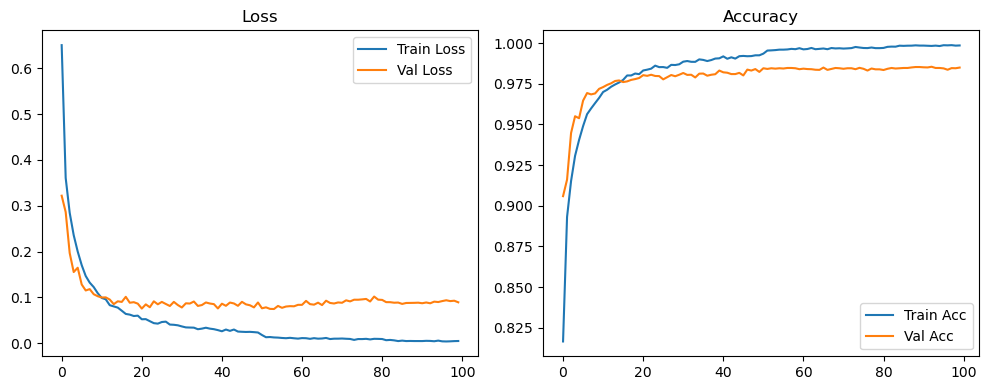

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4743, Acc: 0.8623 | Val Loss: 0.2715, Acc: 0.9208


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2142, Acc: 0.9359 | Val Loss: 0.2348, Acc: 0.9285


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1387, Acc: 0.9572 | Val Loss: 0.1545, Acc: 0.9523


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1102, Acc: 0.9665 | Val Loss: 0.1931, Acc: 0.9431


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0865, Acc: 0.9731 | Val Loss: 0.1692, Acc: 0.9541


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0647, Acc: 0.9784 | Val Loss: 0.1184, Acc: 0.9687


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0517, Acc: 0.9834 | Val Loss: 0.2093, Acc: 0.9478


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0505, Acc: 0.9837 | Val Loss: 0.1683, Acc: 0.9621


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0370, Acc: 0.9883 | Val Loss: 0.1333, Acc: 0.9696


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9899 | Val Loss: 0.1151, Acc: 0.9745


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9918 | Val Loss: 0.1310, Acc: 0.9717


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9912 | Val Loss: 0.1529, Acc: 0.9660


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9916 | Val Loss: 0.1663, Acc: 0.9681


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9915 | Val Loss: 0.1463, Acc: 0.9718


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9944 | Val Loss: 0.1269, Acc: 0.9760


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9944 | Val Loss: 0.1365, Acc: 0.9747


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9928 | Val Loss: 0.1546, Acc: 0.9734


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9936 | Val Loss: 0.1561, Acc: 0.9718


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9947 | Val Loss: 0.1480, Acc: 0.9738


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9953 | Val Loss: 0.1483, Acc: 0.9755


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9944 | Val Loss: 0.1685, Acc: 0.9707


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9954 | Val Loss: 0.1695, Acc: 0.9722


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9956 | Val Loss: 0.1866, Acc: 0.9724


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9951 | Val Loss: 0.1479, Acc: 0.9763


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9965 | Val Loss: 0.1560, Acc: 0.9751


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9966 | Val Loss: 0.1779, Acc: 0.9740


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9962 | Val Loss: 0.1721, Acc: 0.9747


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9954 | Val Loss: 0.1549, Acc: 0.9744


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.2017, Acc: 0.9698


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9964 | Val Loss: 0.2112, Acc: 0.9706


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9964 | Val Loss: 0.1744, Acc: 0.9741


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1429, Acc: 0.9788


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1431, Acc: 0.9788


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9965 | Val Loss: 0.1701, Acc: 0.9766


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9971 | Val Loss: 0.1608, Acc: 0.9752


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 0.1675, Acc: 0.9764


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9962 | Val Loss: 0.1692, Acc: 0.9746


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9970 | Val Loss: 0.1791, Acc: 0.9744


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9960 | Val Loss: 0.1414, Acc: 0.9785


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.1512, Acc: 0.9784


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.1666, Acc: 0.9775


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9975 | Val Loss: 0.1873, Acc: 0.9769


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9972 | Val Loss: 0.1572, Acc: 0.9775


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9976 | Val Loss: 0.1617, Acc: 0.9760


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1635, Acc: 0.9754


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1442, Acc: 0.9806


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1427, Acc: 0.9799


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1613, Acc: 0.9789


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9974 | Val Loss: 0.2011, Acc: 0.9720


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9972 | Val Loss: 0.1515, Acc: 0.9785


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1250, Acc: 0.9807


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1290, Acc: 0.9802


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1212, Acc: 0.9810


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1219, Acc: 0.9819


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1242, Acc: 0.9814


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1248, Acc: 0.9807


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1351, Acc: 0.9811


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1250, Acc: 0.9816


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9996 | Val Loss: 0.1333, Acc: 0.9802


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1325, Acc: 0.9806


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1351, Acc: 0.9808


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9999 | Val Loss: 0.1365, Acc: 0.9816


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.1413, Acc: 0.9809


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1537, Acc: 0.9801


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9992 | Val Loss: 0.1593, Acc: 0.9792


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1440, Acc: 0.9802


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1478, Acc: 0.9803


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1556, Acc: 0.9799


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1564, Acc: 0.9798


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1442, Acc: 0.9815


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1513, Acc: 0.9808


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1471, Acc: 0.9808


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1415, Acc: 0.9815


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1527, Acc: 0.9807


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1446, Acc: 0.9823


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.1671, Acc: 0.9801


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.1535, Acc: 0.9803


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.1394, Acc: 0.9822


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.1462, Acc: 0.9813


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1499, Acc: 0.9813


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1368, Acc: 0.9828


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1356, Acc: 0.9825


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1362, Acc: 0.9822


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1316, Acc: 0.9828


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1330, Acc: 0.9832


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1318, Acc: 0.9825


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1333, Acc: 0.9829


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1348, Acc: 0.9825


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1354, Acc: 0.9827


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1366, Acc: 0.9823


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1330, Acc: 0.9822


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1316, Acc: 0.9824


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1330, Acc: 0.9820


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1328, Acc: 0.9821


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1367, Acc: 0.9830


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1336, Acc: 0.9824


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1329, Acc: 0.9822


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1329, Acc: 0.9831


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1368, Acc: 0.9825


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1351, Acc: 0.9817


Final Test Loss: 0.1235 Accuracy: 0.9850


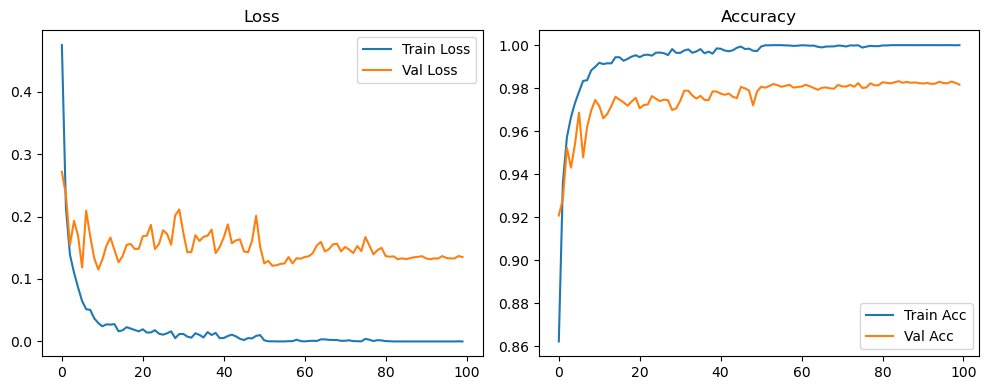

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4968, Acc: 0.8551 | Val Loss: 0.3012, Acc: 0.9141


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2693, Acc: 0.9201 | Val Loss: 0.2473, Acc: 0.9262


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2010, Acc: 0.9393 | Val Loss: 0.1563, Acc: 0.9537


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1566, Acc: 0.9531 | Val Loss: 0.1546, Acc: 0.9556


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1256, Acc: 0.9608 | Val Loss: 0.1440, Acc: 0.9583


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1000, Acc: 0.9690 | Val Loss: 0.1289, Acc: 0.9661


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0904, Acc: 0.9714 | Val Loss: 0.1157, Acc: 0.9688


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0708, Acc: 0.9778 | Val Loss: 0.1460, Acc: 0.9643


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0711, Acc: 0.9777 | Val Loss: 0.1130, Acc: 0.9685


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0546, Acc: 0.9828 | Val Loss: 0.1071, Acc: 0.9736


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0558, Acc: 0.9817 | Val Loss: 0.1162, Acc: 0.9739


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0471, Acc: 0.9850 | Val Loss: 0.1101, Acc: 0.9732


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0395, Acc: 0.9875 | Val Loss: 0.1030, Acc: 0.9768


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9879 | Val Loss: 0.1225, Acc: 0.9730


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9870 | Val Loss: 0.0959, Acc: 0.9789


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0318, Acc: 0.9895 | Val Loss: 0.1029, Acc: 0.9772


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0378, Acc: 0.9879 | Val Loss: 0.1143, Acc: 0.9748


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9897 | Val Loss: 0.1116, Acc: 0.9778


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9902 | Val Loss: 0.1134, Acc: 0.9772


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9904 | Val Loss: 0.1159, Acc: 0.9747


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9923 | Val Loss: 0.1136, Acc: 0.9779


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0272, Acc: 0.9915 | Val Loss: 0.1228, Acc: 0.9761


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9936 | Val Loss: 0.1146, Acc: 0.9778


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9930 | Val Loss: 0.1152, Acc: 0.9790


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9923 | Val Loss: 0.1257, Acc: 0.9778


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9933 | Val Loss: 0.1271, Acc: 0.9766


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9927 | Val Loss: 0.1080, Acc: 0.9797


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9949 | Val Loss: 0.1093, Acc: 0.9811


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9947 | Val Loss: 0.1516, Acc: 0.9730


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9937 | Val Loss: 0.1110, Acc: 0.9793


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9962 | Val Loss: 0.1096, Acc: 0.9794


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9957 | Val Loss: 0.1194, Acc: 0.9788


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9936 | Val Loss: 0.1280, Acc: 0.9774


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9949 | Val Loss: 0.1289, Acc: 0.9789


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.1252, Acc: 0.9790


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9956 | Val Loss: 0.1187, Acc: 0.9776


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9955 | Val Loss: 0.1306, Acc: 0.9781


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9953 | Val Loss: 0.1170, Acc: 0.9792


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9950 | Val Loss: 0.1354, Acc: 0.9769


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9962 | Val Loss: 0.1139, Acc: 0.9800


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9959 | Val Loss: 0.1345, Acc: 0.9773


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9962 | Val Loss: 0.1242, Acc: 0.9801


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9967 | Val Loss: 0.1205, Acc: 0.9810


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9960 | Val Loss: 0.1340, Acc: 0.9793


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9961 | Val Loss: 0.1296, Acc: 0.9796


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.1210, Acc: 0.9808


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9959 | Val Loss: 0.1333, Acc: 0.9786


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9960 | Val Loss: 0.1128, Acc: 0.9817


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9968 | Val Loss: 0.1121, Acc: 0.9817


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9972 | Val Loss: 0.1118, Acc: 0.9814


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1005, Acc: 0.9828


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1026, Acc: 0.9827


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1024, Acc: 0.9832


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1018, Acc: 0.9836


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1040, Acc: 0.9841


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1042, Acc: 0.9837


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0975, Acc: 0.9839


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.1018, Acc: 0.9837


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1117, Acc: 0.9822


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1096, Acc: 0.9830


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.1126, Acc: 0.9828


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1164, Acc: 0.9823


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1154, Acc: 0.9822


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1202, Acc: 0.9812


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1283, Acc: 0.9817


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9990 | Val Loss: 0.1149, Acc: 0.9825


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1338, Acc: 0.9824


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1339, Acc: 0.9814


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1325, Acc: 0.9816


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1197, Acc: 0.9838


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1298, Acc: 0.9818


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1218, Acc: 0.9832


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1263, Acc: 0.9833


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.1266, Acc: 0.9842


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1378, Acc: 0.9824


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1307, Acc: 0.9831


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1377, Acc: 0.9819


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1376, Acc: 0.9818


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1206, Acc: 0.9835


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.1315, Acc: 0.9818


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1222, Acc: 0.9831


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1196, Acc: 0.9835


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1200, Acc: 0.9838


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1167, Acc: 0.9837


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1140, Acc: 0.9841


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1161, Acc: 0.9834


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1162, Acc: 0.9835


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1175, Acc: 0.9839


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1167, Acc: 0.9842


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1147, Acc: 0.9837


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1139, Acc: 0.9838


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1154, Acc: 0.9842


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1155, Acc: 0.9841


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1152, Acc: 0.9844


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1134, Acc: 0.9843


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1165, Acc: 0.9842


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1160, Acc: 0.9836


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1152, Acc: 0.9838


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1212, Acc: 0.9841


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1199, Acc: 0.9835


Final Test Loss: 0.1068 Accuracy: 0.9848


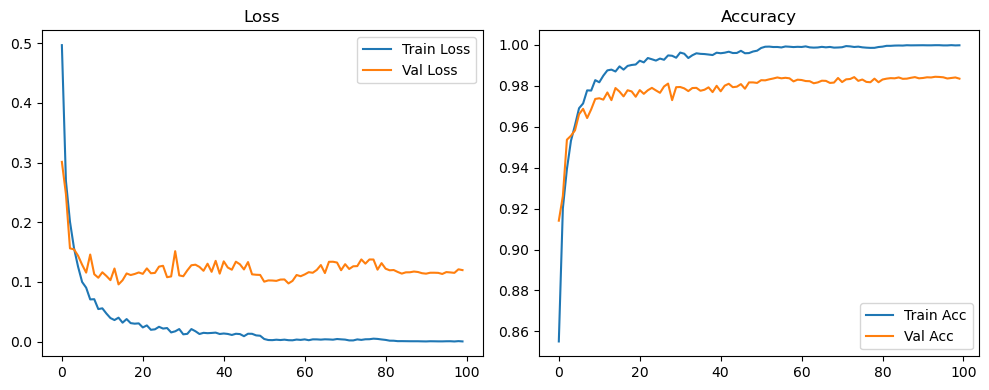

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6507, Acc: 0.8165 | Val Loss: 0.3219, Acc: 0.9059


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3608, Acc: 0.8931 | Val Loss: 0.2862, Acc: 0.9161


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2847, Acc: 0.9152 | Val Loss: 0.1967, Acc: 0.9447


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2358, Acc: 0.9307 | Val Loss: 0.1552, Acc: 0.9551


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2000, Acc: 0.9405 | Val Loss: 0.1646, Acc: 0.9538


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1703, Acc: 0.9490 | Val Loss: 0.1280, Acc: 0.9647


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1466, Acc: 0.9563 | Val Loss: 0.1150, Acc: 0.9693


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1321, Acc: 0.9599 | Val Loss: 0.1179, Acc: 0.9685


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1224, Acc: 0.9631 | Val Loss: 0.1068, Acc: 0.9691


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1090, Acc: 0.9664 | Val Loss: 0.1024, Acc: 0.9719


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0987, Acc: 0.9700 | Val Loss: 0.0996, Acc: 0.9730


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0957, Acc: 0.9714 | Val Loss: 0.0999, Acc: 0.9743


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0828, Acc: 0.9732 | Val Loss: 0.0951, Acc: 0.9753


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0801, Acc: 0.9746 | Val Loss: 0.0851, Acc: 0.9768


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0775, Acc: 0.9758 | Val Loss: 0.0913, Acc: 0.9771


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0707, Acc: 0.9774 | Val Loss: 0.0900, Acc: 0.9761


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0637, Acc: 0.9801 | Val Loss: 0.1011, Acc: 0.9765


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0622, Acc: 0.9801 | Val Loss: 0.0882, Acc: 0.9774


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0592, Acc: 0.9813 | Val Loss: 0.0894, Acc: 0.9779


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0600, Acc: 0.9810 | Val Loss: 0.0862, Acc: 0.9786


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0521, Acc: 0.9832 | Val Loss: 0.0754, Acc: 0.9803


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0523, Acc: 0.9837 | Val Loss: 0.0846, Acc: 0.9799


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0479, Acc: 0.9843 | Val Loss: 0.0784, Acc: 0.9806


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0436, Acc: 0.9862 | Val Loss: 0.0913, Acc: 0.9798


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9853 | Val Loss: 0.0848, Acc: 0.9798


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0461, Acc: 0.9853 | Val Loss: 0.0900, Acc: 0.9778


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0469, Acc: 0.9848 | Val Loss: 0.0855, Acc: 0.9791


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0405, Acc: 0.9867 | Val Loss: 0.0811, Acc: 0.9804


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0400, Acc: 0.9866 | Val Loss: 0.0900, Acc: 0.9797


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9870 | Val Loss: 0.0831, Acc: 0.9806


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0364, Acc: 0.9886 | Val Loss: 0.0778, Acc: 0.9817


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0343, Acc: 0.9890 | Val Loss: 0.0869, Acc: 0.9805


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0340, Acc: 0.9885 | Val Loss: 0.0864, Acc: 0.9806


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0338, Acc: 0.9885 | Val Loss: 0.0908, Acc: 0.9789


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9900 | Val Loss: 0.0812, Acc: 0.9812


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9897 | Val Loss: 0.0831, Acc: 0.9813


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0336, Acc: 0.9890 | Val Loss: 0.0888, Acc: 0.9800


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9896 | Val Loss: 0.0865, Acc: 0.9806


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9905 | Val Loss: 0.0851, Acc: 0.9809


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0284, Acc: 0.9907 | Val Loss: 0.0757, Acc: 0.9832


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9919 | Val Loss: 0.0861, Acc: 0.9821


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0297, Acc: 0.9904 | Val Loss: 0.0815, Acc: 0.9818


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9913 | Val Loss: 0.0886, Acc: 0.9810


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0297, Acc: 0.9905 | Val Loss: 0.0866, Acc: 0.9810


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9920 | Val Loss: 0.0814, Acc: 0.9818


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0247, Acc: 0.9922 | Val Loss: 0.0901, Acc: 0.9802


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9920 | Val Loss: 0.0847, Acc: 0.9838


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9921 | Val Loss: 0.0826, Acc: 0.9832


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9925 | Val Loss: 0.0780, Acc: 0.9841


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9925 | Val Loss: 0.0887, Acc: 0.9823


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9936 | Val Loss: 0.0760, Acc: 0.9846


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9955 | Val Loss: 0.0781, Acc: 0.9842


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.0748, Acc: 0.9846


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9958 | Val Loss: 0.0745, Acc: 0.9843


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.0812, Acc: 0.9846


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9960 | Val Loss: 0.0771, Acc: 0.9844


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9961 | Val Loss: 0.0799, Acc: 0.9848


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9965 | Val Loss: 0.0807, Acc: 0.9848


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9963 | Val Loss: 0.0804, Acc: 0.9846


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.0836, Acc: 0.9840


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9962 | Val Loss: 0.0836, Acc: 0.9843


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.0922, Acc: 0.9841


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.0851, Acc: 0.9840


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9963 | Val Loss: 0.0840, Acc: 0.9837


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9965 | Val Loss: 0.0883, Acc: 0.9836


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.0831, Acc: 0.9850


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9963 | Val Loss: 0.0926, Acc: 0.9836


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.0877, Acc: 0.9842


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.0865, Acc: 0.9848


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.0888, Acc: 0.9846


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.0881, Acc: 0.9842


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.0934, Acc: 0.9846


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.0911, Acc: 0.9846


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.0948, Acc: 0.9840


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.0947, Acc: 0.9848


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.0955, Acc: 0.9842


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.0965, Acc: 0.9832


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.0909, Acc: 0.9844


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.1017, Acc: 0.9839


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.0949, Acc: 0.9839


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.0931, Acc: 0.9838


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0903, Acc: 0.9842


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.0896, Acc: 0.9845


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0884, Acc: 0.9847


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0887, Acc: 0.9846


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0853, Acc: 0.9848


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0870, Acc: 0.9847


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0869, Acc: 0.9848


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.0867, Acc: 0.9852


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0873, Acc: 0.9851


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0868, Acc: 0.9850


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0878, Acc: 0.9851


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0875, Acc: 0.9848


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0884, Acc: 0.9850


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0874, Acc: 0.9849


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0889, Acc: 0.9848


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0887, Acc: 0.9844


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0879, Acc: 0.9852


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0902, Acc: 0.9853


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.0879, Acc: 0.9852


Final Test Loss: 0.0839 Accuracy: 0.9857


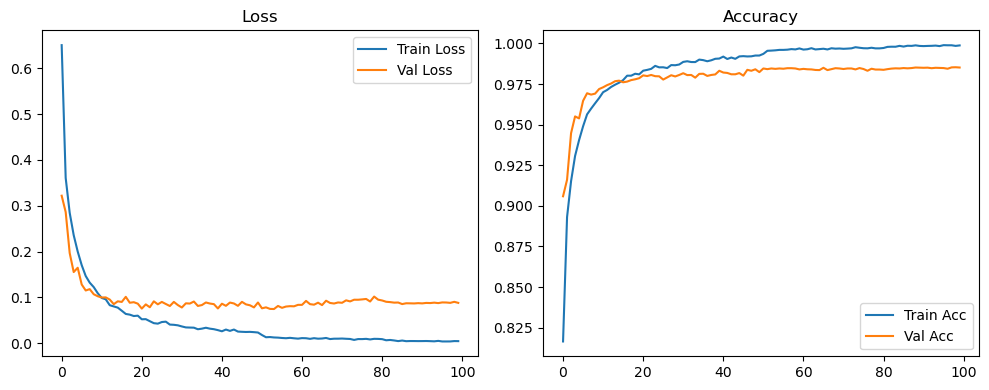

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4743, Acc: 0.8623 | Val Loss: 0.2715, Acc: 0.9208


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2142, Acc: 0.9359 | Val Loss: 0.2348, Acc: 0.9285


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1387, Acc: 0.9572 | Val Loss: 0.1545, Acc: 0.9523


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1102, Acc: 0.9665 | Val Loss: 0.1931, Acc: 0.9431


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0865, Acc: 0.9731 | Val Loss: 0.1692, Acc: 0.9541


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0647, Acc: 0.9784 | Val Loss: 0.1184, Acc: 0.9687


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0517, Acc: 0.9834 | Val Loss: 0.2093, Acc: 0.9478


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0505, Acc: 0.9837 | Val Loss: 0.1683, Acc: 0.9621


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0370, Acc: 0.9883 | Val Loss: 0.1333, Acc: 0.9696


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9899 | Val Loss: 0.1151, Acc: 0.9745


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9918 | Val Loss: 0.1310, Acc: 0.9717


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9912 | Val Loss: 0.1529, Acc: 0.9660


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9916 | Val Loss: 0.1663, Acc: 0.9681


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9915 | Val Loss: 0.1463, Acc: 0.9718


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9944 | Val Loss: 0.1269, Acc: 0.9760


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9944 | Val Loss: 0.1365, Acc: 0.9747


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9928 | Val Loss: 0.1546, Acc: 0.9734


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9936 | Val Loss: 0.1561, Acc: 0.9718


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9947 | Val Loss: 0.1480, Acc: 0.9738


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9953 | Val Loss: 0.1483, Acc: 0.9755


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9944 | Val Loss: 0.1685, Acc: 0.9707


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9954 | Val Loss: 0.1695, Acc: 0.9722


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9956 | Val Loss: 0.1866, Acc: 0.9724


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9951 | Val Loss: 0.1479, Acc: 0.9763


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9965 | Val Loss: 0.1560, Acc: 0.9751


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9966 | Val Loss: 0.1779, Acc: 0.9740


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9962 | Val Loss: 0.1721, Acc: 0.9747


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9954 | Val Loss: 0.1549, Acc: 0.9744


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.2017, Acc: 0.9698


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9964 | Val Loss: 0.2112, Acc: 0.9706


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9964 | Val Loss: 0.1744, Acc: 0.9741


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1429, Acc: 0.9788


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1431, Acc: 0.9788


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9965 | Val Loss: 0.1701, Acc: 0.9766


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9971 | Val Loss: 0.1608, Acc: 0.9752


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 0.1675, Acc: 0.9764


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9962 | Val Loss: 0.1692, Acc: 0.9746


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9970 | Val Loss: 0.1791, Acc: 0.9744


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9960 | Val Loss: 0.1414, Acc: 0.9785


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.1512, Acc: 0.9784


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.1666, Acc: 0.9775


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9975 | Val Loss: 0.1873, Acc: 0.9769


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9972 | Val Loss: 0.1572, Acc: 0.9775


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9976 | Val Loss: 0.1617, Acc: 0.9760


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1635, Acc: 0.9754


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1442, Acc: 0.9806


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1427, Acc: 0.9799


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1613, Acc: 0.9789


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9974 | Val Loss: 0.2011, Acc: 0.9720


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9972 | Val Loss: 0.1515, Acc: 0.9785


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1286, Acc: 0.9801


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1294, Acc: 0.9801


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1253, Acc: 0.9808


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1252, Acc: 0.9812


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1278, Acc: 0.9808


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1259, Acc: 0.9808


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1274, Acc: 0.9817


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1268, Acc: 0.9814


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1267, Acc: 0.9818


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1285, Acc: 0.9819


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1271, Acc: 0.9817


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1269, Acc: 0.9823


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1314, Acc: 0.9818


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1298, Acc: 0.9818


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1295, Acc: 0.9817


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1311, Acc: 0.9815


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1295, Acc: 0.9813


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1307, Acc: 0.9812


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1298, Acc: 0.9824


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1310, Acc: 0.9816


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1303, Acc: 0.9811


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1299, Acc: 0.9818


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1263, Acc: 0.9818


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1278, Acc: 0.9818


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1421, Acc: 0.9812


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1316, Acc: 0.9814


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1304, Acc: 0.9820


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1290, Acc: 0.9821


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1301, Acc: 0.9822


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1401, Acc: 0.9812


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1333, Acc: 0.9821


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1289, Acc: 0.9822


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1284, Acc: 0.9821


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1248, Acc: 0.9825


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1265, Acc: 0.9823


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1260, Acc: 0.9824


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1251, Acc: 0.9827


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1266, Acc: 0.9823


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1274, Acc: 0.9823


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1286, Acc: 0.9828


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1265, Acc: 0.9830


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1259, Acc: 0.9826


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1330, Acc: 0.9828


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1343, Acc: 0.9816


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1453, Acc: 0.9811


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1354, Acc: 0.9820


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1338, Acc: 0.9822


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1323, Acc: 0.9824


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1356, Acc: 0.9831


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1363, Acc: 0.9824


Final Test Loss: 0.1260 Accuracy: 0.9836


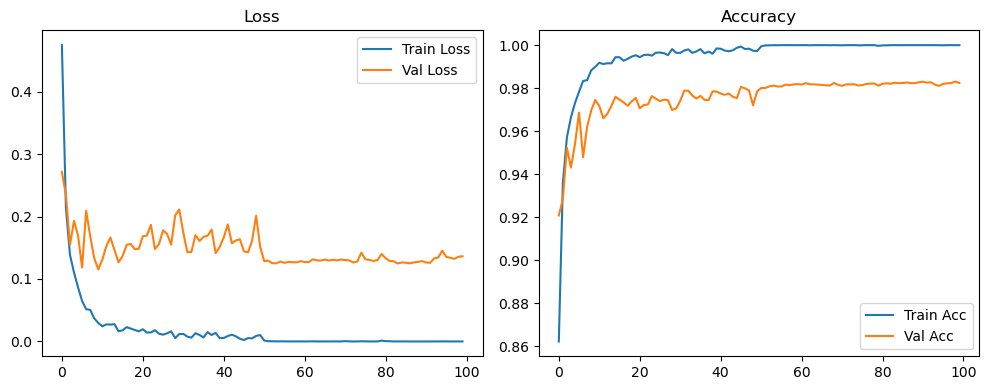

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4968, Acc: 0.8551 | Val Loss: 0.3012, Acc: 0.9141


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2693, Acc: 0.9201 | Val Loss: 0.2473, Acc: 0.9262


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2010, Acc: 0.9393 | Val Loss: 0.1563, Acc: 0.9537


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1566, Acc: 0.9531 | Val Loss: 0.1546, Acc: 0.9556


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1256, Acc: 0.9608 | Val Loss: 0.1440, Acc: 0.9583


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1000, Acc: 0.9690 | Val Loss: 0.1289, Acc: 0.9661


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0904, Acc: 0.9714 | Val Loss: 0.1157, Acc: 0.9688


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0708, Acc: 0.9778 | Val Loss: 0.1460, Acc: 0.9643


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0711, Acc: 0.9777 | Val Loss: 0.1130, Acc: 0.9685


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0546, Acc: 0.9828 | Val Loss: 0.1071, Acc: 0.9736


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0558, Acc: 0.9817 | Val Loss: 0.1162, Acc: 0.9739


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0471, Acc: 0.9850 | Val Loss: 0.1101, Acc: 0.9732


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0395, Acc: 0.9875 | Val Loss: 0.1030, Acc: 0.9768


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9879 | Val Loss: 0.1225, Acc: 0.9730


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9870 | Val Loss: 0.0959, Acc: 0.9789


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0318, Acc: 0.9895 | Val Loss: 0.1029, Acc: 0.9772


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0378, Acc: 0.9879 | Val Loss: 0.1143, Acc: 0.9748


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9897 | Val Loss: 0.1116, Acc: 0.9778


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9902 | Val Loss: 0.1134, Acc: 0.9772


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9904 | Val Loss: 0.1159, Acc: 0.9747


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9923 | Val Loss: 0.1136, Acc: 0.9779


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0272, Acc: 0.9915 | Val Loss: 0.1228, Acc: 0.9761


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9936 | Val Loss: 0.1146, Acc: 0.9778


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9930 | Val Loss: 0.1152, Acc: 0.9790


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9923 | Val Loss: 0.1257, Acc: 0.9778


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9933 | Val Loss: 0.1271, Acc: 0.9766


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9927 | Val Loss: 0.1080, Acc: 0.9797


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9949 | Val Loss: 0.1093, Acc: 0.9811


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9947 | Val Loss: 0.1516, Acc: 0.9730


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9937 | Val Loss: 0.1110, Acc: 0.9793


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9962 | Val Loss: 0.1096, Acc: 0.9794


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9957 | Val Loss: 0.1194, Acc: 0.9788


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9936 | Val Loss: 0.1280, Acc: 0.9774


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9949 | Val Loss: 0.1289, Acc: 0.9789


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.1252, Acc: 0.9790


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9956 | Val Loss: 0.1187, Acc: 0.9776


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9955 | Val Loss: 0.1306, Acc: 0.9781


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9953 | Val Loss: 0.1170, Acc: 0.9792


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9950 | Val Loss: 0.1354, Acc: 0.9769


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9962 | Val Loss: 0.1139, Acc: 0.9800


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9959 | Val Loss: 0.1345, Acc: 0.9773


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9962 | Val Loss: 0.1242, Acc: 0.9801


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9967 | Val Loss: 0.1205, Acc: 0.9810


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9960 | Val Loss: 0.1340, Acc: 0.9793


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9961 | Val Loss: 0.1296, Acc: 0.9796


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.1210, Acc: 0.9808


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9959 | Val Loss: 0.1333, Acc: 0.9786


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9960 | Val Loss: 0.1128, Acc: 0.9817


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9968 | Val Loss: 0.1121, Acc: 0.9817


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9972 | Val Loss: 0.1118, Acc: 0.9814


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9984 | Val Loss: 0.1000, Acc: 0.9830


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0970, Acc: 0.9836


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0949, Acc: 0.9835


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0928, Acc: 0.9841


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0940, Acc: 0.9839


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0956, Acc: 0.9840


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0939, Acc: 0.9835


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0922, Acc: 0.9850


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0923, Acc: 0.9850


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0940, Acc: 0.9843


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0965, Acc: 0.9847


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9999 | Val Loss: 0.0979, Acc: 0.9844


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1011, Acc: 0.9831


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0979, Acc: 0.9839


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0999, Acc: 0.9839


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1006, Acc: 0.9842


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1025, Acc: 0.9843


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1052, Acc: 0.9842


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1095, Acc: 0.9830


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1075, Acc: 0.9836


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1069, Acc: 0.9838


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1100, Acc: 0.9841


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1094, Acc: 0.9829


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1088, Acc: 0.9836


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1146, Acc: 0.9828


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1111, Acc: 0.9837


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1094, Acc: 0.9832


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1118, Acc: 0.9840


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1151, Acc: 0.9842


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1136, Acc: 0.9843


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1094, Acc: 0.9836


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1123, Acc: 0.9838


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1077, Acc: 0.9841


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1110, Acc: 0.9838


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1086, Acc: 0.9839


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1103, Acc: 0.9836


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1141, Acc: 0.9837


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1109, Acc: 0.9832


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1106, Acc: 0.9838


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1114, Acc: 0.9833


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1123, Acc: 0.9844


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1071, Acc: 0.9842


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1099, Acc: 0.9839


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1121, Acc: 0.9836


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1070, Acc: 0.9846


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1094, Acc: 0.9848


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1100, Acc: 0.9839


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1137, Acc: 0.9836


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1169, Acc: 0.9833


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1149, Acc: 0.9842


Final Test Loss: 0.1096 Accuracy: 0.9850


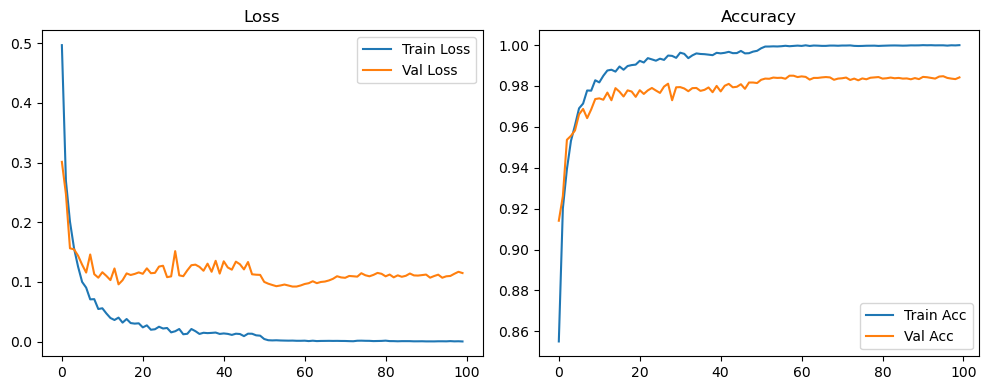

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6507, Acc: 0.8165 | Val Loss: 0.3219, Acc: 0.9059


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3608, Acc: 0.8931 | Val Loss: 0.2862, Acc: 0.9161


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2847, Acc: 0.9152 | Val Loss: 0.1967, Acc: 0.9447


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2358, Acc: 0.9307 | Val Loss: 0.1552, Acc: 0.9551


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2000, Acc: 0.9405 | Val Loss: 0.1646, Acc: 0.9538


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1703, Acc: 0.9490 | Val Loss: 0.1280, Acc: 0.9647


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1466, Acc: 0.9563 | Val Loss: 0.1150, Acc: 0.9693


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1321, Acc: 0.9599 | Val Loss: 0.1179, Acc: 0.9685


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1224, Acc: 0.9631 | Val Loss: 0.1068, Acc: 0.9691


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1090, Acc: 0.9664 | Val Loss: 0.1024, Acc: 0.9719


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0987, Acc: 0.9700 | Val Loss: 0.0996, Acc: 0.9730


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0957, Acc: 0.9714 | Val Loss: 0.0999, Acc: 0.9743


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0828, Acc: 0.9732 | Val Loss: 0.0951, Acc: 0.9753


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0801, Acc: 0.9746 | Val Loss: 0.0851, Acc: 0.9768


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0775, Acc: 0.9758 | Val Loss: 0.0913, Acc: 0.9771


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0707, Acc: 0.9774 | Val Loss: 0.0900, Acc: 0.9761


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0637, Acc: 0.9801 | Val Loss: 0.1011, Acc: 0.9765


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0622, Acc: 0.9801 | Val Loss: 0.0882, Acc: 0.9774


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0592, Acc: 0.9813 | Val Loss: 0.0894, Acc: 0.9779


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0600, Acc: 0.9810 | Val Loss: 0.0862, Acc: 0.9786


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0521, Acc: 0.9832 | Val Loss: 0.0754, Acc: 0.9803


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0523, Acc: 0.9837 | Val Loss: 0.0846, Acc: 0.9799


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0479, Acc: 0.9843 | Val Loss: 0.0784, Acc: 0.9806


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0436, Acc: 0.9862 | Val Loss: 0.0913, Acc: 0.9798


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9853 | Val Loss: 0.0848, Acc: 0.9798


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0461, Acc: 0.9853 | Val Loss: 0.0900, Acc: 0.9778


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0469, Acc: 0.9848 | Val Loss: 0.0855, Acc: 0.9791


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0405, Acc: 0.9867 | Val Loss: 0.0811, Acc: 0.9804


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0400, Acc: 0.9866 | Val Loss: 0.0900, Acc: 0.9797


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9870 | Val Loss: 0.0831, Acc: 0.9806


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0364, Acc: 0.9886 | Val Loss: 0.0778, Acc: 0.9817


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0343, Acc: 0.9890 | Val Loss: 0.0869, Acc: 0.9805


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0340, Acc: 0.9885 | Val Loss: 0.0864, Acc: 0.9806


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0338, Acc: 0.9885 | Val Loss: 0.0908, Acc: 0.9789


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9900 | Val Loss: 0.0812, Acc: 0.9812


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9897 | Val Loss: 0.0831, Acc: 0.9813


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0336, Acc: 0.9890 | Val Loss: 0.0888, Acc: 0.9800


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9896 | Val Loss: 0.0865, Acc: 0.9806


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9905 | Val Loss: 0.0851, Acc: 0.9809


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0284, Acc: 0.9907 | Val Loss: 0.0757, Acc: 0.9832


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9919 | Val Loss: 0.0861, Acc: 0.9821


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0297, Acc: 0.9904 | Val Loss: 0.0815, Acc: 0.9818


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9913 | Val Loss: 0.0886, Acc: 0.9810


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0297, Acc: 0.9905 | Val Loss: 0.0866, Acc: 0.9810


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9920 | Val Loss: 0.0814, Acc: 0.9818


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0247, Acc: 0.9922 | Val Loss: 0.0901, Acc: 0.9802


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9920 | Val Loss: 0.0847, Acc: 0.9838


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9921 | Val Loss: 0.0826, Acc: 0.9832


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9925 | Val Loss: 0.0780, Acc: 0.9841


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9925 | Val Loss: 0.0887, Acc: 0.9823


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0170, Acc: 0.9942 | Val Loss: 0.0779, Acc: 0.9844


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9956 | Val Loss: 0.0757, Acc: 0.9844


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.0730, Acc: 0.9853


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.0725, Acc: 0.9848


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9963 | Val Loss: 0.0755, Acc: 0.9854


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.0740, Acc: 0.9849


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9967 | Val Loss: 0.0736, Acc: 0.9853


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.0730, Acc: 0.9856


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.0730, Acc: 0.9854


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.0745, Acc: 0.9852


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.0757, Acc: 0.9853


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0796, Acc: 0.9852


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0759, Acc: 0.9853


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.0756, Acc: 0.9848


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9975 | Val Loss: 0.0761, Acc: 0.9848


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0753, Acc: 0.9860


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.0818, Acc: 0.9848


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0807, Acc: 0.9852


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0793, Acc: 0.9855


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9976 | Val Loss: 0.0821, Acc: 0.9854


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0797, Acc: 0.9854


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0853, Acc: 0.9850


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0872, Acc: 0.9851


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9981 | Val Loss: 0.0839, Acc: 0.9851


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.0877, Acc: 0.9852


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0875, Acc: 0.9852


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.0865, Acc: 0.9849


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0852, Acc: 0.9851


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0873, Acc: 0.9843


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0868, Acc: 0.9846


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.0892, Acc: 0.9848


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9981 | Val Loss: 0.0859, Acc: 0.9854


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0851, Acc: 0.9852


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.0866, Acc: 0.9854


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0862, Acc: 0.9851


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0842, Acc: 0.9852


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0862, Acc: 0.9856


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0872, Acc: 0.9852


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0879, Acc: 0.9855


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0875, Acc: 0.9857


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0870, Acc: 0.9853


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0872, Acc: 0.9852


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9987 | Val Loss: 0.0893, Acc: 0.9852


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9984 | Val Loss: 0.0898, Acc: 0.9852


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0896, Acc: 0.9852


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0894, Acc: 0.9855


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0905, Acc: 0.9847


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.0887, Acc: 0.9851


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0915, Acc: 0.9851


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.0900, Acc: 0.9850


Final Test Loss: 0.0855 Accuracy: 0.9856


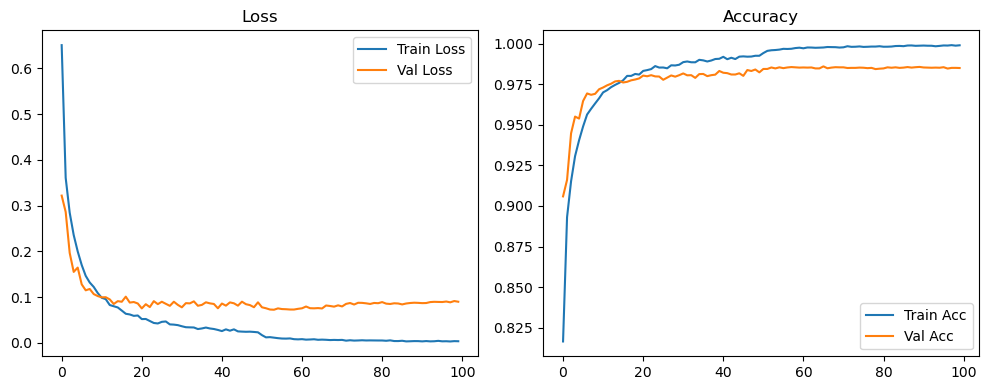

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3919, Acc: 0.8820 | Val Loss: 0.2853, Acc: 0.9165


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2245, Acc: 0.9331 | Val Loss: 0.2796, Acc: 0.9147


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1533, Acc: 0.9540 | Val Loss: 0.1653, Acc: 0.9504


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1200, Acc: 0.9633 | Val Loss: 0.1793, Acc: 0.9454


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0992, Acc: 0.9690 | Val Loss: 0.1602, Acc: 0.9540


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0780, Acc: 0.9746 | Val Loss: 0.1188, Acc: 0.9678


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0577, Acc: 0.9812 | Val Loss: 0.1457, Acc: 0.9597


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0474, Acc: 0.9844 | Val Loss: 0.1254, Acc: 0.9681


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0474, Acc: 0.9842 | Val Loss: 0.1224, Acc: 0.9677


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0315, Acc: 0.9890 | Val Loss: 0.1232, Acc: 0.9708


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0402, Acc: 0.9866 | Val Loss: 0.1038, Acc: 0.9749


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0233, Acc: 0.9920 | Val Loss: 0.1271, Acc: 0.9711


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0225, Acc: 0.9923 | Val Loss: 0.1404, Acc: 0.9702


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0377, Acc: 0.9882 | Val Loss: 0.1458, Acc: 0.9708


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9925 | Val Loss: 0.1152, Acc: 0.9750


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9944 | Val Loss: 0.1274, Acc: 0.9728


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0198, Acc: 0.9936 | Val Loss: 0.1339, Acc: 0.9736


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0225, Acc: 0.9929 | Val Loss: 0.1433, Acc: 0.9726


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9943 | Val Loss: 0.1375, Acc: 0.9753


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9944 | Val Loss: 0.1469, Acc: 0.9746


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9949 | Val Loss: 0.1364, Acc: 0.9749


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9947 | Val Loss: 0.1431, Acc: 0.9748


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9948 | Val Loss: 0.1686, Acc: 0.9697


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9945 | Val Loss: 0.1670, Acc: 0.9729


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9952 | Val Loss: 0.1428, Acc: 0.9774


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.1540, Acc: 0.9758


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9950 | Val Loss: 0.1623, Acc: 0.9745


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9932 | Val Loss: 0.1880, Acc: 0.9732


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0198, Acc: 0.9945 | Val Loss: 0.1721, Acc: 0.9737


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9965 | Val Loss: 0.1641, Acc: 0.9752


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9972 | Val Loss: 0.1514, Acc: 0.9797


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1468, Acc: 0.9793


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9976 | Val Loss: 0.1593, Acc: 0.9768


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.1742, Acc: 0.9752


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.1762, Acc: 0.9761


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1860, Acc: 0.9752


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0227, Acc: 0.9945 | Val Loss: 0.1993, Acc: 0.9714


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9962 | Val Loss: 0.1656, Acc: 0.9785


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9969 | Val Loss: 0.1853, Acc: 0.9763


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9956 | Val Loss: 0.1923, Acc: 0.9745


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9969 | Val Loss: 0.2028, Acc: 0.9722


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9974 | Val Loss: 0.1779, Acc: 0.9771


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9979 | Val Loss: 0.1842, Acc: 0.9777


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9977 | Val Loss: 0.1868, Acc: 0.9777


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9975 | Val Loss: 0.1877, Acc: 0.9775


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1825, Acc: 0.9776


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9978 | Val Loss: 0.2174, Acc: 0.9741


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9964 | Val Loss: 0.1767, Acc: 0.9785


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9976 | Val Loss: 0.2093, Acc: 0.9752


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9980 | Val Loss: 0.1687, Acc: 0.9789


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1751, Acc: 0.9789


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1851, Acc: 0.9786


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9976 | Val Loss: 0.1585, Acc: 0.9802


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9974 | Val Loss: 0.2033, Acc: 0.9782


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9977 | Val Loss: 0.1841, Acc: 0.9781


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9984 | Val Loss: 0.1782, Acc: 0.9792


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1922, Acc: 0.9773


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9982 | Val Loss: 0.1932, Acc: 0.9782


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9980 | Val Loss: 0.1905, Acc: 0.9783


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1814, Acc: 0.9783


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9978 | Val Loss: 0.2194, Acc: 0.9776


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9990 | Val Loss: 0.1909, Acc: 0.9798


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1715, Acc: 0.9803


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9983 | Val Loss: 0.2437, Acc: 0.9766


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9974 | Val Loss: 0.2251, Acc: 0.9781


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9985 | Val Loss: 0.1904, Acc: 0.9797


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1912, Acc: 0.9785


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.1887, Acc: 0.9785


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.2151, Acc: 0.9766


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9977 | Val Loss: 0.2142, Acc: 0.9773


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9977 | Val Loss: 0.2062, Acc: 0.9772


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9975 | Val Loss: 0.2097, Acc: 0.9774


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9987 | Val Loss: 0.1974, Acc: 0.9786


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.1942, Acc: 0.9797


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1826, Acc: 0.9798


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1725, Acc: 0.9821


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1631, Acc: 0.9820


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1600, Acc: 0.9821


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1600, Acc: 0.9822


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9997 | Val Loss: 0.2100, Acc: 0.9794


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9947 | Val Loss: 0.1979, Acc: 0.9782


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.2279, Acc: 0.9748


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9992 | Val Loss: 0.1673, Acc: 0.9804


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1623, Acc: 0.9811


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.2036, Acc: 0.9779


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9987 | Val Loss: 0.2221, Acc: 0.9767


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9986 | Val Loss: 0.1872, Acc: 0.9788


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1684, Acc: 0.9802


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1675, Acc: 0.9810


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1609, Acc: 0.9820


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9995 | Val Loss: 0.1726, Acc: 0.9799


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9986 | Val Loss: 0.2083, Acc: 0.9765


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.1941, Acc: 0.9783


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.1848, Acc: 0.9806


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9985 | Val Loss: 0.2126, Acc: 0.9778


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9984 | Val Loss: 0.2003, Acc: 0.9803


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1693, Acc: 0.9811


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1789, Acc: 0.9802


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1777, Acc: 0.9800


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9996 | Val Loss: 0.1731, Acc: 0.9818


Final Test Loss: 0.1633 Accuracy: 0.9821


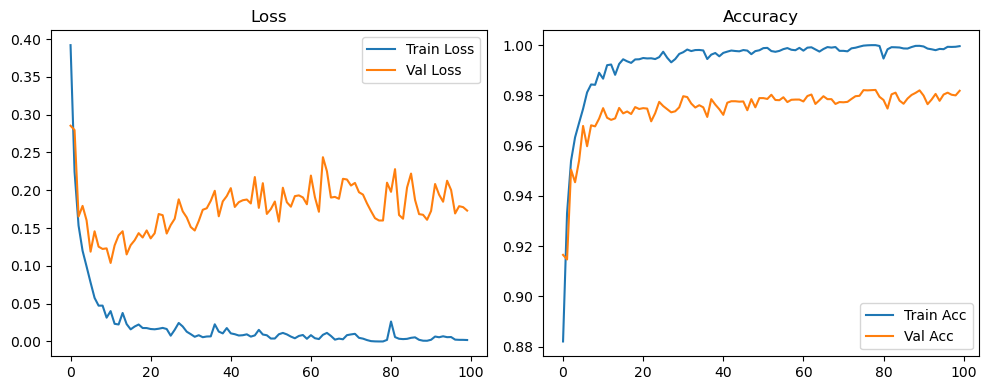

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4281, Acc: 0.8711 | Val Loss: 0.3070, Acc: 0.9098


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2779, Acc: 0.9164 | Val Loss: 0.2768, Acc: 0.9171


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2217, Acc: 0.9328 | Val Loss: 0.1784, Acc: 0.9458


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1742, Acc: 0.9477 | Val Loss: 0.1713, Acc: 0.9482


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1483, Acc: 0.9543 | Val Loss: 0.1923, Acc: 0.9453


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1213, Acc: 0.9628 | Val Loss: 0.1386, Acc: 0.9614


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1023, Acc: 0.9681 | Val Loss: 0.1187, Acc: 0.9654


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0863, Acc: 0.9718 | Val Loss: 0.1208, Acc: 0.9677


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0839, Acc: 0.9735 | Val Loss: 0.1049, Acc: 0.9715


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0668, Acc: 0.9788 | Val Loss: 0.1177, Acc: 0.9701


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0637, Acc: 0.9792 | Val Loss: 0.1078, Acc: 0.9722


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0496, Acc: 0.9835 | Val Loss: 0.1188, Acc: 0.9711


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0470, Acc: 0.9845 | Val Loss: 0.1122, Acc: 0.9741


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0525, Acc: 0.9823 | Val Loss: 0.1055, Acc: 0.9740


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0436, Acc: 0.9853 | Val Loss: 0.1125, Acc: 0.9730


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0388, Acc: 0.9866 | Val Loss: 0.1205, Acc: 0.9743


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0355, Acc: 0.9885 | Val Loss: 0.1075, Acc: 0.9751


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0410, Acc: 0.9872 | Val Loss: 0.1167, Acc: 0.9733


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0361, Acc: 0.9888 | Val Loss: 0.1025, Acc: 0.9764


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0349, Acc: 0.9890 | Val Loss: 0.1118, Acc: 0.9766


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0286, Acc: 0.9907 | Val Loss: 0.1079, Acc: 0.9779


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0274, Acc: 0.9910 | Val Loss: 0.1181, Acc: 0.9751


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0259, Acc: 0.9918 | Val Loss: 0.1085, Acc: 0.9781


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9915 | Val Loss: 0.1168, Acc: 0.9782


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0284, Acc: 0.9912 | Val Loss: 0.1191, Acc: 0.9772


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9929 | Val Loss: 0.1112, Acc: 0.9767


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9924 | Val Loss: 0.1292, Acc: 0.9781


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0232, Acc: 0.9922 | Val Loss: 0.1391, Acc: 0.9766


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0251, Acc: 0.9922 | Val Loss: 0.1177, Acc: 0.9792


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9925 | Val Loss: 0.1271, Acc: 0.9784


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0224, Acc: 0.9929 | Val Loss: 0.1318, Acc: 0.9767


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0226, Acc: 0.9934 | Val Loss: 0.1170, Acc: 0.9787


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9944 | Val Loss: 0.1193, Acc: 0.9788


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9942 | Val Loss: 0.1366, Acc: 0.9778


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9945 | Val Loss: 0.1223, Acc: 0.9798


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9935 | Val Loss: 0.1338, Acc: 0.9788


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0227, Acc: 0.9933 | Val Loss: 0.1442, Acc: 0.9765


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9942 | Val Loss: 0.1343, Acc: 0.9792


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9952 | Val Loss: 0.1297, Acc: 0.9807


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9952 | Val Loss: 0.1390, Acc: 0.9791


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9946 | Val Loss: 0.1423, Acc: 0.9795


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9963 | Val Loss: 0.1276, Acc: 0.9803


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9954 | Val Loss: 0.1569, Acc: 0.9760


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9952 | Val Loss: 0.1442, Acc: 0.9784


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9956 | Val Loss: 0.1296, Acc: 0.9806


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9953 | Val Loss: 0.1520, Acc: 0.9782


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9964 | Val Loss: 0.1263, Acc: 0.9802


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.1536, Acc: 0.9779


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9955 | Val Loss: 0.1461, Acc: 0.9782


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9954 | Val Loss: 0.1634, Acc: 0.9770


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9956 | Val Loss: 0.1361, Acc: 0.9798


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.1440, Acc: 0.9789


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9970 | Val Loss: 0.1346, Acc: 0.9797


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9970 | Val Loss: 0.1530, Acc: 0.9802


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9967 | Val Loss: 0.1507, Acc: 0.9802


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9957 | Val Loss: 0.1394, Acc: 0.9803


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9966 | Val Loss: 0.1560, Acc: 0.9793


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9972 | Val Loss: 0.1323, Acc: 0.9817


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9968 | Val Loss: 0.1507, Acc: 0.9794


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9975 | Val Loss: 0.1456, Acc: 0.9805


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9970 | Val Loss: 0.1340, Acc: 0.9810


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9973 | Val Loss: 0.1422, Acc: 0.9801


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9973 | Val Loss: 0.1501, Acc: 0.9806


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9967 | Val Loss: 0.1656, Acc: 0.9782


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.1549, Acc: 0.9804


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9972 | Val Loss: 0.1655, Acc: 0.9788


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9969 | Val Loss: 0.1442, Acc: 0.9806


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1508, Acc: 0.9798


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9970 | Val Loss: 0.1663, Acc: 0.9781


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.1537, Acc: 0.9811


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9970 | Val Loss: 0.1361, Acc: 0.9813


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9979 | Val Loss: 0.1411, Acc: 0.9812


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.1619, Acc: 0.9798


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9976 | Val Loss: 0.1539, Acc: 0.9788


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1506, Acc: 0.9812


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9978 | Val Loss: 0.1373, Acc: 0.9812


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.1546, Acc: 0.9802


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9974 | Val Loss: 0.1670, Acc: 0.9790


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.1443, Acc: 0.9810


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1517, Acc: 0.9811


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9975 | Val Loss: 0.1559, Acc: 0.9810


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1644, Acc: 0.9788


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9975 | Val Loss: 0.1649, Acc: 0.9791


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1506, Acc: 0.9809


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1452, Acc: 0.9822


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9979 | Val Loss: 0.1474, Acc: 0.9821


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.1541, Acc: 0.9807


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9980 | Val Loss: 0.1670, Acc: 0.9796


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9973 | Val Loss: 0.1511, Acc: 0.9808


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9977 | Val Loss: 0.1498, Acc: 0.9805


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1624, Acc: 0.9798


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1576, Acc: 0.9806


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9980 | Val Loss: 0.1750, Acc: 0.9801


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9973 | Val Loss: 0.1638, Acc: 0.9796


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.1480, Acc: 0.9812


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.1504, Acc: 0.9815


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9982 | Val Loss: 0.1545, Acc: 0.9803


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9985 | Val Loss: 0.1504, Acc: 0.9813


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9978 | Val Loss: 0.1464, Acc: 0.9809


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1477, Acc: 0.9818


Final Test Loss: 0.1309 Accuracy: 0.9821


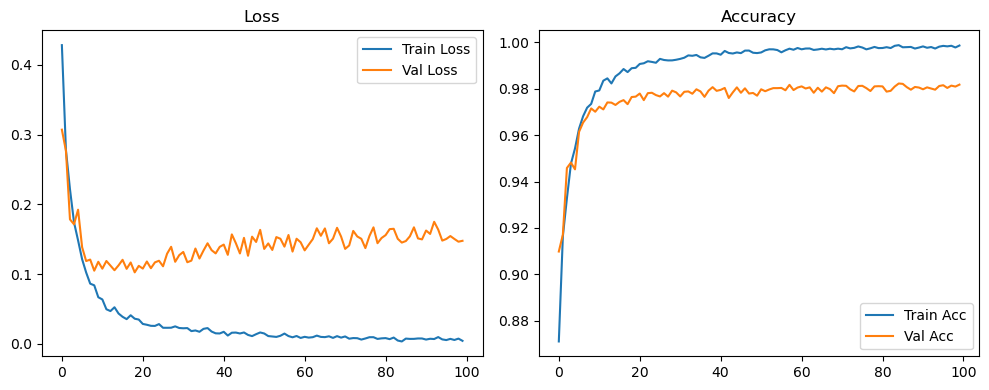

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.5429, Acc: 0.8321 | Val Loss: 0.3203, Acc: 0.9045


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.3743, Acc: 0.8872 | Val Loss: 0.2986, Acc: 0.9118


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.3119, Acc: 0.9059 | Val Loss: 0.2174, Acc: 0.9358


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.2647, Acc: 0.9206 | Val Loss: 0.1891, Acc: 0.9463


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.2335, Acc: 0.9298 | Val Loss: 0.1883, Acc: 0.9465


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.2016, Acc: 0.9388 | Val Loss: 0.1544, Acc: 0.9573


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1756, Acc: 0.9467 | Val Loss: 0.1386, Acc: 0.9606


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1581, Acc: 0.9513 | Val Loss: 0.1428, Acc: 0.9612


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1452, Acc: 0.9563 | Val Loss: 0.1319, Acc: 0.9634


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1318, Acc: 0.9592 | Val Loss: 0.1210, Acc: 0.9683


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1206, Acc: 0.9627 | Val Loss: 0.1126, Acc: 0.9698


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1102, Acc: 0.9669 | Val Loss: 0.1018, Acc: 0.9719


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1006, Acc: 0.9690 | Val Loss: 0.1020, Acc: 0.9722


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0972, Acc: 0.9694 | Val Loss: 0.0929, Acc: 0.9734


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0898, Acc: 0.9736 | Val Loss: 0.1001, Acc: 0.9741


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0847, Acc: 0.9734 | Val Loss: 0.0949, Acc: 0.9747


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0803, Acc: 0.9746 | Val Loss: 0.1048, Acc: 0.9747


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0783, Acc: 0.9749 | Val Loss: 0.1036, Acc: 0.9743


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0712, Acc: 0.9781 | Val Loss: 0.1004, Acc: 0.9762


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0693, Acc: 0.9781 | Val Loss: 0.0979, Acc: 0.9751


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0675, Acc: 0.9788 | Val Loss: 0.0880, Acc: 0.9778


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0628, Acc: 0.9802 | Val Loss: 0.1028, Acc: 0.9759


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0616, Acc: 0.9809 | Val Loss: 0.0898, Acc: 0.9783


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0584, Acc: 0.9816 | Val Loss: 0.0917, Acc: 0.9792


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0570, Acc: 0.9816 | Val Loss: 0.0865, Acc: 0.9804


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0531, Acc: 0.9830 | Val Loss: 0.0998, Acc: 0.9753


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0555, Acc: 0.9826 | Val Loss: 0.0988, Acc: 0.9781


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0520, Acc: 0.9830 | Val Loss: 0.0875, Acc: 0.9798


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0483, Acc: 0.9851 | Val Loss: 0.0918, Acc: 0.9789


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0518, Acc: 0.9842 | Val Loss: 0.1034, Acc: 0.9765


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0463, Acc: 0.9849 | Val Loss: 0.0977, Acc: 0.9788


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0464, Acc: 0.9859 | Val Loss: 0.0982, Acc: 0.9777


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0444, Acc: 0.9859 | Val Loss: 0.0906, Acc: 0.9802


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0385, Acc: 0.9873 | Val Loss: 0.0935, Acc: 0.9805


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0432, Acc: 0.9864 | Val Loss: 0.0957, Acc: 0.9792


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0380, Acc: 0.9878 | Val Loss: 0.0985, Acc: 0.9793


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0390, Acc: 0.9878 | Val Loss: 0.0948, Acc: 0.9795


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0375, Acc: 0.9874 | Val Loss: 0.0957, Acc: 0.9811


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0367, Acc: 0.9883 | Val Loss: 0.1001, Acc: 0.9800


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0357, Acc: 0.9885 | Val Loss: 0.0893, Acc: 0.9809


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0347, Acc: 0.9888 | Val Loss: 0.1019, Acc: 0.9802


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0331, Acc: 0.9892 | Val Loss: 0.0901, Acc: 0.9808


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0336, Acc: 0.9898 | Val Loss: 0.0962, Acc: 0.9812


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9898 | Val Loss: 0.0906, Acc: 0.9817


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0326, Acc: 0.9895 | Val Loss: 0.0962, Acc: 0.9804


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0291, Acc: 0.9901 | Val Loss: 0.0987, Acc: 0.9812


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0310, Acc: 0.9896 | Val Loss: 0.0974, Acc: 0.9815


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9896 | Val Loss: 0.0984, Acc: 0.9818


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0292, Acc: 0.9906 | Val Loss: 0.0963, Acc: 0.9809


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0284, Acc: 0.9912 | Val Loss: 0.1014, Acc: 0.9808


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0292, Acc: 0.9901 | Val Loss: 0.1125, Acc: 0.9788


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0306, Acc: 0.9908 | Val Loss: 0.1047, Acc: 0.9792


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0285, Acc: 0.9913 | Val Loss: 0.0935, Acc: 0.9810


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0249, Acc: 0.9918 | Val Loss: 0.0941, Acc: 0.9813


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9912 | Val Loss: 0.0979, Acc: 0.9812


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0276, Acc: 0.9912 | Val Loss: 0.0989, Acc: 0.9807


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0246, Acc: 0.9917 | Val Loss: 0.1016, Acc: 0.9819


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0234, Acc: 0.9928 | Val Loss: 0.0952, Acc: 0.9811


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9919 | Val Loss: 0.0952, Acc: 0.9816


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9927 | Val Loss: 0.0909, Acc: 0.9826


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0223, Acc: 0.9930 | Val Loss: 0.0929, Acc: 0.9828


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9924 | Val Loss: 0.0989, Acc: 0.9813


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0232, Acc: 0.9930 | Val Loss: 0.1080, Acc: 0.9804


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0267, Acc: 0.9919 | Val Loss: 0.1031, Acc: 0.9809


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9932 | Val Loss: 0.0960, Acc: 0.9817


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9941 | Val Loss: 0.0965, Acc: 0.9818


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0198, Acc: 0.9935 | Val Loss: 0.1012, Acc: 0.9819


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9932 | Val Loss: 0.0996, Acc: 0.9803


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9933 | Val Loss: 0.1067, Acc: 0.9812


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9936 | Val Loss: 0.0957, Acc: 0.9829


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9938 | Val Loss: 0.0912, Acc: 0.9820


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9937 | Val Loss: 0.1015, Acc: 0.9828


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9933 | Val Loss: 0.1003, Acc: 0.9816


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9939 | Val Loss: 0.1007, Acc: 0.9818


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9940 | Val Loss: 0.0994, Acc: 0.9814


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9941 | Val Loss: 0.0973, Acc: 0.9816


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9941 | Val Loss: 0.0913, Acc: 0.9822


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9948 | Val Loss: 0.0980, Acc: 0.9822


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9948 | Val Loss: 0.0933, Acc: 0.9823


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9948 | Val Loss: 0.1001, Acc: 0.9831


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9940 | Val Loss: 0.0990, Acc: 0.9823


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9944 | Val Loss: 0.0986, Acc: 0.9818


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9946 | Val Loss: 0.0989, Acc: 0.9818


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9952 | Val Loss: 0.1014, Acc: 0.9826


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9945 | Val Loss: 0.0961, Acc: 0.9829


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9945 | Val Loss: 0.0979, Acc: 0.9824


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9947 | Val Loss: 0.0897, Acc: 0.9832


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9954 | Val Loss: 0.0961, Acc: 0.9829


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9951 | Val Loss: 0.1009, Acc: 0.9814


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9954 | Val Loss: 0.0929, Acc: 0.9840


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9954 | Val Loss: 0.0966, Acc: 0.9832


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9953 | Val Loss: 0.1043, Acc: 0.9820


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9951 | Val Loss: 0.0935, Acc: 0.9830


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9952 | Val Loss: 0.0932, Acc: 0.9832


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9955 | Val Loss: 0.0955, Acc: 0.9823


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9959 | Val Loss: 0.0969, Acc: 0.9828


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9955 | Val Loss: 0.0976, Acc: 0.9819


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9950 | Val Loss: 0.0973, Acc: 0.9825


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.0993, Acc: 0.9827


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9957 | Val Loss: 0.0971, Acc: 0.9824


Final Test Loss: 0.0841 Accuracy: 0.9845


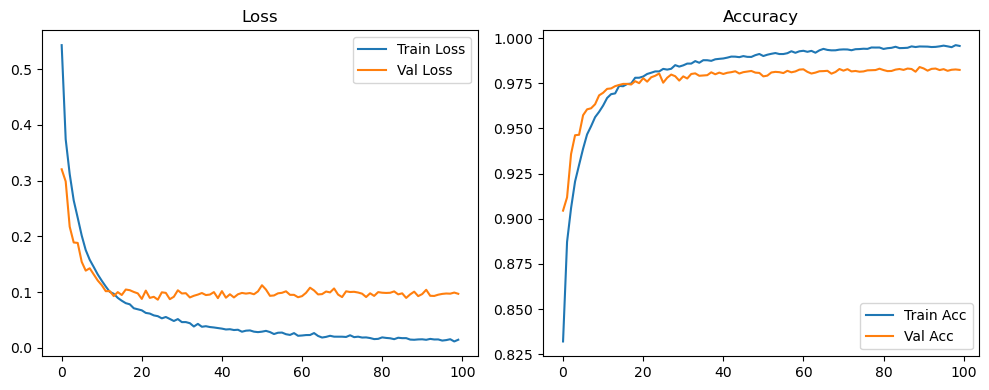

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3919, Acc: 0.8820 | Val Loss: 0.2853, Acc: 0.9165


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2245, Acc: 0.9331 | Val Loss: 0.2796, Acc: 0.9147


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1533, Acc: 0.9540 | Val Loss: 0.1653, Acc: 0.9504


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1200, Acc: 0.9633 | Val Loss: 0.1793, Acc: 0.9454


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0992, Acc: 0.9690 | Val Loss: 0.1602, Acc: 0.9540


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0780, Acc: 0.9746 | Val Loss: 0.1188, Acc: 0.9678


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0577, Acc: 0.9812 | Val Loss: 0.1457, Acc: 0.9597


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0474, Acc: 0.9844 | Val Loss: 0.1254, Acc: 0.9681


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0474, Acc: 0.9842 | Val Loss: 0.1224, Acc: 0.9677


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0315, Acc: 0.9890 | Val Loss: 0.1232, Acc: 0.9708


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0402, Acc: 0.9866 | Val Loss: 0.1038, Acc: 0.9749


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0233, Acc: 0.9920 | Val Loss: 0.1271, Acc: 0.9711


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0225, Acc: 0.9923 | Val Loss: 0.1404, Acc: 0.9702


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0377, Acc: 0.9882 | Val Loss: 0.1458, Acc: 0.9708


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9925 | Val Loss: 0.1152, Acc: 0.9750


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9944 | Val Loss: 0.1274, Acc: 0.9728


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0198, Acc: 0.9936 | Val Loss: 0.1339, Acc: 0.9736


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0225, Acc: 0.9929 | Val Loss: 0.1433, Acc: 0.9726


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9943 | Val Loss: 0.1375, Acc: 0.9753


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9944 | Val Loss: 0.1469, Acc: 0.9746


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9949 | Val Loss: 0.1364, Acc: 0.9749


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9947 | Val Loss: 0.1431, Acc: 0.9748


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9948 | Val Loss: 0.1686, Acc: 0.9697


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9945 | Val Loss: 0.1670, Acc: 0.9729


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9952 | Val Loss: 0.1428, Acc: 0.9774


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.1540, Acc: 0.9758


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9950 | Val Loss: 0.1623, Acc: 0.9745


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9932 | Val Loss: 0.1880, Acc: 0.9732


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0198, Acc: 0.9945 | Val Loss: 0.1721, Acc: 0.9737


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9965 | Val Loss: 0.1641, Acc: 0.9752


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9972 | Val Loss: 0.1514, Acc: 0.9797


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1468, Acc: 0.9793


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9976 | Val Loss: 0.1593, Acc: 0.9768


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.1742, Acc: 0.9752


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.1762, Acc: 0.9761


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1860, Acc: 0.9752


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0227, Acc: 0.9945 | Val Loss: 0.1993, Acc: 0.9714


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9962 | Val Loss: 0.1656, Acc: 0.9785


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9969 | Val Loss: 0.1853, Acc: 0.9763


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9956 | Val Loss: 0.1923, Acc: 0.9745


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9969 | Val Loss: 0.2028, Acc: 0.9722


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9974 | Val Loss: 0.1779, Acc: 0.9771


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9979 | Val Loss: 0.1842, Acc: 0.9777


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9977 | Val Loss: 0.1868, Acc: 0.9777


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9975 | Val Loss: 0.1877, Acc: 0.9775


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1825, Acc: 0.9776


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9978 | Val Loss: 0.2174, Acc: 0.9741


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9964 | Val Loss: 0.1767, Acc: 0.9785


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9976 | Val Loss: 0.2093, Acc: 0.9752


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9980 | Val Loss: 0.1687, Acc: 0.9789


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1520, Acc: 0.9816


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1451, Acc: 0.9812


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1456, Acc: 0.9815


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1508, Acc: 0.9810


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1447, Acc: 0.9812


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1461, Acc: 0.9814


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1411, Acc: 0.9812


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1464, Acc: 0.9812


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9998 | Val Loss: 0.1471, Acc: 0.9813


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1400, Acc: 0.9822


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1401, Acc: 0.9818


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1420, Acc: 0.9812


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1450, Acc: 0.9811


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1452, Acc: 0.9825


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1601, Acc: 0.9804


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1620, Acc: 0.9802


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1835, Acc: 0.9791


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1748, Acc: 0.9793


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.1737, Acc: 0.9796


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1765, Acc: 0.9798


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1675, Acc: 0.9808


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1763, Acc: 0.9796


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1730, Acc: 0.9806


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1741, Acc: 0.9811


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1803, Acc: 0.9808


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1695, Acc: 0.9809


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1694, Acc: 0.9799


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.2070, Acc: 0.9772


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1863, Acc: 0.9794


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1858, Acc: 0.9798


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1729, Acc: 0.9820


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1710, Acc: 0.9822


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1673, Acc: 0.9816


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1635, Acc: 0.9815


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1652, Acc: 0.9819


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1622, Acc: 0.9829


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1635, Acc: 0.9824


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1642, Acc: 0.9825


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1629, Acc: 0.9823


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1623, Acc: 0.9826


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1585, Acc: 0.9824


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1659, Acc: 0.9820


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1777, Acc: 0.9804


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1796, Acc: 0.9815


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1756, Acc: 0.9814


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1788, Acc: 0.9816


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1814, Acc: 0.9811


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1784, Acc: 0.9811


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1686, Acc: 0.9820


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1736, Acc: 0.9817


Final Test Loss: 0.1660 Accuracy: 0.9836


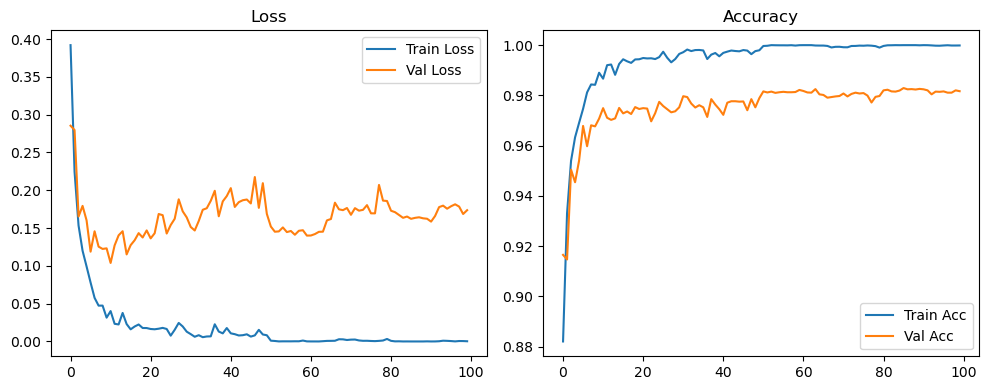

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4281, Acc: 0.8711 | Val Loss: 0.3070, Acc: 0.9098


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2779, Acc: 0.9164 | Val Loss: 0.2768, Acc: 0.9171


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2217, Acc: 0.9328 | Val Loss: 0.1784, Acc: 0.9458


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1742, Acc: 0.9477 | Val Loss: 0.1713, Acc: 0.9482


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1483, Acc: 0.9543 | Val Loss: 0.1923, Acc: 0.9453


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1213, Acc: 0.9628 | Val Loss: 0.1386, Acc: 0.9614


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1023, Acc: 0.9681 | Val Loss: 0.1187, Acc: 0.9654


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0863, Acc: 0.9718 | Val Loss: 0.1208, Acc: 0.9677


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0839, Acc: 0.9735 | Val Loss: 0.1049, Acc: 0.9715


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0668, Acc: 0.9788 | Val Loss: 0.1177, Acc: 0.9701


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0637, Acc: 0.9792 | Val Loss: 0.1078, Acc: 0.9722


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0496, Acc: 0.9835 | Val Loss: 0.1188, Acc: 0.9711


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0470, Acc: 0.9845 | Val Loss: 0.1122, Acc: 0.9741


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0525, Acc: 0.9823 | Val Loss: 0.1055, Acc: 0.9740


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0436, Acc: 0.9853 | Val Loss: 0.1125, Acc: 0.9730


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0388, Acc: 0.9866 | Val Loss: 0.1205, Acc: 0.9743


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0355, Acc: 0.9885 | Val Loss: 0.1075, Acc: 0.9751


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0410, Acc: 0.9872 | Val Loss: 0.1167, Acc: 0.9733


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0361, Acc: 0.9888 | Val Loss: 0.1025, Acc: 0.9764


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0349, Acc: 0.9890 | Val Loss: 0.1118, Acc: 0.9766


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0286, Acc: 0.9907 | Val Loss: 0.1079, Acc: 0.9779


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0274, Acc: 0.9910 | Val Loss: 0.1181, Acc: 0.9751


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0259, Acc: 0.9918 | Val Loss: 0.1085, Acc: 0.9781


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9915 | Val Loss: 0.1168, Acc: 0.9782


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0284, Acc: 0.9912 | Val Loss: 0.1191, Acc: 0.9772


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9929 | Val Loss: 0.1112, Acc: 0.9767


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9924 | Val Loss: 0.1292, Acc: 0.9781


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0232, Acc: 0.9922 | Val Loss: 0.1391, Acc: 0.9766


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0251, Acc: 0.9922 | Val Loss: 0.1177, Acc: 0.9792


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9925 | Val Loss: 0.1271, Acc: 0.9784


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0224, Acc: 0.9929 | Val Loss: 0.1318, Acc: 0.9767


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0226, Acc: 0.9934 | Val Loss: 0.1170, Acc: 0.9787


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9944 | Val Loss: 0.1193, Acc: 0.9788


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9942 | Val Loss: 0.1366, Acc: 0.9778


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9945 | Val Loss: 0.1223, Acc: 0.9798


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9935 | Val Loss: 0.1338, Acc: 0.9788


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0227, Acc: 0.9933 | Val Loss: 0.1442, Acc: 0.9765


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9942 | Val Loss: 0.1343, Acc: 0.9792


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9952 | Val Loss: 0.1297, Acc: 0.9807


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9952 | Val Loss: 0.1390, Acc: 0.9791


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9946 | Val Loss: 0.1423, Acc: 0.9795


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9963 | Val Loss: 0.1276, Acc: 0.9803


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9954 | Val Loss: 0.1569, Acc: 0.9760


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9952 | Val Loss: 0.1442, Acc: 0.9784


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9956 | Val Loss: 0.1296, Acc: 0.9806


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9953 | Val Loss: 0.1520, Acc: 0.9782


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9964 | Val Loss: 0.1263, Acc: 0.9802


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.1536, Acc: 0.9779


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9955 | Val Loss: 0.1461, Acc: 0.9782


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9954 | Val Loss: 0.1634, Acc: 0.9770


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.1284, Acc: 0.9813


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1220, Acc: 0.9831


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1216, Acc: 0.9829


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1242, Acc: 0.9825


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1233, Acc: 0.9826


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1272, Acc: 0.9815


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1172, Acc: 0.9823


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1240, Acc: 0.9832


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1223, Acc: 0.9832


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1316, Acc: 0.9812


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1298, Acc: 0.9823


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1310, Acc: 0.9818


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1339, Acc: 0.9823


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1322, Acc: 0.9817


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1300, Acc: 0.9831


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1324, Acc: 0.9828


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1426, Acc: 0.9820


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9989 | Val Loss: 0.1300, Acc: 0.9822


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1354, Acc: 0.9828


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1380, Acc: 0.9833


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.1429, Acc: 0.9819


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1409, Acc: 0.9832


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9991 | Val Loss: 0.1343, Acc: 0.9832


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1320, Acc: 0.9831


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1403, Acc: 0.9828


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1430, Acc: 0.9829


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9991 | Val Loss: 0.1379, Acc: 0.9824


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1386, Acc: 0.9816


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1357, Acc: 0.9826


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1451, Acc: 0.9833


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1301, Acc: 0.9837


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1301, Acc: 0.9845


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1269, Acc: 0.9845


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1326, Acc: 0.9833


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1325, Acc: 0.9836


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1344, Acc: 0.9836


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1338, Acc: 0.9836


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1310, Acc: 0.9842


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1314, Acc: 0.9842


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1352, Acc: 0.9832


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1371, Acc: 0.9835


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9996 | Val Loss: 0.1342, Acc: 0.9842


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1311, Acc: 0.9852


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1358, Acc: 0.9842


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1397, Acc: 0.9829


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1341, Acc: 0.9845


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1331, Acc: 0.9848


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1416, Acc: 0.9834


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1363, Acc: 0.9841


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1400, Acc: 0.9847


Final Test Loss: 0.1214 Accuracy: 0.9854


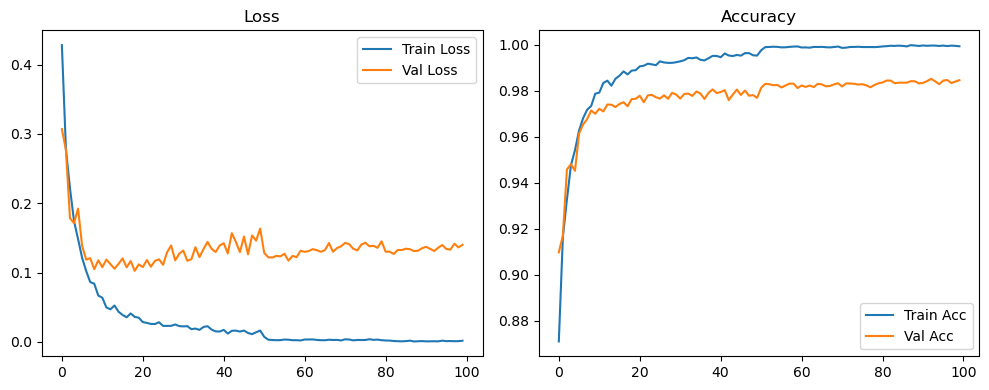

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.5429, Acc: 0.8321 | Val Loss: 0.3203, Acc: 0.9045


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.3743, Acc: 0.8872 | Val Loss: 0.2986, Acc: 0.9118


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.3119, Acc: 0.9059 | Val Loss: 0.2174, Acc: 0.9358


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.2647, Acc: 0.9206 | Val Loss: 0.1891, Acc: 0.9463


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.2335, Acc: 0.9298 | Val Loss: 0.1883, Acc: 0.9465


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.2016, Acc: 0.9388 | Val Loss: 0.1544, Acc: 0.9573


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1756, Acc: 0.9467 | Val Loss: 0.1386, Acc: 0.9606


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1581, Acc: 0.9513 | Val Loss: 0.1428, Acc: 0.9612


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1452, Acc: 0.9563 | Val Loss: 0.1319, Acc: 0.9634


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1318, Acc: 0.9592 | Val Loss: 0.1210, Acc: 0.9683


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1206, Acc: 0.9627 | Val Loss: 0.1126, Acc: 0.9698


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1102, Acc: 0.9669 | Val Loss: 0.1018, Acc: 0.9719


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1006, Acc: 0.9690 | Val Loss: 0.1020, Acc: 0.9722


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0972, Acc: 0.9694 | Val Loss: 0.0929, Acc: 0.9734


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0898, Acc: 0.9736 | Val Loss: 0.1001, Acc: 0.9741


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0847, Acc: 0.9734 | Val Loss: 0.0949, Acc: 0.9747


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0803, Acc: 0.9746 | Val Loss: 0.1048, Acc: 0.9747


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0783, Acc: 0.9749 | Val Loss: 0.1036, Acc: 0.9743


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0712, Acc: 0.9781 | Val Loss: 0.1004, Acc: 0.9762


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0693, Acc: 0.9781 | Val Loss: 0.0979, Acc: 0.9751


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0675, Acc: 0.9788 | Val Loss: 0.0880, Acc: 0.9778


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0628, Acc: 0.9802 | Val Loss: 0.1028, Acc: 0.9759


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0616, Acc: 0.9809 | Val Loss: 0.0898, Acc: 0.9783


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0584, Acc: 0.9816 | Val Loss: 0.0917, Acc: 0.9792


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0570, Acc: 0.9816 | Val Loss: 0.0865, Acc: 0.9804


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0531, Acc: 0.9830 | Val Loss: 0.0998, Acc: 0.9753


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0555, Acc: 0.9826 | Val Loss: 0.0988, Acc: 0.9781


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0520, Acc: 0.9830 | Val Loss: 0.0875, Acc: 0.9798


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0483, Acc: 0.9851 | Val Loss: 0.0918, Acc: 0.9789


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0518, Acc: 0.9842 | Val Loss: 0.1034, Acc: 0.9765


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0463, Acc: 0.9849 | Val Loss: 0.0977, Acc: 0.9788


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0464, Acc: 0.9859 | Val Loss: 0.0982, Acc: 0.9777


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0444, Acc: 0.9859 | Val Loss: 0.0906, Acc: 0.9802


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0385, Acc: 0.9873 | Val Loss: 0.0935, Acc: 0.9805


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0432, Acc: 0.9864 | Val Loss: 0.0957, Acc: 0.9792


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0380, Acc: 0.9878 | Val Loss: 0.0985, Acc: 0.9793


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0390, Acc: 0.9878 | Val Loss: 0.0948, Acc: 0.9795


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0375, Acc: 0.9874 | Val Loss: 0.0957, Acc: 0.9811


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0367, Acc: 0.9883 | Val Loss: 0.1001, Acc: 0.9800


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0357, Acc: 0.9885 | Val Loss: 0.0893, Acc: 0.9809


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0347, Acc: 0.9888 | Val Loss: 0.1019, Acc: 0.9802


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0331, Acc: 0.9892 | Val Loss: 0.0901, Acc: 0.9808


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0336, Acc: 0.9898 | Val Loss: 0.0962, Acc: 0.9812


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9898 | Val Loss: 0.0906, Acc: 0.9817


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0326, Acc: 0.9895 | Val Loss: 0.0962, Acc: 0.9804


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0291, Acc: 0.9901 | Val Loss: 0.0987, Acc: 0.9812


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0310, Acc: 0.9896 | Val Loss: 0.0974, Acc: 0.9815


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9896 | Val Loss: 0.0984, Acc: 0.9818


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0292, Acc: 0.9906 | Val Loss: 0.0963, Acc: 0.9809


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0284, Acc: 0.9912 | Val Loss: 0.1014, Acc: 0.9808


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0217, Acc: 0.9925 | Val Loss: 0.0956, Acc: 0.9818


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9941 | Val Loss: 0.0937, Acc: 0.9821


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0174, Acc: 0.9947 | Val Loss: 0.0965, Acc: 0.9818


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9951 | Val Loss: 0.0918, Acc: 0.9822


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0141, Acc: 0.9952 | Val Loss: 0.0878, Acc: 0.9824


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0148, Acc: 0.9952 | Val Loss: 0.0908, Acc: 0.9828


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9956 | Val Loss: 0.0940, Acc: 0.9820


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9960 | Val Loss: 0.0935, Acc: 0.9822


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.0910, Acc: 0.9828


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9963 | Val Loss: 0.0907, Acc: 0.9828


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9958 | Val Loss: 0.0948, Acc: 0.9822


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9962 | Val Loss: 0.0919, Acc: 0.9828


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9962 | Val Loss: 0.0926, Acc: 0.9832


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.1012, Acc: 0.9819


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9961 | Val Loss: 0.0990, Acc: 0.9826


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.0940, Acc: 0.9828


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9969 | Val Loss: 0.0989, Acc: 0.9825


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.1018, Acc: 0.9829


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9968 | Val Loss: 0.0977, Acc: 0.9835


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9967 | Val Loss: 0.0980, Acc: 0.9840


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.0962, Acc: 0.9838


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9967 | Val Loss: 0.1005, Acc: 0.9842


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.1017, Acc: 0.9838


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.0949, Acc: 0.9834


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.1014, Acc: 0.9830


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.0997, Acc: 0.9835


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.1010, Acc: 0.9836


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.0968, Acc: 0.9835


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.1011, Acc: 0.9832


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.1004, Acc: 0.9842


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.1014, Acc: 0.9830


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9974 | Val Loss: 0.0986, Acc: 0.9833


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9972 | Val Loss: 0.1008, Acc: 0.9835


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1015, Acc: 0.9832


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.1004, Acc: 0.9832


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.1017, Acc: 0.9833


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.1006, Acc: 0.9839


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1051, Acc: 0.9836


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.1062, Acc: 0.9835


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1011, Acc: 0.9832


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1024, Acc: 0.9832


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1055, Acc: 0.9830


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.1056, Acc: 0.9839


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1050, Acc: 0.9828


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1032, Acc: 0.9828


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.1041, Acc: 0.9839


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1031, Acc: 0.9838


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1064, Acc: 0.9835


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1081, Acc: 0.9828


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1071, Acc: 0.9831


Final Test Loss: 0.0886 Accuracy: 0.9864


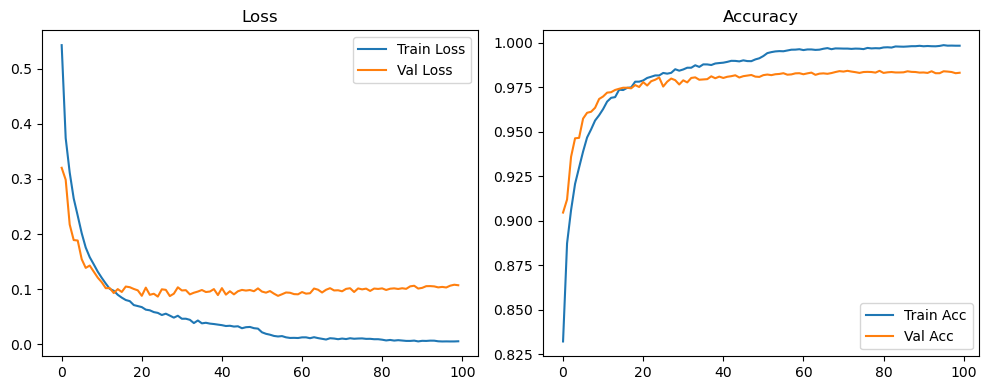

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.3631, Acc: 0.8954 | Val Loss: 0.3290, Acc: 0.9011


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.2347, Acc: 0.9298 | Val Loss: 0.2547, Acc: 0.9213


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1738, Acc: 0.9476 | Val Loss: 0.1860, Acc: 0.9452


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1370, Acc: 0.9586 | Val Loss: 0.1800, Acc: 0.9423


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1107, Acc: 0.9661 | Val Loss: 0.1633, Acc: 0.9509


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0928, Acc: 0.9692 | Val Loss: 0.1350, Acc: 0.9623


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0719, Acc: 0.9766 | Val Loss: 0.1212, Acc: 0.9651


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0583, Acc: 0.9812 | Val Loss: 0.1273, Acc: 0.9626


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0493, Acc: 0.9835 | Val Loss: 0.1117, Acc: 0.9688


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0404, Acc: 0.9868 | Val Loss: 0.1261, Acc: 0.9673


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0416, Acc: 0.9858 | Val Loss: 0.1034, Acc: 0.9709


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0288, Acc: 0.9905 | Val Loss: 0.1466, Acc: 0.9613


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0334, Acc: 0.9880 | Val Loss: 0.1183, Acc: 0.9692


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0296, Acc: 0.9901 | Val Loss: 0.1145, Acc: 0.9688


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0207, Acc: 0.9931 | Val Loss: 0.0968, Acc: 0.9759


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0214, Acc: 0.9926 | Val Loss: 0.1183, Acc: 0.9708


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0163, Acc: 0.9939 | Val Loss: 0.1313, Acc: 0.9684


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0219, Acc: 0.9926 | Val Loss: 0.1316, Acc: 0.9701


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0188, Acc: 0.9935 | Val Loss: 0.1168, Acc: 0.9725


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0157, Acc: 0.9943 | Val Loss: 0.1199, Acc: 0.9721


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.1323, Acc: 0.9708


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.1234, Acc: 0.9732


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9958 | Val Loss: 0.1548, Acc: 0.9676


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0205, Acc: 0.9930 | Val Loss: 0.1549, Acc: 0.9702


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0193, Acc: 0.9936 | Val Loss: 0.1289, Acc: 0.9739


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.1160, Acc: 0.9744


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9959 | Val Loss: 0.1102, Acc: 0.9772


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.1235, Acc: 0.9745


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1235, Acc: 0.9763


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.1367, Acc: 0.9741


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.1554, Acc: 0.9732


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9961 | Val Loss: 0.1791, Acc: 0.9665


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.1542, Acc: 0.9724


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0143, Acc: 0.9949 | Val Loss: 0.1587, Acc: 0.9737


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9960 | Val Loss: 0.1336, Acc: 0.9762


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9973 | Val Loss: 0.1718, Acc: 0.9708


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9947 | Val Loss: 0.1512, Acc: 0.9747


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.1454, Acc: 0.9742


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.1689, Acc: 0.9723


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9976 | Val Loss: 0.1663, Acc: 0.9723


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.1463, Acc: 0.9764


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.1624, Acc: 0.9741


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9957 | Val Loss: 0.1793, Acc: 0.9709


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9965 | Val Loss: 0.1752, Acc: 0.9728


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.1379, Acc: 0.9765


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1533, Acc: 0.9776


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1353, Acc: 0.9797


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1495, Acc: 0.9769


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1383, Acc: 0.9785


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1563, Acc: 0.9783


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.1572, Acc: 0.9762


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1759, Acc: 0.9736


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9971 | Val Loss: 0.1869, Acc: 0.9741


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.1567, Acc: 0.9760


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.1474, Acc: 0.9787


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9972 | Val Loss: 0.1884, Acc: 0.9735


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1676, Acc: 0.9763


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1470, Acc: 0.9790


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1386, Acc: 0.9801


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1543, Acc: 0.9774


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1444, Acc: 0.9777


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1697, Acc: 0.9773


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9972 | Val Loss: 0.1770, Acc: 0.9774


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1915, Acc: 0.9729


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1640, Acc: 0.9787


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9987 | Val Loss: 0.1498, Acc: 0.9796


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.1787, Acc: 0.9763


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.1858, Acc: 0.9765


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9975 | Val Loss: 0.1920, Acc: 0.9756


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9973 | Val Loss: 0.1742, Acc: 0.9786


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1679, Acc: 0.9778


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.1600, Acc: 0.9789


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1715, Acc: 0.9788


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1588, Acc: 0.9803


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9989 | Val Loss: 0.1761, Acc: 0.9782


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1728, Acc: 0.9788


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1760, Acc: 0.9785


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1640, Acc: 0.9796


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.1601, Acc: 0.9808


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.1510, Acc: 0.9820


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9989 | Val Loss: 0.1824, Acc: 0.9787


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9977 | Val Loss: 0.1726, Acc: 0.9788


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1849, Acc: 0.9789


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1959, Acc: 0.9758


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1672, Acc: 0.9795


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1969, Acc: 0.9780


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1696, Acc: 0.9790


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1637, Acc: 0.9812


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9984 | Val Loss: 0.1817, Acc: 0.9792


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9976 | Val Loss: 0.2127, Acc: 0.9772


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9983 | Val Loss: 0.1950, Acc: 0.9764


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1843, Acc: 0.9802


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1820, Acc: 0.9799


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1932, Acc: 0.9790


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1994, Acc: 0.9764


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9981 | Val Loss: 0.2225, Acc: 0.9748


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1883, Acc: 0.9798


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.2013, Acc: 0.9776


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.2077, Acc: 0.9779


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1871, Acc: 0.9812


Final Test Loss: 0.1521 Accuracy: 0.9828


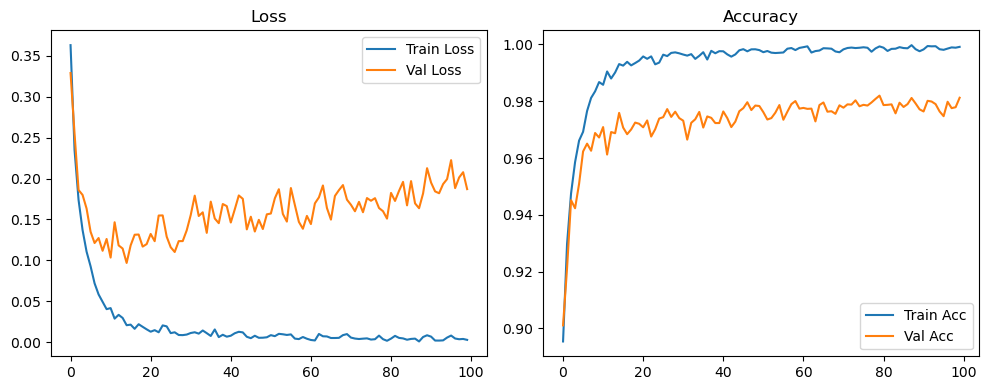

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.4163, Acc: 0.8789 | Val Loss: 0.3096, Acc: 0.9082


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.2870, Acc: 0.9146 | Val Loss: 0.2630, Acc: 0.9205


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.2464, Acc: 0.9259 | Val Loss: 0.2161, Acc: 0.9360


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.2107, Acc: 0.9371 | Val Loss: 0.1880, Acc: 0.9453


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1787, Acc: 0.9461 | Val Loss: 0.2019, Acc: 0.9391


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.1567, Acc: 0.9519 | Val Loss: 0.1699, Acc: 0.9499


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.1337, Acc: 0.9586 | Val Loss: 0.1390, Acc: 0.9599


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.1155, Acc: 0.9633 | Val Loss: 0.1403, Acc: 0.9593


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.1057, Acc: 0.9677 | Val Loss: 0.1254, Acc: 0.9627


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0912, Acc: 0.9706 | Val Loss: 0.1336, Acc: 0.9626


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0830, Acc: 0.9734 | Val Loss: 0.1075, Acc: 0.9692


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0707, Acc: 0.9769 | Val Loss: 0.1313, Acc: 0.9636


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0681, Acc: 0.9780 | Val Loss: 0.1014, Acc: 0.9724


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0627, Acc: 0.9796 | Val Loss: 0.1088, Acc: 0.9699


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0588, Acc: 0.9809 | Val Loss: 0.1068, Acc: 0.9698


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0524, Acc: 0.9818 | Val Loss: 0.1255, Acc: 0.9680


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0449, Acc: 0.9846 | Val Loss: 0.1169, Acc: 0.9699


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0460, Acc: 0.9849 | Val Loss: 0.1096, Acc: 0.9729


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0426, Acc: 0.9854 | Val Loss: 0.1097, Acc: 0.9722


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0396, Acc: 0.9861 | Val Loss: 0.1136, Acc: 0.9726


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0354, Acc: 0.9882 | Val Loss: 0.1037, Acc: 0.9758


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0344, Acc: 0.9880 | Val Loss: 0.1029, Acc: 0.9742


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0299, Acc: 0.9901 | Val Loss: 0.1069, Acc: 0.9748


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9894 | Val Loss: 0.1130, Acc: 0.9748


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0281, Acc: 0.9904 | Val Loss: 0.1049, Acc: 0.9762


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0251, Acc: 0.9913 | Val Loss: 0.1134, Acc: 0.9742


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0263, Acc: 0.9911 | Val Loss: 0.1054, Acc: 0.9766


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0241, Acc: 0.9918 | Val Loss: 0.1083, Acc: 0.9758


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0270, Acc: 0.9908 | Val Loss: 0.1121, Acc: 0.9765


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0229, Acc: 0.9923 | Val Loss: 0.1054, Acc: 0.9773


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0210, Acc: 0.9927 | Val Loss: 0.1115, Acc: 0.9779


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0207, Acc: 0.9931 | Val Loss: 0.1034, Acc: 0.9771


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0233, Acc: 0.9923 | Val Loss: 0.1233, Acc: 0.9746


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0208, Acc: 0.9931 | Val Loss: 0.1122, Acc: 0.9775


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9942 | Val Loss: 0.1224, Acc: 0.9752


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0224, Acc: 0.9929 | Val Loss: 0.1196, Acc: 0.9762


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0186, Acc: 0.9938 | Val Loss: 0.1072, Acc: 0.9784


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0179, Acc: 0.9942 | Val Loss: 0.1088, Acc: 0.9778


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0154, Acc: 0.9950 | Val Loss: 0.1051, Acc: 0.9784


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9941 | Val Loss: 0.1180, Acc: 0.9775


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0157, Acc: 0.9948 | Val Loss: 0.1176, Acc: 0.9784


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9948 | Val Loss: 0.1328, Acc: 0.9755


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0166, Acc: 0.9943 | Val Loss: 0.1159, Acc: 0.9778


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9946 | Val Loss: 0.1355, Acc: 0.9770


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0156, Acc: 0.9944 | Val Loss: 0.1106, Acc: 0.9793


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9954 | Val Loss: 0.1277, Acc: 0.9790


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9951 | Val Loss: 0.1157, Acc: 0.9786


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0164, Acc: 0.9945 | Val Loss: 0.1237, Acc: 0.9788


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0157, Acc: 0.9951 | Val Loss: 0.1227, Acc: 0.9788


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.1241, Acc: 0.9781


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9958 | Val Loss: 0.1226, Acc: 0.9791


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9958 | Val Loss: 0.1168, Acc: 0.9810


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.1324, Acc: 0.9779


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9953 | Val Loss: 0.1158, Acc: 0.9799


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9965 | Val Loss: 0.1246, Acc: 0.9806


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9960 | Val Loss: 0.1366, Acc: 0.9768


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9958 | Val Loss: 0.1488, Acc: 0.9764


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.1261, Acc: 0.9786


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.1420, Acc: 0.9766


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.1353, Acc: 0.9788


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.1442, Acc: 0.9778


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9962 | Val Loss: 0.1397, Acc: 0.9780


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0128, Acc: 0.9957 | Val Loss: 0.1393, Acc: 0.9797


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.1375, Acc: 0.9797


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9965 | Val Loss: 0.1458, Acc: 0.9770


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9966 | Val Loss: 0.1445, Acc: 0.9793


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1322, Acc: 0.9803


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.1276, Acc: 0.9804


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9972 | Val Loss: 0.1561, Acc: 0.9793


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.1390, Acc: 0.9791


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9968 | Val Loss: 0.1432, Acc: 0.9790


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9966 | Val Loss: 0.1396, Acc: 0.9792


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9963 | Val Loss: 0.1507, Acc: 0.9778


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.1353, Acc: 0.9797


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.1387, Acc: 0.9794


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.1437, Acc: 0.9776


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9972 | Val Loss: 0.1537, Acc: 0.9790


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1559, Acc: 0.9794


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.1335, Acc: 0.9809


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.1427, Acc: 0.9813


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.1531, Acc: 0.9798


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9971 | Val Loss: 0.1557, Acc: 0.9774


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1578, Acc: 0.9781


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.1418, Acc: 0.9792


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1566, Acc: 0.9804


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9978 | Val Loss: 0.1427, Acc: 0.9807


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1425, Acc: 0.9803


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9978 | Val Loss: 0.1579, Acc: 0.9789


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9978 | Val Loss: 0.1501, Acc: 0.9804


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.1488, Acc: 0.9787


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9977 | Val Loss: 0.1574, Acc: 0.9779


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9974 | Val Loss: 0.1584, Acc: 0.9781


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.1638, Acc: 0.9787


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1625, Acc: 0.9792


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1583, Acc: 0.9807


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9979 | Val Loss: 0.1570, Acc: 0.9804


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9967 | Val Loss: 0.1828, Acc: 0.9768


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1572, Acc: 0.9792


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.1595, Acc: 0.9796


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9974 | Val Loss: 0.1664, Acc: 0.9793


Final Test Loss: 0.1378 Accuracy: 0.9838


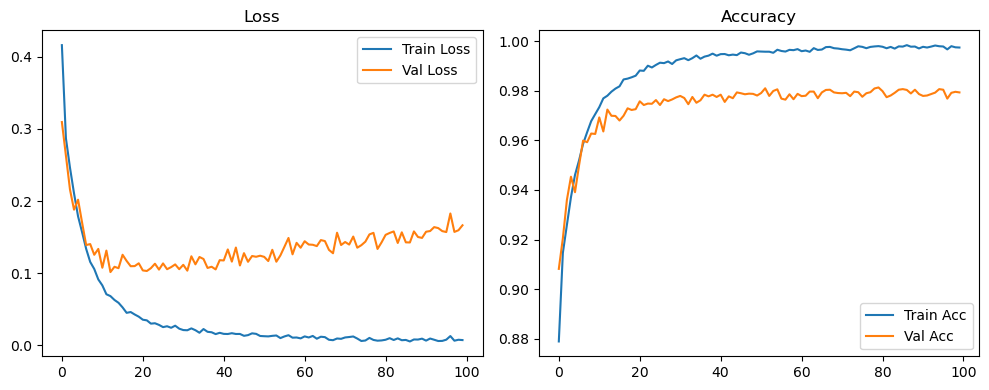

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.5636, Acc: 0.8298 | Val Loss: 0.3135, Acc: 0.9087


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.3923, Acc: 0.8806 | Val Loss: 0.2778, Acc: 0.9194


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.3406, Acc: 0.8972 | Val Loss: 0.2507, Acc: 0.9267


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.3094, Acc: 0.9071 | Val Loss: 0.2359, Acc: 0.9339


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.2796, Acc: 0.9158 | Val Loss: 0.2347, Acc: 0.9293


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.2540, Acc: 0.9223 | Val Loss: 0.2095, Acc: 0.9404


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.2274, Acc: 0.9314 | Val Loss: 0.1802, Acc: 0.9493


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.2128, Acc: 0.9347 | Val Loss: 0.1709, Acc: 0.9500


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.1930, Acc: 0.9415 | Val Loss: 0.1613, Acc: 0.9533


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.1778, Acc: 0.9459 | Val Loss: 0.1506, Acc: 0.9578


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.1625, Acc: 0.9499 | Val Loss: 0.1319, Acc: 0.9617


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.1510, Acc: 0.9541 | Val Loss: 0.1398, Acc: 0.9612


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.1398, Acc: 0.9565 | Val Loss: 0.1204, Acc: 0.9658


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.1317, Acc: 0.9584 | Val Loss: 0.1171, Acc: 0.9677


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.1224, Acc: 0.9618 | Val Loss: 0.1219, Acc: 0.9646


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.1136, Acc: 0.9634 | Val Loss: 0.1166, Acc: 0.9688


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.1107, Acc: 0.9660 | Val Loss: 0.1100, Acc: 0.9693


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.1038, Acc: 0.9670 | Val Loss: 0.1093, Acc: 0.9707


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0941, Acc: 0.9707 | Val Loss: 0.1053, Acc: 0.9714


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0955, Acc: 0.9700 | Val Loss: 0.1039, Acc: 0.9728


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0875, Acc: 0.9730 | Val Loss: 0.1002, Acc: 0.9733


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0819, Acc: 0.9735 | Val Loss: 0.1040, Acc: 0.9739


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0820, Acc: 0.9734 | Val Loss: 0.0996, Acc: 0.9749


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0781, Acc: 0.9756 | Val Loss: 0.1006, Acc: 0.9751


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0744, Acc: 0.9755 | Val Loss: 0.1023, Acc: 0.9743


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0676, Acc: 0.9784 | Val Loss: 0.0992, Acc: 0.9732


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0681, Acc: 0.9779 | Val Loss: 0.0974, Acc: 0.9755


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0638, Acc: 0.9790 | Val Loss: 0.0974, Acc: 0.9758


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0650, Acc: 0.9787 | Val Loss: 0.0940, Acc: 0.9753


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0645, Acc: 0.9792 | Val Loss: 0.0948, Acc: 0.9782


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0593, Acc: 0.9810 | Val Loss: 0.0966, Acc: 0.9772


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0552, Acc: 0.9816 | Val Loss: 0.0957, Acc: 0.9771


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0555, Acc: 0.9819 | Val Loss: 0.1004, Acc: 0.9749


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0507, Acc: 0.9825 | Val Loss: 0.1006, Acc: 0.9777


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0477, Acc: 0.9842 | Val Loss: 0.0961, Acc: 0.9771


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0523, Acc: 0.9825 | Val Loss: 0.0925, Acc: 0.9782


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0516, Acc: 0.9831 | Val Loss: 0.0977, Acc: 0.9782


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0464, Acc: 0.9844 | Val Loss: 0.1001, Acc: 0.9775


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0450, Acc: 0.9851 | Val Loss: 0.0968, Acc: 0.9788


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0451, Acc: 0.9851 | Val Loss: 0.0966, Acc: 0.9790


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0412, Acc: 0.9862 | Val Loss: 0.0997, Acc: 0.9784


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0428, Acc: 0.9860 | Val Loss: 0.0917, Acc: 0.9801


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0415, Acc: 0.9855 | Val Loss: 0.0936, Acc: 0.9792


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0394, Acc: 0.9868 | Val Loss: 0.0945, Acc: 0.9781


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0373, Acc: 0.9877 | Val Loss: 0.0991, Acc: 0.9777


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0345, Acc: 0.9885 | Val Loss: 0.0972, Acc: 0.9793


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0343, Acc: 0.9879 | Val Loss: 0.1048, Acc: 0.9799


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0395, Acc: 0.9869 | Val Loss: 0.1005, Acc: 0.9794


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0367, Acc: 0.9874 | Val Loss: 0.1016, Acc: 0.9794


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0369, Acc: 0.9877 | Val Loss: 0.1016, Acc: 0.9799


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0340, Acc: 0.9886 | Val Loss: 0.1021, Acc: 0.9779


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0353, Acc: 0.9885 | Val Loss: 0.1033, Acc: 0.9808


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0353, Acc: 0.9886 | Val Loss: 0.0992, Acc: 0.9802


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0335, Acc: 0.9891 | Val Loss: 0.0996, Acc: 0.9797


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0335, Acc: 0.9886 | Val Loss: 0.0998, Acc: 0.9805


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0324, Acc: 0.9895 | Val Loss: 0.1074, Acc: 0.9784


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0324, Acc: 0.9894 | Val Loss: 0.1028, Acc: 0.9796


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0272, Acc: 0.9911 | Val Loss: 0.0999, Acc: 0.9800


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9903 | Val Loss: 0.1013, Acc: 0.9796


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0297, Acc: 0.9904 | Val Loss: 0.1024, Acc: 0.9795


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9909 | Val Loss: 0.1039, Acc: 0.9798


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0238, Acc: 0.9920 | Val Loss: 0.1020, Acc: 0.9798


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0278, Acc: 0.9912 | Val Loss: 0.1071, Acc: 0.9796


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0294, Acc: 0.9907 | Val Loss: 0.1007, Acc: 0.9805


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0277, Acc: 0.9911 | Val Loss: 0.1062, Acc: 0.9796


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0261, Acc: 0.9913 | Val Loss: 0.1069, Acc: 0.9802


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0262, Acc: 0.9916 | Val Loss: 0.1063, Acc: 0.9792


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0247, Acc: 0.9920 | Val Loss: 0.1035, Acc: 0.9802


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0251, Acc: 0.9915 | Val Loss: 0.1066, Acc: 0.9808


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0269, Acc: 0.9912 | Val Loss: 0.1128, Acc: 0.9794


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0247, Acc: 0.9918 | Val Loss: 0.1070, Acc: 0.9804


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0264, Acc: 0.9911 | Val Loss: 0.1123, Acc: 0.9795


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0266, Acc: 0.9914 | Val Loss: 0.1116, Acc: 0.9806


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0239, Acc: 0.9925 | Val Loss: 0.1127, Acc: 0.9798


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0238, Acc: 0.9924 | Val Loss: 0.1105, Acc: 0.9800


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0207, Acc: 0.9933 | Val Loss: 0.1111, Acc: 0.9802


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0223, Acc: 0.9933 | Val Loss: 0.0993, Acc: 0.9813


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0228, Acc: 0.9925 | Val Loss: 0.1060, Acc: 0.9812


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0221, Acc: 0.9928 | Val Loss: 0.1066, Acc: 0.9818


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0220, Acc: 0.9930 | Val Loss: 0.1046, Acc: 0.9818


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0216, Acc: 0.9932 | Val Loss: 0.1051, Acc: 0.9820


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0235, Acc: 0.9924 | Val Loss: 0.1030, Acc: 0.9811


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0222, Acc: 0.9925 | Val Loss: 0.1120, Acc: 0.9799


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9939 | Val Loss: 0.1152, Acc: 0.9808


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0202, Acc: 0.9932 | Val Loss: 0.1090, Acc: 0.9810


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0215, Acc: 0.9929 | Val Loss: 0.1053, Acc: 0.9816


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0186, Acc: 0.9940 | Val Loss: 0.1037, Acc: 0.9829


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0216, Acc: 0.9929 | Val Loss: 0.1160, Acc: 0.9812


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9937 | Val Loss: 0.1134, Acc: 0.9808


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0185, Acc: 0.9940 | Val Loss: 0.1104, Acc: 0.9818


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0214, Acc: 0.9936 | Val Loss: 0.1166, Acc: 0.9808


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0189, Acc: 0.9934 | Val Loss: 0.1178, Acc: 0.9814


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0186, Acc: 0.9936 | Val Loss: 0.1095, Acc: 0.9808


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0175, Acc: 0.9942 | Val Loss: 0.1062, Acc: 0.9822


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0185, Acc: 0.9938 | Val Loss: 0.1143, Acc: 0.9815


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0179, Acc: 0.9941 | Val Loss: 0.1147, Acc: 0.9820


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0183, Acc: 0.9942 | Val Loss: 0.1090, Acc: 0.9828


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0170, Acc: 0.9948 | Val Loss: 0.1150, Acc: 0.9814


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0173, Acc: 0.9945 | Val Loss: 0.1199, Acc: 0.9805


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0171, Acc: 0.9945 | Val Loss: 0.1181, Acc: 0.9812


Final Test Loss: 0.1003 Accuracy: 0.9841


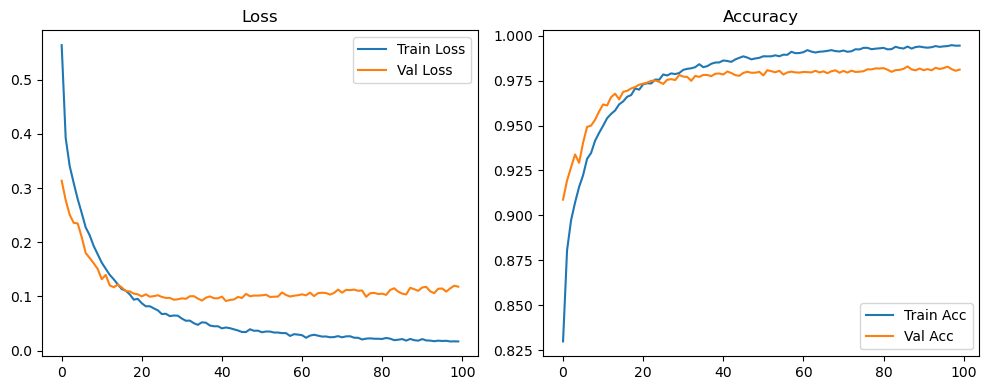

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.3757, Acc: 0.8971 | Val Loss: 0.2926, Acc: 0.9160


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.2387, Acc: 0.9291 | Val Loss: 0.2545, Acc: 0.9207


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1838, Acc: 0.9448 | Val Loss: 0.1986, Acc: 0.9398


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1487, Acc: 0.9552 | Val Loss: 0.1728, Acc: 0.9457


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.1209, Acc: 0.9637 | Val Loss: 0.1764, Acc: 0.9478


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.1021, Acc: 0.9671 | Val Loss: 0.1564, Acc: 0.9552


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0836, Acc: 0.9739 | Val Loss: 0.1415, Acc: 0.9573


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0703, Acc: 0.9772 | Val Loss: 0.1266, Acc: 0.9606


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0613, Acc: 0.9801 | Val Loss: 0.1267, Acc: 0.9617


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0500, Acc: 0.9840 | Val Loss: 0.1153, Acc: 0.9658


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0470, Acc: 0.9840 | Val Loss: 0.1238, Acc: 0.9648


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0387, Acc: 0.9870 | Val Loss: 0.1236, Acc: 0.9652


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0352, Acc: 0.9885 | Val Loss: 0.1087, Acc: 0.9691


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0306, Acc: 0.9896 | Val Loss: 0.1130, Acc: 0.9669


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0290, Acc: 0.9904 | Val Loss: 0.1187, Acc: 0.9682


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0249, Acc: 0.9919 | Val Loss: 0.1201, Acc: 0.9659


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0201, Acc: 0.9934 | Val Loss: 0.1110, Acc: 0.9702


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0178, Acc: 0.9942 | Val Loss: 0.1234, Acc: 0.9692


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0255, Acc: 0.9908 | Val Loss: 0.1138, Acc: 0.9698


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0181, Acc: 0.9942 | Val Loss: 0.1289, Acc: 0.9697


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0143, Acc: 0.9955 | Val Loss: 0.1321, Acc: 0.9687


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0171, Acc: 0.9944 | Val Loss: 0.1401, Acc: 0.9666


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0162, Acc: 0.9946 | Val Loss: 0.1140, Acc: 0.9729


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0194, Acc: 0.9931 | Val Loss: 0.1247, Acc: 0.9730


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0173, Acc: 0.9940 | Val Loss: 0.1211, Acc: 0.9712


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9961 | Val Loss: 0.1061, Acc: 0.9743


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.1042, Acc: 0.9755


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0120, Acc: 0.9956 | Val Loss: 0.1037, Acc: 0.9761


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0174, Acc: 0.9939 | Val Loss: 0.1172, Acc: 0.9735


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9960 | Val Loss: 0.1169, Acc: 0.9713


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9963 | Val Loss: 0.1084, Acc: 0.9752


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.1275, Acc: 0.9732


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9961 | Val Loss: 0.1339, Acc: 0.9708


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9973 | Val Loss: 0.1372, Acc: 0.9725


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1087, Acc: 0.9771


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9976 | Val Loss: 0.1137, Acc: 0.9755


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0119, Acc: 0.9956 | Val Loss: 0.1440, Acc: 0.9714


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0121, Acc: 0.9959 | Val Loss: 0.1247, Acc: 0.9739


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9953 | Val Loss: 0.1323, Acc: 0.9730


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1208, Acc: 0.9768


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.1381, Acc: 0.9726


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.1287, Acc: 0.9735


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1109, Acc: 0.9761


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1146, Acc: 0.9781


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1123, Acc: 0.9778


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9964 | Val Loss: 0.1593, Acc: 0.9703


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0179, Acc: 0.9941 | Val Loss: 0.1430, Acc: 0.9712


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.1211, Acc: 0.9778


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1259, Acc: 0.9771


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1218, Acc: 0.9778


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1201, Acc: 0.9770


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1448, Acc: 0.9747


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0148, Acc: 0.9955 | Val Loss: 0.1287, Acc: 0.9753


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.1249, Acc: 0.9774


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1185, Acc: 0.9771


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1230, Acc: 0.9765


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1626, Acc: 0.9701


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1295, Acc: 0.9775


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0121, Acc: 0.9962 | Val Loss: 0.1650, Acc: 0.9694


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9977 | Val Loss: 0.1447, Acc: 0.9729


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1524, Acc: 0.9747


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1184, Acc: 0.9788


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1200, Acc: 0.9798


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1112, Acc: 0.9810


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1135, Acc: 0.9786


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1567, Acc: 0.9734


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.2048, Acc: 0.9654


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9964 | Val Loss: 0.1471, Acc: 0.9758


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1439, Acc: 0.9760


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1336, Acc: 0.9777


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1361, Acc: 0.9775


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1660, Acc: 0.9729


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1312, Acc: 0.9778


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1206, Acc: 0.9789


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1463, Acc: 0.9750


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.1548, Acc: 0.9760


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9964 | Val Loss: 0.1457, Acc: 0.9767


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1391, Acc: 0.9765


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1244, Acc: 0.9791


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1381, Acc: 0.9772


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.1326, Acc: 0.9779


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.1852, Acc: 0.9718


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.1542, Acc: 0.9742


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1405, Acc: 0.9779


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1425, Acc: 0.9769


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1349, Acc: 0.9783


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1464, Acc: 0.9758


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1378, Acc: 0.9791


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1386, Acc: 0.9782


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.1375, Acc: 0.9769


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1377, Acc: 0.9784


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.1331, Acc: 0.9787


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1339, Acc: 0.9788


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.1608, Acc: 0.9737


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1501, Acc: 0.9760


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1422, Acc: 0.9775


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1394, Acc: 0.9785


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1259, Acc: 0.9798


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1229, Acc: 0.9808


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1358, Acc: 0.9792


Final Test Loss: 0.1203 Accuracy: 0.9807


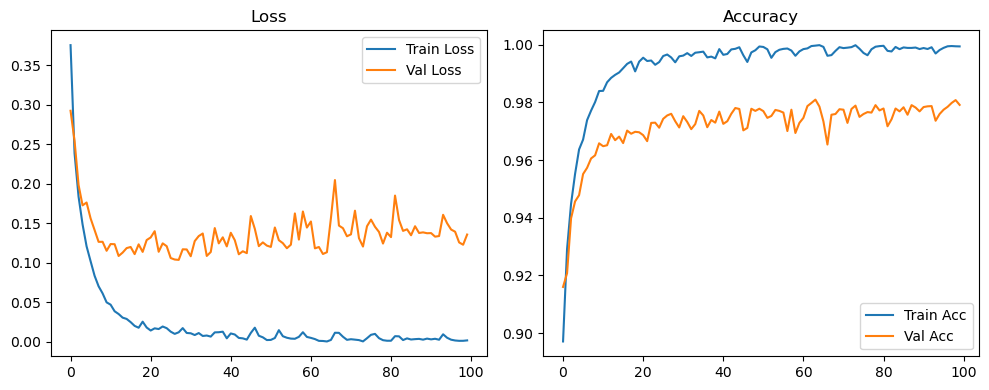

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.4432, Acc: 0.8775 | Val Loss: 0.2977, Acc: 0.9131


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.2964, Acc: 0.9110 | Val Loss: 0.2663, Acc: 0.9227


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.2602, Acc: 0.9223 | Val Loss: 0.2399, Acc: 0.9287


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.2319, Acc: 0.9306 | Val Loss: 0.2074, Acc: 0.9395


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.2046, Acc: 0.9381 | Val Loss: 0.2230, Acc: 0.9314


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.1835, Acc: 0.9439 | Val Loss: 0.1836, Acc: 0.9456


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.1646, Acc: 0.9498 | Val Loss: 0.1669, Acc: 0.9524


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.1461, Acc: 0.9551 | Val Loss: 0.1598, Acc: 0.9524


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.1352, Acc: 0.9586 | Val Loss: 0.1494, Acc: 0.9565


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.1181, Acc: 0.9623 | Val Loss: 0.1487, Acc: 0.9568


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.1111, Acc: 0.9657 | Val Loss: 0.1241, Acc: 0.9647


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0979, Acc: 0.9688 | Val Loss: 0.1330, Acc: 0.9606


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0902, Acc: 0.9714 | Val Loss: 0.1176, Acc: 0.9650


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0851, Acc: 0.9726 | Val Loss: 0.1203, Acc: 0.9643


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0805, Acc: 0.9736 | Val Loss: 0.1232, Acc: 0.9639


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0713, Acc: 0.9769 | Val Loss: 0.1247, Acc: 0.9644


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0649, Acc: 0.9779 | Val Loss: 0.1150, Acc: 0.9667


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0621, Acc: 0.9799 | Val Loss: 0.1133, Acc: 0.9688


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0599, Acc: 0.9801 | Val Loss: 0.1021, Acc: 0.9714


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0515, Acc: 0.9824 | Val Loss: 0.1240, Acc: 0.9657


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0516, Acc: 0.9824 | Val Loss: 0.1036, Acc: 0.9736


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0475, Acc: 0.9840 | Val Loss: 0.1077, Acc: 0.9707


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0425, Acc: 0.9855 | Val Loss: 0.1088, Acc: 0.9705


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0402, Acc: 0.9864 | Val Loss: 0.1064, Acc: 0.9733


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0374, Acc: 0.9868 | Val Loss: 0.1021, Acc: 0.9723


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0356, Acc: 0.9881 | Val Loss: 0.1221, Acc: 0.9699


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0351, Acc: 0.9883 | Val Loss: 0.0996, Acc: 0.9756


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0309, Acc: 0.9888 | Val Loss: 0.1058, Acc: 0.9745


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0337, Acc: 0.9883 | Val Loss: 0.1065, Acc: 0.9738


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0300, Acc: 0.9897 | Val Loss: 0.1070, Acc: 0.9736


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0273, Acc: 0.9903 | Val Loss: 0.0978, Acc: 0.9762


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0245, Acc: 0.9914 | Val Loss: 0.0983, Acc: 0.9770


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0252, Acc: 0.9913 | Val Loss: 0.1078, Acc: 0.9748


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0242, Acc: 0.9911 | Val Loss: 0.1089, Acc: 0.9758


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0233, Acc: 0.9916 | Val Loss: 0.1027, Acc: 0.9775


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0239, Acc: 0.9919 | Val Loss: 0.1017, Acc: 0.9760


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0247, Acc: 0.9914 | Val Loss: 0.1106, Acc: 0.9738


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0262, Acc: 0.9909 | Val Loss: 0.1037, Acc: 0.9757


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0207, Acc: 0.9930 | Val Loss: 0.1078, Acc: 0.9750


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0206, Acc: 0.9929 | Val Loss: 0.1022, Acc: 0.9771


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0186, Acc: 0.9932 | Val Loss: 0.1152, Acc: 0.9752


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0168, Acc: 0.9945 | Val Loss: 0.1063, Acc: 0.9762


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0207, Acc: 0.9929 | Val Loss: 0.1061, Acc: 0.9764


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0179, Acc: 0.9937 | Val Loss: 0.1166, Acc: 0.9765


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0178, Acc: 0.9936 | Val Loss: 0.1081, Acc: 0.9768


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0166, Acc: 0.9937 | Val Loss: 0.1195, Acc: 0.9749


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0174, Acc: 0.9938 | Val Loss: 0.1120, Acc: 0.9764


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0155, Acc: 0.9945 | Val Loss: 0.1148, Acc: 0.9764


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0134, Acc: 0.9952 | Val Loss: 0.1189, Acc: 0.9762


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0141, Acc: 0.9949 | Val Loss: 0.1376, Acc: 0.9732


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0161, Acc: 0.9947 | Val Loss: 0.1269, Acc: 0.9742


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0151, Acc: 0.9946 | Val Loss: 0.1074, Acc: 0.9786


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9953 | Val Loss: 0.1099, Acc: 0.9779


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9951 | Val Loss: 0.1126, Acc: 0.9779


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0146, Acc: 0.9950 | Val Loss: 0.1107, Acc: 0.9785


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9960 | Val Loss: 0.1114, Acc: 0.9779


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0135, Acc: 0.9953 | Val Loss: 0.1142, Acc: 0.9791


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9960 | Val Loss: 0.1159, Acc: 0.9779


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.1192, Acc: 0.9776


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9966 | Val Loss: 0.1222, Acc: 0.9768


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.1185, Acc: 0.9782


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9966 | Val Loss: 0.1095, Acc: 0.9802


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9967 | Val Loss: 0.1238, Acc: 0.9786


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.1289, Acc: 0.9772


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9956 | Val Loss: 0.1148, Acc: 0.9787


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.1152, Acc: 0.9779


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.1247, Acc: 0.9778


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9965 | Val Loss: 0.1267, Acc: 0.9774


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.1172, Acc: 0.9792


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9970 | Val Loss: 0.1168, Acc: 0.9792


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9961 | Val Loss: 0.1335, Acc: 0.9776


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.1378, Acc: 0.9778


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9962 | Val Loss: 0.1407, Acc: 0.9758


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.1289, Acc: 0.9792


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.1258, Acc: 0.9782


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.1223, Acc: 0.9789


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.1290, Acc: 0.9782


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.1276, Acc: 0.9797


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1442, Acc: 0.9757


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1218, Acc: 0.9811


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.1276, Acc: 0.9792


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9974 | Val Loss: 0.1400, Acc: 0.9775


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.1369, Acc: 0.9761


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.1316, Acc: 0.9787


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.1225, Acc: 0.9788


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9973 | Val Loss: 0.1264, Acc: 0.9788


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9968 | Val Loss: 0.1340, Acc: 0.9774


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1325, Acc: 0.9776


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.1369, Acc: 0.9782


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9975 | Val Loss: 0.1255, Acc: 0.9789


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9975 | Val Loss: 0.1305, Acc: 0.9798


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1355, Acc: 0.9792


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1315, Acc: 0.9786


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.1366, Acc: 0.9787


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1486, Acc: 0.9785


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1276, Acc: 0.9800


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1324, Acc: 0.9786


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1235, Acc: 0.9788


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.1306, Acc: 0.9793


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9977 | Val Loss: 0.1457, Acc: 0.9768


Final Test Loss: 0.1278 Accuracy: 0.9792


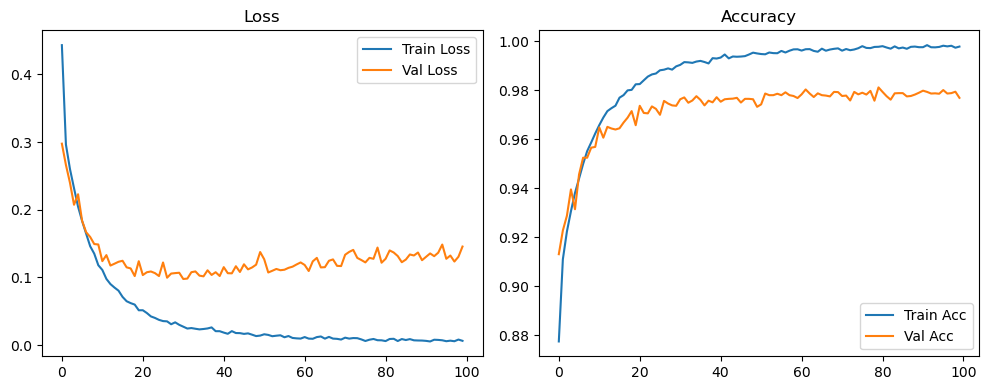

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.6362, Acc: 0.8150 | Val Loss: 0.3172, Acc: 0.9053


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.4027, Acc: 0.8784 | Val Loss: 0.2918, Acc: 0.9148


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.3579, Acc: 0.8916 | Val Loss: 0.2745, Acc: 0.9185


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.3352, Acc: 0.8987 | Val Loss: 0.2504, Acc: 0.9281


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.3108, Acc: 0.9057 | Val Loss: 0.2590, Acc: 0.9212


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.2929, Acc: 0.9110 | Val Loss: 0.2353, Acc: 0.9326


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.2717, Acc: 0.9176 | Val Loss: 0.2148, Acc: 0.9375


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.2587, Acc: 0.9216 | Val Loss: 0.2062, Acc: 0.9405


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.2428, Acc: 0.9265 | Val Loss: 0.1945, Acc: 0.9437


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.2255, Acc: 0.9320 | Val Loss: 0.1855, Acc: 0.9464


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.2099, Acc: 0.9350 | Val Loss: 0.1687, Acc: 0.9519


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.1993, Acc: 0.9393 | Val Loss: 0.1699, Acc: 0.9513


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.1852, Acc: 0.9435 | Val Loss: 0.1531, Acc: 0.9563


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.1745, Acc: 0.9462 | Val Loss: 0.1471, Acc: 0.9584


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.1636, Acc: 0.9500 | Val Loss: 0.1470, Acc: 0.9565


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.1547, Acc: 0.9526 | Val Loss: 0.1397, Acc: 0.9609


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.1489, Acc: 0.9541 | Val Loss: 0.1318, Acc: 0.9613


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.1405, Acc: 0.9566 | Val Loss: 0.1302, Acc: 0.9639


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.1313, Acc: 0.9594 | Val Loss: 0.1203, Acc: 0.9656


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.1286, Acc: 0.9606 | Val Loss: 0.1221, Acc: 0.9645


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.1204, Acc: 0.9631 | Val Loss: 0.1173, Acc: 0.9666


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.1142, Acc: 0.9638 | Val Loss: 0.1125, Acc: 0.9680


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.1072, Acc: 0.9670 | Val Loss: 0.1123, Acc: 0.9686


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.1061, Acc: 0.9675 | Val Loss: 0.1144, Acc: 0.9687


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.1021, Acc: 0.9669 | Val Loss: 0.1146, Acc: 0.9685


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0930, Acc: 0.9708 | Val Loss: 0.1084, Acc: 0.9708


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0935, Acc: 0.9706 | Val Loss: 0.1068, Acc: 0.9722


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0885, Acc: 0.9715 | Val Loss: 0.1031, Acc: 0.9715


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0866, Acc: 0.9719 | Val Loss: 0.1034, Acc: 0.9722


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0833, Acc: 0.9734 | Val Loss: 0.1050, Acc: 0.9725


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0768, Acc: 0.9752 | Val Loss: 0.1019, Acc: 0.9727


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0781, Acc: 0.9746 | Val Loss: 0.1005, Acc: 0.9738


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0740, Acc: 0.9759 | Val Loss: 0.1014, Acc: 0.9724


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0714, Acc: 0.9767 | Val Loss: 0.0988, Acc: 0.9741


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0664, Acc: 0.9779 | Val Loss: 0.0976, Acc: 0.9744


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0680, Acc: 0.9776 | Val Loss: 0.0979, Acc: 0.9738


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0665, Acc: 0.9785 | Val Loss: 0.0993, Acc: 0.9742


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0635, Acc: 0.9794 | Val Loss: 0.0995, Acc: 0.9742


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0594, Acc: 0.9804 | Val Loss: 0.0985, Acc: 0.9751


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0609, Acc: 0.9790 | Val Loss: 0.0956, Acc: 0.9759


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0551, Acc: 0.9812 | Val Loss: 0.0989, Acc: 0.9750


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0540, Acc: 0.9815 | Val Loss: 0.0970, Acc: 0.9755


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0541, Acc: 0.9822 | Val Loss: 0.0953, Acc: 0.9752


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0533, Acc: 0.9823 | Val Loss: 0.0966, Acc: 0.9762


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0487, Acc: 0.9839 | Val Loss: 0.0976, Acc: 0.9745


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0466, Acc: 0.9835 | Val Loss: 0.0929, Acc: 0.9765


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0451, Acc: 0.9844 | Val Loss: 0.0948, Acc: 0.9765


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0474, Acc: 0.9839 | Val Loss: 0.0950, Acc: 0.9762


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0451, Acc: 0.9838 | Val Loss: 0.1003, Acc: 0.9765


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0466, Acc: 0.9846 | Val Loss: 0.0989, Acc: 0.9768


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0463, Acc: 0.9846 | Val Loss: 0.0987, Acc: 0.9750


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0454, Acc: 0.9849 | Val Loss: 0.1002, Acc: 0.9764


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0423, Acc: 0.9867 | Val Loss: 0.0922, Acc: 0.9769


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0399, Acc: 0.9866 | Val Loss: 0.0909, Acc: 0.9772


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0389, Acc: 0.9874 | Val Loss: 0.0892, Acc: 0.9795


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0382, Acc: 0.9873 | Val Loss: 0.0991, Acc: 0.9770


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0396, Acc: 0.9872 | Val Loss: 0.0969, Acc: 0.9775


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0339, Acc: 0.9888 | Val Loss: 0.1006, Acc: 0.9754


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0364, Acc: 0.9881 | Val Loss: 0.0955, Acc: 0.9782


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0362, Acc: 0.9881 | Val Loss: 0.0975, Acc: 0.9782


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0357, Acc: 0.9878 | Val Loss: 0.0982, Acc: 0.9787


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0303, Acc: 0.9892 | Val Loss: 0.0986, Acc: 0.9782


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0314, Acc: 0.9888 | Val Loss: 0.0968, Acc: 0.9779


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0349, Acc: 0.9881 | Val Loss: 0.1008, Acc: 0.9787


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0319, Acc: 0.9893 | Val Loss: 0.0941, Acc: 0.9792


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0314, Acc: 0.9894 | Val Loss: 0.1038, Acc: 0.9778


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0313, Acc: 0.9891 | Val Loss: 0.1018, Acc: 0.9778


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0305, Acc: 0.9895 | Val Loss: 0.1036, Acc: 0.9771


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0304, Acc: 0.9898 | Val Loss: 0.1012, Acc: 0.9778


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0303, Acc: 0.9904 | Val Loss: 0.1022, Acc: 0.9779


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0287, Acc: 0.9900 | Val Loss: 0.1031, Acc: 0.9790


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0308, Acc: 0.9899 | Val Loss: 0.1006, Acc: 0.9793


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0282, Acc: 0.9902 | Val Loss: 0.1018, Acc: 0.9782


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0273, Acc: 0.9910 | Val Loss: 0.0976, Acc: 0.9802


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0268, Acc: 0.9908 | Val Loss: 0.0987, Acc: 0.9798


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0259, Acc: 0.9908 | Val Loss: 0.1081, Acc: 0.9784


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0246, Acc: 0.9917 | Val Loss: 0.1019, Acc: 0.9796


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0255, Acc: 0.9912 | Val Loss: 0.1015, Acc: 0.9801


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0264, Acc: 0.9910 | Val Loss: 0.1053, Acc: 0.9792


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0244, Acc: 0.9910 | Val Loss: 0.1010, Acc: 0.9798


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0239, Acc: 0.9919 | Val Loss: 0.1028, Acc: 0.9792


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0249, Acc: 0.9915 | Val Loss: 0.1030, Acc: 0.9789


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0261, Acc: 0.9909 | Val Loss: 0.1003, Acc: 0.9802


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0232, Acc: 0.9918 | Val Loss: 0.1052, Acc: 0.9803


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0235, Acc: 0.9927 | Val Loss: 0.0960, Acc: 0.9797


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9927 | Val Loss: 0.1031, Acc: 0.9800


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0241, Acc: 0.9922 | Val Loss: 0.1057, Acc: 0.9802


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0247, Acc: 0.9912 | Val Loss: 0.1097, Acc: 0.9795


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0222, Acc: 0.9924 | Val Loss: 0.1057, Acc: 0.9795


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0246, Acc: 0.9916 | Val Loss: 0.1045, Acc: 0.9796


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0203, Acc: 0.9931 | Val Loss: 0.1109, Acc: 0.9780


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0215, Acc: 0.9922 | Val Loss: 0.1050, Acc: 0.9802


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0219, Acc: 0.9929 | Val Loss: 0.1031, Acc: 0.9798


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0207, Acc: 0.9929 | Val Loss: 0.0985, Acc: 0.9808


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0195, Acc: 0.9935 | Val Loss: 0.1086, Acc: 0.9802


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0199, Acc: 0.9934 | Val Loss: 0.1044, Acc: 0.9806


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0185, Acc: 0.9941 | Val Loss: 0.1069, Acc: 0.9788


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0202, Acc: 0.9932 | Val Loss: 0.1102, Acc: 0.9799


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0206, Acc: 0.9935 | Val Loss: 0.1117, Acc: 0.9798


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0181, Acc: 0.9939 | Val Loss: 0.1106, Acc: 0.9802


Final Test Loss: 0.1032 Accuracy: 0.9819


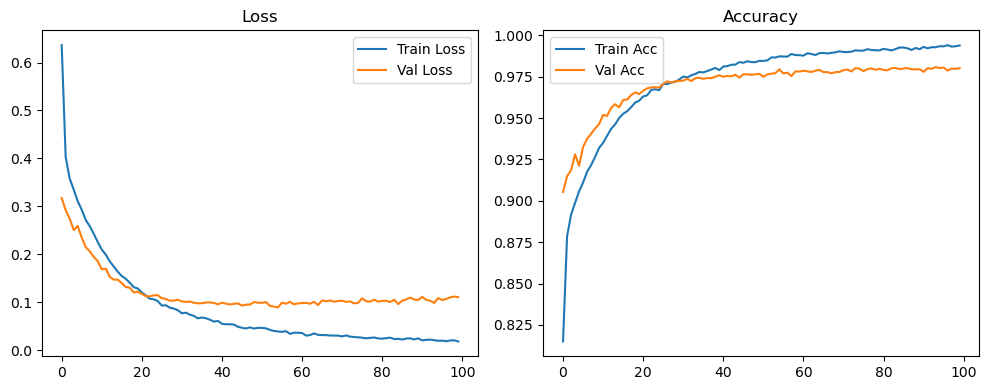

🏆 Best Config: batch128_lr0.01_0.005_0.001_dp0.2 Accuracy: 0.9870


In [8]:
root_path = "MLP_1024_float_regular_Sigmoid"

epochs = 100
batch_sizes = [64, 128, 256]
dropout_rates = [0.0, 0.2, 0.5]
lr_pool = [0.01, 0.005, 0.002, 0.001]

Hyperparameter_searching(root_path, epochs, batch_sizes, lr_pool, dropout_rates)